In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import sys
# sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields, asdict
import itertools
from itertools import chain, product
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer, LlamaTokenizer
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
torch.set_grad_enabled(False);

In utils/hub.py: default_cache_path: /raid3/xd/.cache/torch/hub->/nas/xd/.cache/torch/transformers/


In [4]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils import *
from child_utils import _str, _cxt2str, _item2str, _s, _be
from child_frames import *
with Timer('tasks'): from tasks import *
with Timer('model_utils_wab'): from model_utils_wab_v2 import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000015
utils ... done 0:00:00.000702
child_utils ... In const.py: Loading tokenizer ... 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


done 0:00:00.091305
done 0:00:00.143993
tasks ... done 0:00:00.000194
model_utils_wab ... done 0:00:00.082218
weight_analysis ... done 0:00:00.000012


In [5]:
models = {}
cache_dir = '/home/xd/.cache/torch/transformers/'
proxies = {'http': '192.168.50.1:1081'} 

In [6]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-j-6B/int8', 'EleutherAI/gpt-j-6B',
                  ]#, 'EleutherAI/gpt-neox-20b/cpu', #'EleutherAI/gpt-neox-20b', 'gpt2-xl', 'gpt2']
llama_model_names = ['models/vicuna/vicuna-7b@int8', 'models/vicuna/vicuna-13b@int8',
                     'lmsys/vicuna-13b-v1.3@cpu', 'lmsys/vicuna-13b-v1.3@int8', 
                     'lmsys/vicuna-33b-v1.3@cpu', 'lmsys/vicuna-33b-v1.3@int8', 'lmsys/vicuna-33b-v1.3'
                    ]
name2device = {'gpt-j-6B': 0, #'models/vicuna/vicuna-7b': 8, 'models/vicuna/vicuna-13b': 8,  
               'vicuna': 0, 'vicuna-7b-v1.3': 0, 'vicuna-13b-v1.3': 0, 'vicuna-33b-v1.3': 0}
for model_name in llama_model_names[-1:] + gpt_model_names[:0]:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM #if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        _cache_dir = cache_dir# .replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        dst = model_name.split('@')[-1] if '@' in model_name else 'cuda'
        model_name = model_name.replace('/cpu', '').replace('/int8', '')
        _model_name = model_name.split('/')[-1]
        if _model_name.startswith('vicuna'): _model_name = 'vicuna'
        kwargs = dict(cache_dir=_cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if dst == 'cpu':
            model = model_cls.from_pretrained(model_name, **kwargs)
        else:  # fp16 or int8 on GPU
            device = name2device[_model_name]
            device_map = get_device_map(devices=device, **name2mapping[_model_name]) if isinstance(device, Iterable) else None
            dtype_kwargs = dict(load_in_8bit=True) if dst == 'int8' else dict(torch_dtype=torch.float16)
            revision_kwargs = dict(revision='float16') if _model_name == 'gpt-j-6B' else {}
            model = model_cls.from_pretrained(model_name, device_map=device_map, **dtype_kwargs, **revision_kwargs, **kwargs)
            if device_map is None: model = model.to(device)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # to avoid slow loading of AutoTokenizer->TokenizerFast
        tokenizer_cls = LlamaTokenizer if 'vicuna' in model_name else GPT2Tokenizer
        tokenizer = tokenizer_cls.from_pretrained(model_name, cache_dir=_cache_dir)
        unify(model); unify_tokenizer(tokenizer)
        models[model_name] = model, tokenizer

lmsys/vicuna-33b-v1.3 ... In cached_download, before requesst
In cached_download, after requesst
In cached_download, before requesst
In cached_download, after requesst
In cached_download, before requesst
In cached_download, before requesst
In cached_download, before requesst
In cached_download, before requesst
In cached_download, after requesst


In cached_download, before requesst
In cached_download, after requesst
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00001-of-00007.bin
In cached_download, before requesst
In cached_download, after requesst
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00002-of-00007.bin
In cached_download, before requesst
In cached_download, after requesst
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00003-of-00007.bin
In cached_download, before requesst
In cached_download, after requesst
In huggingface_hub.file_download.cached_download: url = https://huggingface.co/lmsys/vicuna-33b-v1.3/resolve/main/pytorch_model-00004-of-00007.bin
In cached_download, before requesst
In cached_download, after requesst
In huggingface_hub.file_download.cached_download: url = h

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In cached_download, before requesst
In cached_download, after requesst
In cached_download, before requesst
In cached_download, after requesst
In cached_download, before requesst
In cached_download, after requesst
In cached_download, before requesst
In cached_download, before requesst
In cached_download, after requesst
In cached_download, before requesst
In cached_download, after requesst
In cached_download, before requesst


You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


done 0:00:46.797283


## 数据集

In [7]:
class Winograd:  # wab
    def __init__(self, text_json, word_idx_json):
        with open(text_json, 'r') as f:
            self.sentences=json.load(f)
        with open(word_idx_json, 'r') as f:
            self.word_idx = json.load(f)
            if 'candidates' in self.word_idx:  # to be consistent with candidates of examples from generate
                self.word_idx['candidates'] = [[cand, cand] for cand in self.word_idx['candidates']]

In [8]:
winograd = Winograd('wino_sentences.json', 'wino_word_idx.json')

In [9]:
winograd_s2before = Winograd('wino_s2before_sentences.json', 'wino_s2before_word_idx.json')

In [10]:
winograd_s2after = Winograd('wino_s2after_sentences.json', 'wino_s2after_word_idx.json')

In [133]:
# winograd.word_idx = {#new
#     'IO' : ['the suitcase','Susan','the bus','the board','Susan','the bag of flour','the cup','Betty','the opponents','the doorway','Amy','Amy'],#
#     'ans0':['large','rich','fast','hard','short','first','empty','older','minority','narrow','full','notorious'],
#     'nans0':['small','poor','slow','soft','tall','later','full','younger','majority','wide','hungry','popular'],
#     'ansright':[' ]',' ]',' ]',' ]',' ]',' ]',' ]',' ]',' ]',' ]',' ]',' ]'],
#     'S'  : ['the trophy','John','the truck','the ball','John','the bag of potatoes','the bottle','Jack','the sponsors','the table','Bill','James'],
#     'S2' : ['the trophy','John','the truck','the ball','John','the bag of potatoes','the bottle','Jack','the sponsors','the table','Bill','James'],#S2range，（6，8）
#     'end' : ['is','was','going','was','is','moved','was','is','the','is','was','was'],
#     'relation':["doesn't fit into",'gave a lot of money to','overtook','crashed right through',"couldn't see the stage behind",'had been placed above','was filled with water from','always takes care of','were less in number than','will fit through','passed the half-empty plate to','ceded the presidency to'],
#     'inter':['because','because','because','because','because','so','after','because','so','because','because','because'],
#     'op':['Options','Options','Options','Options','Options','Options','Options','Options','Options','Options','Options','Options'],
#     'postans':post_ans,
#     'preans':pre_ans,
#     'candidates' : [['large','small'],[ 'rich', 'poor'],['fast','slow'],['hard','soft'],['short','tall'], ['first','later'],['empty','full'],['older','younger'],['minority','majority'],[ 'narrow' , 'wide' ],[ 'full','hungry'],[ 'notorious', 'popular' ]]
# }

In [542]:
embed_dim * 8 / 3

17749.333333333332

# predict

In [9]:
blocks = model.model.layers
for i, b in enumerate(blocks): b.layer = i
# ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].self_attn.num_heads, blocks[0].self_attn.embed_dim

In [10]:
L, H #/ (28 * 16)

(60, 52)

In [11]:
r1 = None
result = {}

In [12]:
winograd.sentences

["Options: [ small or large ] the trophy doesn't fit into the suitcase because the trophy is large",
 "Options: [ large or small ] the trophy doesn't fit into the suitcase because the suitcase is small",
 'Options: [ rich or poor ] John gave a lot of money to Susan because John was rich',
 'Options: [ rich or poor ] John gave a lot of money to Susan because Susan was poor',
 'Options: [ fast or slow ] the truck overtook the bus because the truck was going fast',
 'Options: [ fast or slow ] the truck overtook the bus because the bus was going slow',
 'Options: [ hard or soft ] the ball crashed right through the board because the ball was hard',
 'Options: [ soft or hard ] the ball crashed right through the board because the board was soft',
 "Options: [ tall or short ] John couldn't see the stage behind Susan because John is short",
 "Options: [ short or tall ] John couldn't see the stage behind Susan because Susan is tall",
 'Options: [ later or first ] the bag of potatoes had been pla

Options: [ small or large ] the trophy doesn't fit into the suitcase because the trophy is large
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
2.6747639995301142 0.7916666666666666 0.734


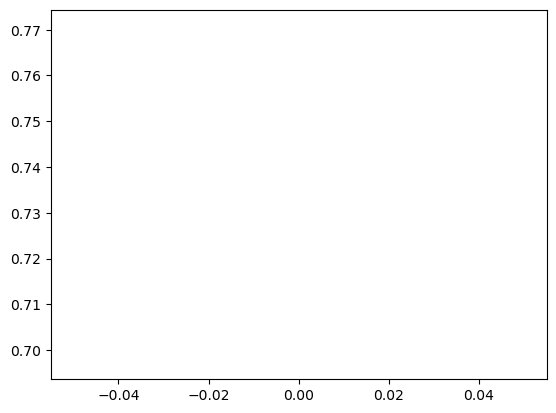

In [13]:
r1 = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=24,wino_dataset = winograd,
                                        trim=False, result=r1, verbose=False)#8tiao

In [16]:
r1_before = None
result_before = {}

Options: [ small or large ] the trophy doesn't fit into the suitcase because the trophy is large
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
2.096352681517601 0.9166666666666666 0.8700833333333334


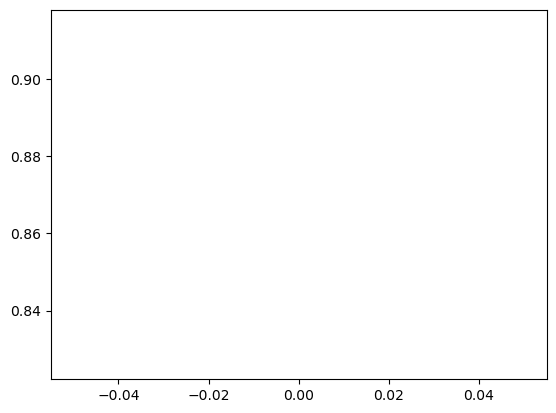

In [17]:
r1_before = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=12,wino_dataset = winograd_s2before,
                                        trim=False, result=r1_before, verbose=False)#8tiao

In [18]:
r1_after = None
result_after = {}

Options: [ large or small ] the trophy doesn't fit into the suitcase because the suitcase is small
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
3.2531753175426275 0.6666666666666666 0.5979166666666668


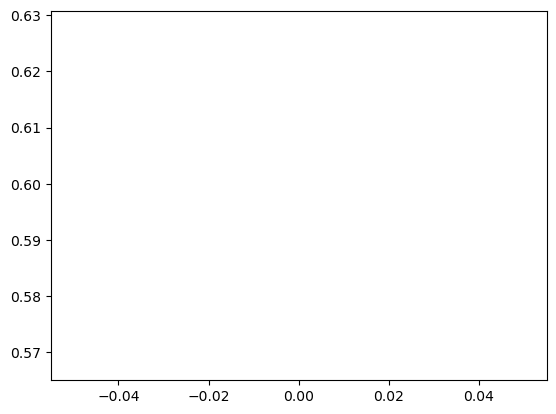

In [19]:
r1_after = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=12,wino_dataset = winograd_s2after,
                                        trim=False, result=r1_after, verbose=False)#8tiao

## although dataset

In [23]:
winograd_al = Winograd('wino_al_sentences.json', 'wino_al_word_idx.json')

In [85]:
winograd_al.sentences

["Options: [ small or large ] the trophy doesn't fit into the suitcase although the trophy is small",
 "Options: [ large or small ] the trophy doesn't fit into the suitcase although the suitcase is large",
 'Options: [ rich or poor ] John gave a lot of money to Susan although John was poor',
 'Options: [ rich or poor ] John gave a lot of money to Susan although Susan was rich',
 'Options: [ fast or slow ] the truck overtook the bus although the truck was going slow',
 'Options: [ fast or slow ] the truck overtook the bus although the bus was going fast',
 'Options: [ hard or soft ] the ball crashed right through the board although the ball was soft',
 'Options: [ soft or hard ] the ball crashed right through the board although the board was hard',
 "Options: [ tall or short ] John couldn't see the stage behind Susan although John is tall",
 "Options: [ short or tall ] John couldn't see the stage behind Susan although Susan is short",
 'Options: [ later or first ] the bag of potatoes ha

In [25]:
winograd_al.word_idx

{'IO': ['the suitcase',
  'the trophy',
  'Susan',
  'John',
  'the bus',
  'the truck',
  'the board',
  'the ball',
  'Susan',
  'John',
  'the bag of flour',
  'the bag of potatoes',
  'the cup',
  'the bottle',
  'Betty',
  'Jack',
  'the opponents',
  'the sponsors',
  'the doorway',
  'the table',
  'Amy',
  'Bill',
  'Amy',
  'James'],
 'ans0': ['small',
  'large',
  'poor',
  'rich',
  'slow',
  'fast',
  'soft',
  'hard',
  'tall',
  'short',
  'later',
  'first',
  'full',
  'empty',
  'younger',
  'older',
  'majority',
  'minority',
  'wide',
  'narrow',
  'hungry',
  'full',
  'popular',
  'notorious'],
 'nans0': ['large',
  'small',
  'rich',
  'poor',
  'fast',
  'slow',
  'hard',
  'soft',
  'short',
  'tall',
  'first',
  'later',
  'empty',
  'full',
  'older',
  'younger',
  'minority',
  'majority',
  'narrow',
  'wide',
  'full',
  'hungry',
  'notorious',
  'popular'],
 'ansright': [' ]',
  ' ]',
  ' ]',
  ' ]',
  ' ]',
  ' ]',
  ' ]',
  ' ]',
  ' ]',
  ' ]',
  ' 

In [23]:
for index,i in enumerate(winograd_al.sentences):
    a = winograd_al.sentences[index].split(' ')[:-1]
    a.append(winograd_al.word_idx['ans0'][index])
    winograd_al.sentences[index] = ' '.join(a)

In [26]:
candi = [i[0] for i in winograd_al.word_idx['candidates']]

In [47]:
with open("wino_al_word_idx.json","w") as f:
        json.dump(winograd_al.word_idx,f)

In [48]:
winograd_al_t = Winograd('wino_al_sentences.json', 'wino_al_word_idx.json')

In [28]:
r1_al = None
result_al = {}

Options: [ small or large ] the trophy doesn't fit into the suitcase although the trophy is small
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
2.188961294091617 0.7083333333333334 0.672


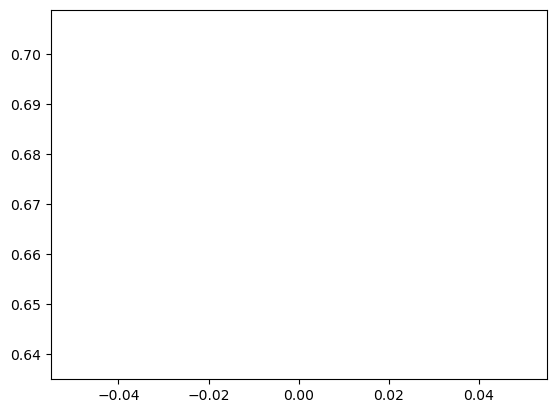

In [29]:
r1_al = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=24,wino_dataset = winograd_al,
                                        trim=False, result=r1_al, verbose=False)#8tiao

In [88]:
len(r1_al.data_tuples)

24

In [30]:
winograd_al_before = Winograd('wino_al_s2before_sentences.json', 'wino_al_s2before_word_idx.json')

In [33]:
r1_al_before = None
result_al_before = {}

Options: [ small or large ] the trophy doesn't fit into the suitcase although the trophy is small
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
2.3914466535982988 0.6666666666666666 0.6089166666666667


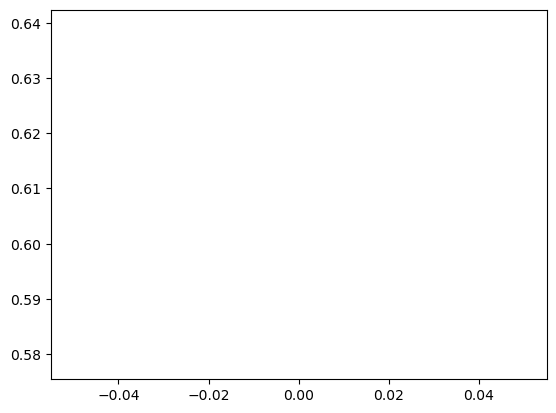

In [34]:
r1_al_before = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=12,wino_dataset = winograd_al_before,
                                        trim=False, result=r1_al_before, verbose=False)#8tiao

In [43]:
winograd_al_after = Winograd('wino_al_s2after_sentences.json','wino_al_s2after_word_idx.json')

In [44]:
r1_al_after = None
result_al_after = {}

Options: [ large or small ] the trophy doesn't fit into the suitcase although the suitcase is large
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
In predict: set logits_mask
1.9864759345849354 0.75 0.7350833333333333


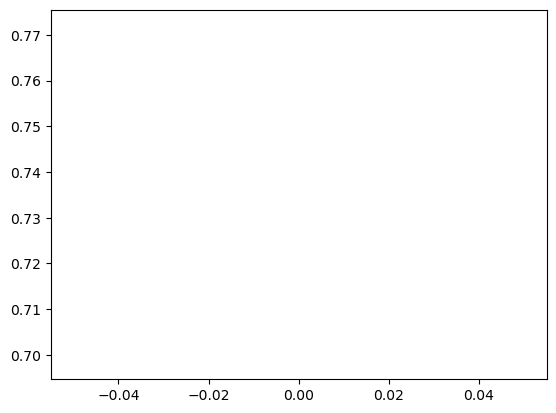

In [45]:
r1_al_after = generate_and_predict_batch(model, tokenizer, task= None, nrows=1, k_shot=0, batch_size=12,wino_dataset = winograd_al_after,
                                        trim=False, result=r1_al_after, verbose=False)#8tiao

In [42]:
with open("wino_al_s2after_word_idx.json","w") as f:
        json.dump(winograd_al_after_word_idx,f)

# attribute

In [14]:
def filter_fn(p, c):  #合并版
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1  and c.topi == 2 or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and c.topi==12 or  #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and (c.topi in [1,7,9])  or
       p.step == 2 and p.attn_pattern =='s1->s1' and c.topi in [0,1,2,4,5,6,7,9,10] or
    p.step == 3 and c.topi in [2,3,7,8,9,11,12] or
            p.step == 4 and c.top_score>0.5 or
            p.step == 5 and c.top_score>0.7#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [15]:
if True or r1.root is None: r1.root = add_node(None, layer=L, label_type='labels')
r1.root = attribute_tree_on(r1.data_tuples, model, r1.root, 4, filter_fn, topk=15, k_shot=0, threshold_score=0.1, mix=True, device=None, verbose=True)

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:00.968726
(array([53, 26, 24, 30, 53, 21, 26, 27, 21, 29]),
 array([17, 51, 20, 19, 14, 12, 29, 40, 38,  0]),
 array([0.30632147, 0.26420435, 0.23931344, 0.23698504, 0.20944722,
       0.19690578, 0.18542075, 0.18282063, 0.17842674, 0.162117  ],
      dtype=float32))
In _add_node: add @1 43-m 86
In _add_node: add @2 39-m 83
In _add_node: add @3 36-m 73
In _add_node: add @4 27-m 68
In _add_node: add @5 47-m 62
In _add_node: add @6 37-m 59
In _add_node: add @7 22-m 54
In _add_node: add @8 24-m 53
In _add_node: add @9 33-m 47
In _add_node: add @11 23-m 44
In _add_node: add @12 45-m 42
In _add_node: add @13 31-m 37
In _add_node: add @14 55-m 36
In _add_node: add @0 44-30 100 B->A0 21/7 attn
In _add_node: add @10 30-43 45 B->s1 16/15 attn
In _add_node: add @[1,2,3,4,5,6,7,8,9,11,12,13,14] 43-m,39-m,36-m,27-m,47-m,37-m,22-m,24-m,33-m,23-m,45-m,31-m,55-m B->B 87
In _add_node: add @[0,10] 44-30,30-43 unk 0
In _add_node: add 39

In [16]:
print_tree(r1.root)

 ┌@[1,2,3,4,5,6,7,8,9,11,12,13,14] 43-m,39-m,36-m,27-m,47-m,37-m,22-m,24-m,33-m,23-m,45-m,31-m,55-m B->B 87
 ├@[0,10] 44-30,30-43 unk 0
 ├@1 43-m 86
 ├@2 39-m 83
 ├@3 36-m 73
 ├@4 27-m 68
 ├@5 47-m 62
 ├@6 37-m 59
 ├@7 22-m 54
 ├@8 24-m 53
 ├@9 33-m 47
 ├@11 23-m 44
 ├@12 45-m 42
 ├@13 31-m 37
 ├@14 55-m 36
 ├@0 44-30 100 B->A0 21/7 attn
 ├@10 30-43 45 B->s1 16/15 attn
 ┤
 │         ┌@[1,2,4,8,9,11,13,14] 28-m,31-m,29-m,20-m,32-m,36-m,35-m,21-m B->B 56
 │         ├@[3,5,12] 32-1,29-3,32-9 B->s1 8
 │         ├@[0,7] 33-11,34-31 B->Ration 7
 │         ├@[6,10] 27-29,35-29 unk 0
 │         ├@1 28-m 91
 │         ├@2 31-m 89
 │         ├@4 29-m 75
 │         ├@8 20-m 66
 │         ├@9 32-m 58
 │         ├@11 36-m 57
 │         ├@13 35-m 42
 │         ├@14 21-m 39
 │         ├@3 32-1 75 B->s1 25/27
 │         ├@5 29-3 73 B->s1 23/14
 │         ├@12 32-9 44 B->s1 47/52
 │         ├@0 33-11 100 B->Ration 14/10
 │         ├@0 33-11 100 B->Ration 14/10 attn attr_k
 │         ├@0 33-11 100 B->Ra

In [92]:
print_tree(r1.root)

 ┌@[1,2,3,4,5,6,7,8,9,11,12,13,14] 43-m,39-m,36-m,27-m,47-m,37-m,22-m,24-m,33-m,23-m,45-m,31-m,55-m B->B 87
 ├@[0,10] 44-30,30-43 unk 0
 ├@1 43-m 86
 ├@2 39-m 83
 ├@3 36-m 73
 ├@4 27-m 68
 ├@5 47-m 62
 ├@6 37-m 59
 ┤
 ├@7 22-m 54
 ├@8 24-m 53
 ├@9 33-m 47
 ├@11 23-m 44
 ├@12 45-m 42
 ├@13 31-m 37
 ├@14 55-m 36
 ├@0 44-30 100 B->A0 21/7 attn
 └@10 30-43 45 B->s1 16/15 attn


In [17]:
node = r1.root.children[-1]
node.name

'39-m B->B'

In [23]:
11/24

0.4583333333333333

32-9 -> 39-m B->B
*▁large 0.501 {'▁large': 0.501, '▁small': 0.499, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ small or large ] the trophy doesn't fit into the suitcase because the trophy is large ▁small:0.001011 *▁large:0.004585
ap_scores = tensor([0.5883]) tensor(0.5883)


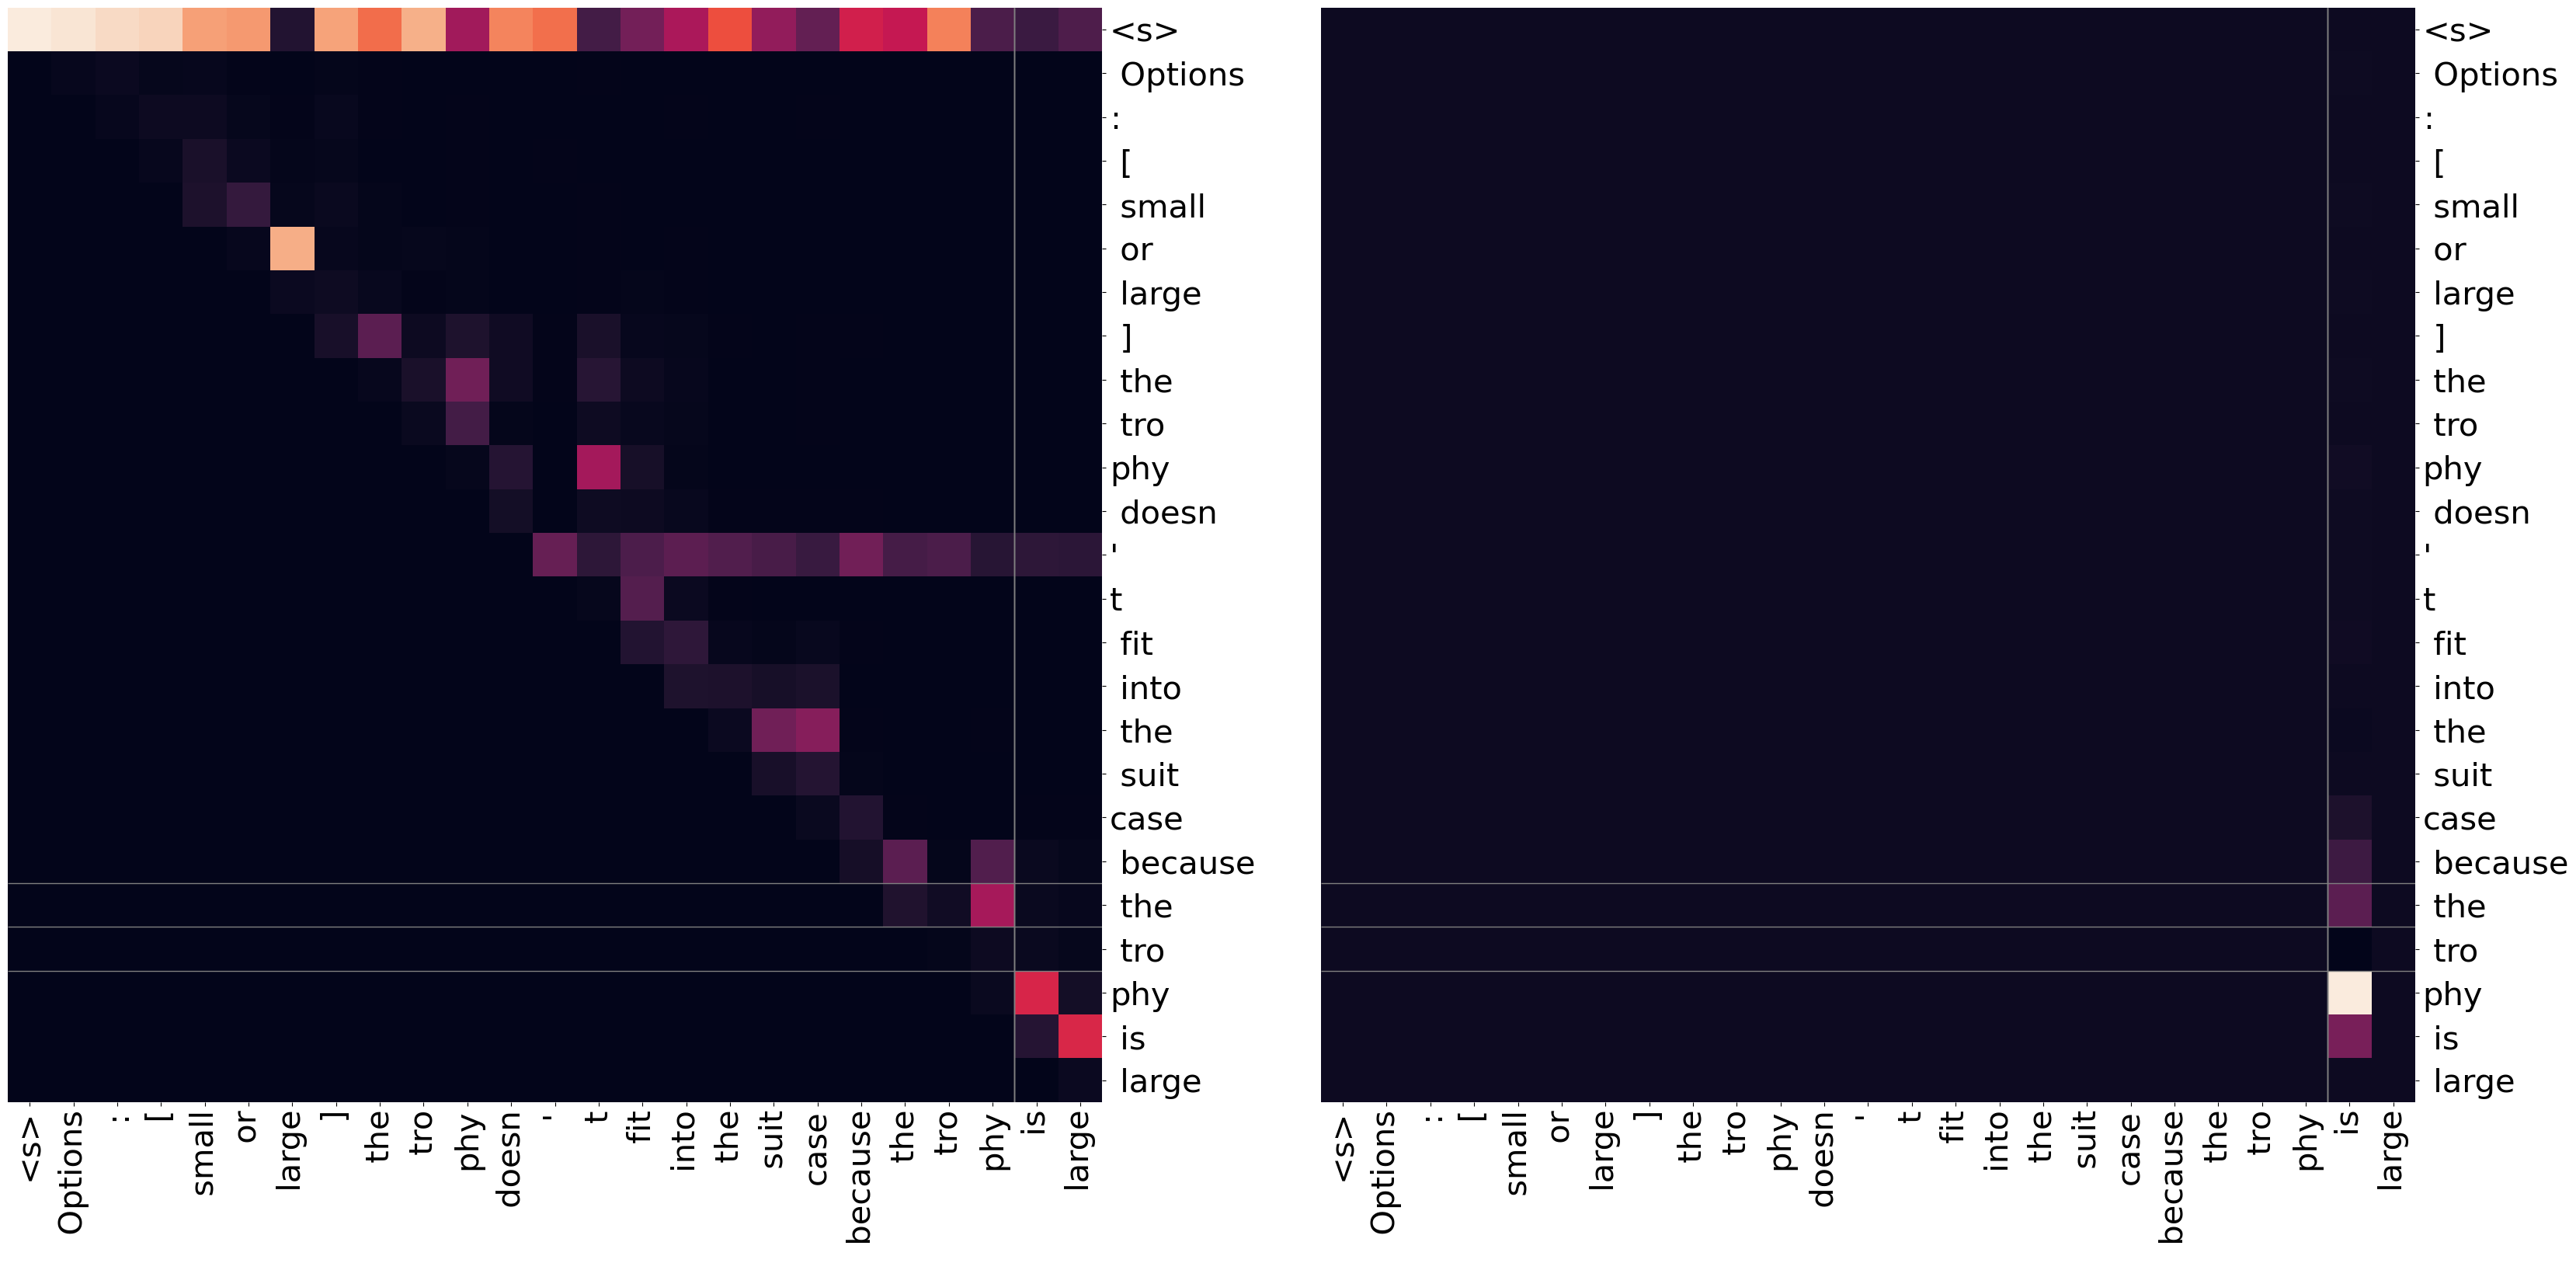

*▁small 0.503 {'▁small': 0.504, '▁large': 0.497, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ large or small ] the trophy doesn't fit into the suitcase because the suitcase is small *▁small:0.010277 ▁large:-0.002544
ap_scores = tensor([0.6803]) tensor(0.6803)


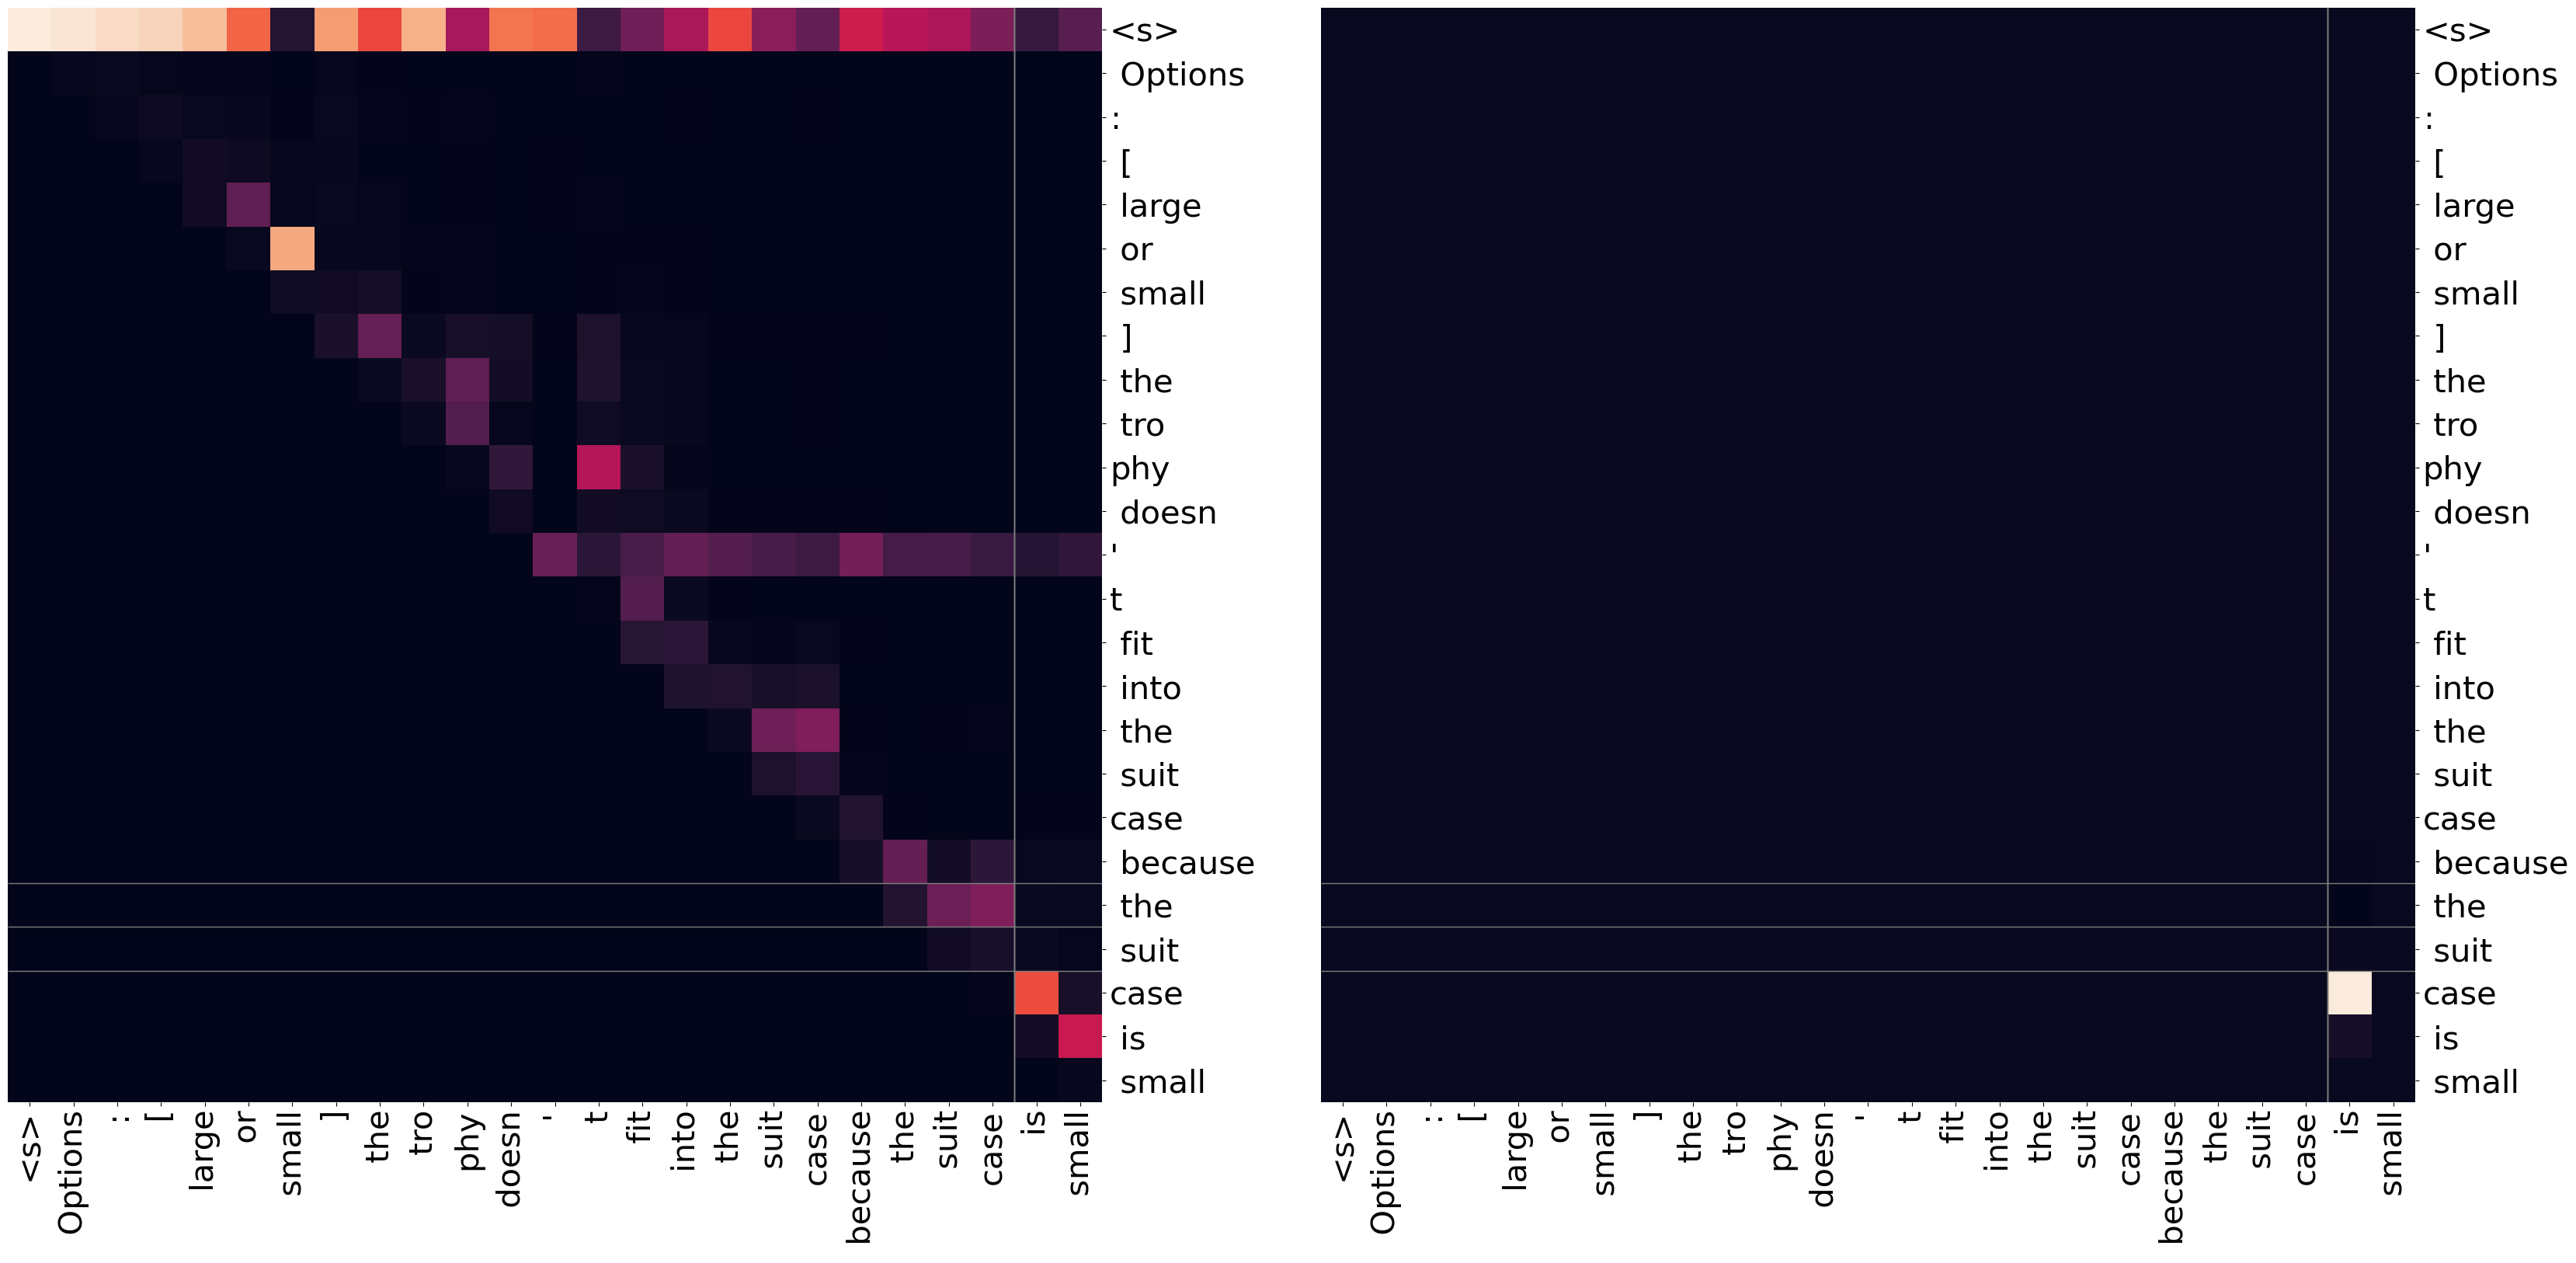

 ▁rich 0.497 {'▁poor': 0.504, '▁rich': 0.496, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ rich or poor ] John gave a lot of money to Susan because John was rich ▁poor:0.013046 *▁rich:-0.000598
ap_scores = tensor([0.7134]) tensor(0.7134)


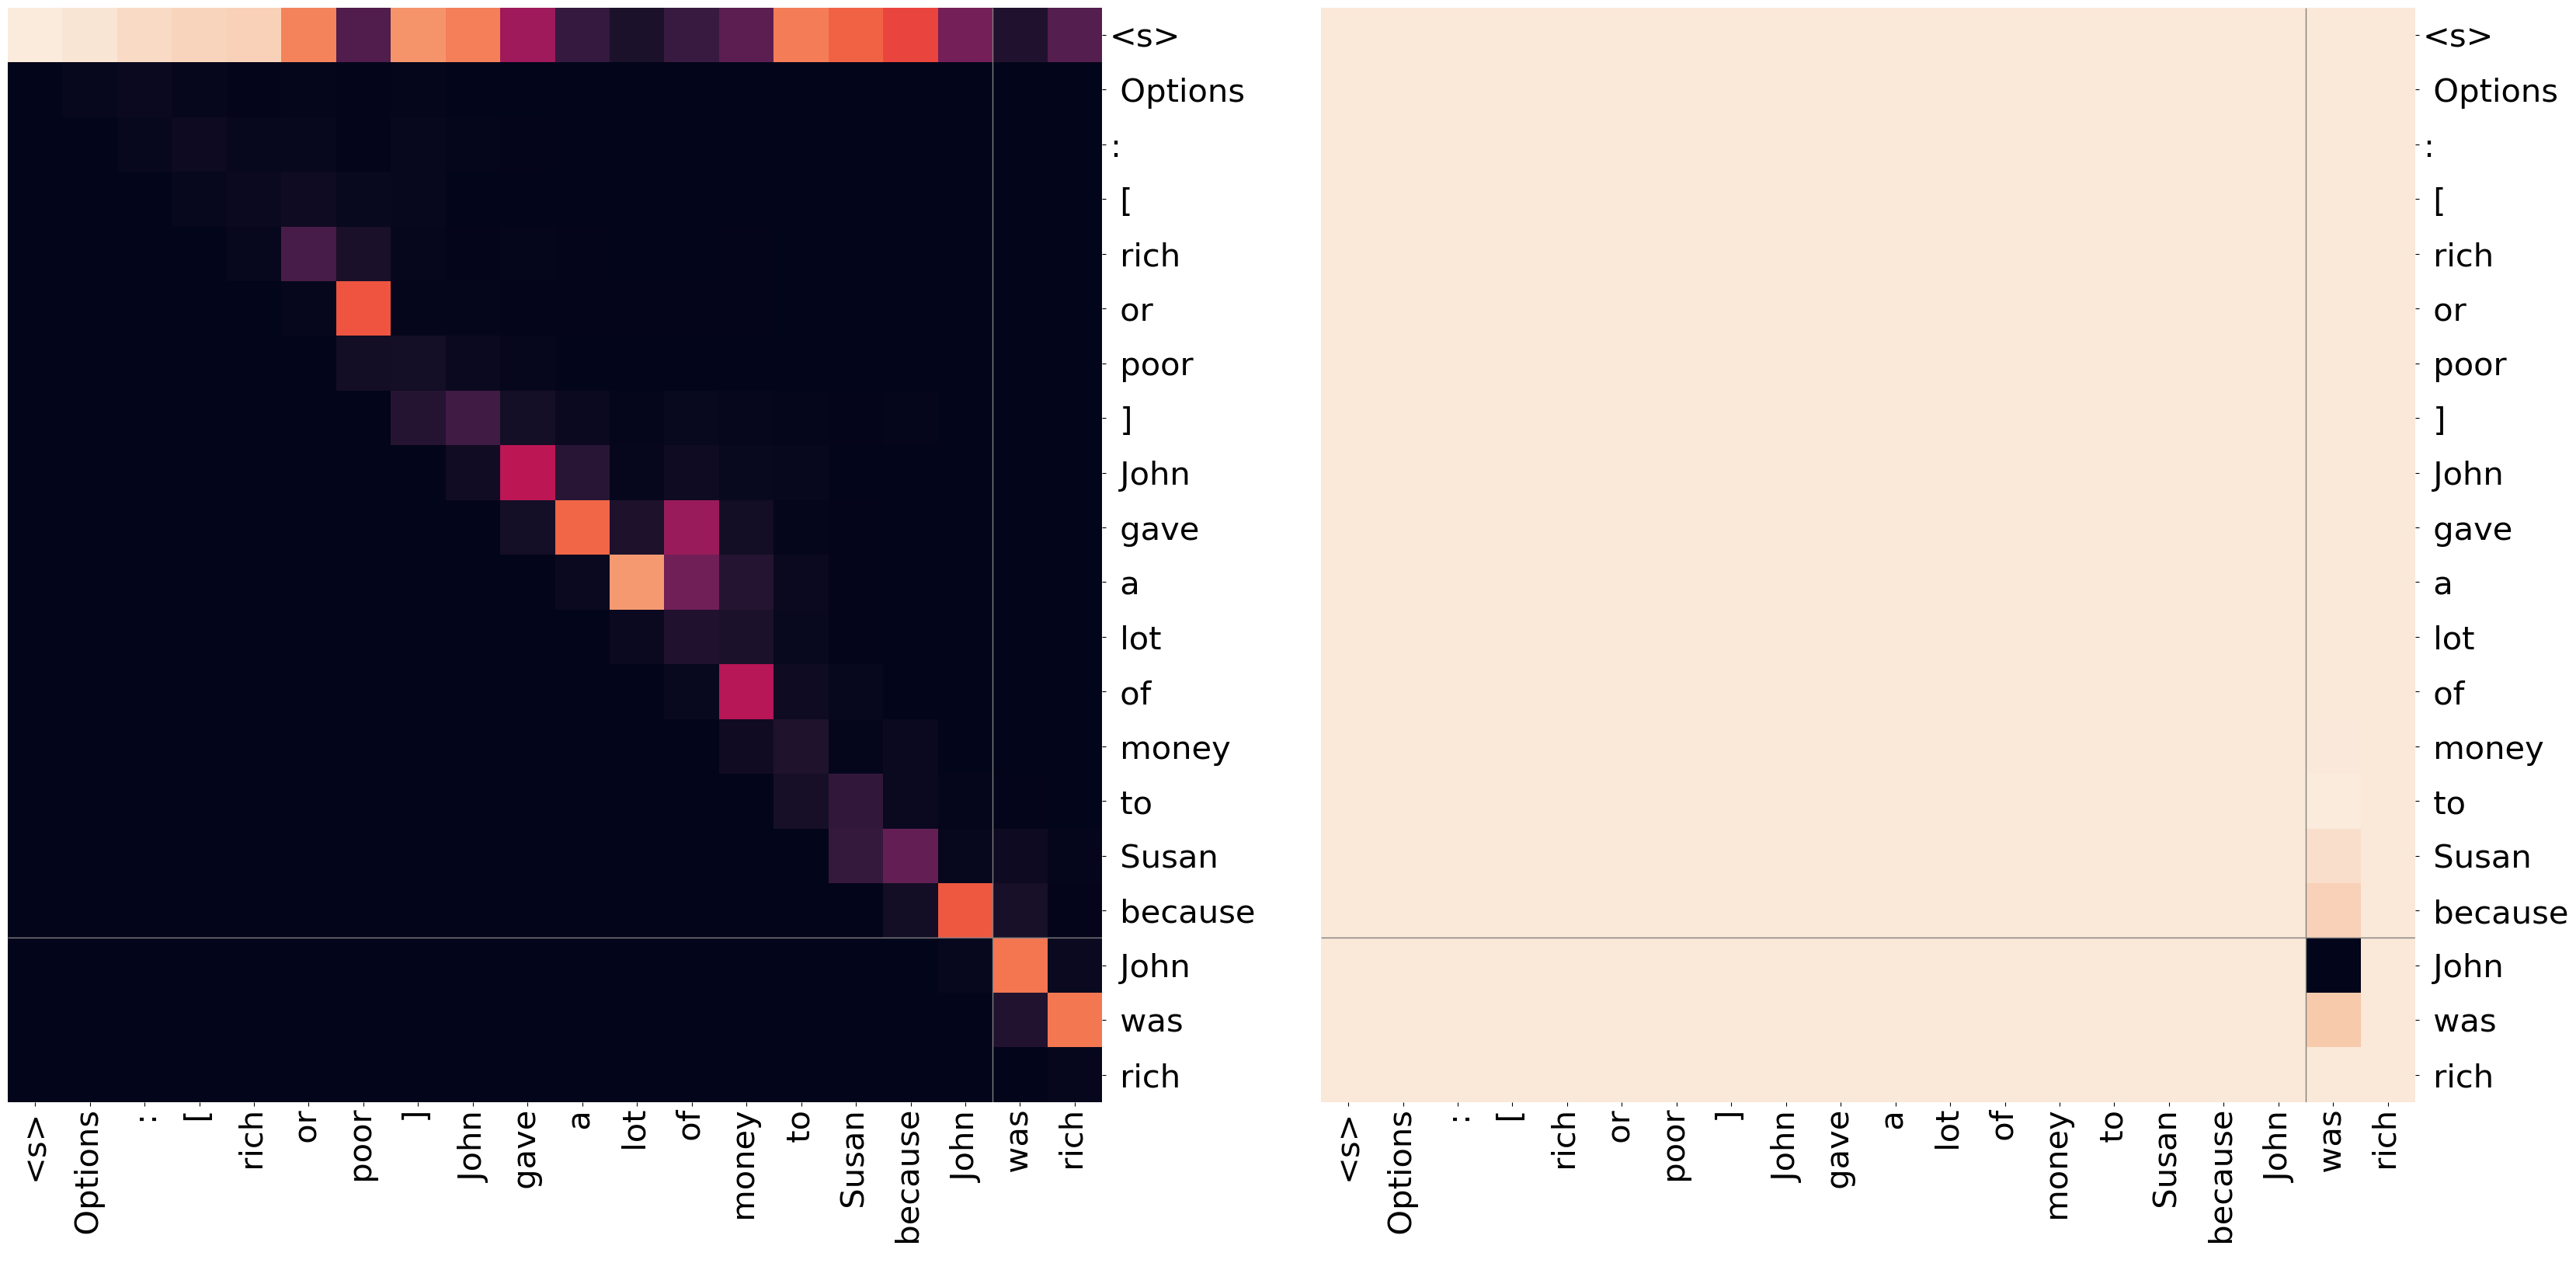

*▁poor 0.51 {'▁poor': 0.51, '▁rich': 0.49, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ rich or poor ] John gave a lot of money to Susan because Susan was poor *▁poor:0.041779 ▁rich:0.000353
ap_scores = tensor([0.8306]) tensor(0.8306)


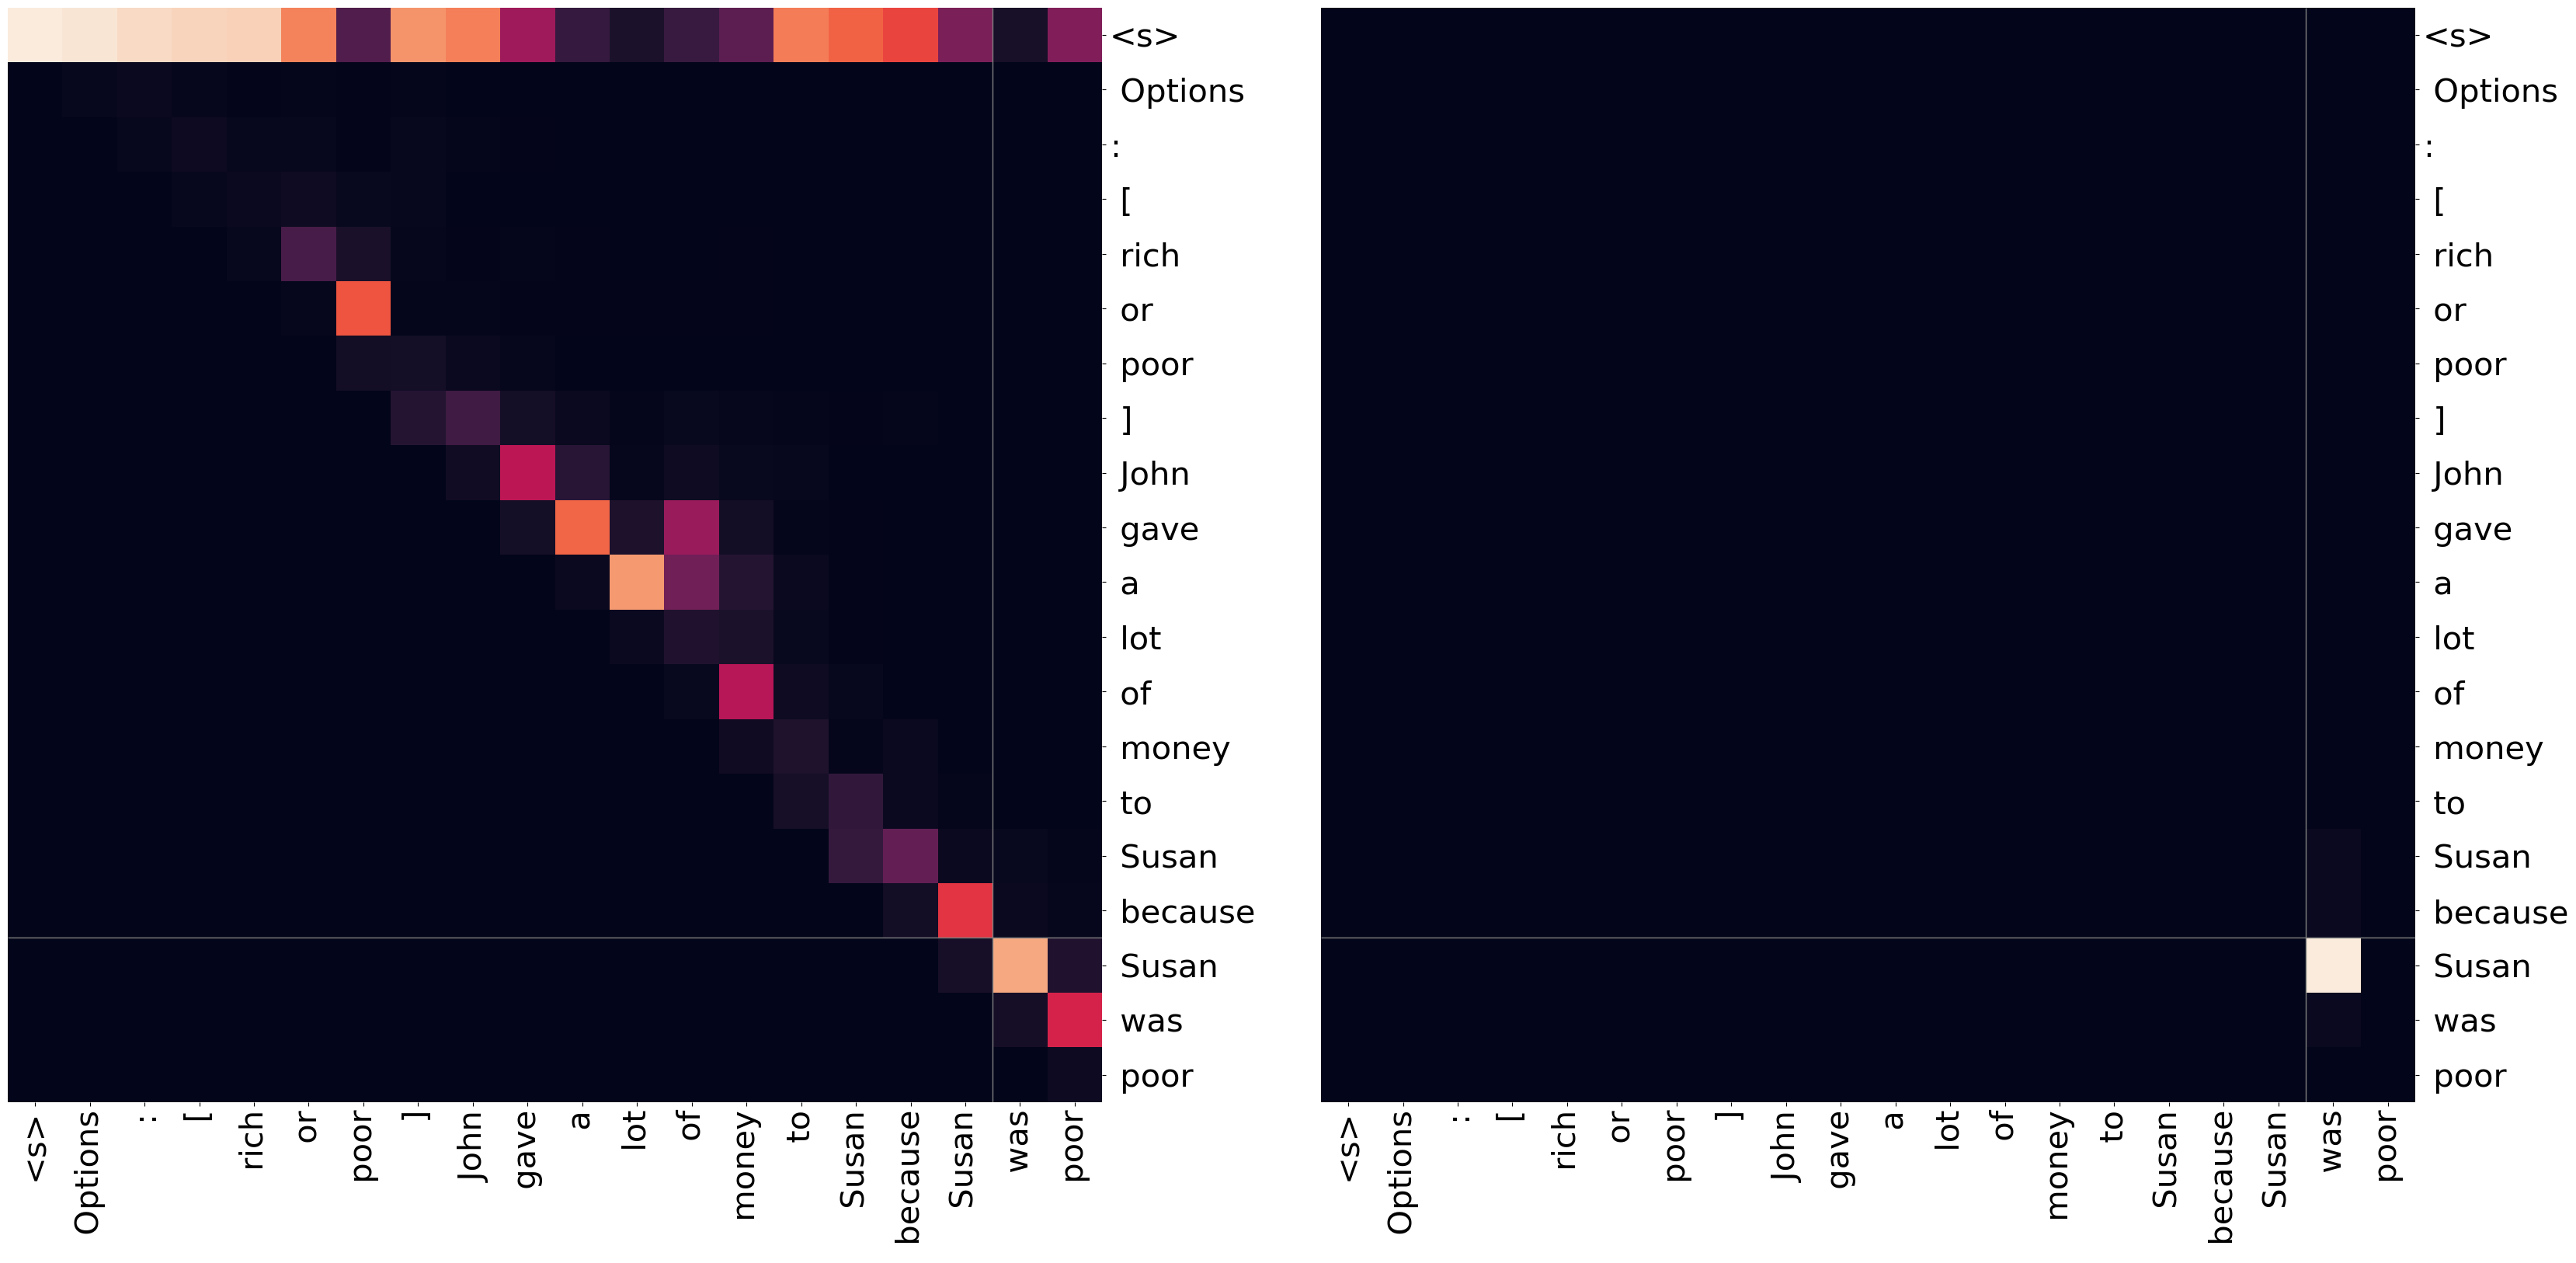

*▁fast 0.501 {'▁fast': 0.501, '▁slow': 0.499, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ fast or slow ] the truck overtook the bus because the truck was going fast ▁slow:0.008255 *▁fast:0.012154
ap_scores = tensor([0.1228]) tensor(0.1228)


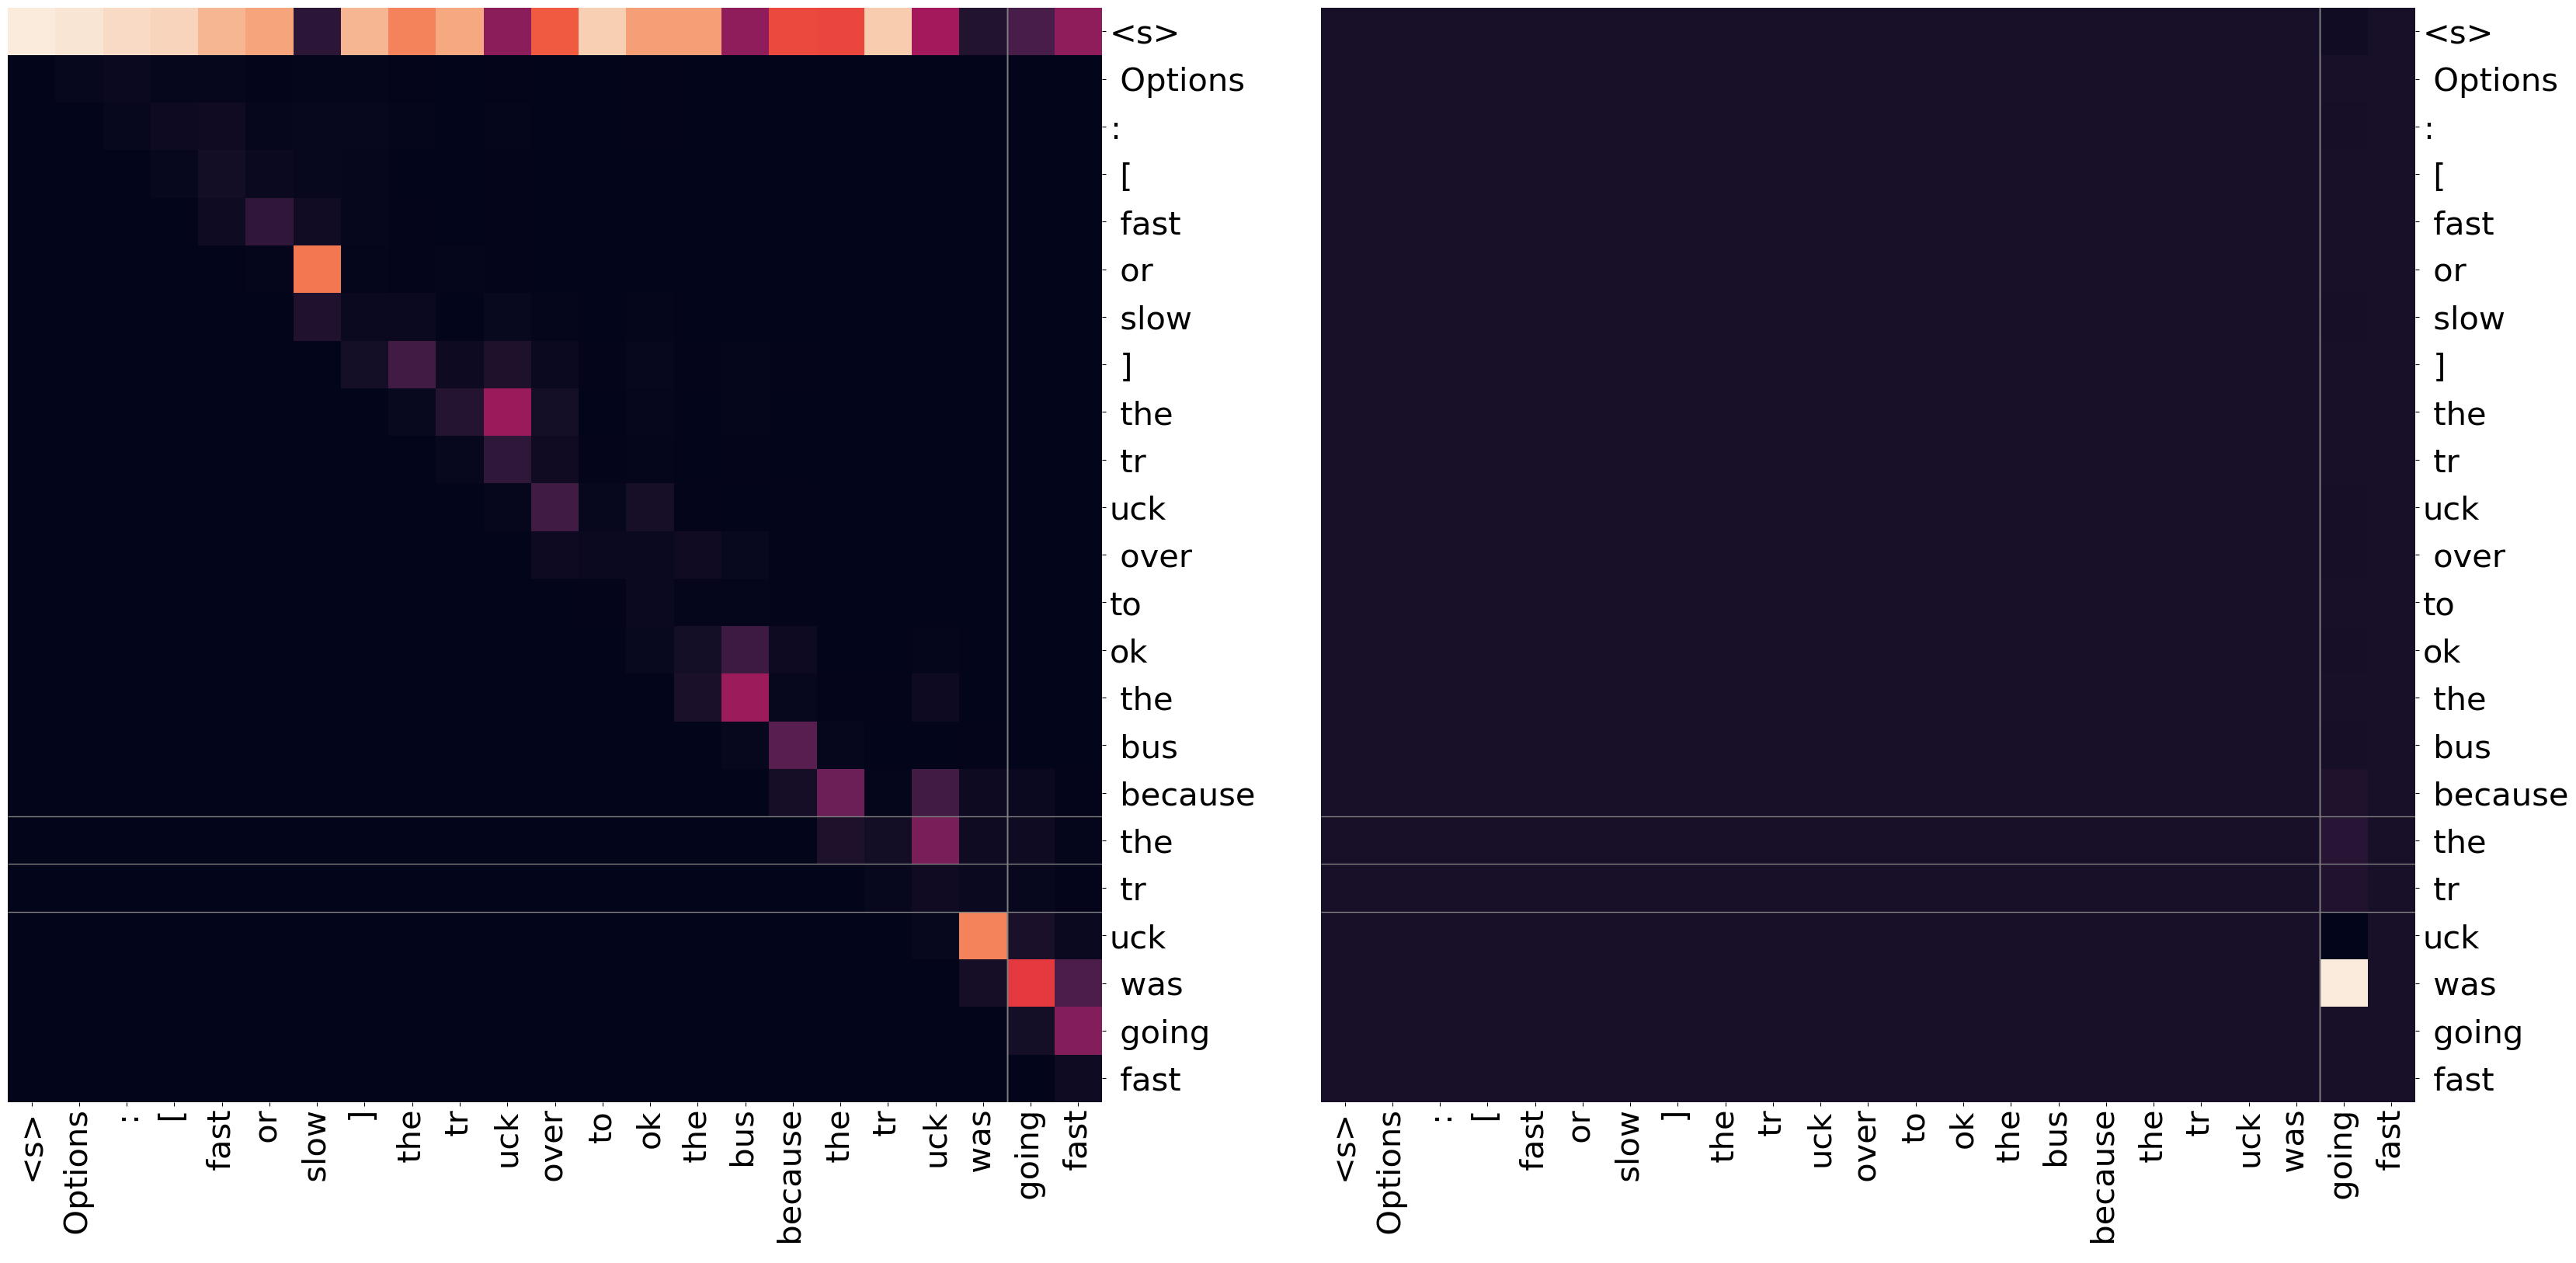

*▁slow 0.501 {'▁slow': 0.501, '▁fast': 0.499, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ fast or slow ] the truck overtook the bus because the bus was going slow *▁slow:0.007736 ▁fast:0.004200
ap_scores = tensor([0.1049]) tensor(0.1049)


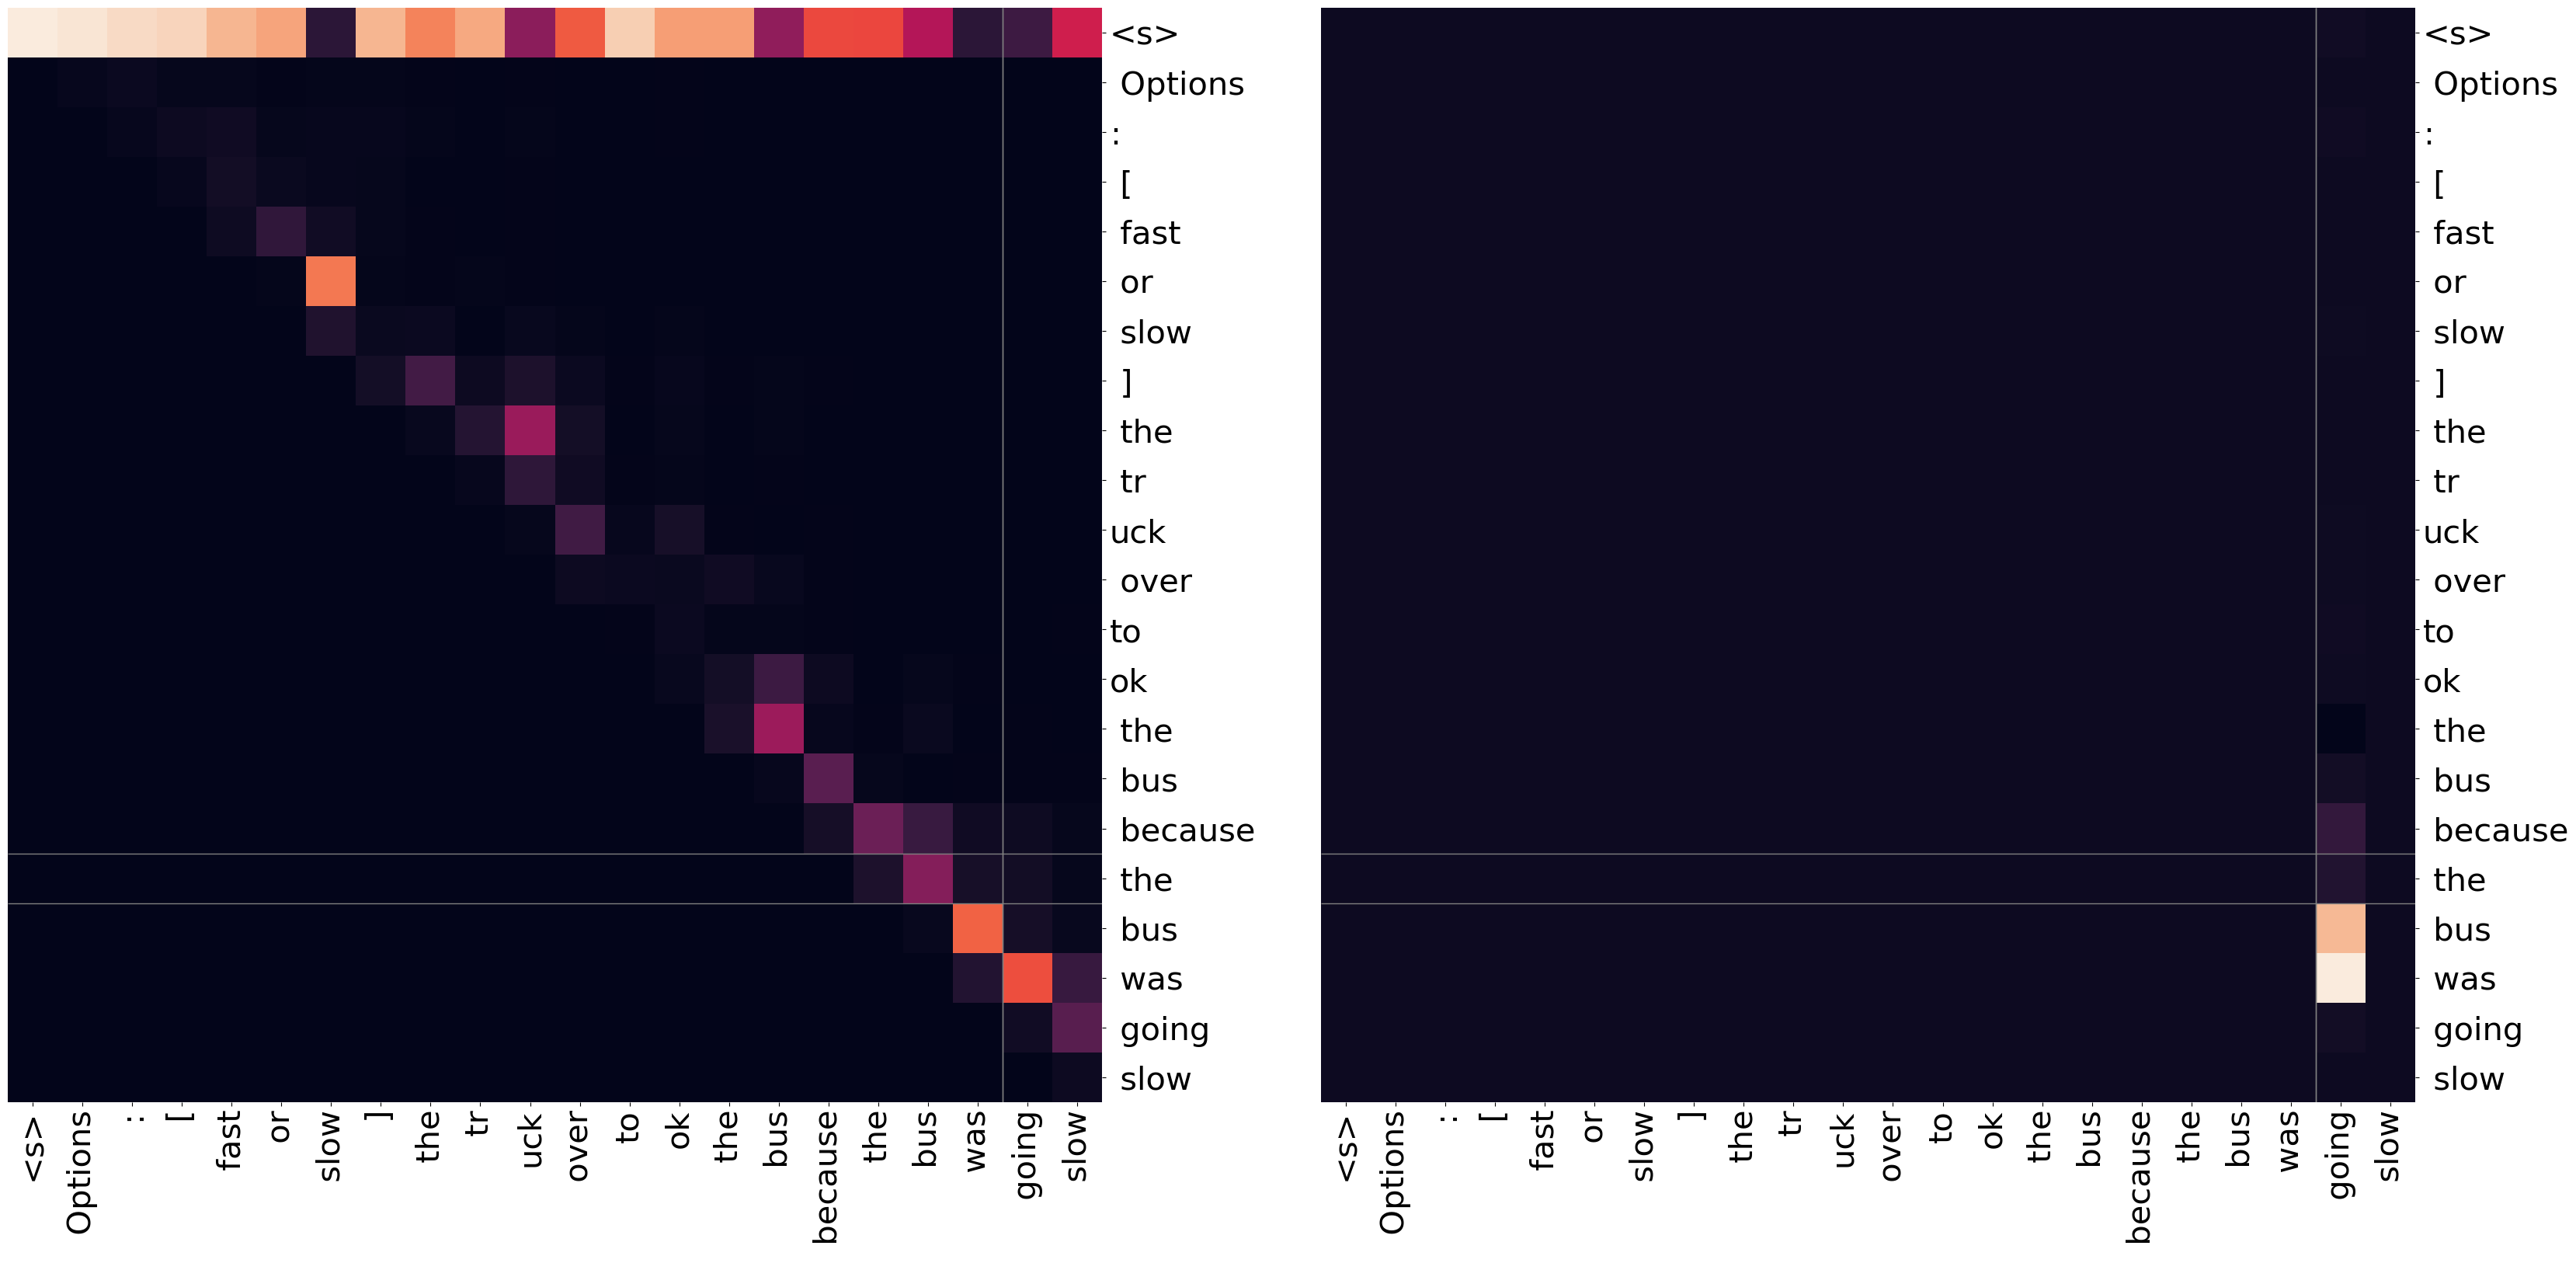

*▁hard 0.503 {'▁hard': 0.503, '▁soft': 0.497, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ hard or soft ] the ball crashed right through the board because the ball was hard *▁hard:0.009682 ▁soft:-0.002974
ap_scores = tensor([0.7419]) tensor(0.7419)


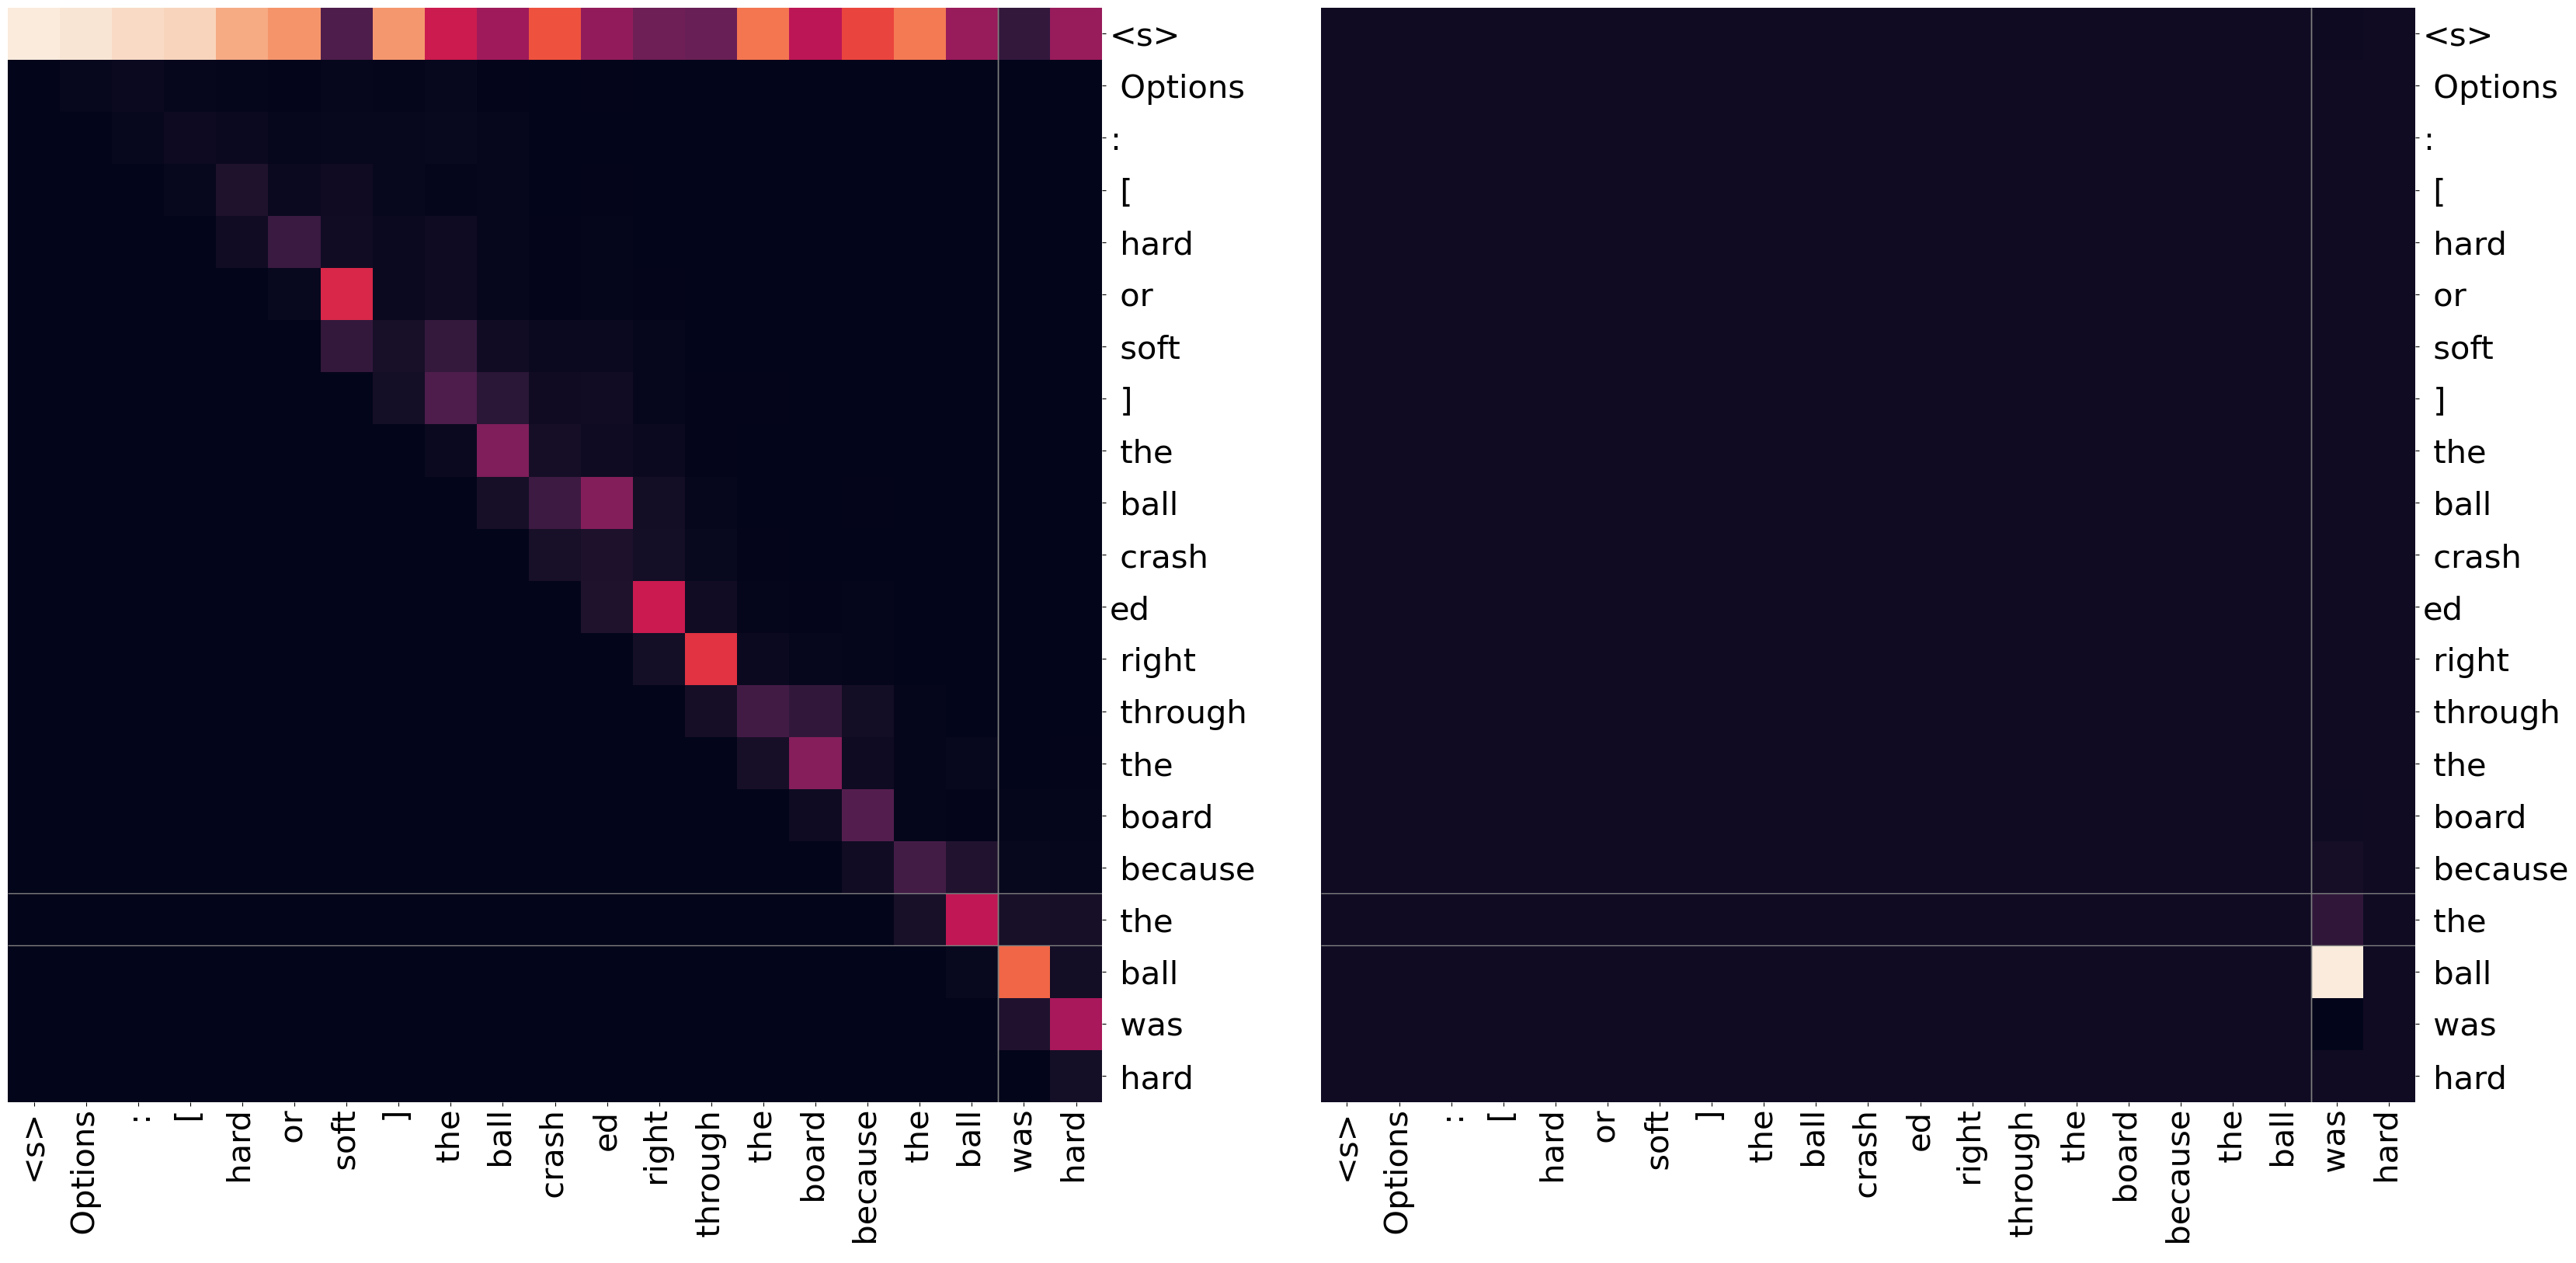

 ▁soft 0.5 {'▁hard': 0.5, '▁soft': 0.5, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ soft or hard ] the ball crashed right through the board because the board was soft ▁hard:0.007778 *▁soft:0.005672
ap_scores = tensor([0.7541]) tensor(0.7541)


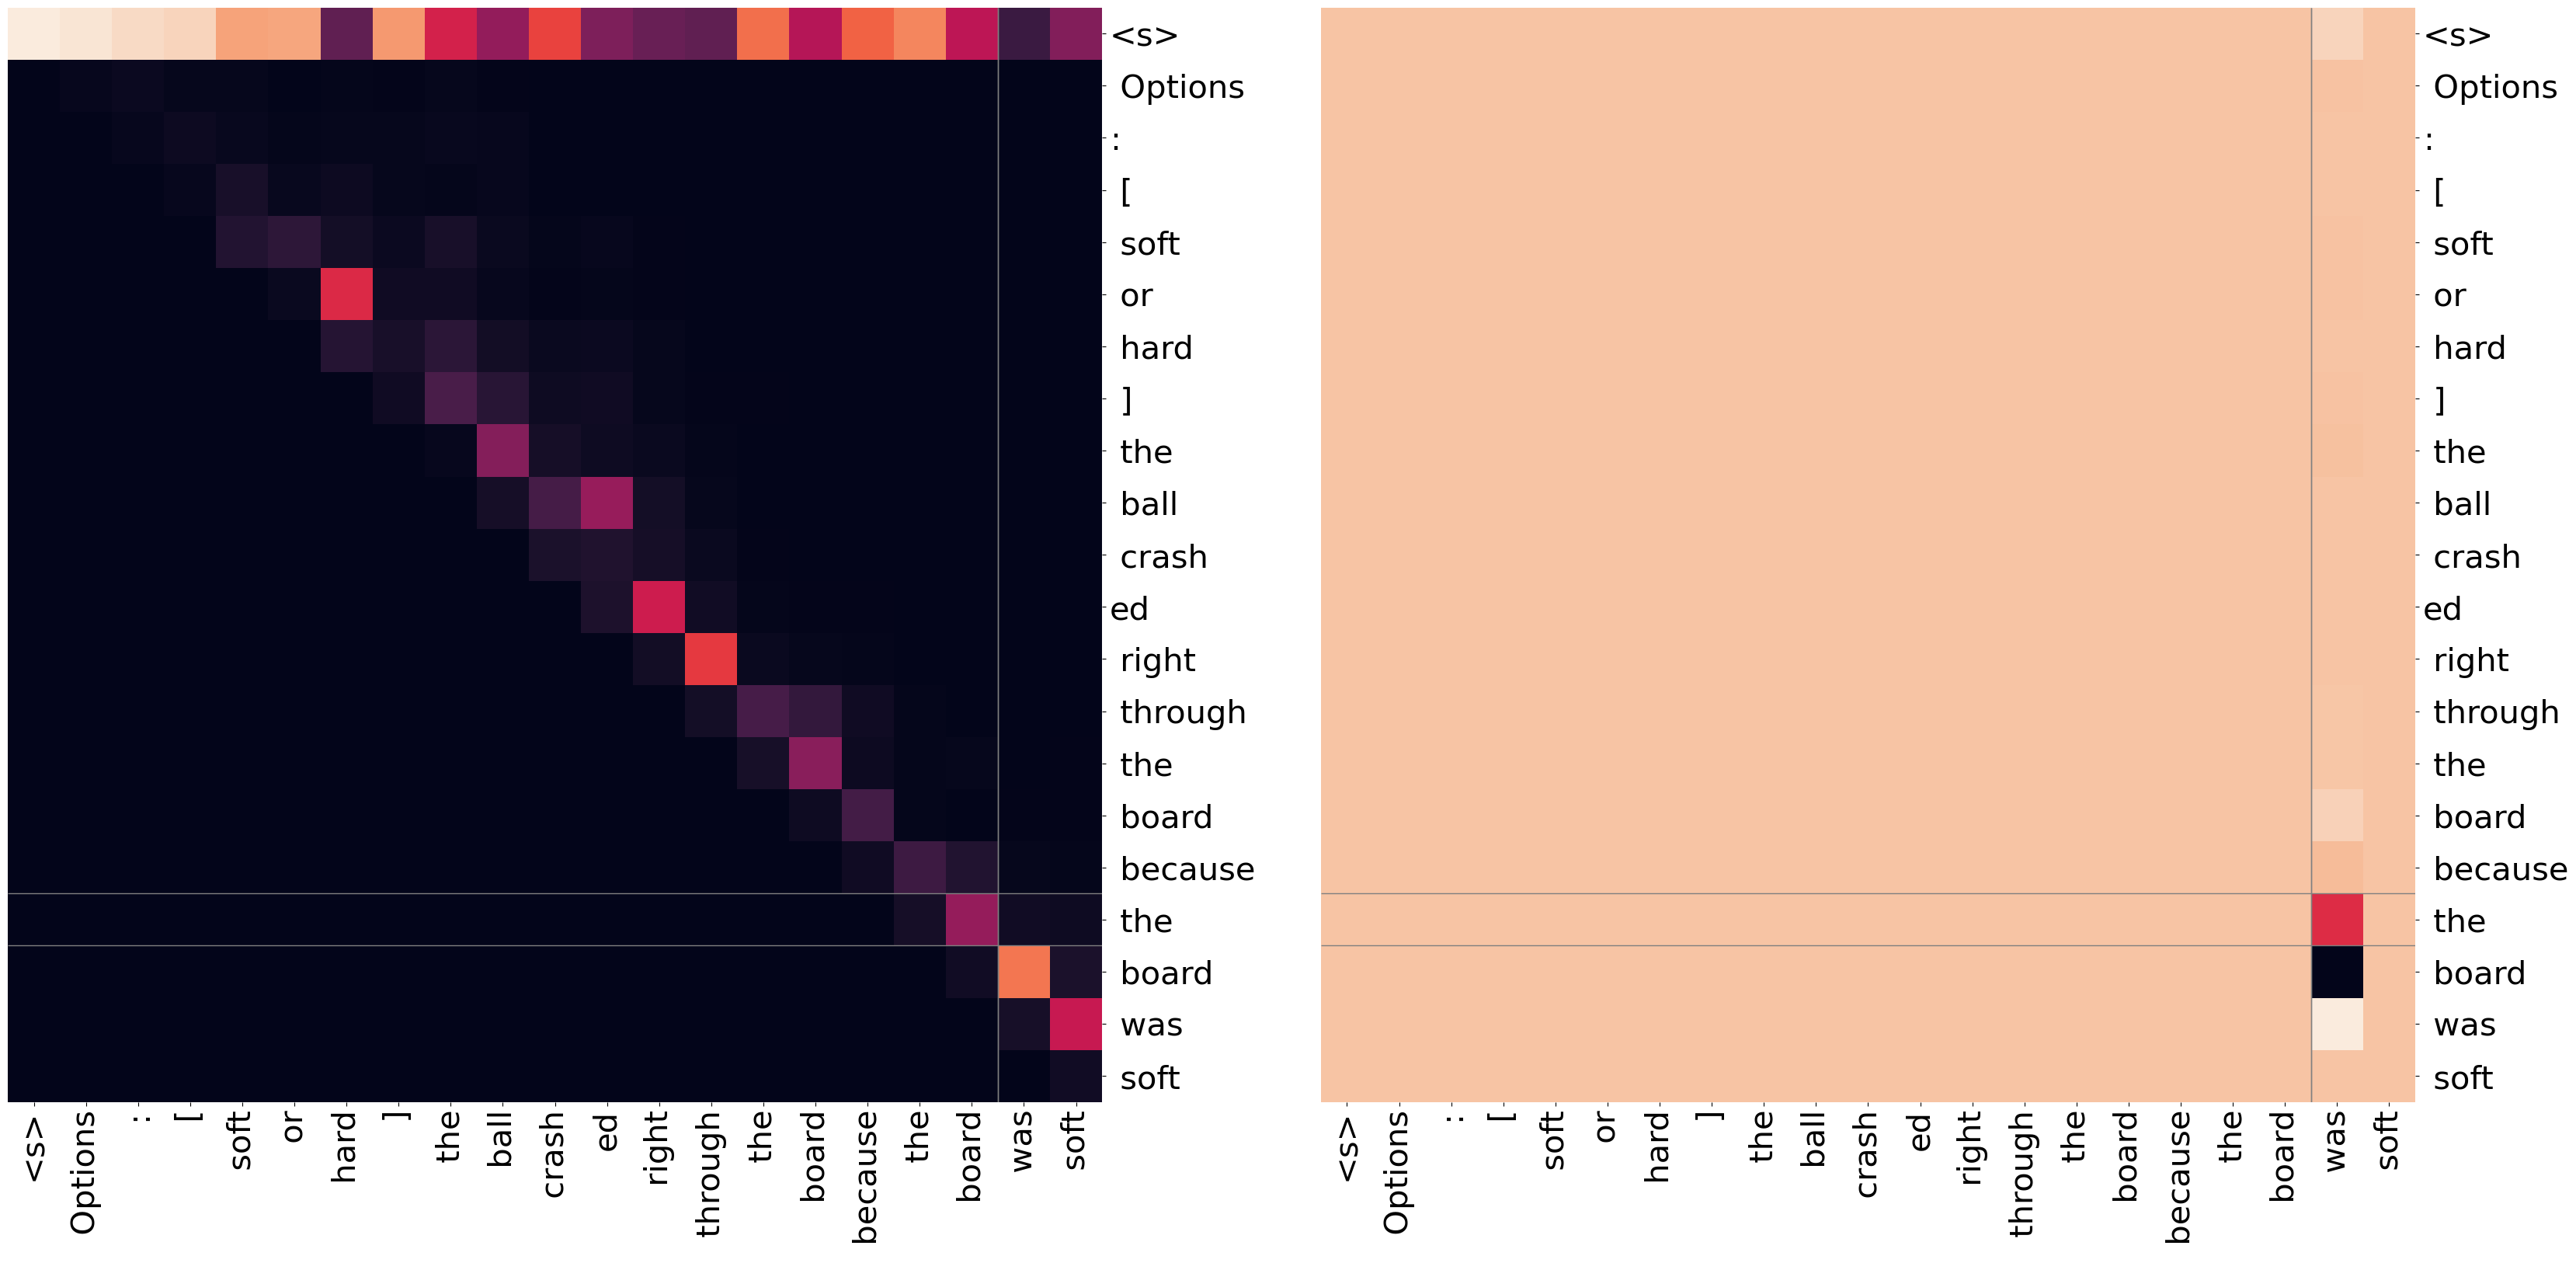

 ▁short 0.5 {'▁tall': 0.5, '▁short': 0.5, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ tall or short ] John couldn't see the stage behind Susan because John is short *▁short:-0.003386 ▁tall:-0.001242
ap_scores = tensor([0.5181]) tensor(0.5181)


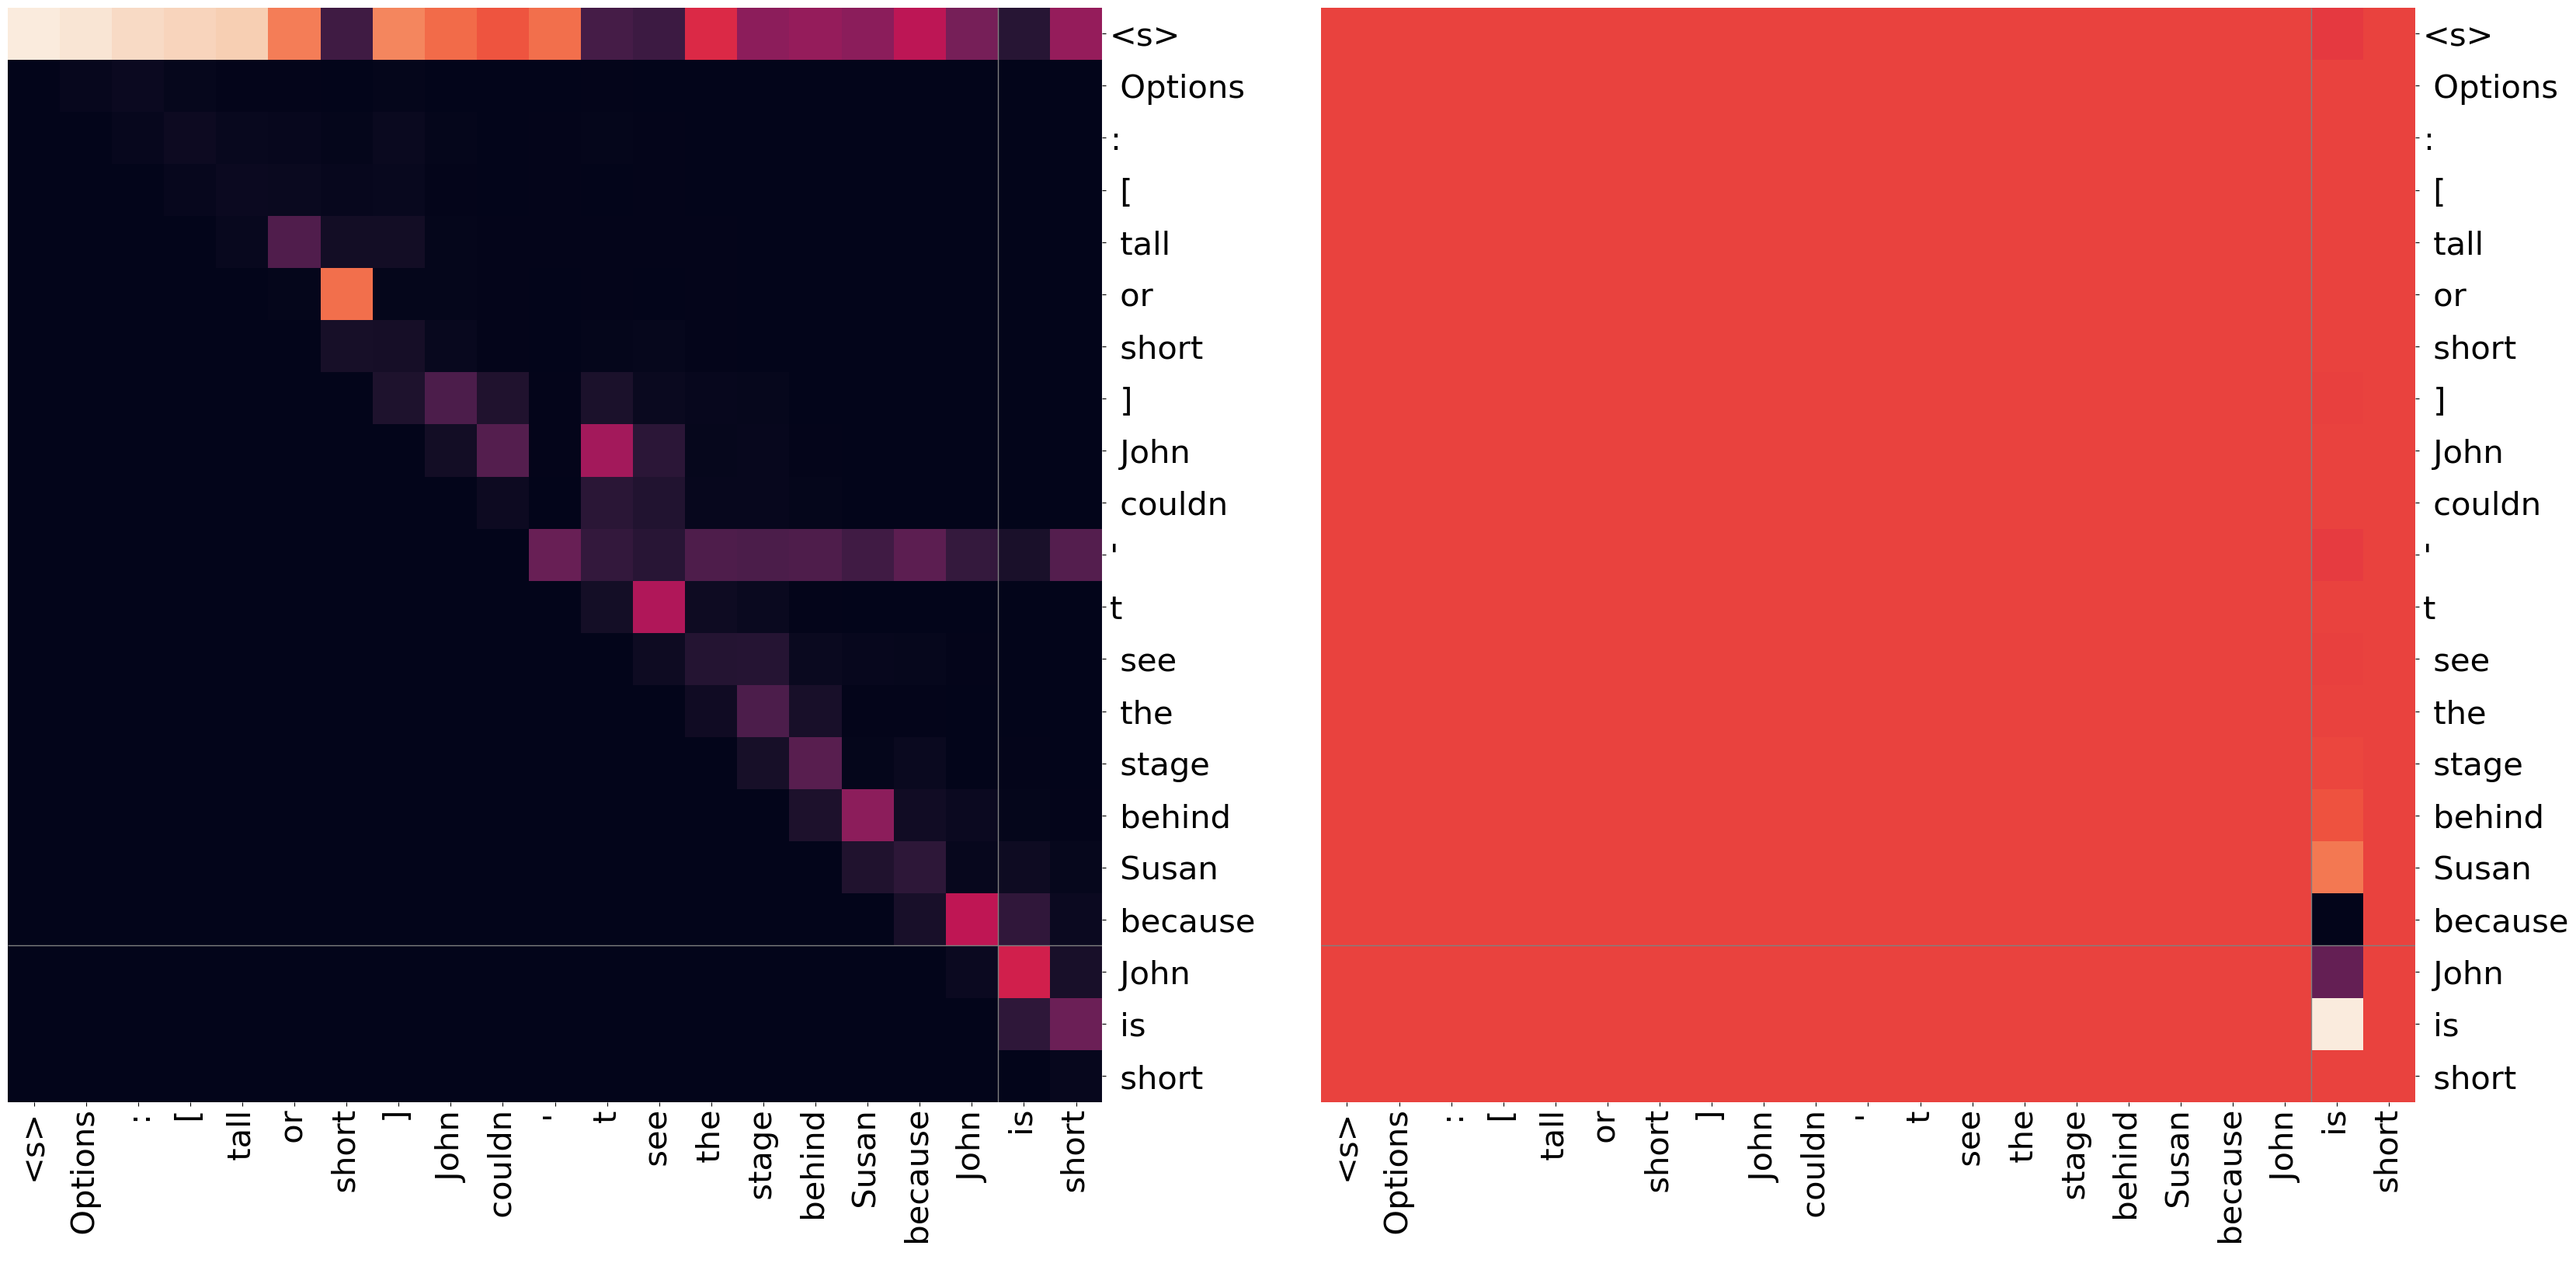

*▁tall 0.501 {'▁tall': 0.501, '▁short': 0.499, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ short or tall ] John couldn't see the stage behind Susan because Susan is tall ▁short:-0.004688 *▁tall:-0.000036
ap_scores = tensor([0.3936]) tensor(0.3936)


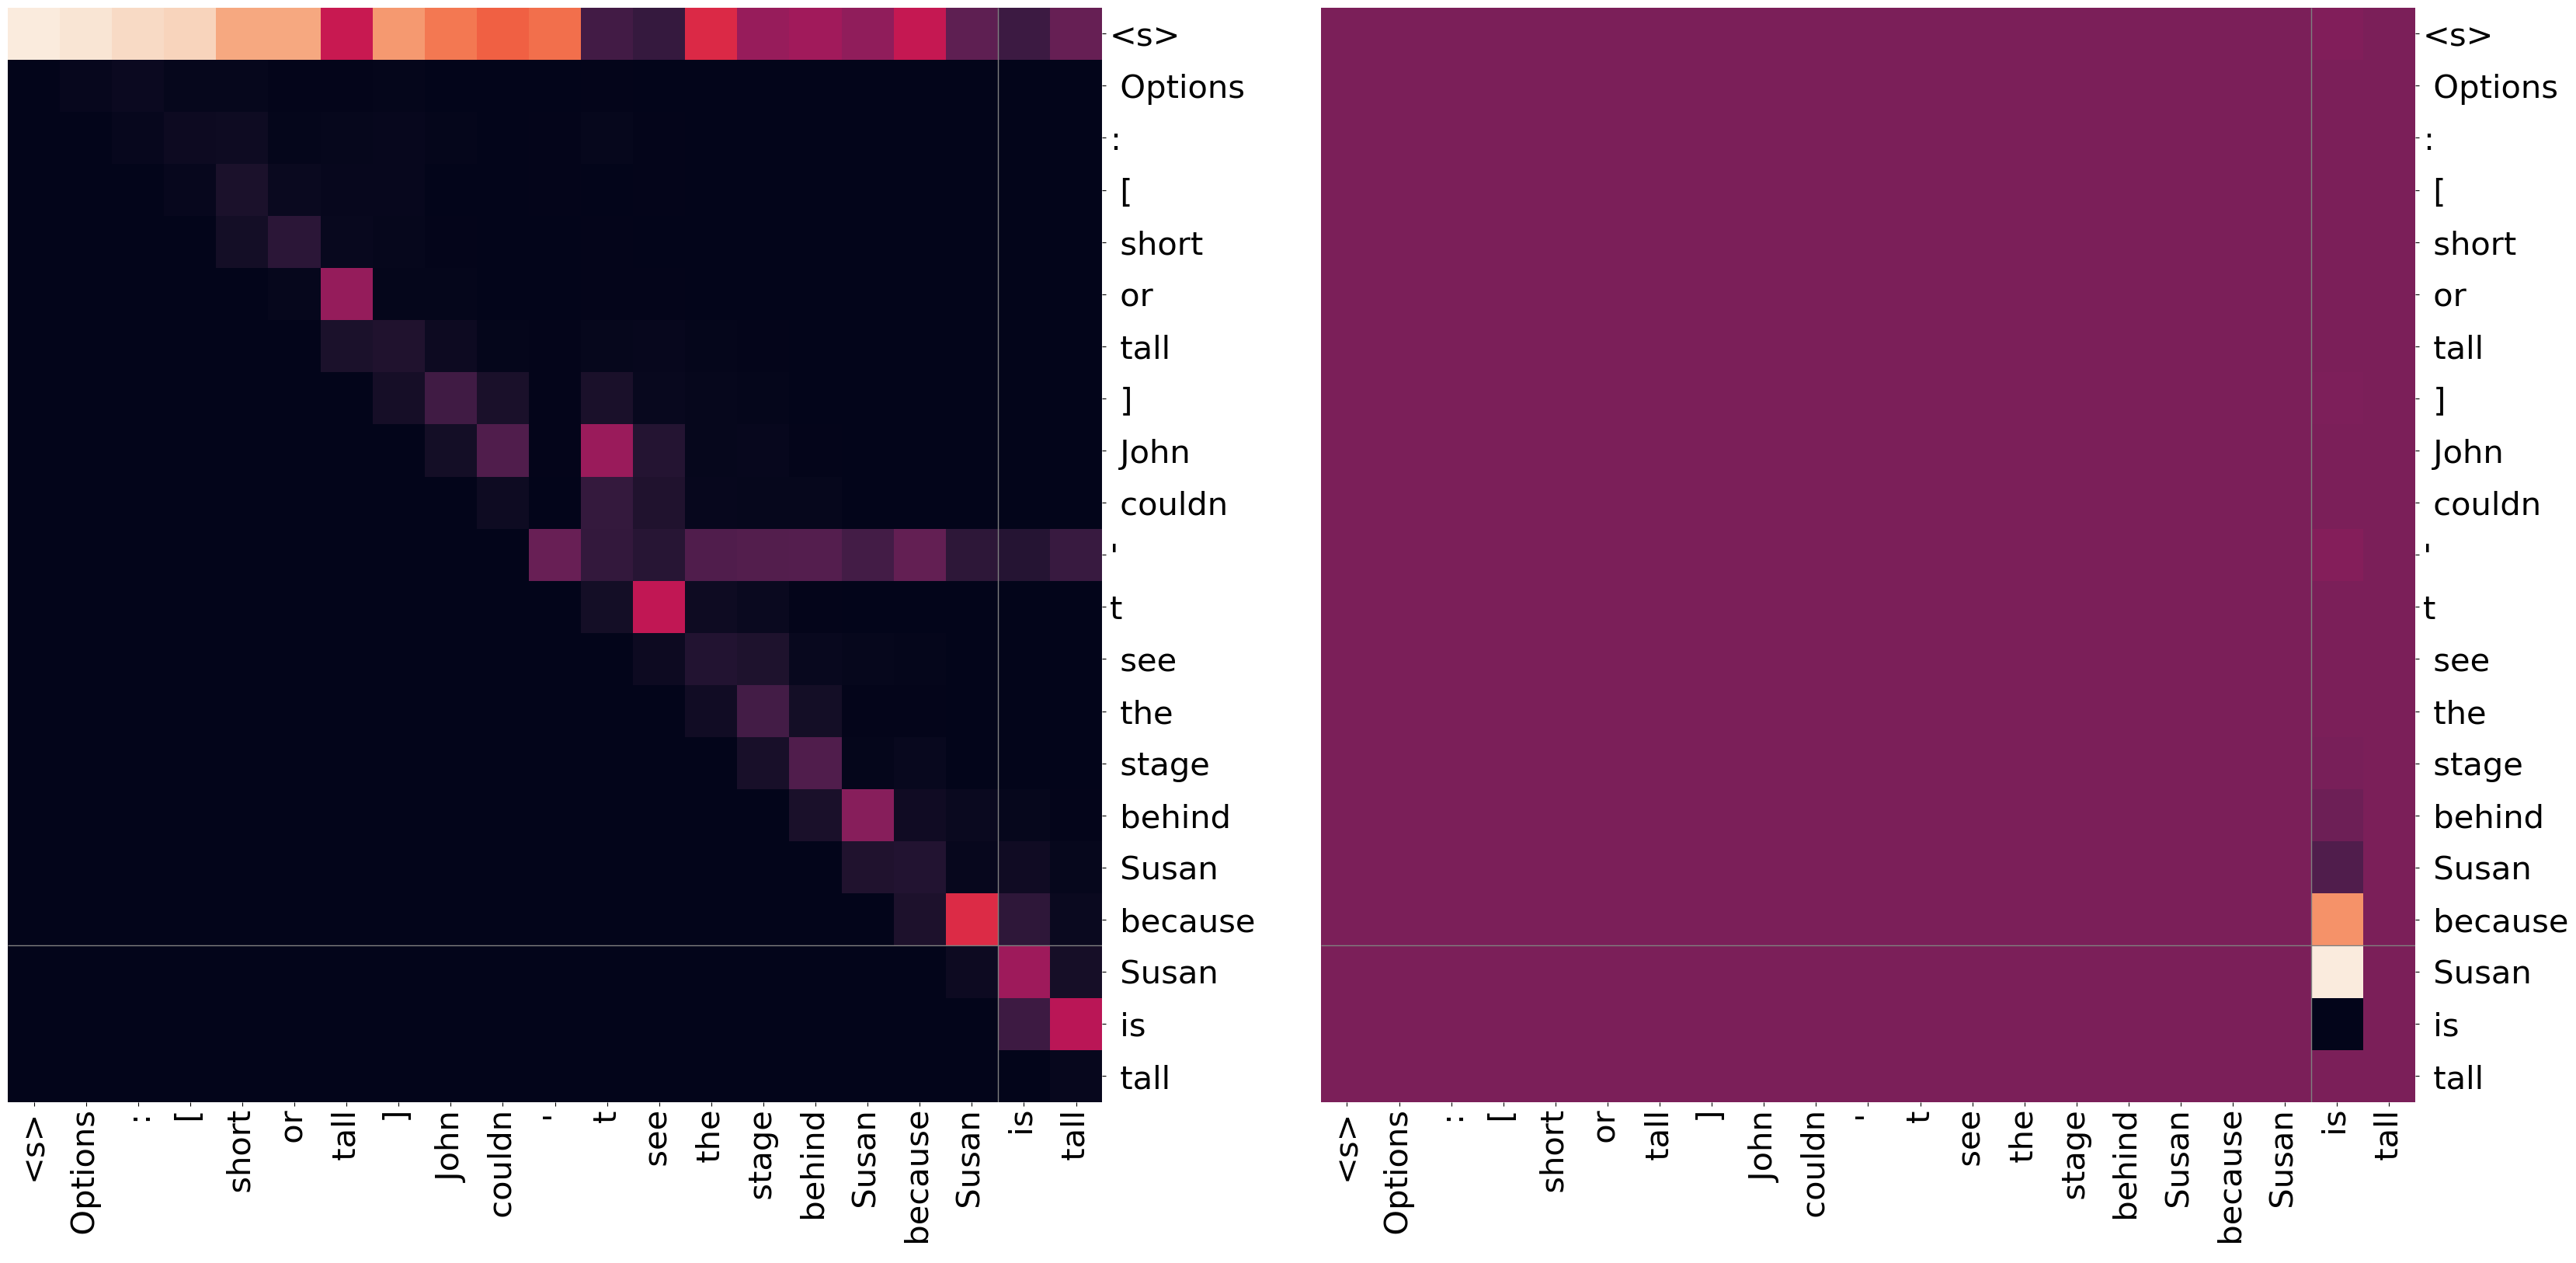

*▁first 0.501 {'▁first': 0.502, '▁later': 0.498, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ later or first ] the bag of potatoes had been placed above the bag of flour so the bag of potatoes had to be moved first *▁first:0.008667 ▁later:0.001966
ap_scores = tensor([0.0591]) tensor(0.0591)


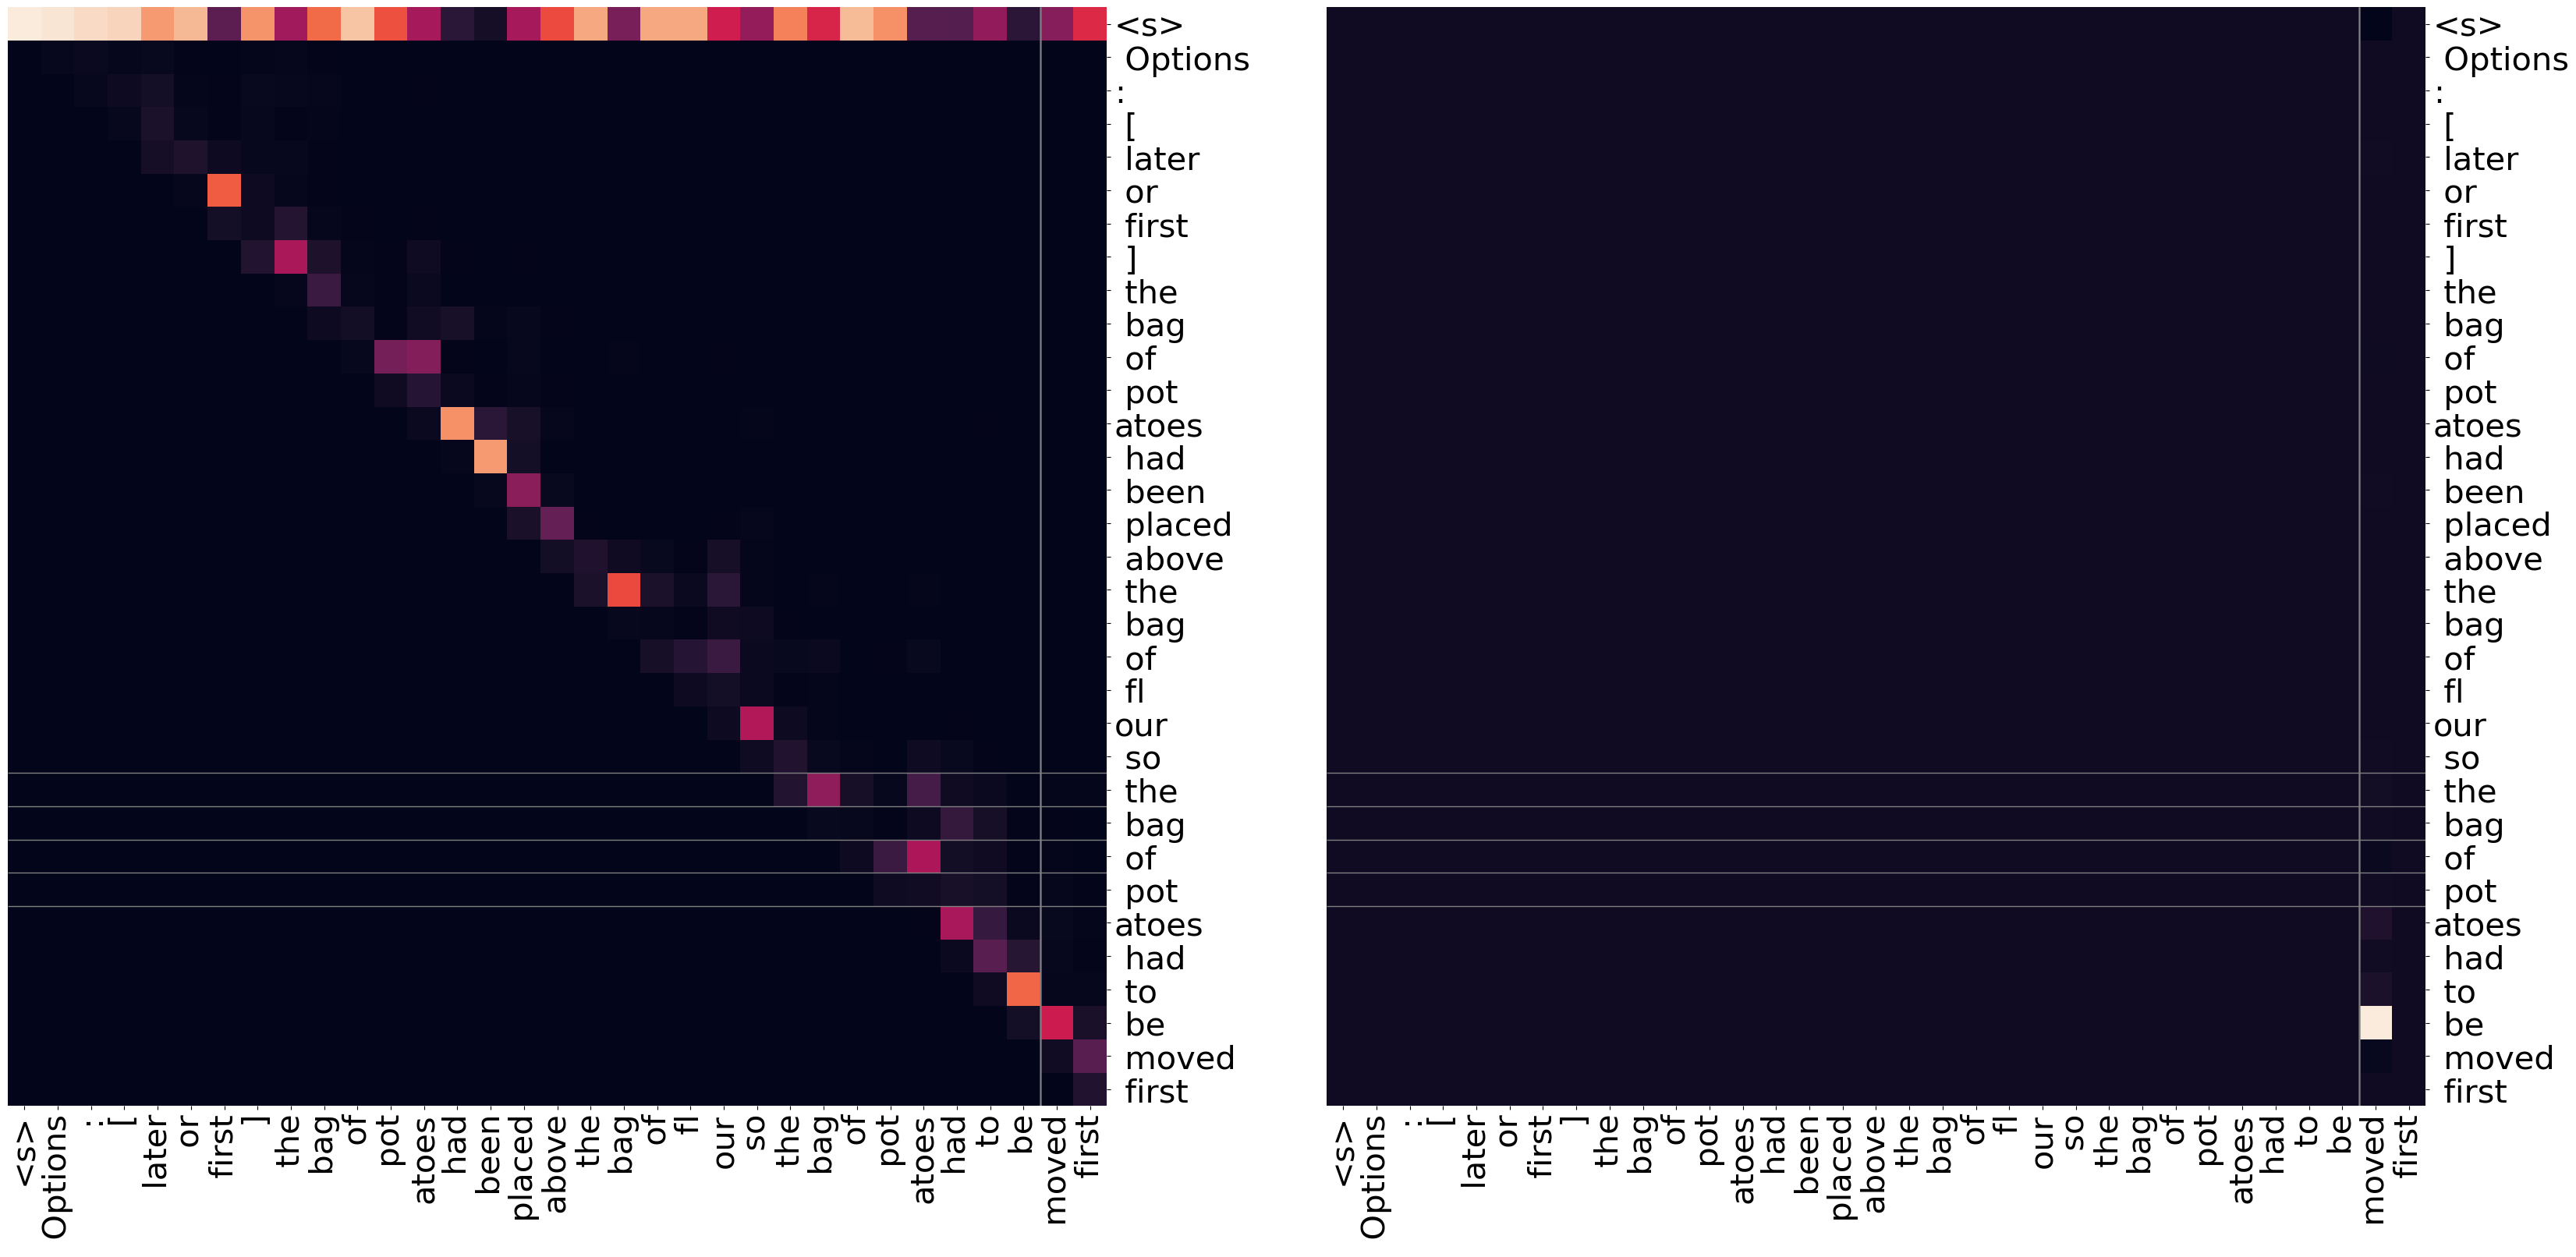

 ▁later 0.5 {'▁first': 0.5, '▁later': 0.5, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ first or later ] the bag of potatoes had been placed above the bag of flour so the bag of flour had to be moved later ▁first:0.002415 *▁later:0.000607
ap_scores = tensor([0.0673]) tensor(0.0673)


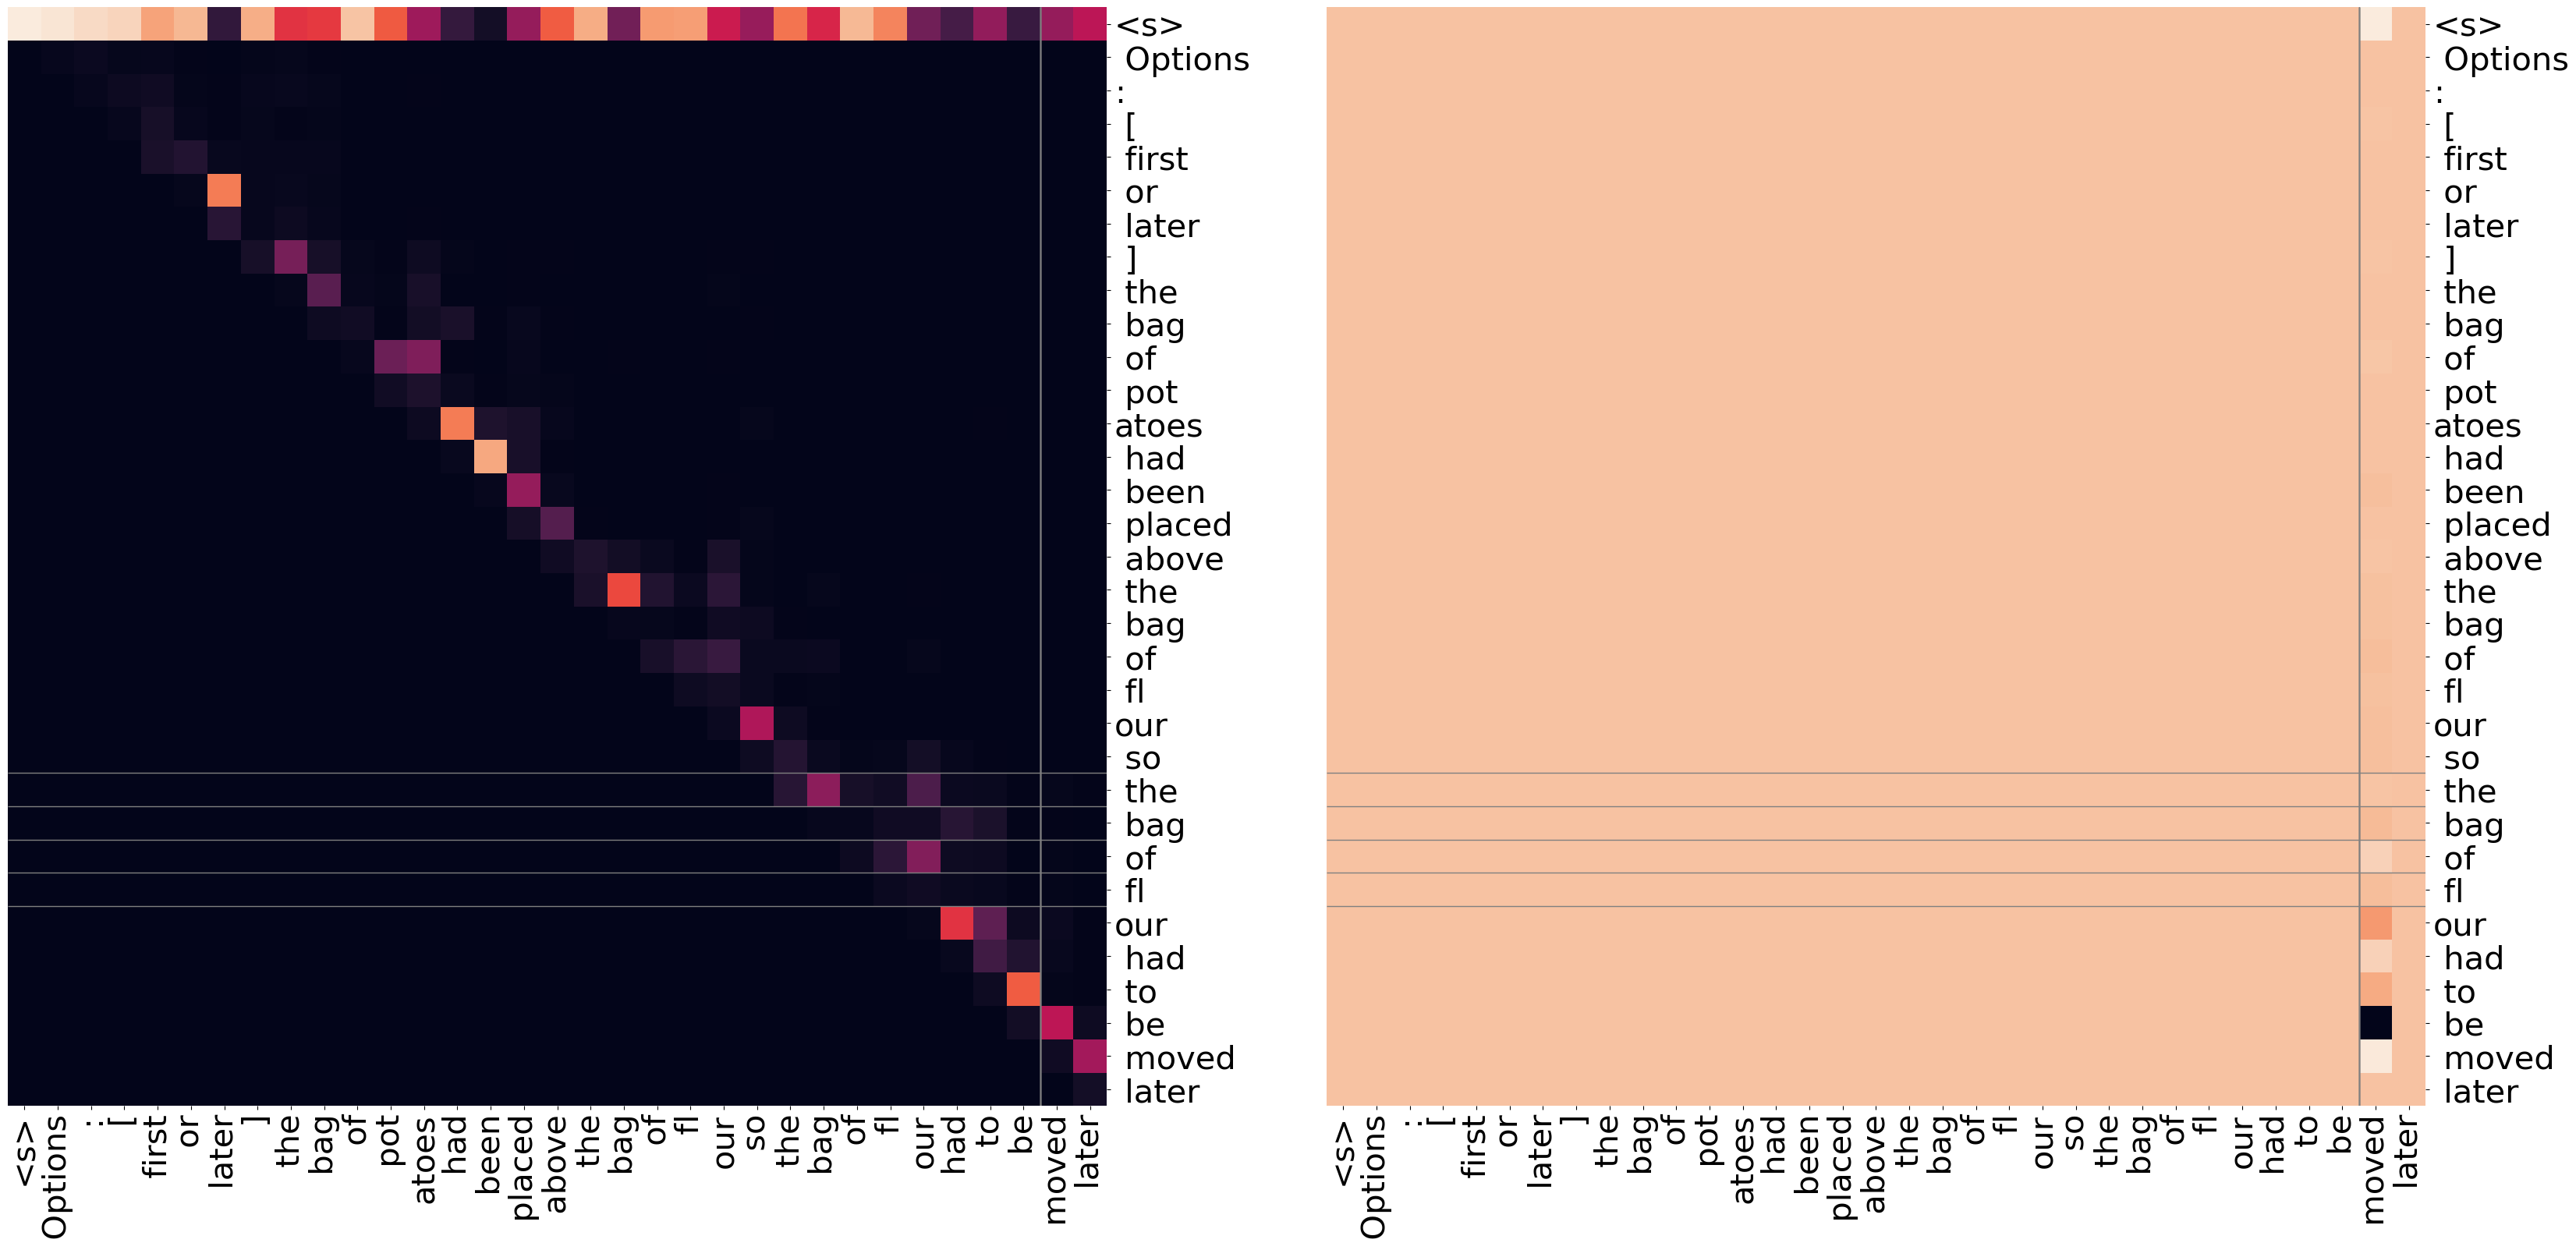

*▁empty 0.502 {'▁empty': 0.502, '▁full': 0.498, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ full or empty ] the bottle was filled with water from the cup after the bottle was empty *▁empty:0.008507 ▁full:-0.000256
ap_scores = tensor([0.6453]) tensor(0.6453)


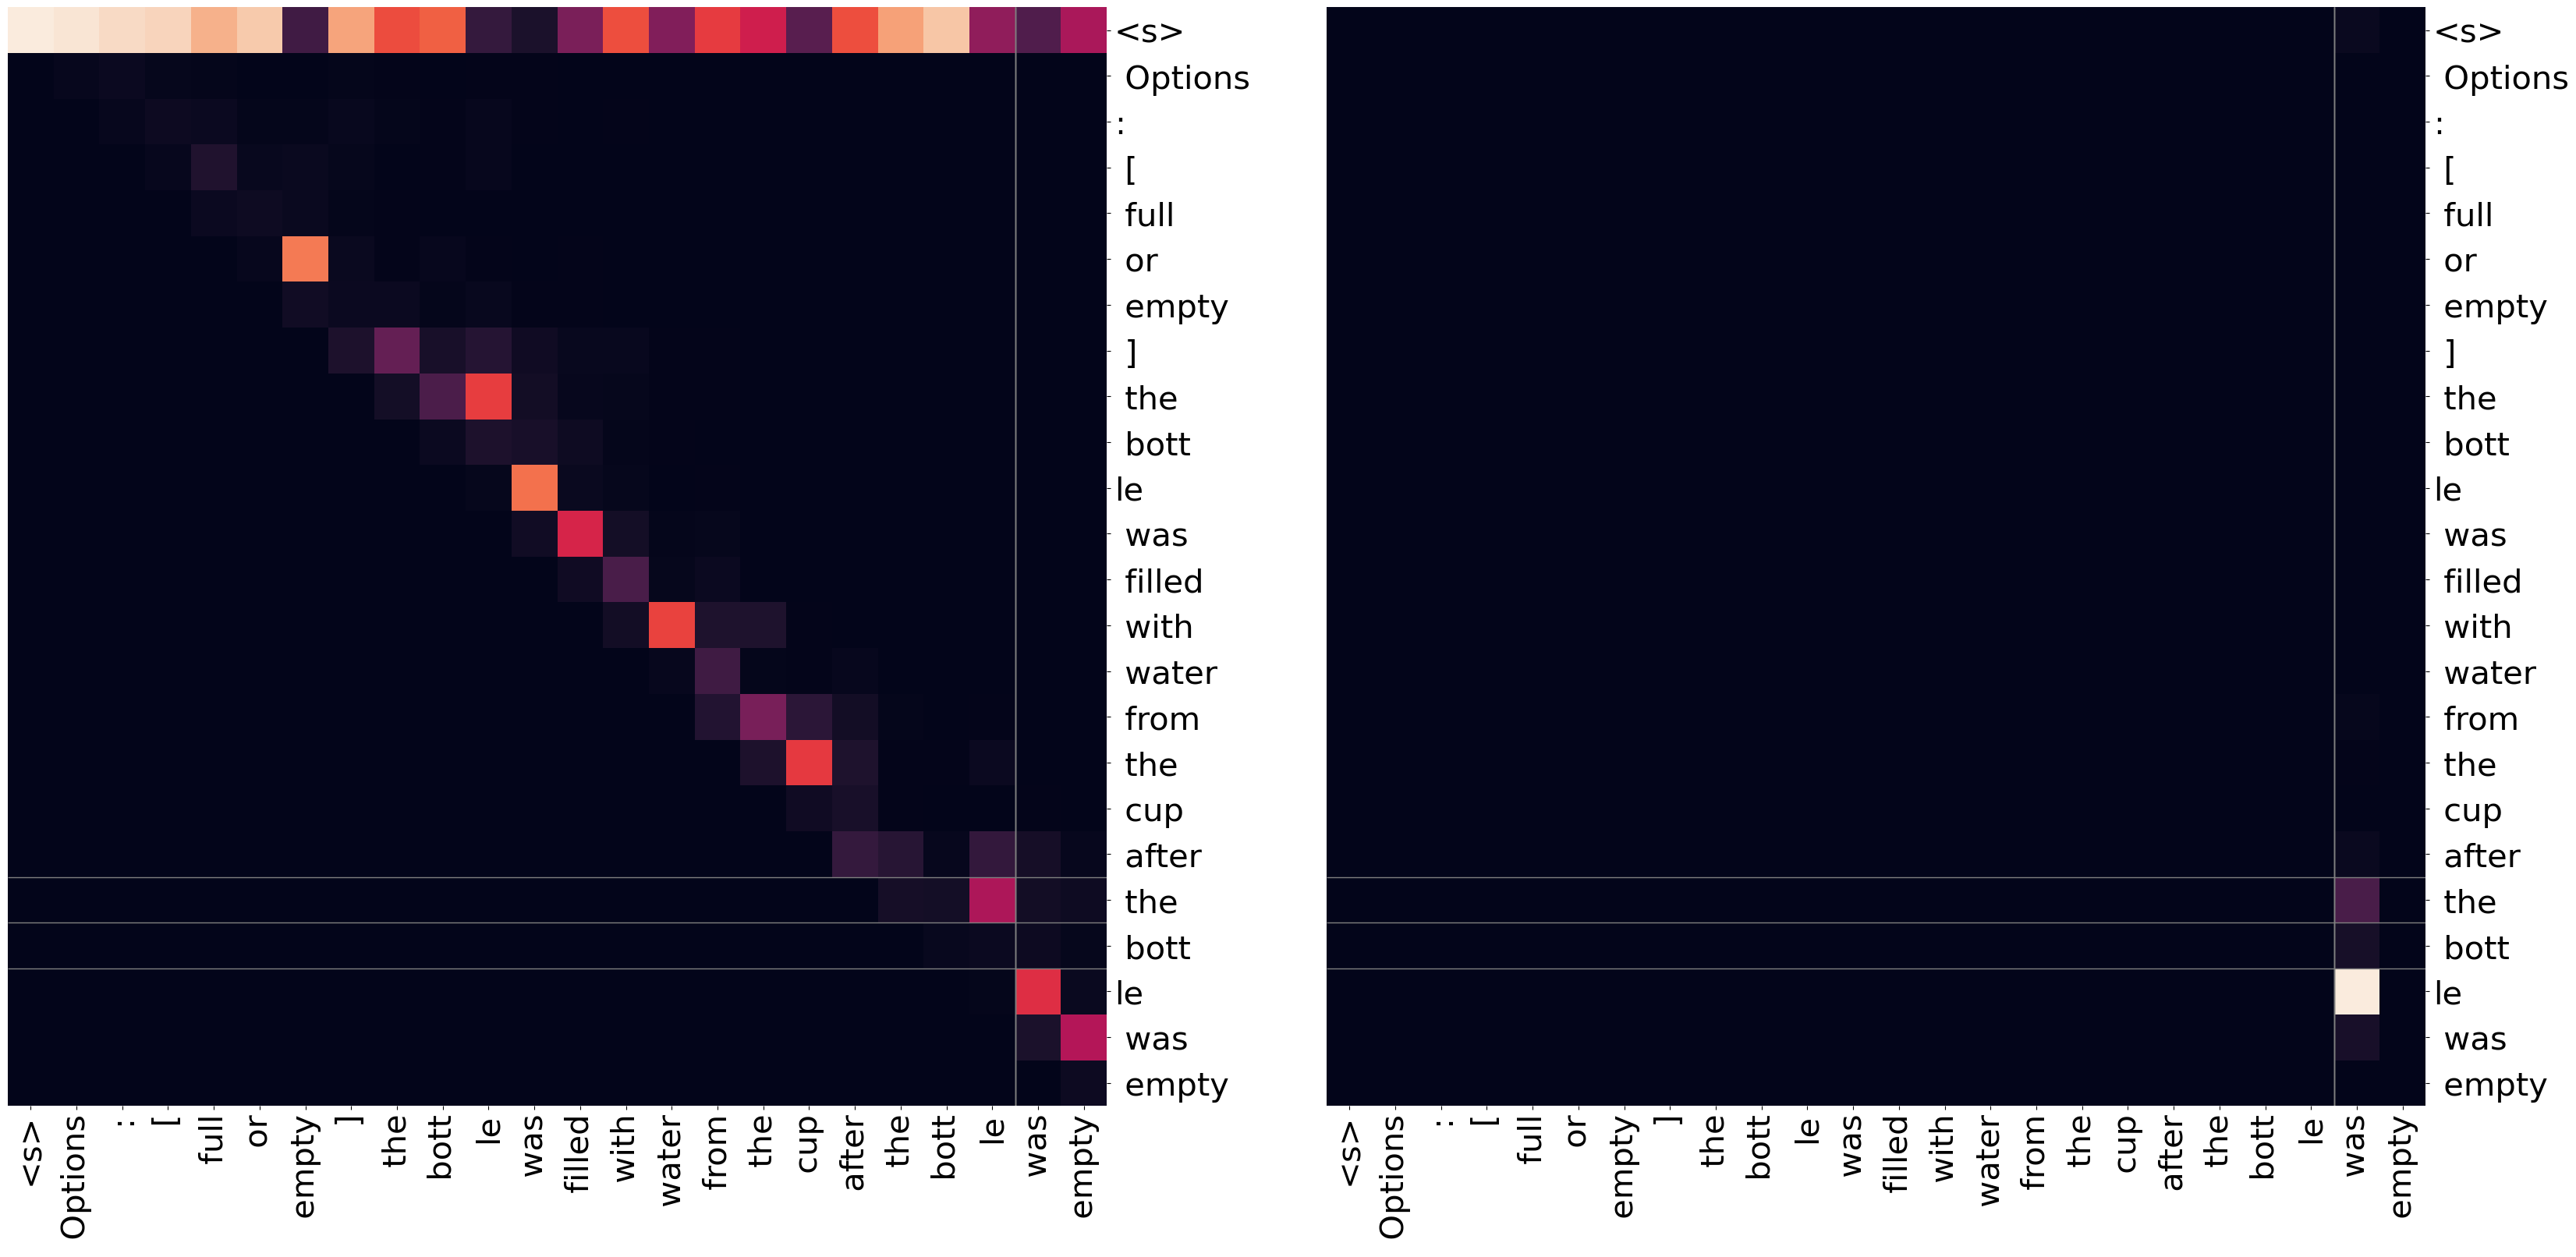

*▁full 0.5 {'▁empty': 0.5, '▁full': 0.5, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ empty or full ] the bottle was filled with water from the cup after the cup was full ▁empty:0.003967 *▁full:0.004383
ap_scores = tensor([0.5782]) tensor(0.5782)


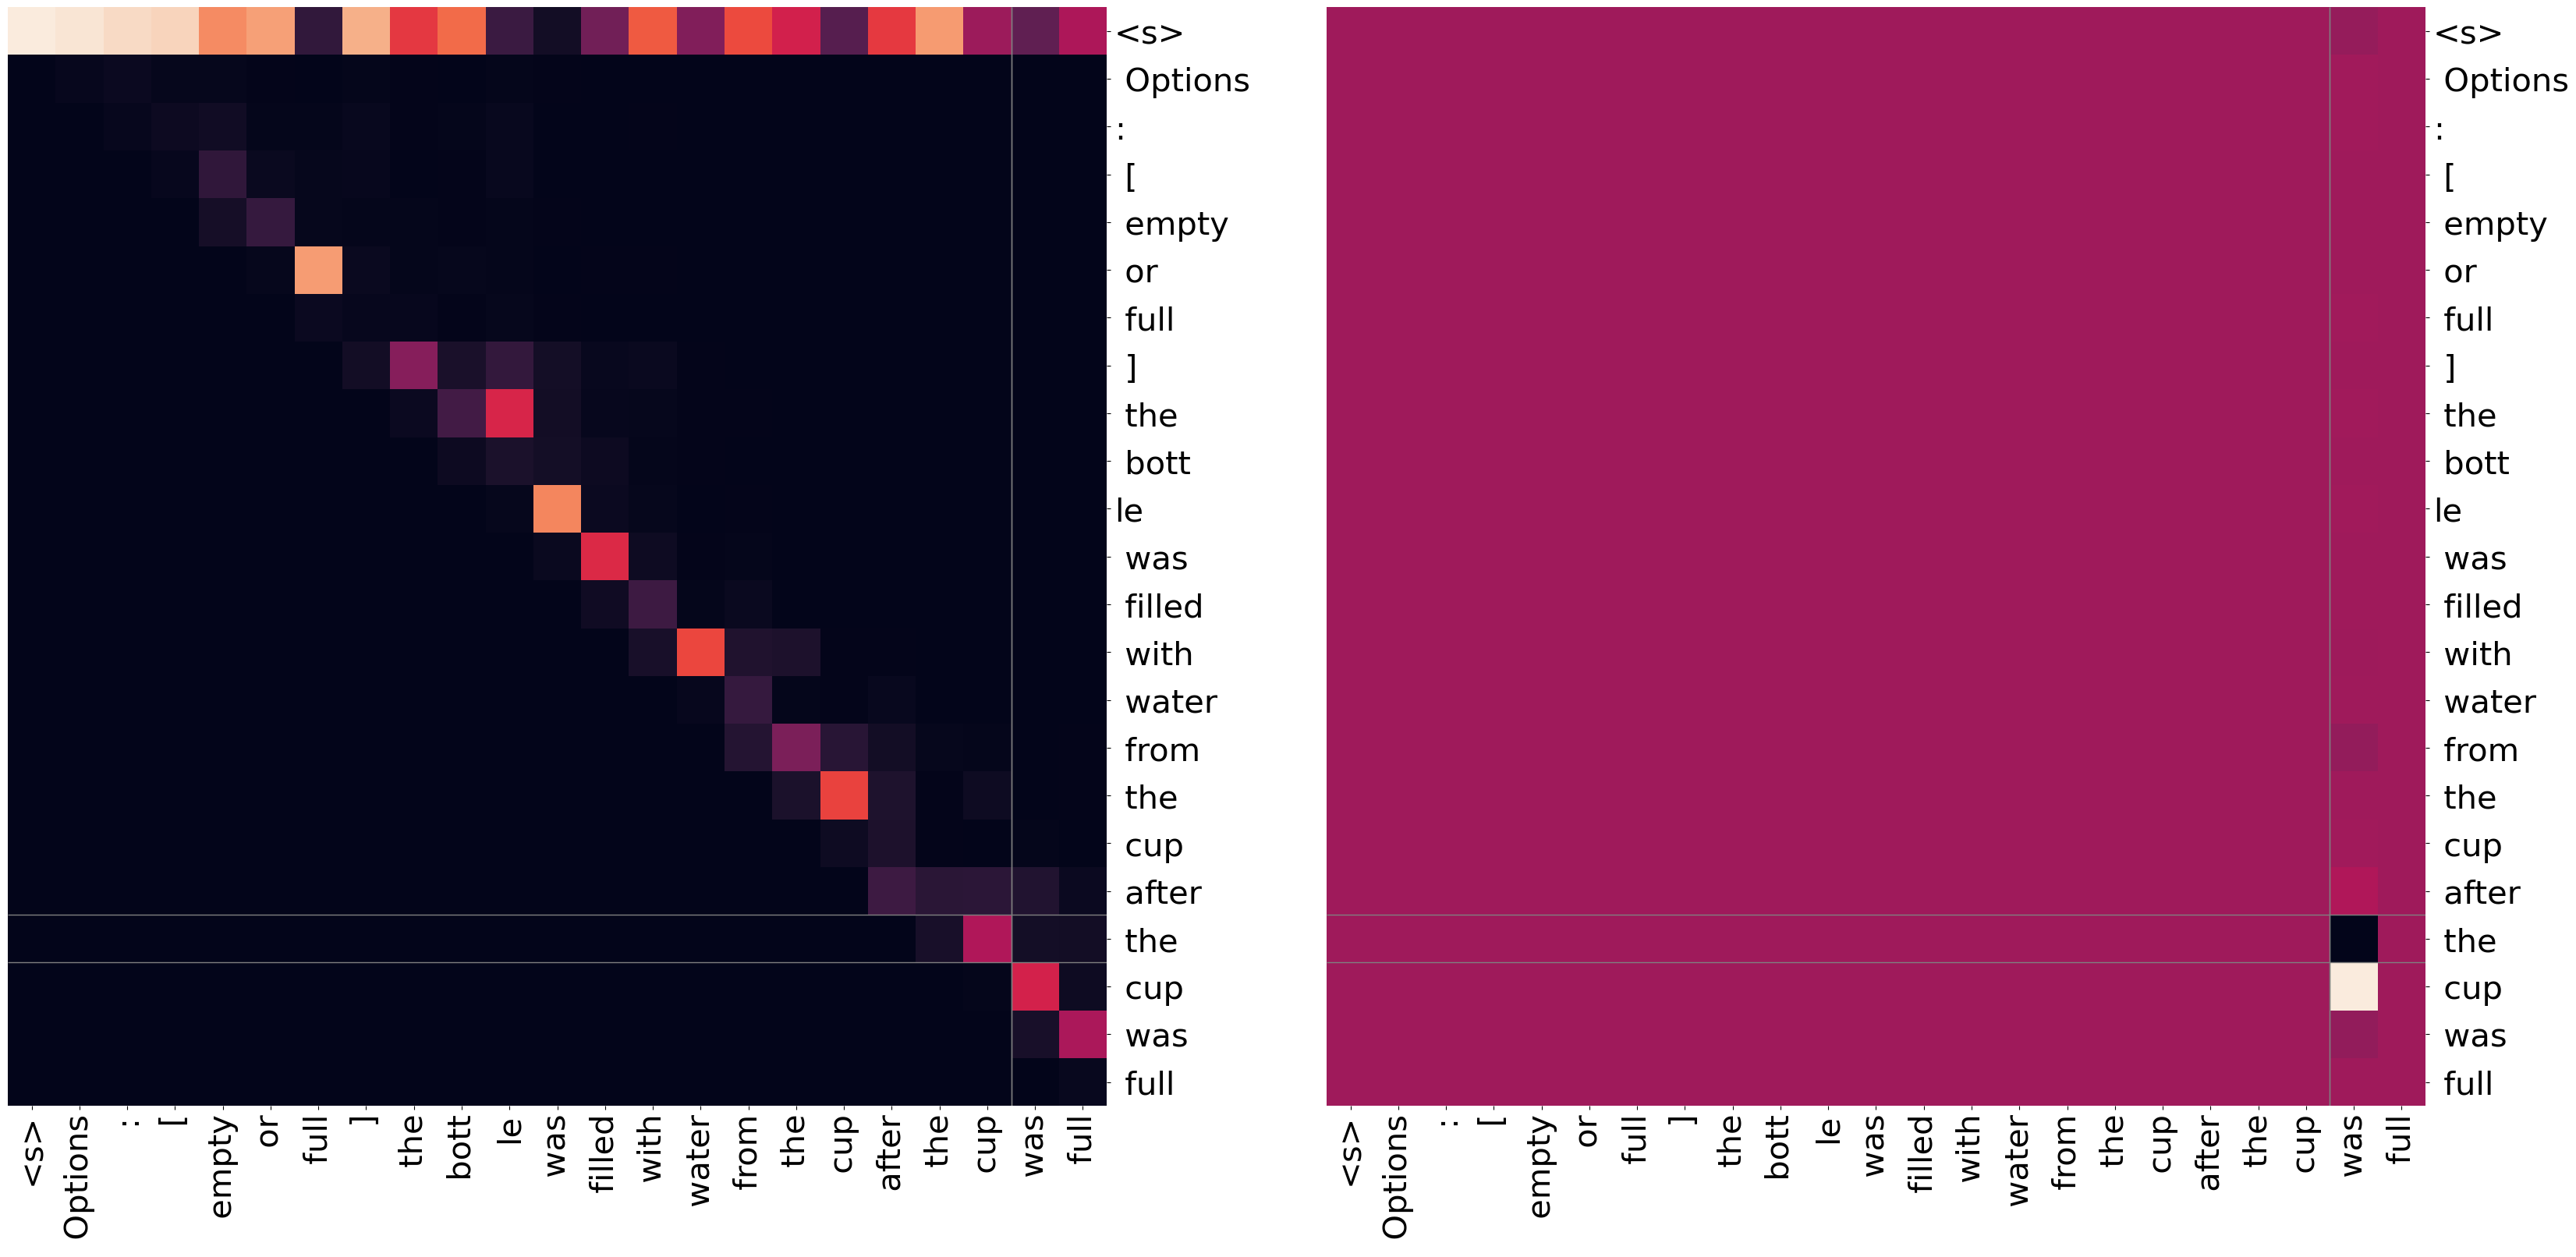

*▁older 0.501 {'▁older': 0.501, '▁younger': 0.499, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ older or younger ] Jack always takes care of Betty because Jack is older *▁older:0.018036 ▁younger:0.014427
ap_scores = tensor([0.6548]) tensor(0.6548)


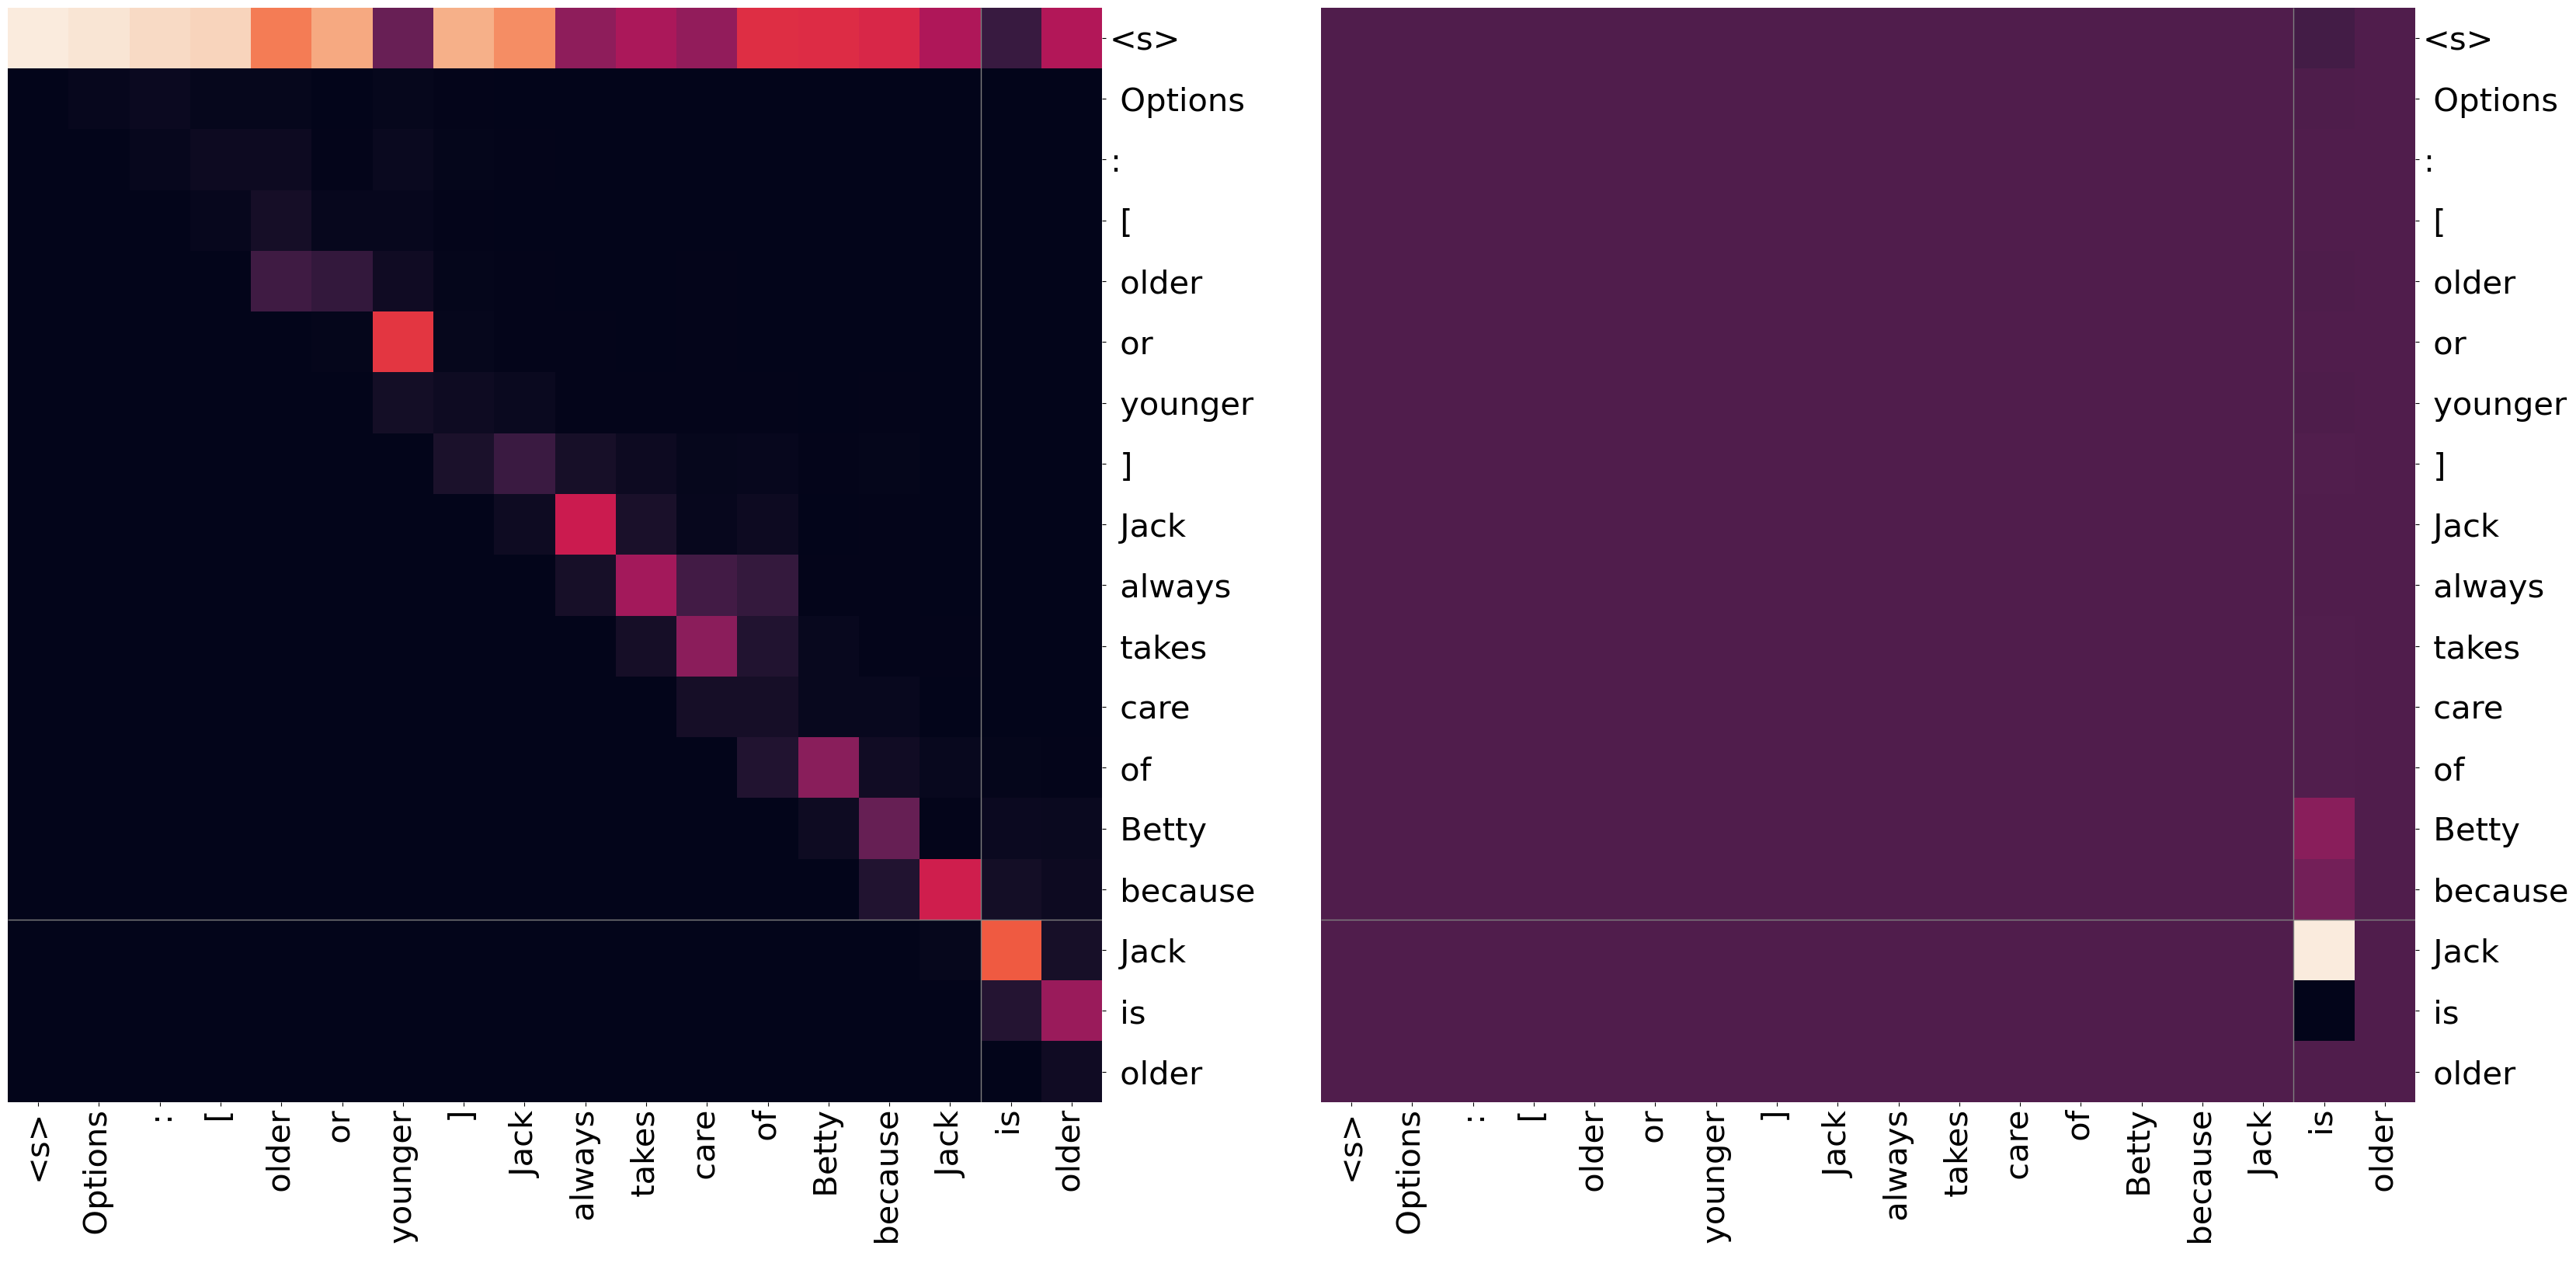

 ▁younger 0.499 {'▁older': 0.5, '▁younger': 0.499, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ younger or older ] Jack always takes care of Betty because Betty is younger ▁older:0.016205 *▁younger:0.013466
ap_scores = tensor([0.6938]) tensor(0.6938)


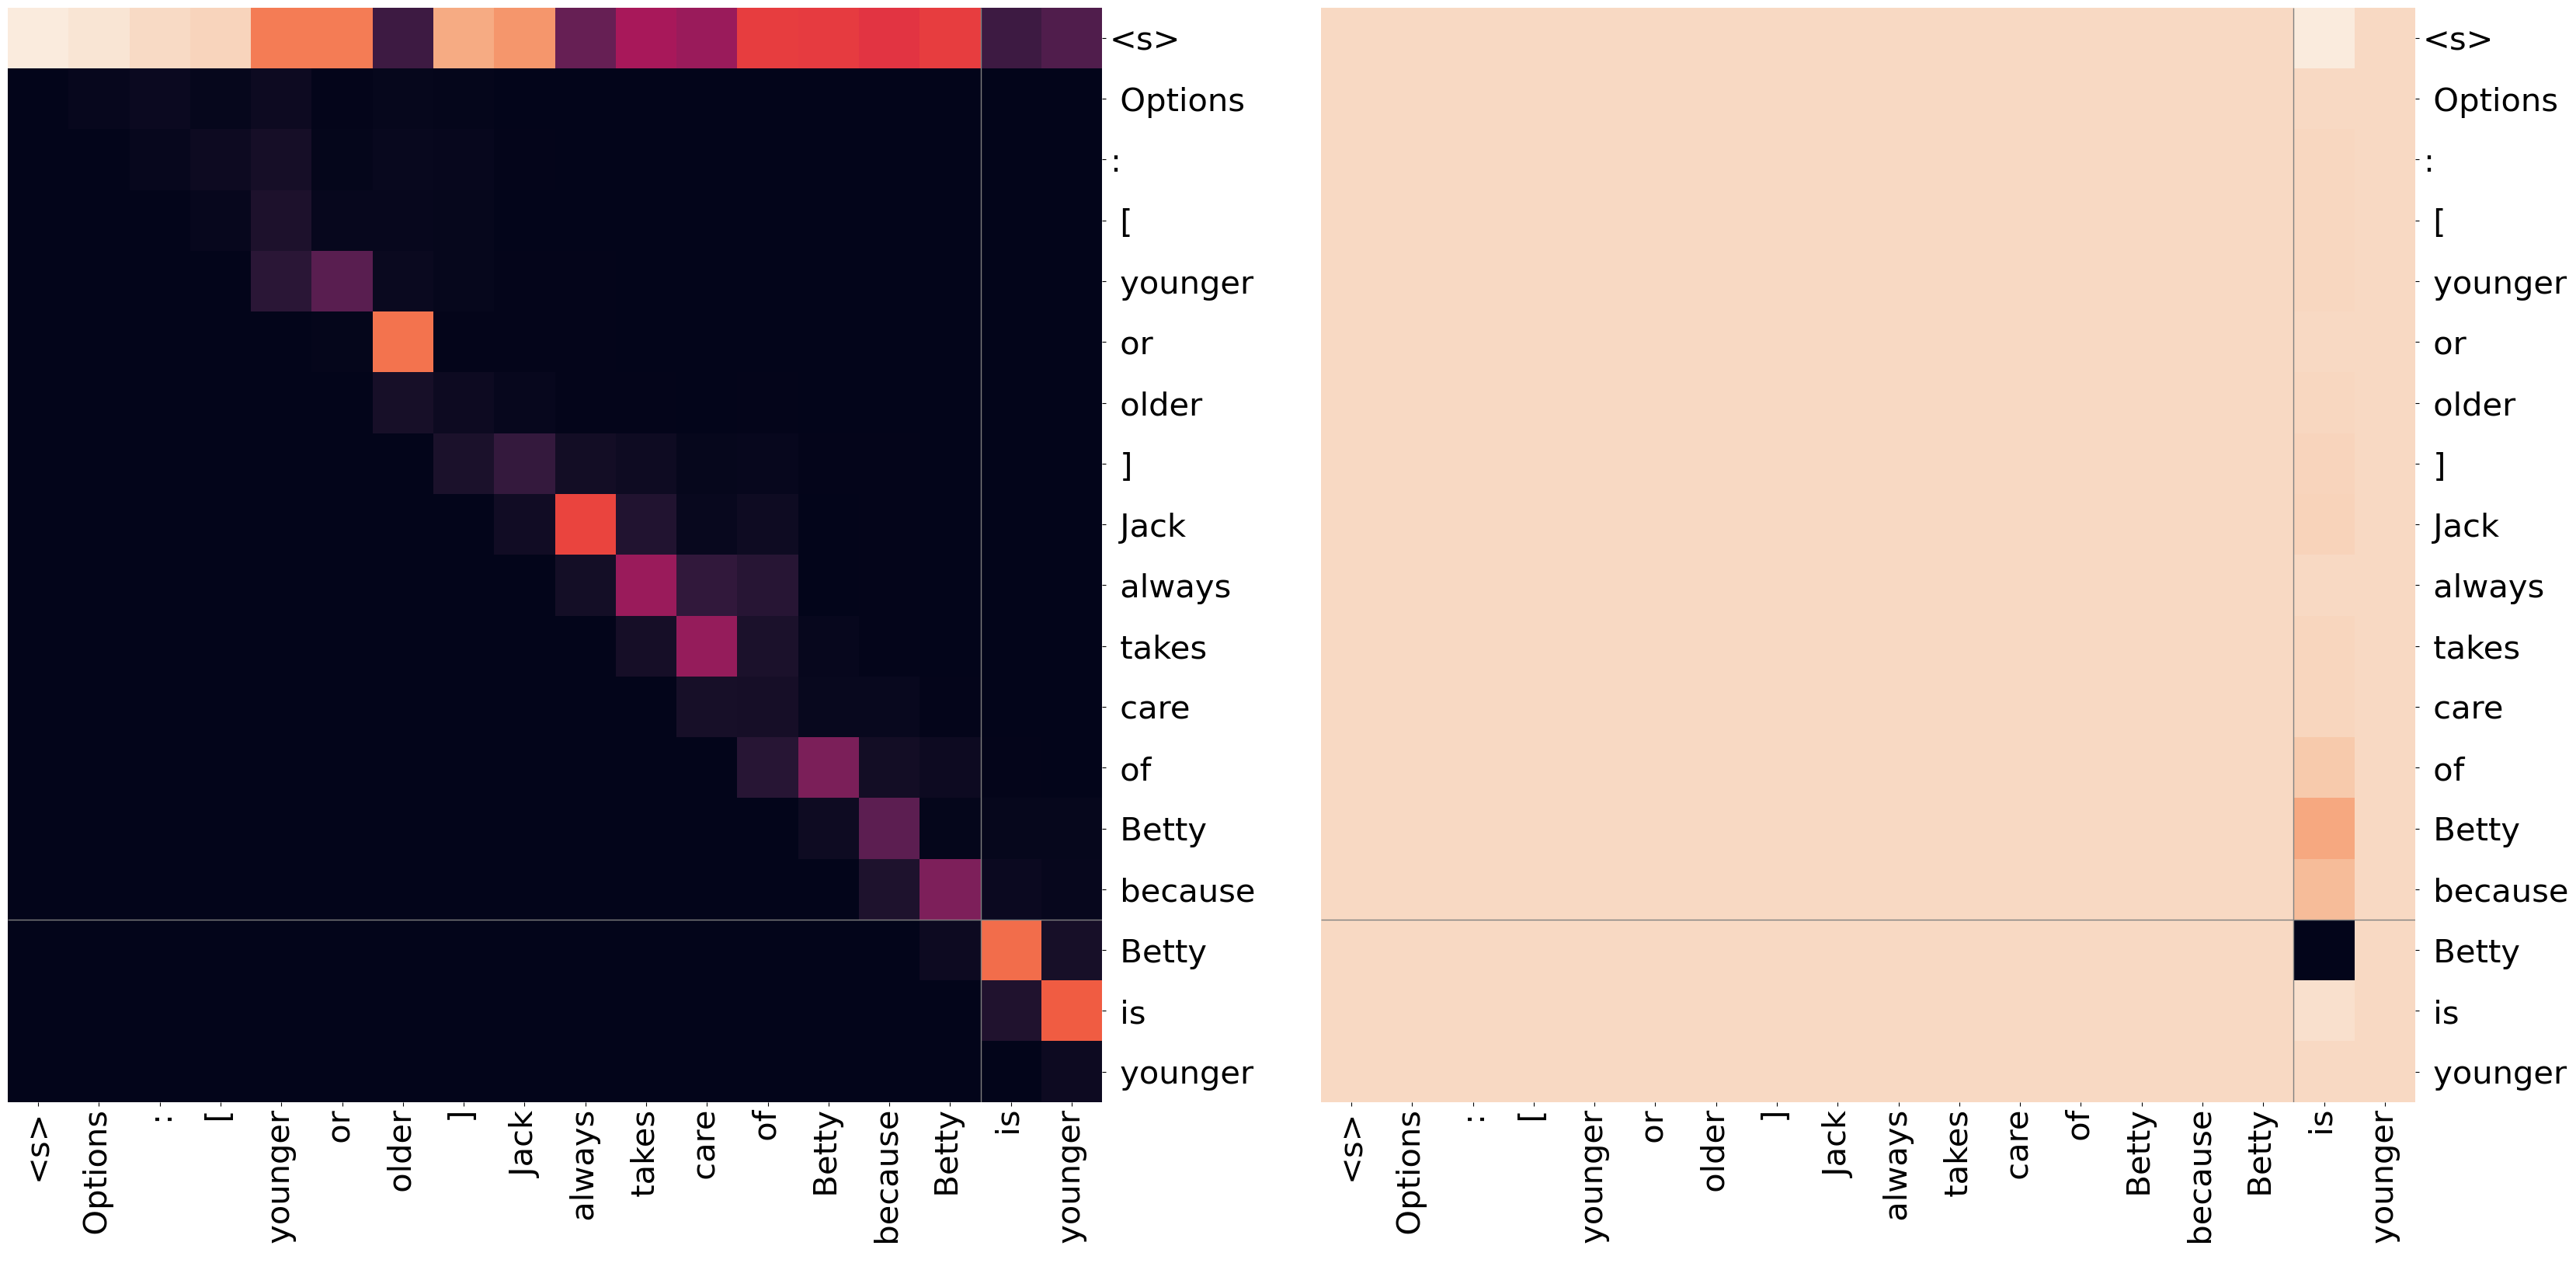

*▁minor 0.505 {'▁minor': 0.505, '▁majority': 0.495, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ minority or majority ] the sponsors were less in number than the opponents so the sponsors were in the minority *▁minor:0.022339 ▁majority:0.002197
ap_scores = tensor([0.0307]) tensor(0.0307)


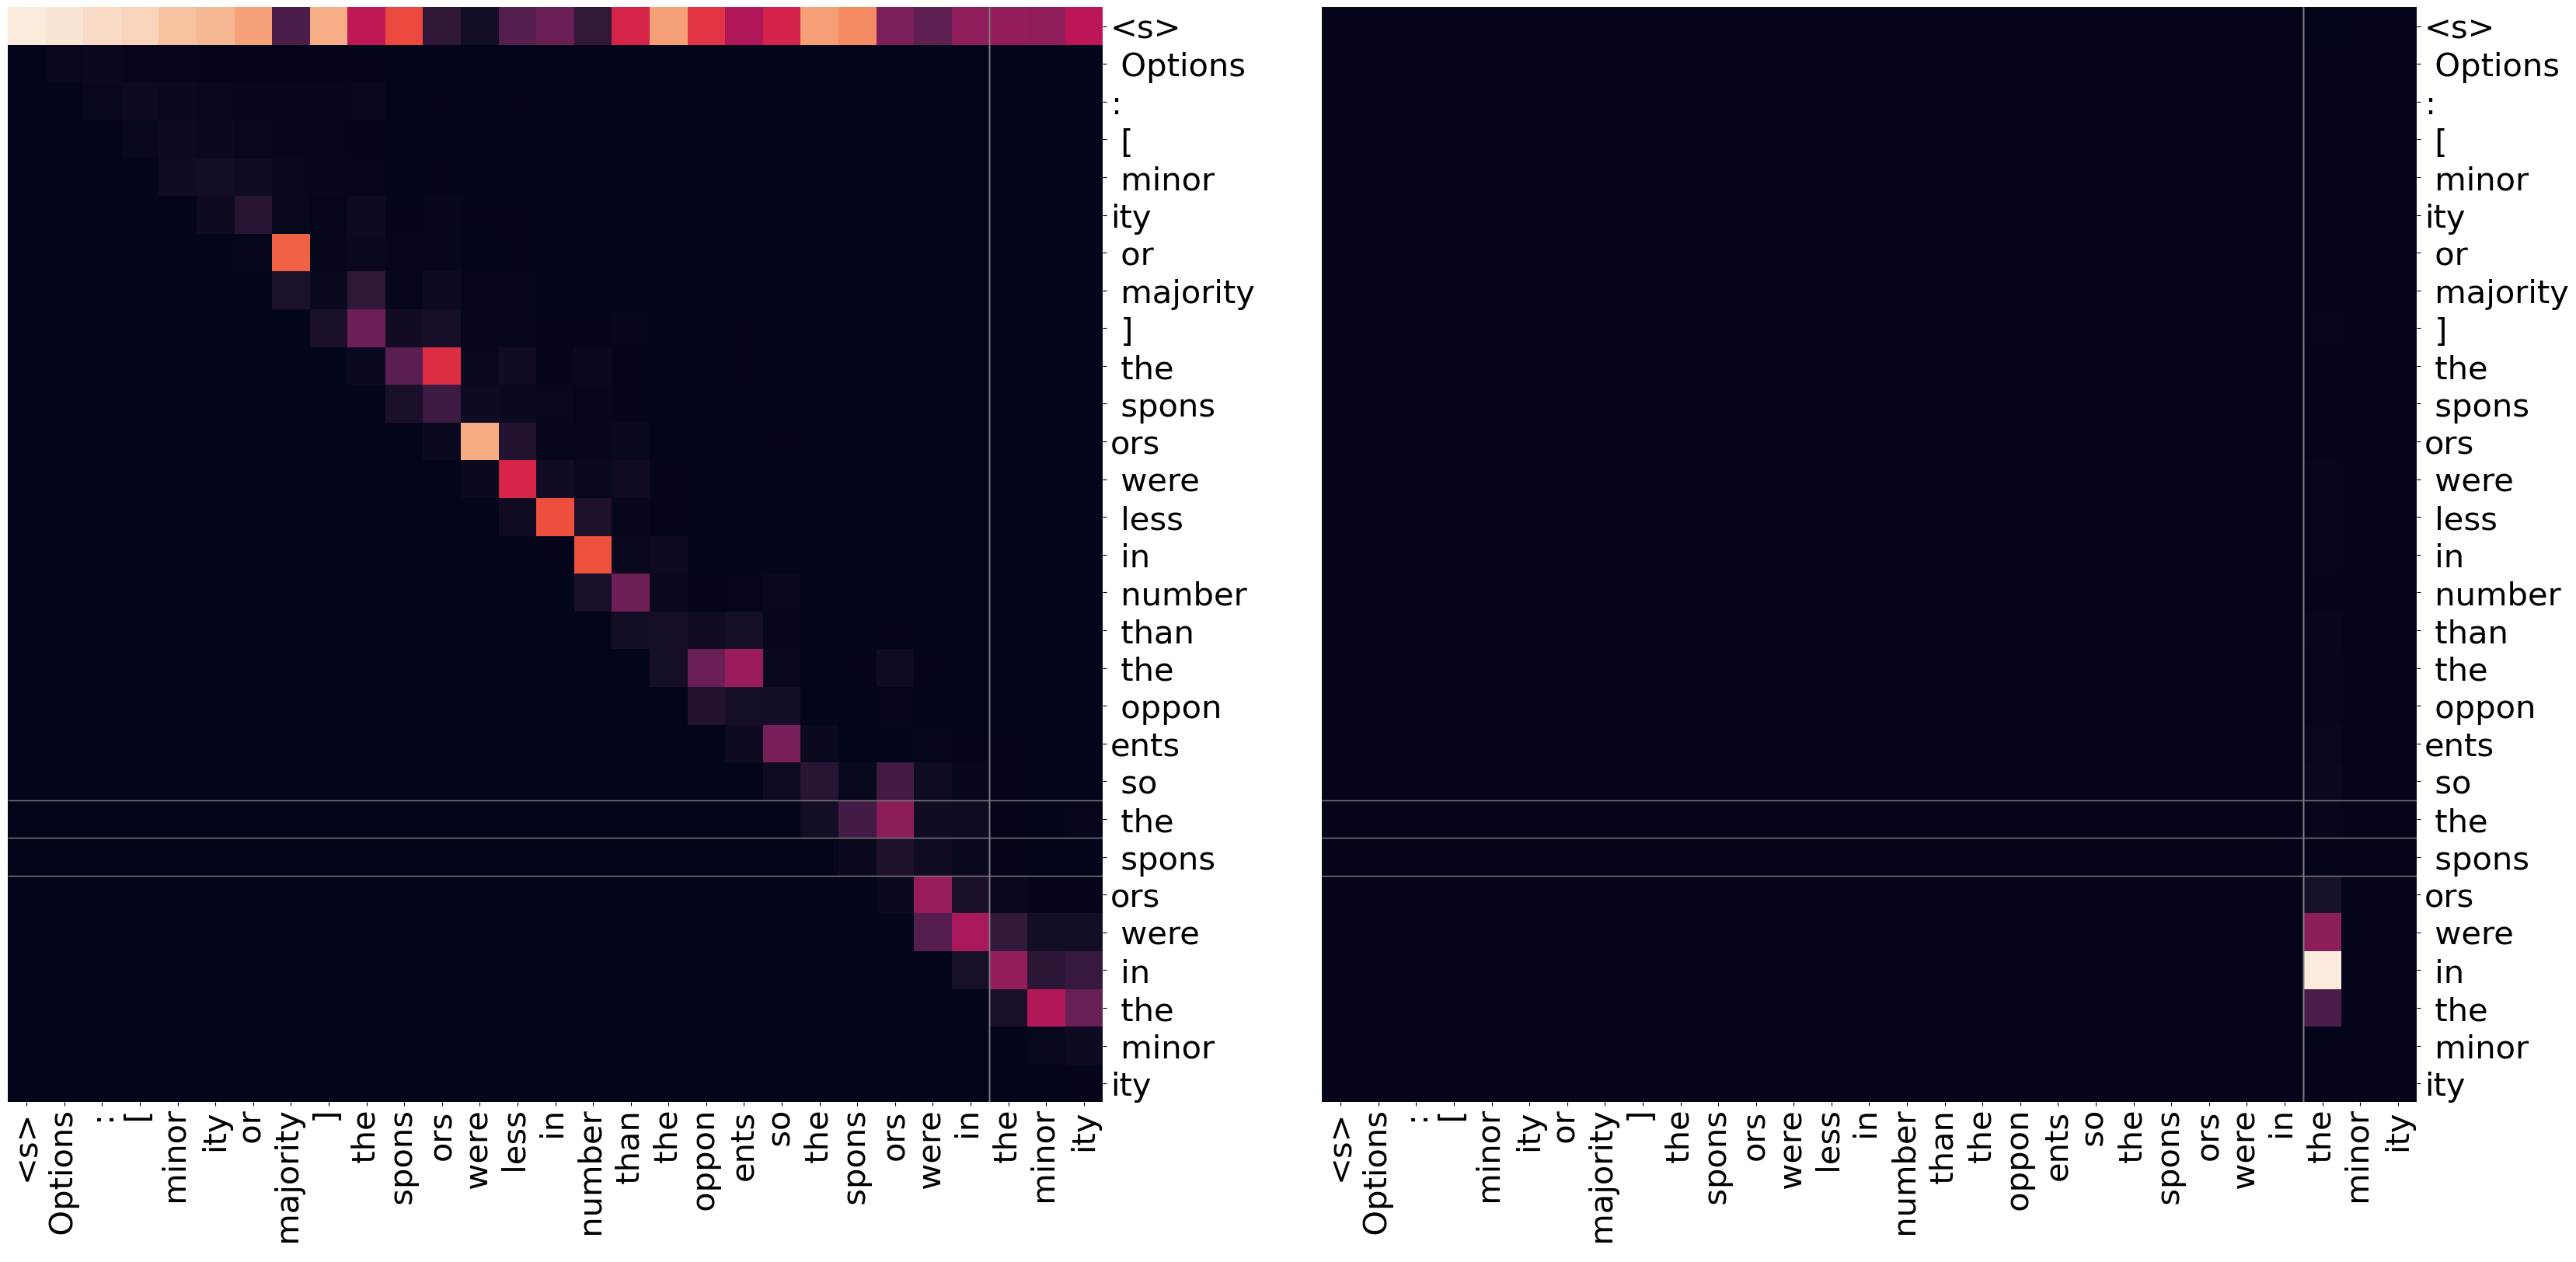

 ▁majority 0.492 {'▁minor': 0.508, '▁majority': 0.492, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ majority or minority ] the sponsors were less in number than the opponents so the opponents were in the majority ▁minor:0.031433 *▁majority:0.000324
ap_scores = tensor([0.0201]) tensor(0.0201)


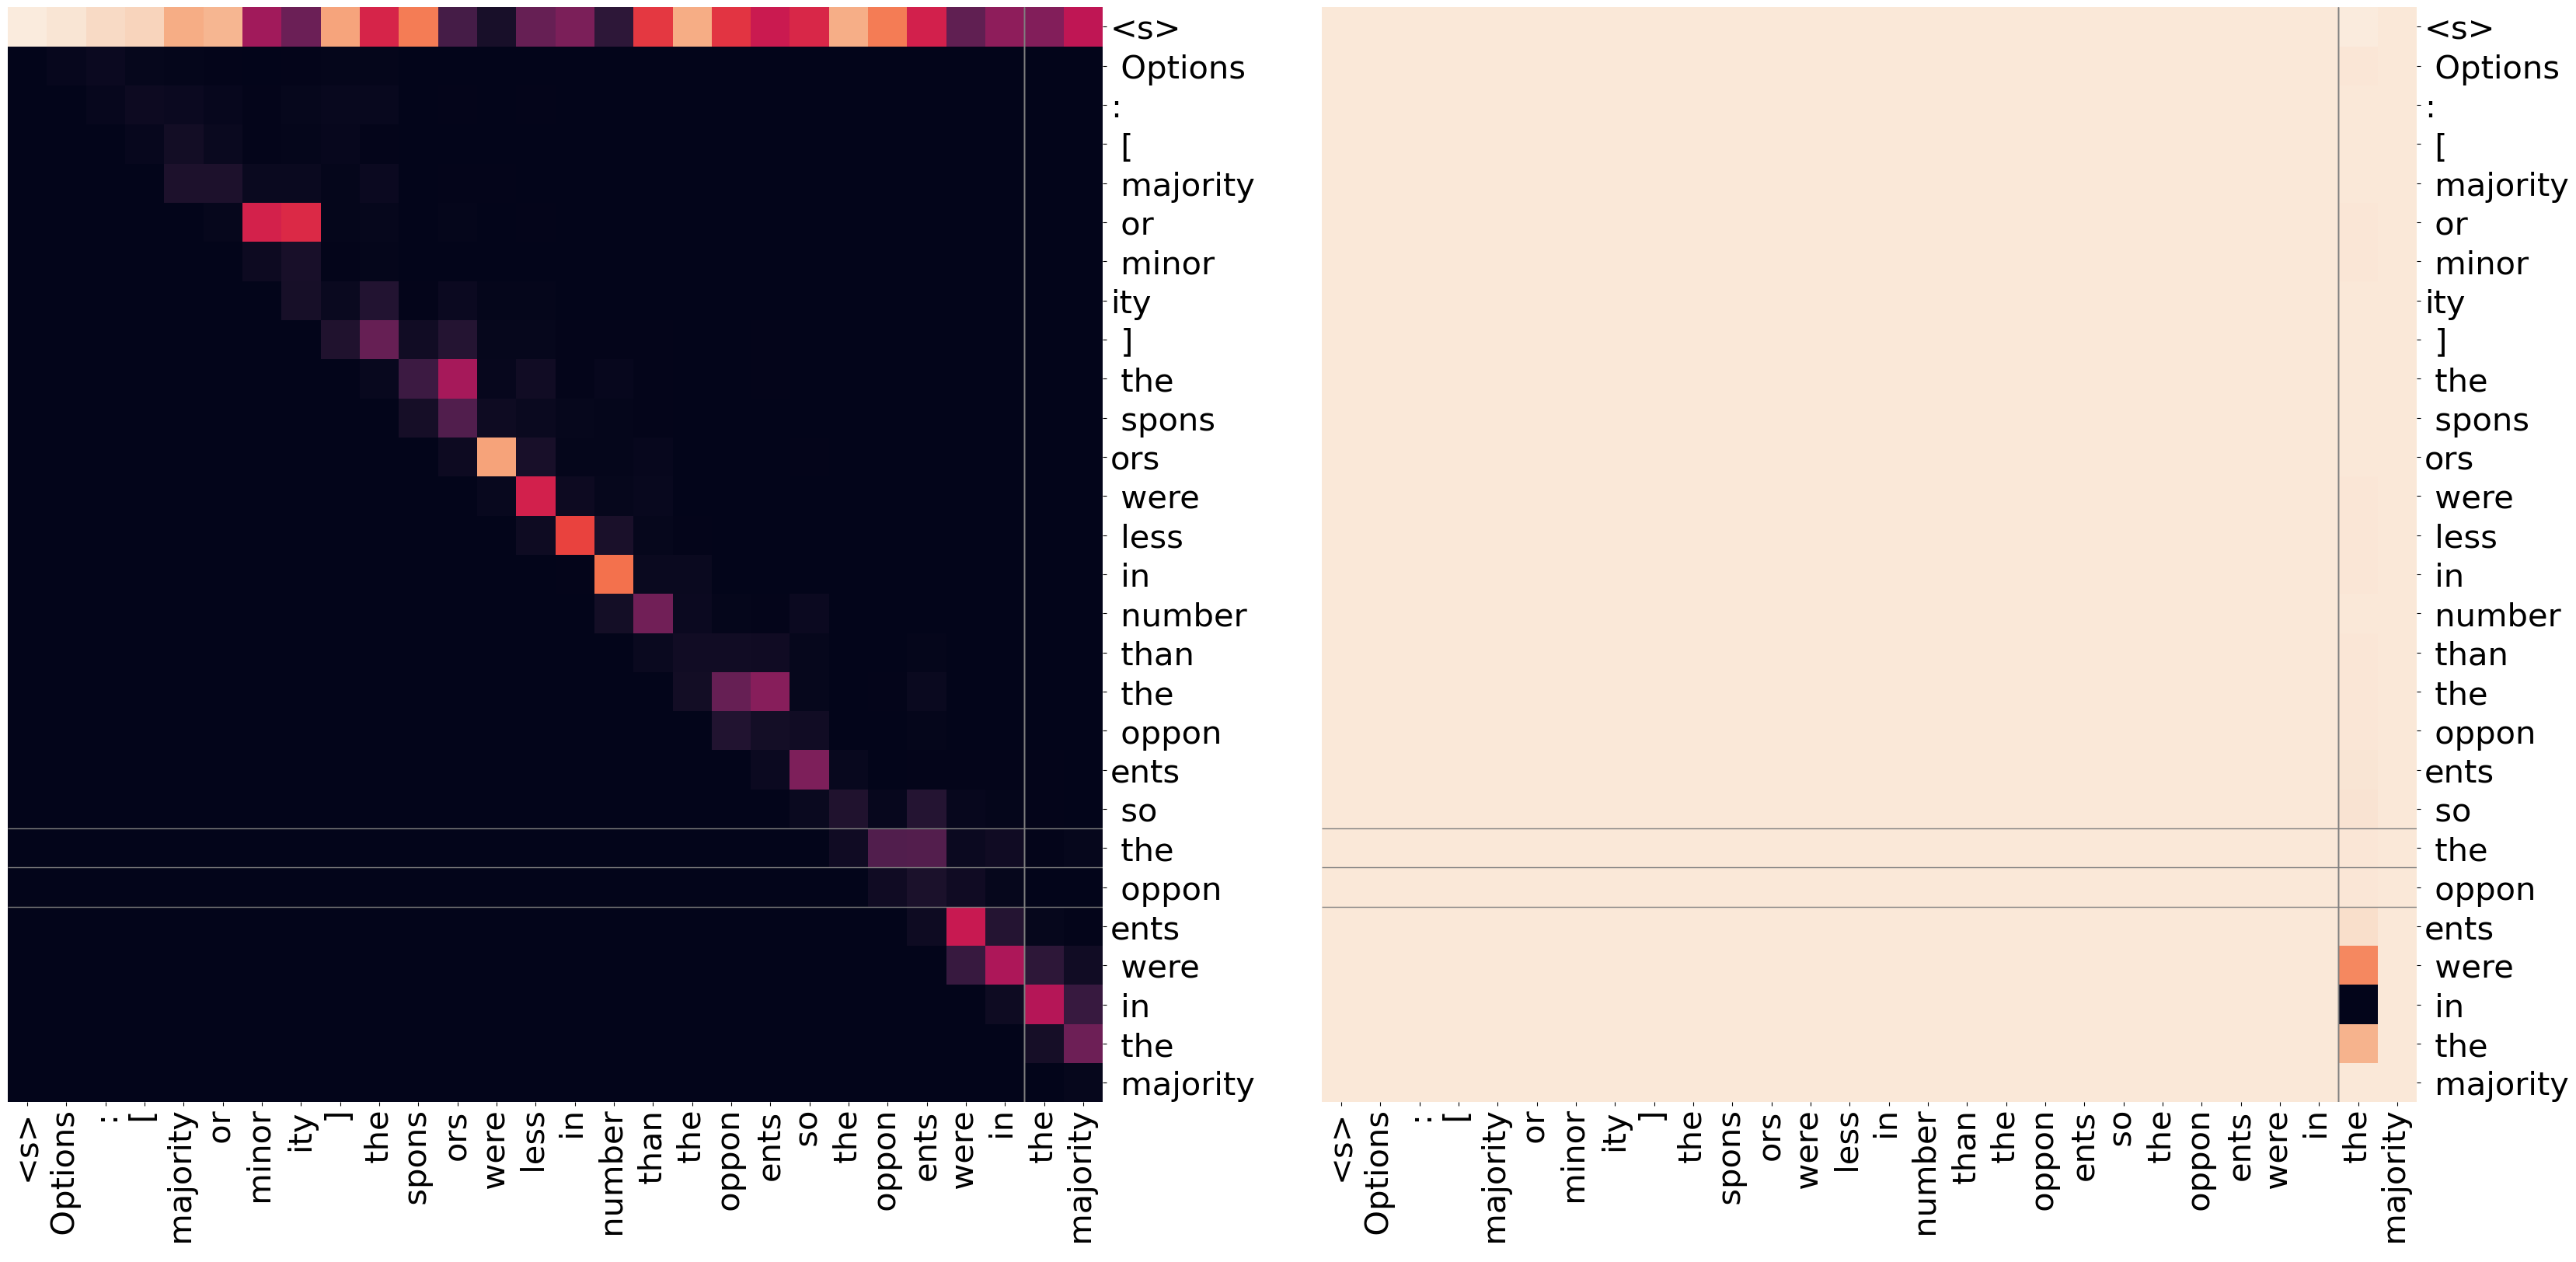

 ▁narrow 0.497 {'▁wide': 0.504, '▁narrow': 0.496, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ wide or narrow ] the table will fit through the doorway because the table is narrow ▁wide:0.031403 *▁narrow:0.017792
ap_scores = tensor([0.7074]) tensor(0.7074)


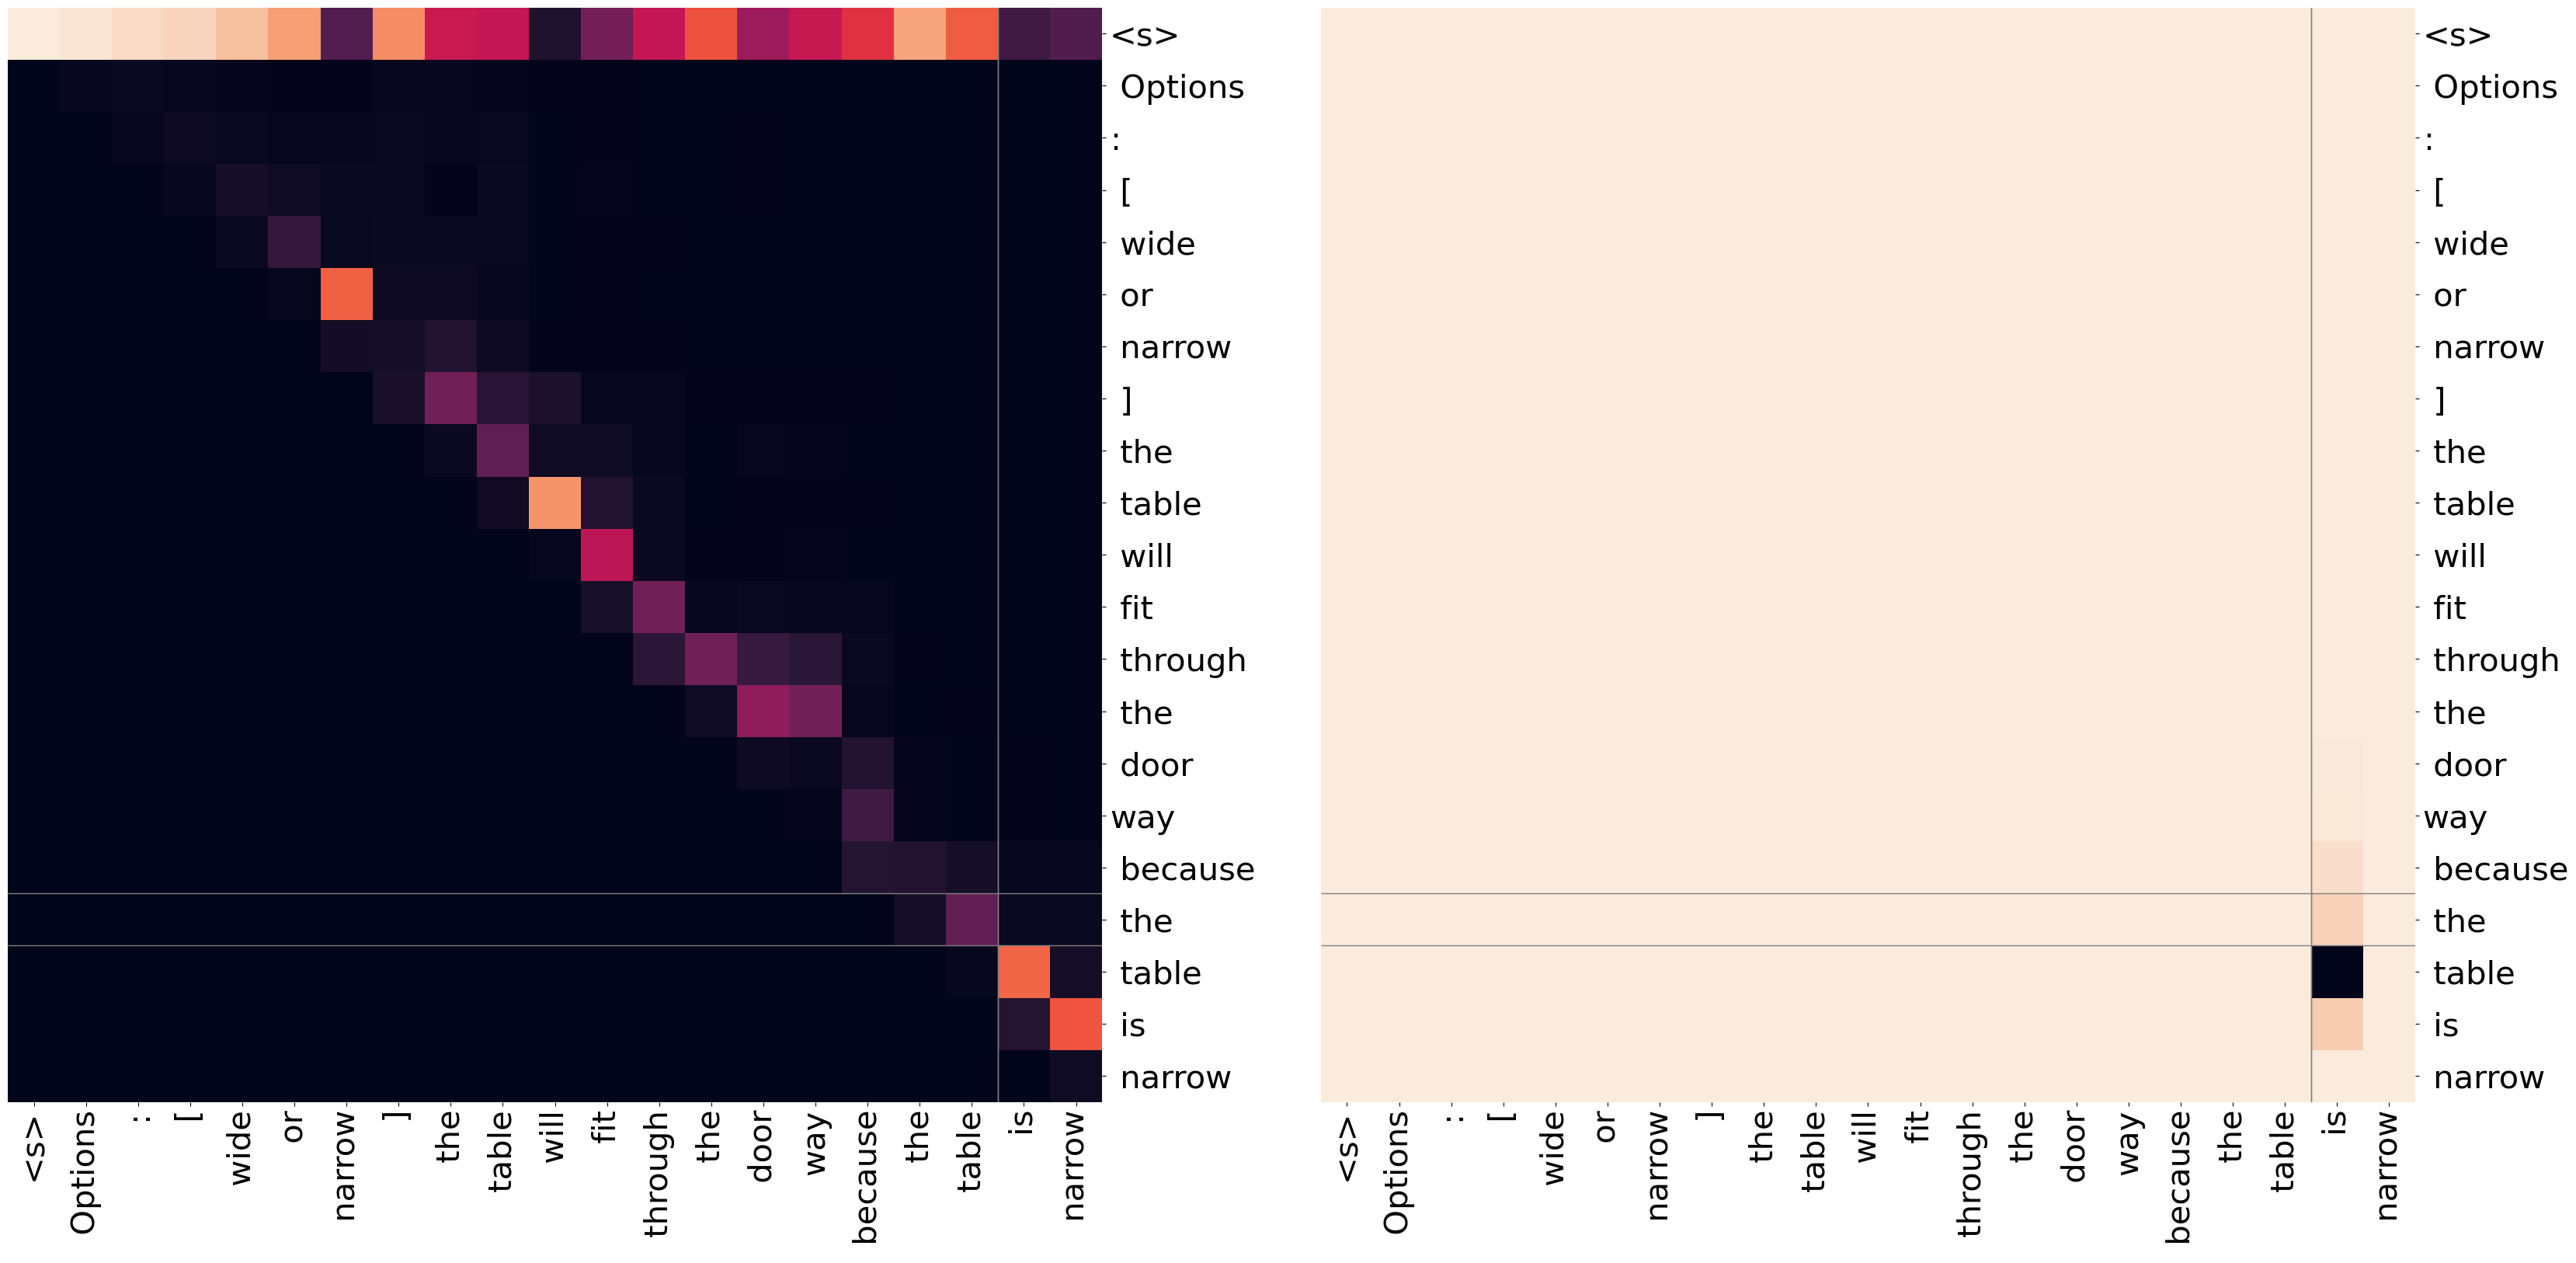

*▁wide 0.514 {'▁wide': 0.514, '▁narrow': 0.486, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ wide or narrow ] the table will fit through the doorway because the doorway is wide *▁wide:0.095337 ▁narrow:0.037872
ap_scores = tensor([0.7474]) tensor(0.7474)


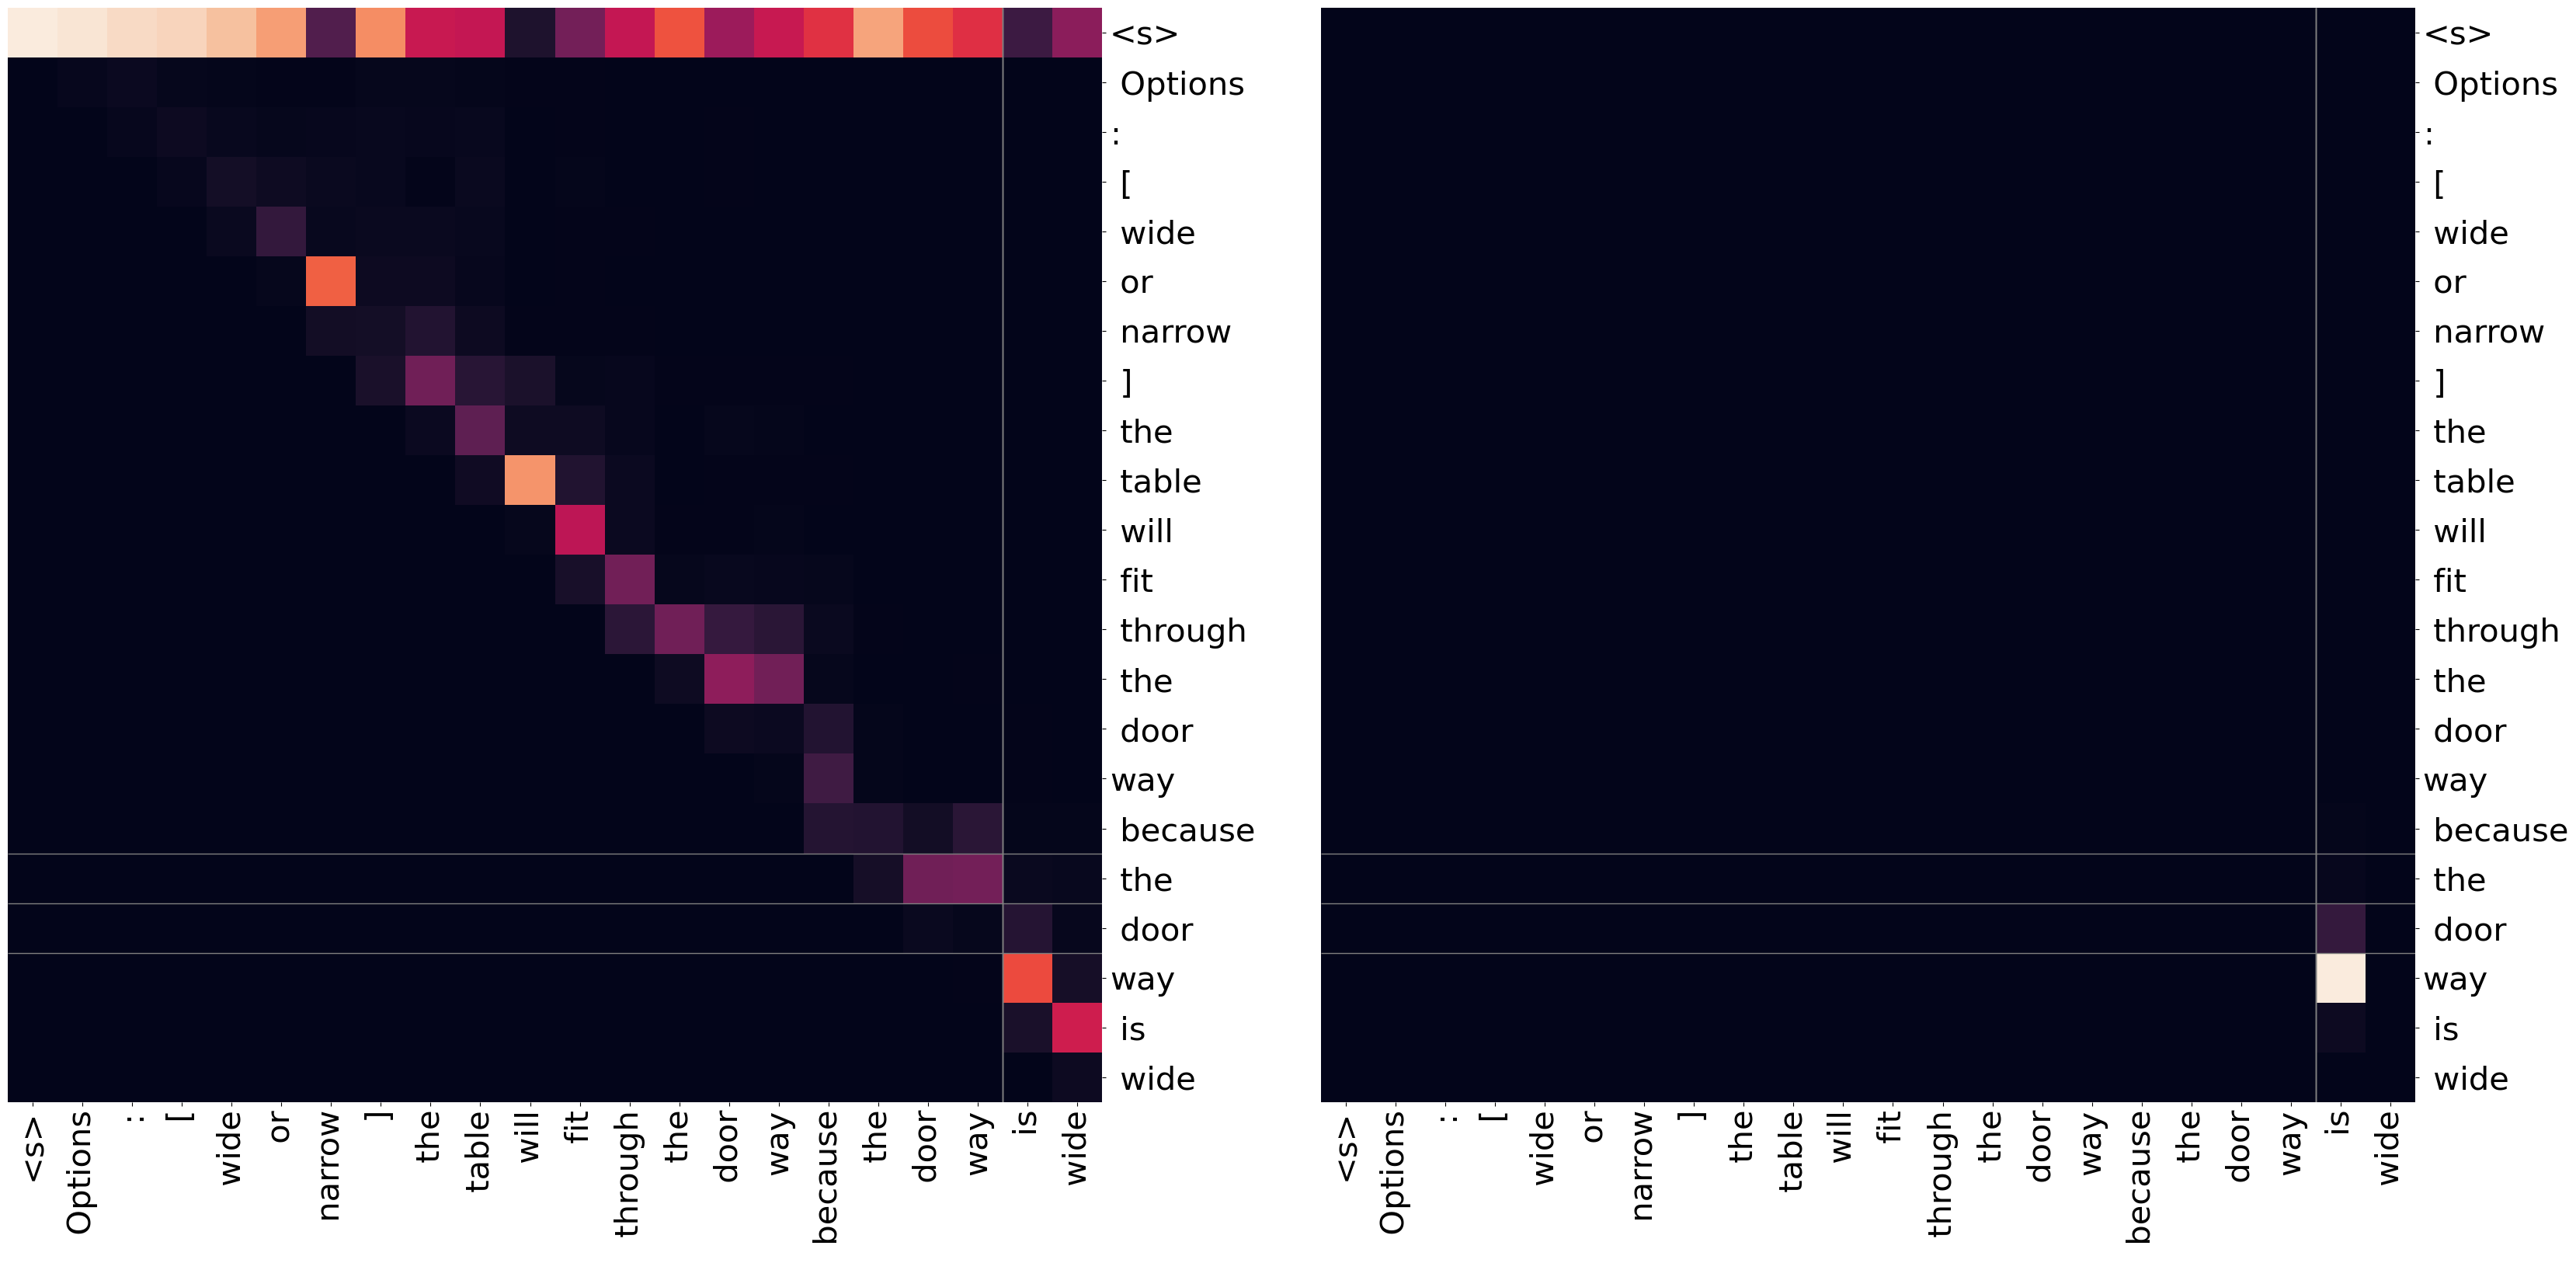

 ▁full 0.493 {'▁hun': 0.506, '▁full': 0.494, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ full or hungry ] Bill passed the half-empty plate to Amy because Bill was full ▁hun:0.021332 *▁full:-0.004925
ap_scores = tensor([0.6211]) tensor(0.6211)


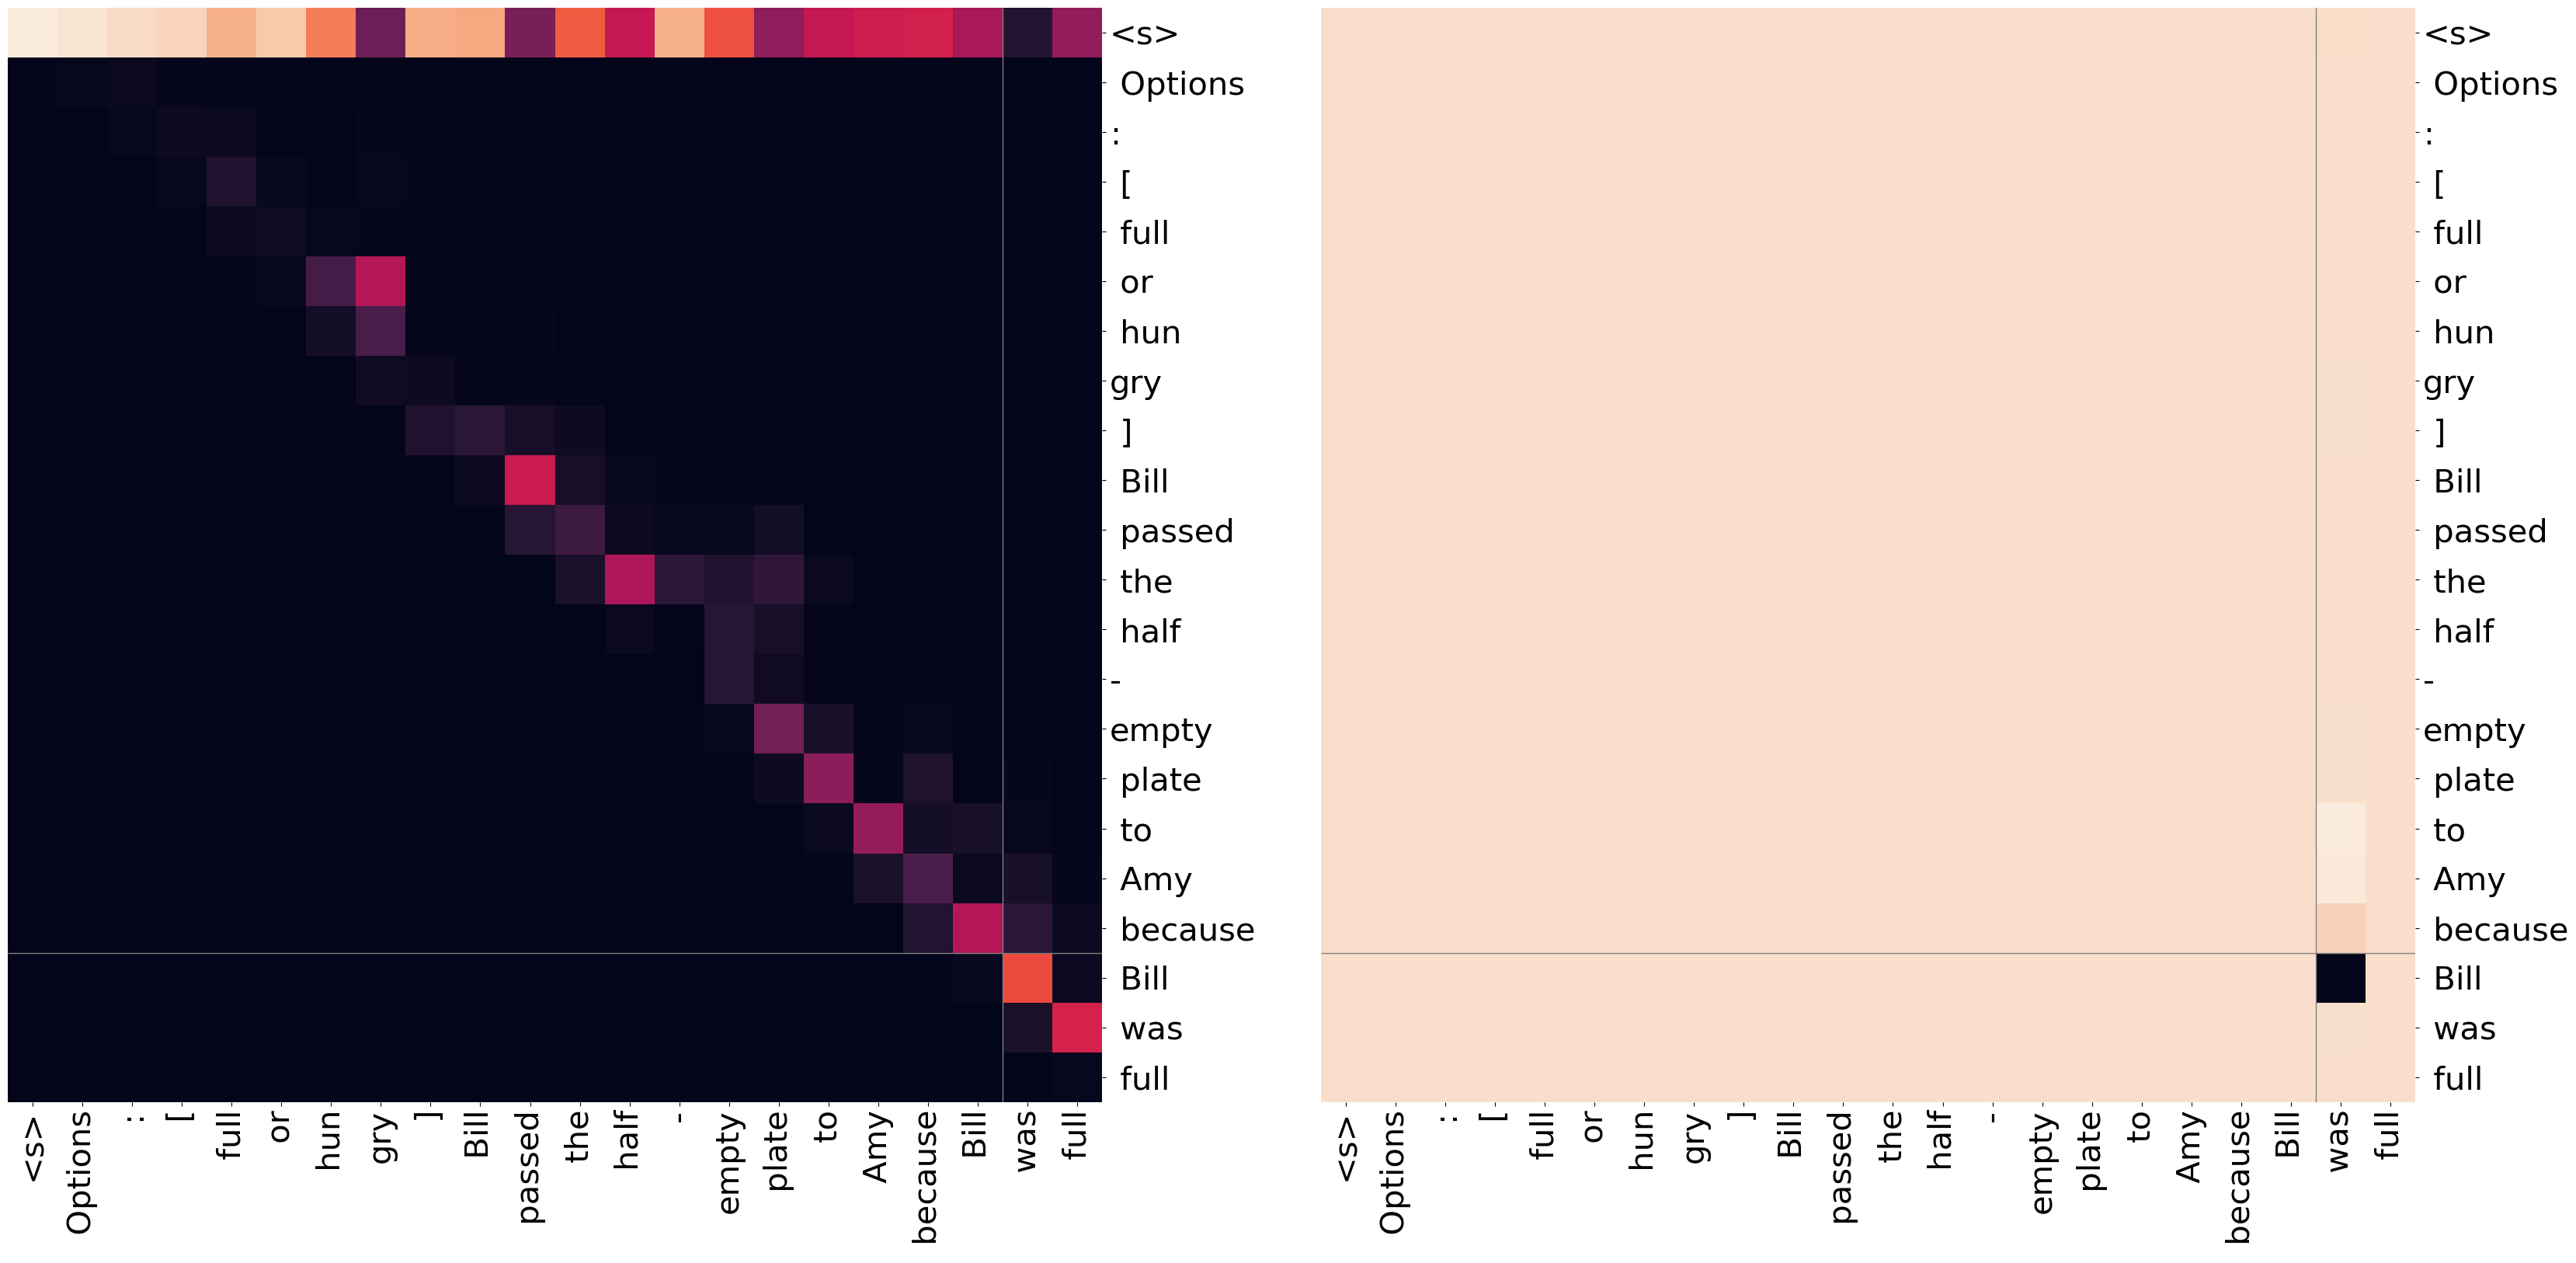

*▁hun 0.508 {'▁hun': 0.508, '▁full': 0.492, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ full or hungry ] Bill passed the half-empty plate to Amy because Amy was hungry *▁hun:0.023575 ▁full:-0.007206
ap_scores = tensor([0.7344]) tensor(0.7344)


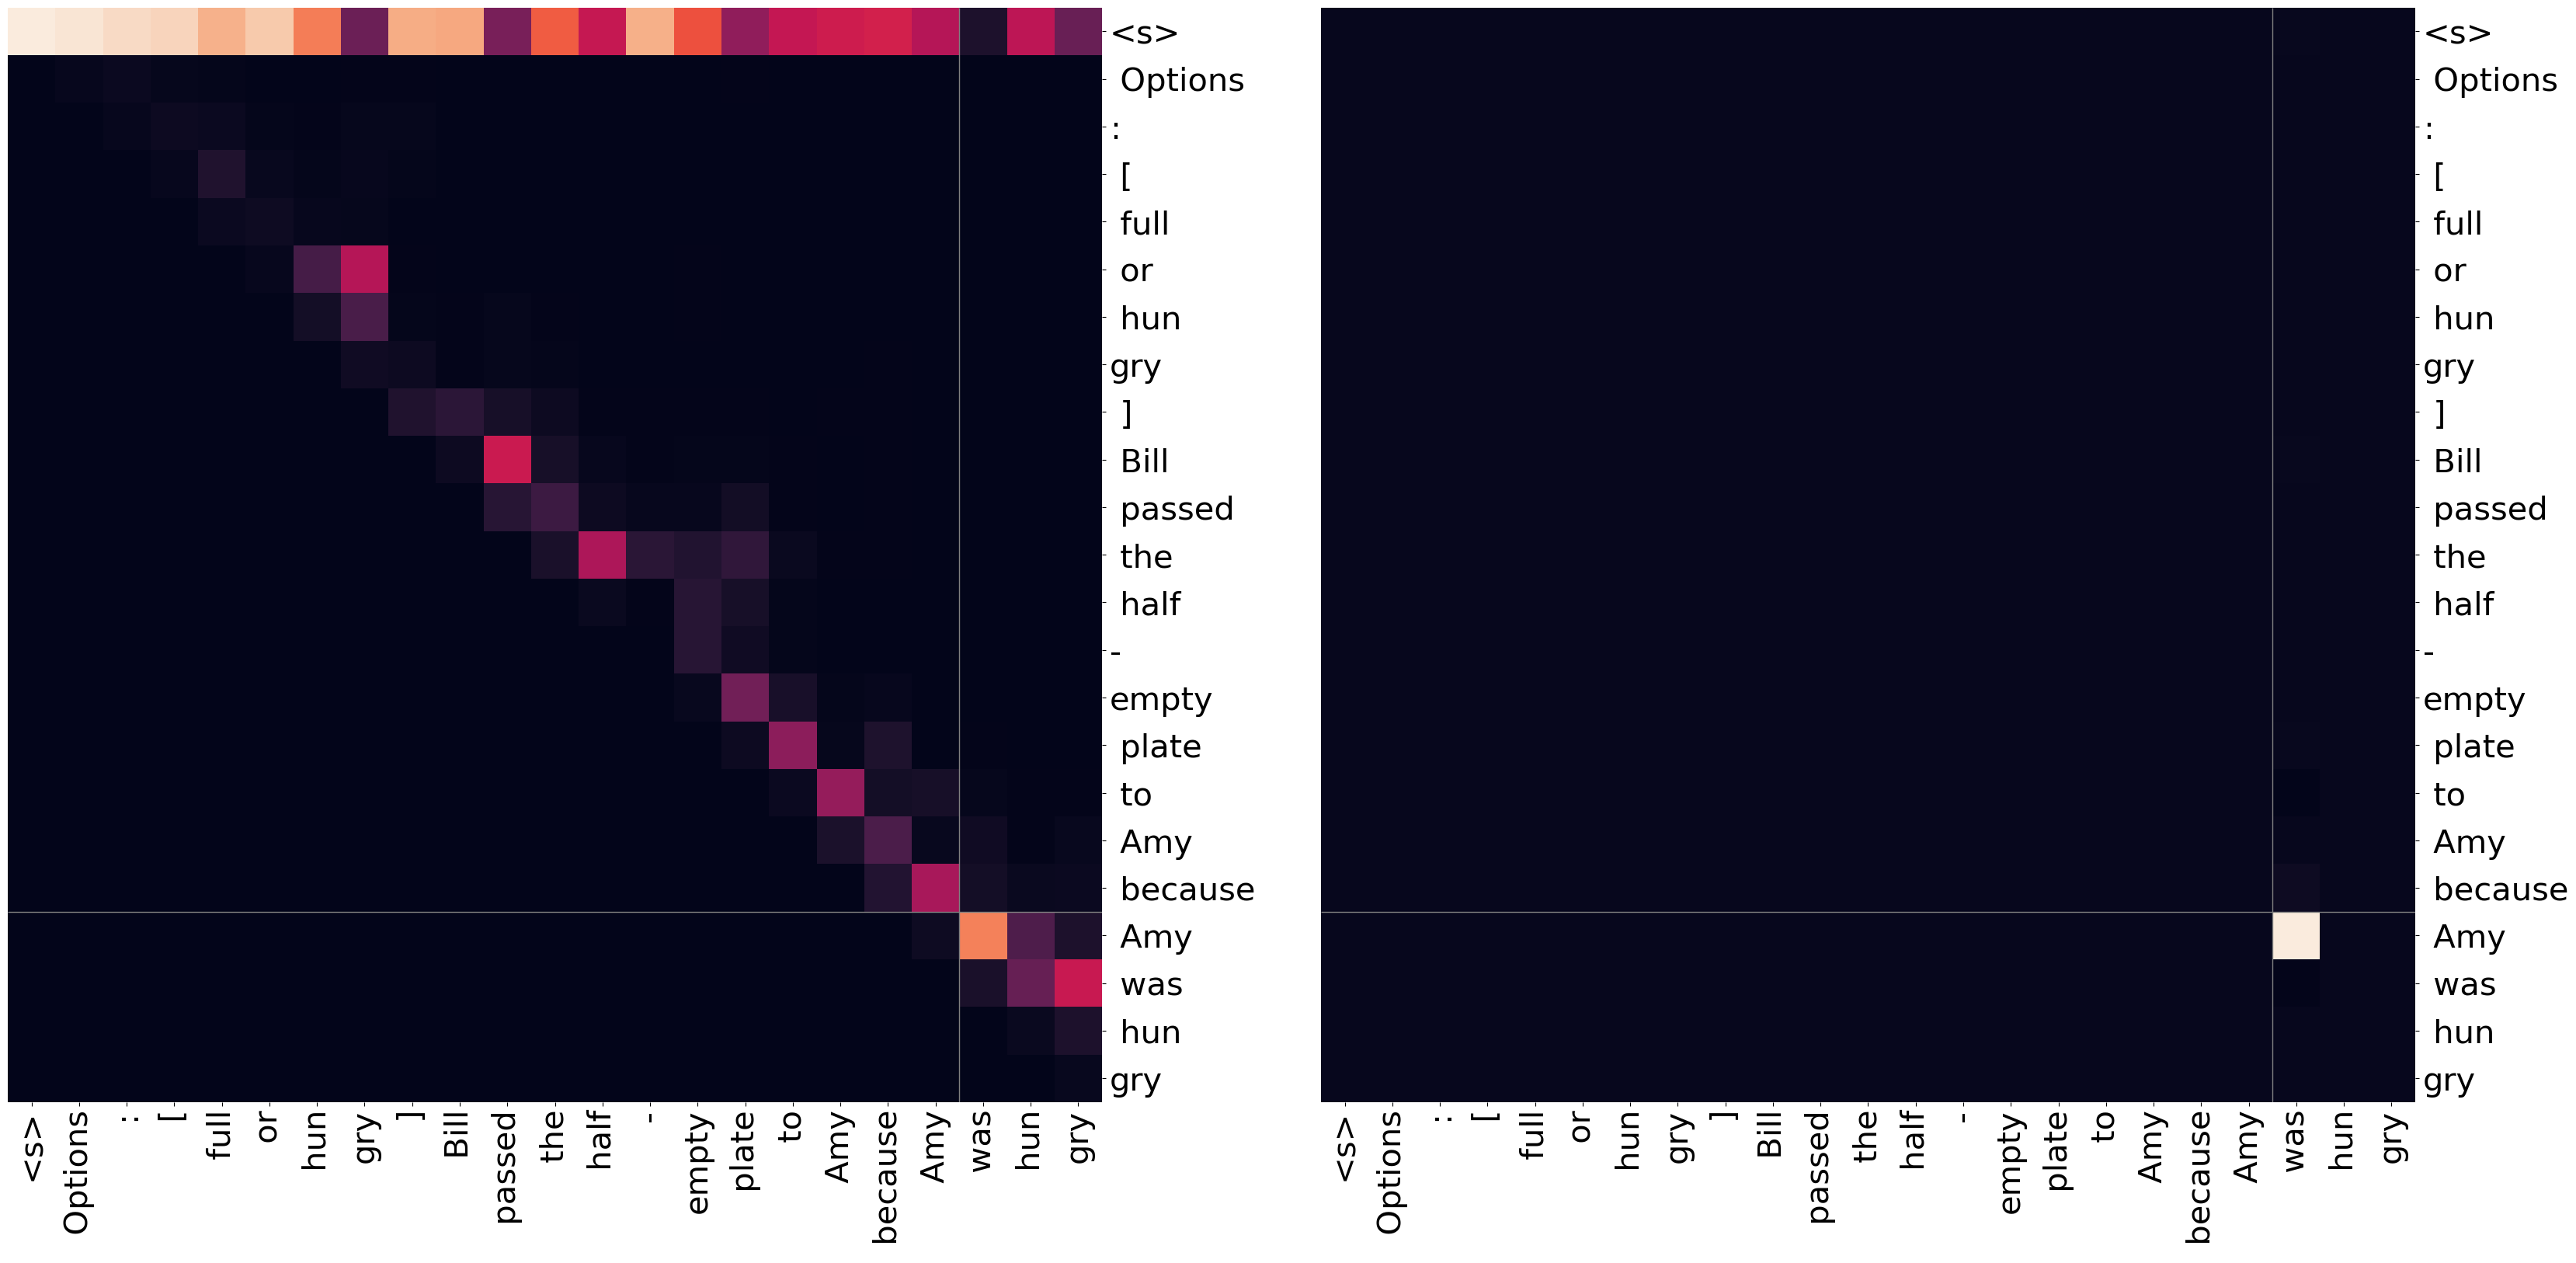

*▁not 0.502 {'▁not': 0.502, '▁popular': 0.498, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ notorious or popular ] James ceded the presidency to Amy because James was notorious *▁not:0.006821 ▁popular:-0.001472
ap_scores = tensor([0.7119]) tensor(0.7119)


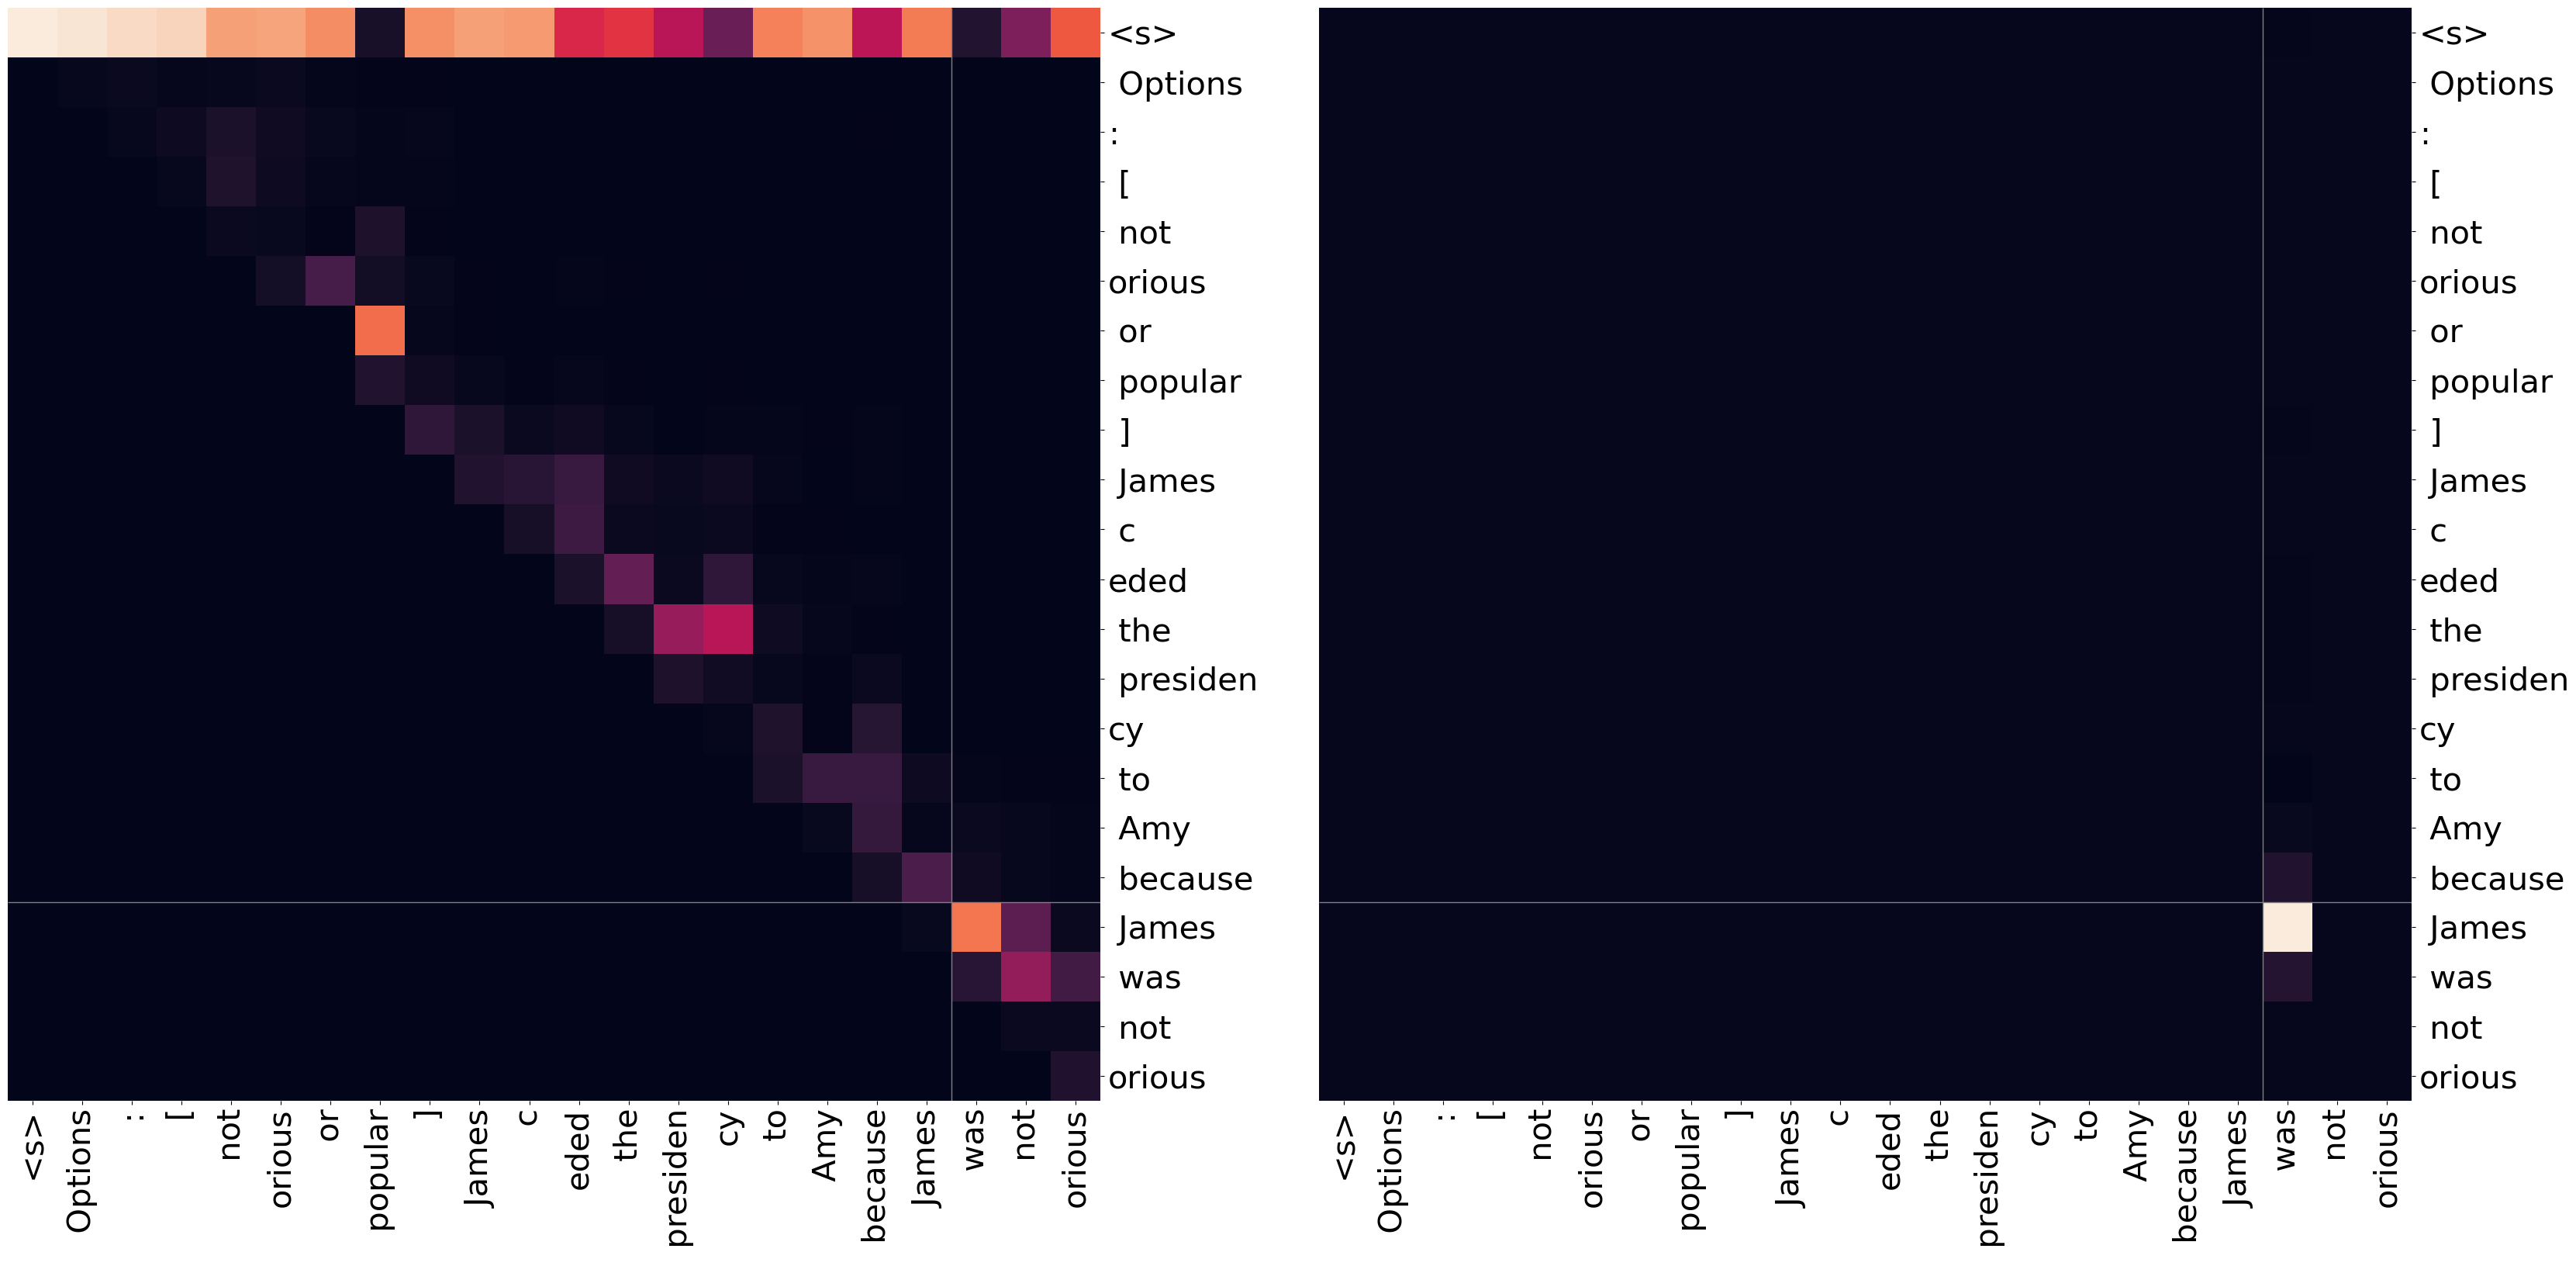

*▁popular 0.501 {'▁popular': 0.502, '▁not': 0.498, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ popular or notorious ] James ceded the presidency to Amy because Amy was popular ▁not:-0.003757 *▁popular:0.002512
ap_scores = tensor([0.7588]) tensor(0.7588)


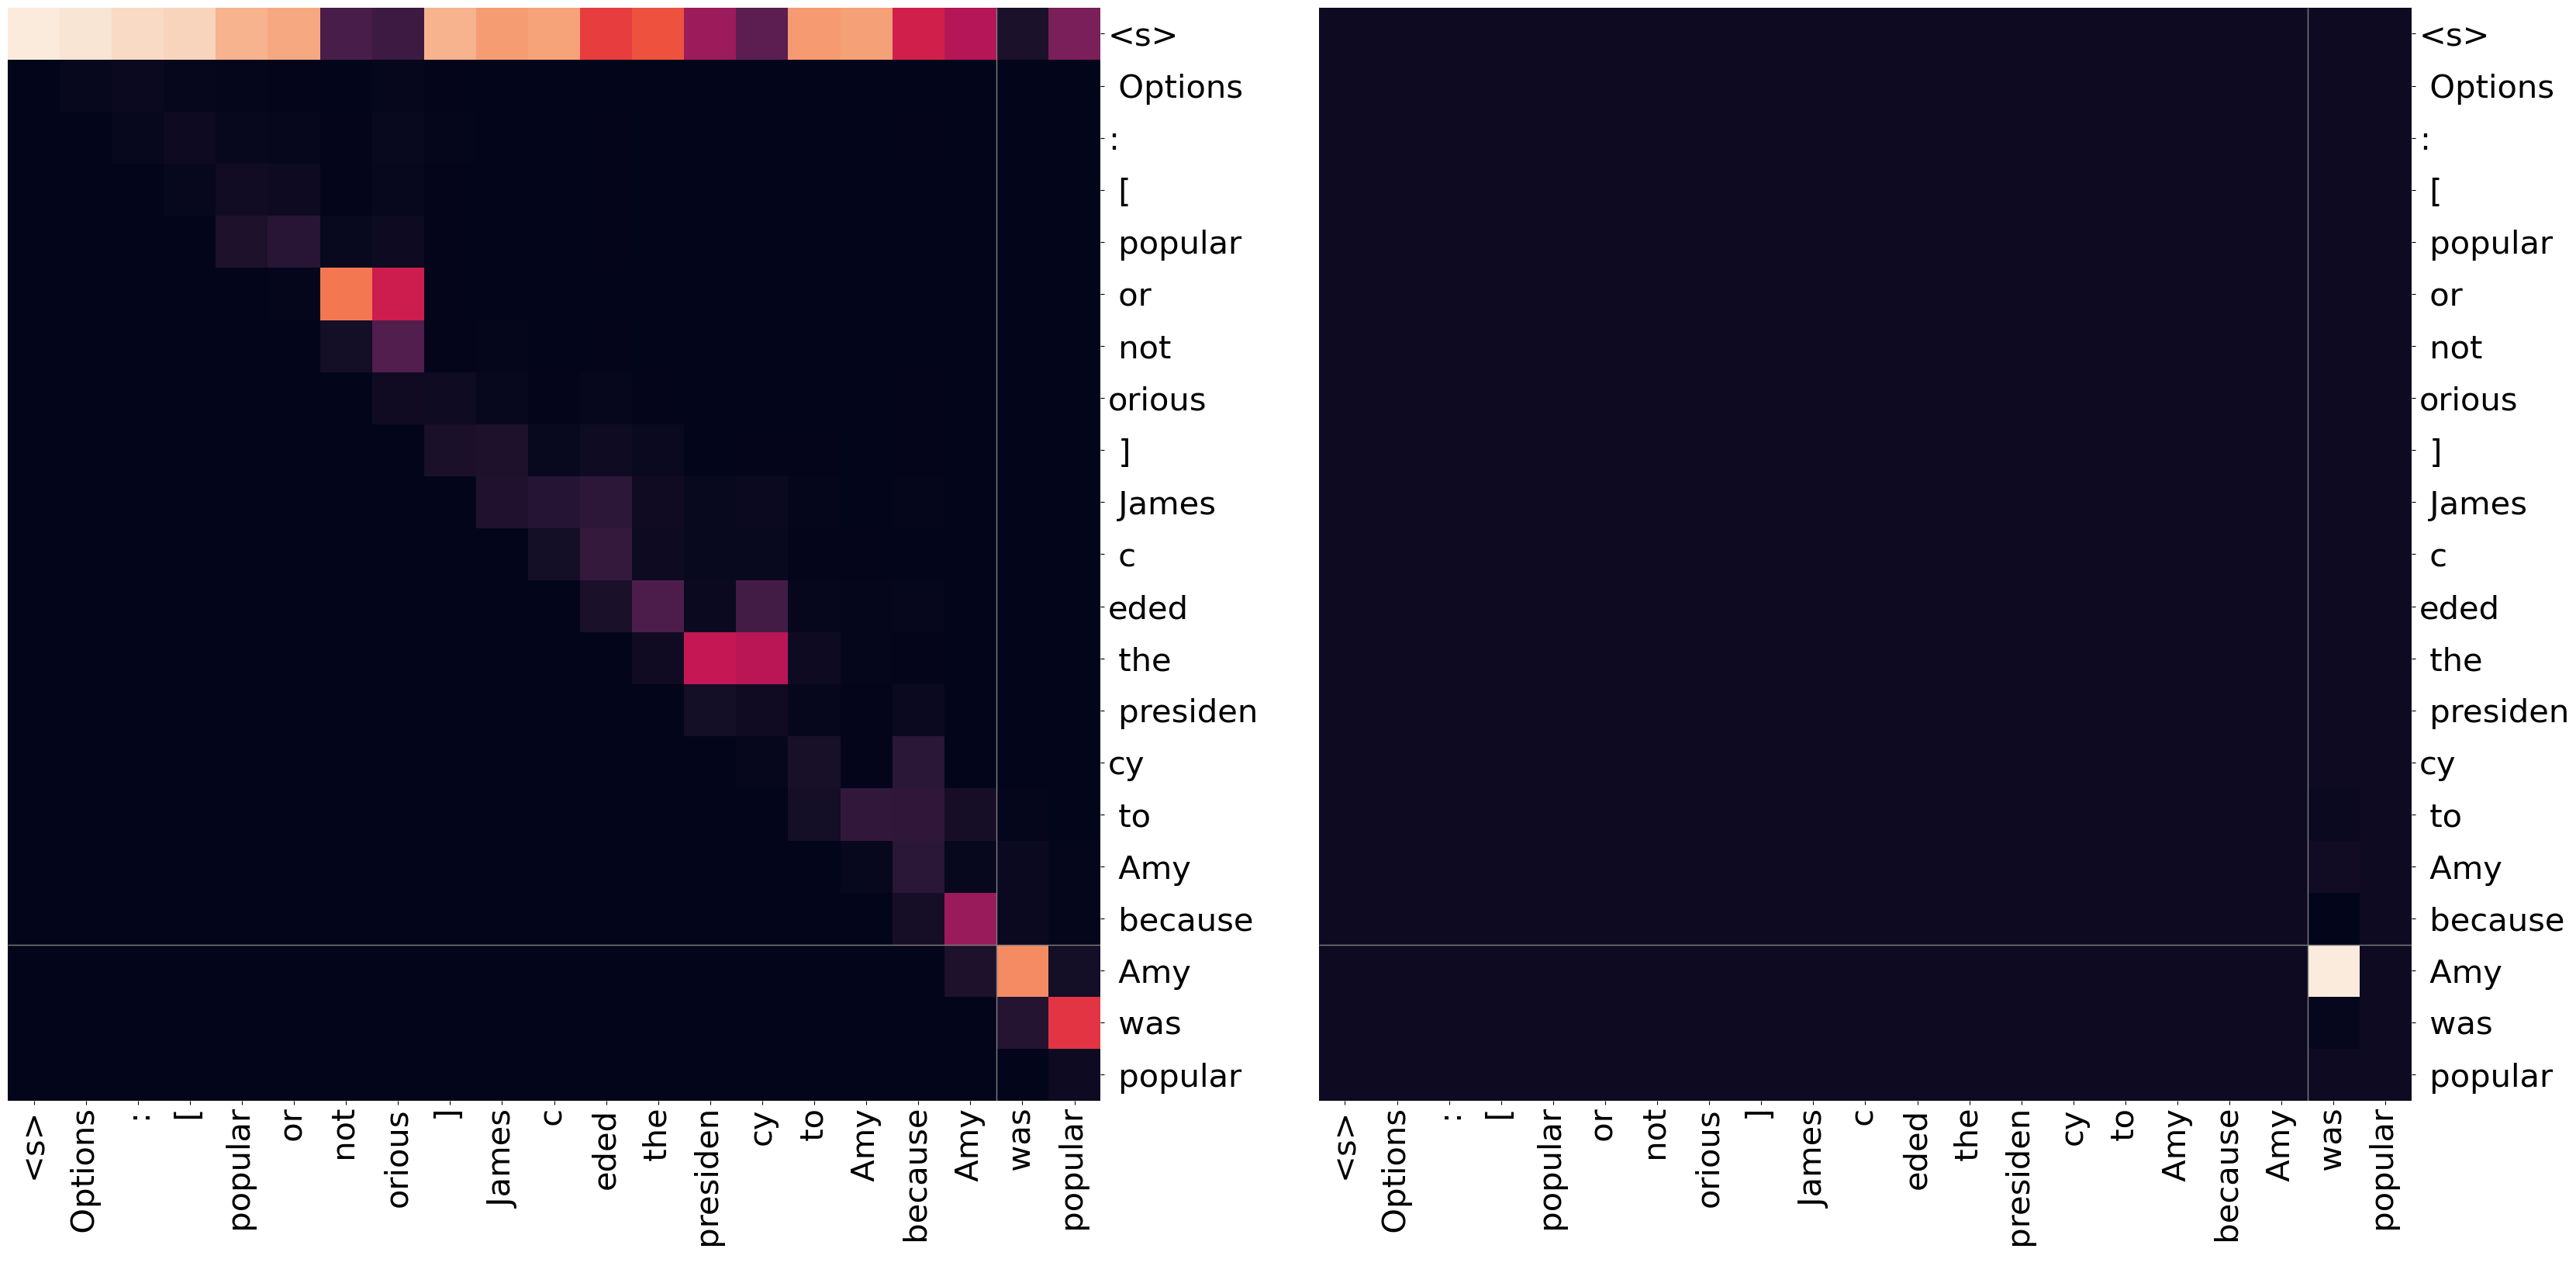

acc: 0.667 16 24
reduced_ap_scores = tensor([0.5199])


In [18]:
#44-30 12     33-11 12   26-52 13  24-52 13  17-52 12  8-37 12
#43-52 12     28-52 12   27-52 17  16-52 13  8-52 12   8-52 12
#39-52 19     31-52 12   25-52 15  23-52 9   13-52 12  9-42 12
#36-52 13     32-1 13    29-52 13  12-52 12            12-4 13  
#27-52 14      29-52 13   13-52 14 18-52 13            14-6 12
#47-52 14     29-3 13     24-52 14 15-52 12            5-52 13
#37-52 15    27-29 13     17-52 12 14-52 12            9-29 13
#22-52 16    34-31 13     21-23 12 10-52 12            7-18 12
#24-52 17     20-52 11    19-52 12 21-38 12            5-31 12
#33-52 17     32-52 11    21-0 13  4-52 12             12-18 12
#30-43 11     35-29 12    2-52 12  9-52 11
#23-52 16     36-52 12    9-52 11  21-0 12
#45-52 13     32-9 16     15-24 14 24-33 12
#55-52 16                 20-13 12  20-14 12
#                          4-52 13 25-33 12
plot_attn_attrs(r1.data_tuples, model, tokenizer, node, topi=[12], attn_patterns=['B->s1'], k_shot=0, mix=False)     #47-32:12  55-52:15  39-52:19 56-24:15 51-52:13 42-30:9/24 28-34:17/24 43-20:16/24 27-29:13/24 39-25:15/24 step1:42-30 -> 43-20:12/24  28-34 -> 43-20 15/24   27-29 -> 43-20:11/24  25-33 -> 43-20: 20/24

### before

In [21]:
def filter_fn_before(p, c):  #before
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1 and c.topi == 9 or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and (c.topi in [7,8] and ap in ['B->Ration','B->s1'])or  #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1  or
       p.step == 2  #and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [24]:
if True or r1_before.root is None: r1_before.root = add_node(None, layer=L, label_type='labels')
r1_before.root = attribute_tree_on(r1_before.data_tuples, model, r1_before.root, 2, filter_fn_before, topk=15, k_shot=0, threshold_score=0, mix=True, device=None, verbose=True)

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:00.524975
(array([30, 53, 24, 27, 26, 53, 21, 29, 25, 26]),
 array([19, 17, 20, 40, 51, 14, 12, 34,  8, 29]),
 array([0.27418137, 0.26661935, 0.22568257, 0.2233944 , 0.21794064,
       0.21560033, 0.20176189, 0.18426259, 0.17110316, 0.16993587],
      dtype=float32))
In _add_node: add @0 37-m 100
In _add_node: add @1 28-m 86
In _add_node: add @2 36-m 81
In _add_node: add @3 44-m 71
In _add_node: add @4 29-m 69
In _add_node: add @5 41-m 68
In _add_node: add @9 39-m 48
In _add_node: add @11 23-m 43
In _add_node: add @12 33-m 41
In _add_node: add @14 57-m 41
In _add_node: add @7 39-25 58 B->A0 45/12 attn
In _add_node: add @10 57-36 44 B->A0 53/12 attn
In _add_node: add @13 27-29 41 B->A0 25/8 attn
In _add_node: add @6 32-1 62 B->s1 15/26 attn
In _add_node: add @8 36-47 55 B->Ration 20/8 attn
In _add_node: add @[0,1,2,3,4,5,9,11,12,14] 37-m,28-m,36-m,44-m,29-m,41-m,39-m,23-m,33-m,57-m B->B 68
In _add_node: add @[7,10,13] 3

In attribute_tree: attribute_step @[2,4,5,6,7,9,13]  B->inter ... done 0:00:00.371610
In _add_node: add @0 10-m 100
In _add_node: add @1 8-m 95
In _add_node: add @2 13-m 85
In _add_node: add @3 11-m 73
In _add_node: add @5 12-m 52
In _add_node: add @8 3-m 38
In _add_node: add @4 15-2 60 inter->Ration 28/50
In _add_node: add @6 13-42 42 inter->Ration 13/27
In _add_node: add @7 13-29 41 inter->Ration 7/8
In _add_node: add @9 4-20 37 inter->Ration 59/38
In _add_node: add @10 10-23 37 inter->Ration 32/23
In _add_node: add @12 7-46 34 inter->Ration 42/28
In _add_node: add @14 13-51 33 inter->Ration 19/19
In _add_node: add @11 8-39 34 inter->s2 16/26
In _add_node: add @13 9-39 34 inter->io 7/21
In _add_node: add @[0,1,2,3,5,8] 10-m,8-m,13-m,11-m,12-m,3-m inter->inter 43
In _add_node: add @[4,6,7,9,10,12,14] 15-2,13-42,13-29,4-20,10-23,7-46,13-51 inter->Ration 15
In _add_node: add @[11,13] 8-39,9-39 unk 0
In attribute_tree: attribute_step 8-34,11-25 B->Ration attn ... done 0:00:00.188390
In _

In [25]:
print_tree(r1_before.root)

 ┌@[0,1,2,3,4,5,9,11,12,14] 37-m,28-m,36-m,44-m,29-m,41-m,39-m,23-m,33-m,57-m B->B 68
 ├@[7,10,13] 39-25,57-36,27-29 B->A0 10
 ├@[6,8] 32-1,36-47 unk 0
 ├@0 37-m 100
 ├@1 28-m 86
 ├@2 36-m 81
 ├@3 44-m 71
 ├@4 29-m 69
 ├@5 41-m 68
 ├@9 39-m 48
 ├@11 23-m 43
 ├@12 33-m 41
 ├@14 57-m 41
 ├@7 39-25 58 B->A0 45/12 attn
 ├@10 57-36 44 B->A0 53/12 attn
 ├@13 27-29 41 B->A0 25/8 attn
 ├@6 32-1 62 B->s1 15/26 attn
 ├@8 36-47 55 B->Ration 20/8 attn
 ┤
 │         ┌@[0,1,4,5,13] 30-m,26-m,34-m 22,32-47 15,35-m 7 B->B 32
 │         ├@[3,9,10,11] 28-7 23,26-29 10,27-25 9,28-47 9 B->nA0 10
 │         ├@[7,12] 18-1 13,36-26 9 B->Ration 10
 │         ├@[2,14] 33-25 27,22-48 7 B->io 8
 │         ├@[6,8] 38-13 13,23-22 10 B->s1 8
 │         ├@0 30-m 100
 │         ├@1 26-m 34
 │         ├@4 34-m 22
 │         ├@5 32-47 15 B->B 29/11
 │         ├@13 35-m 7
 │         ├@3 28-7 23 B->nA0 37/11 attn
 │         ├@9 26-29 10 B->nA0 21/21 attn
 │         ├@10 27-25 9 B->nA0 24/11 attn
 │         ├@11 28-47 9 B

In [32]:
node = r1_before.root.children[-1].children[-3].children[-2]
node.name

'@[2,4,5,6,7,9,13]  B->inter'

4-20 -> @[2,4,5,6,7,9,13]  B->inter -> 18-1 B->Ration attn
resulting ap_scores = tensor([0.2093], device='cuda:1') tensor(0.2093, device='cuda:1')
ap_scores = tensor([0.3455]) tensor(0.3455)


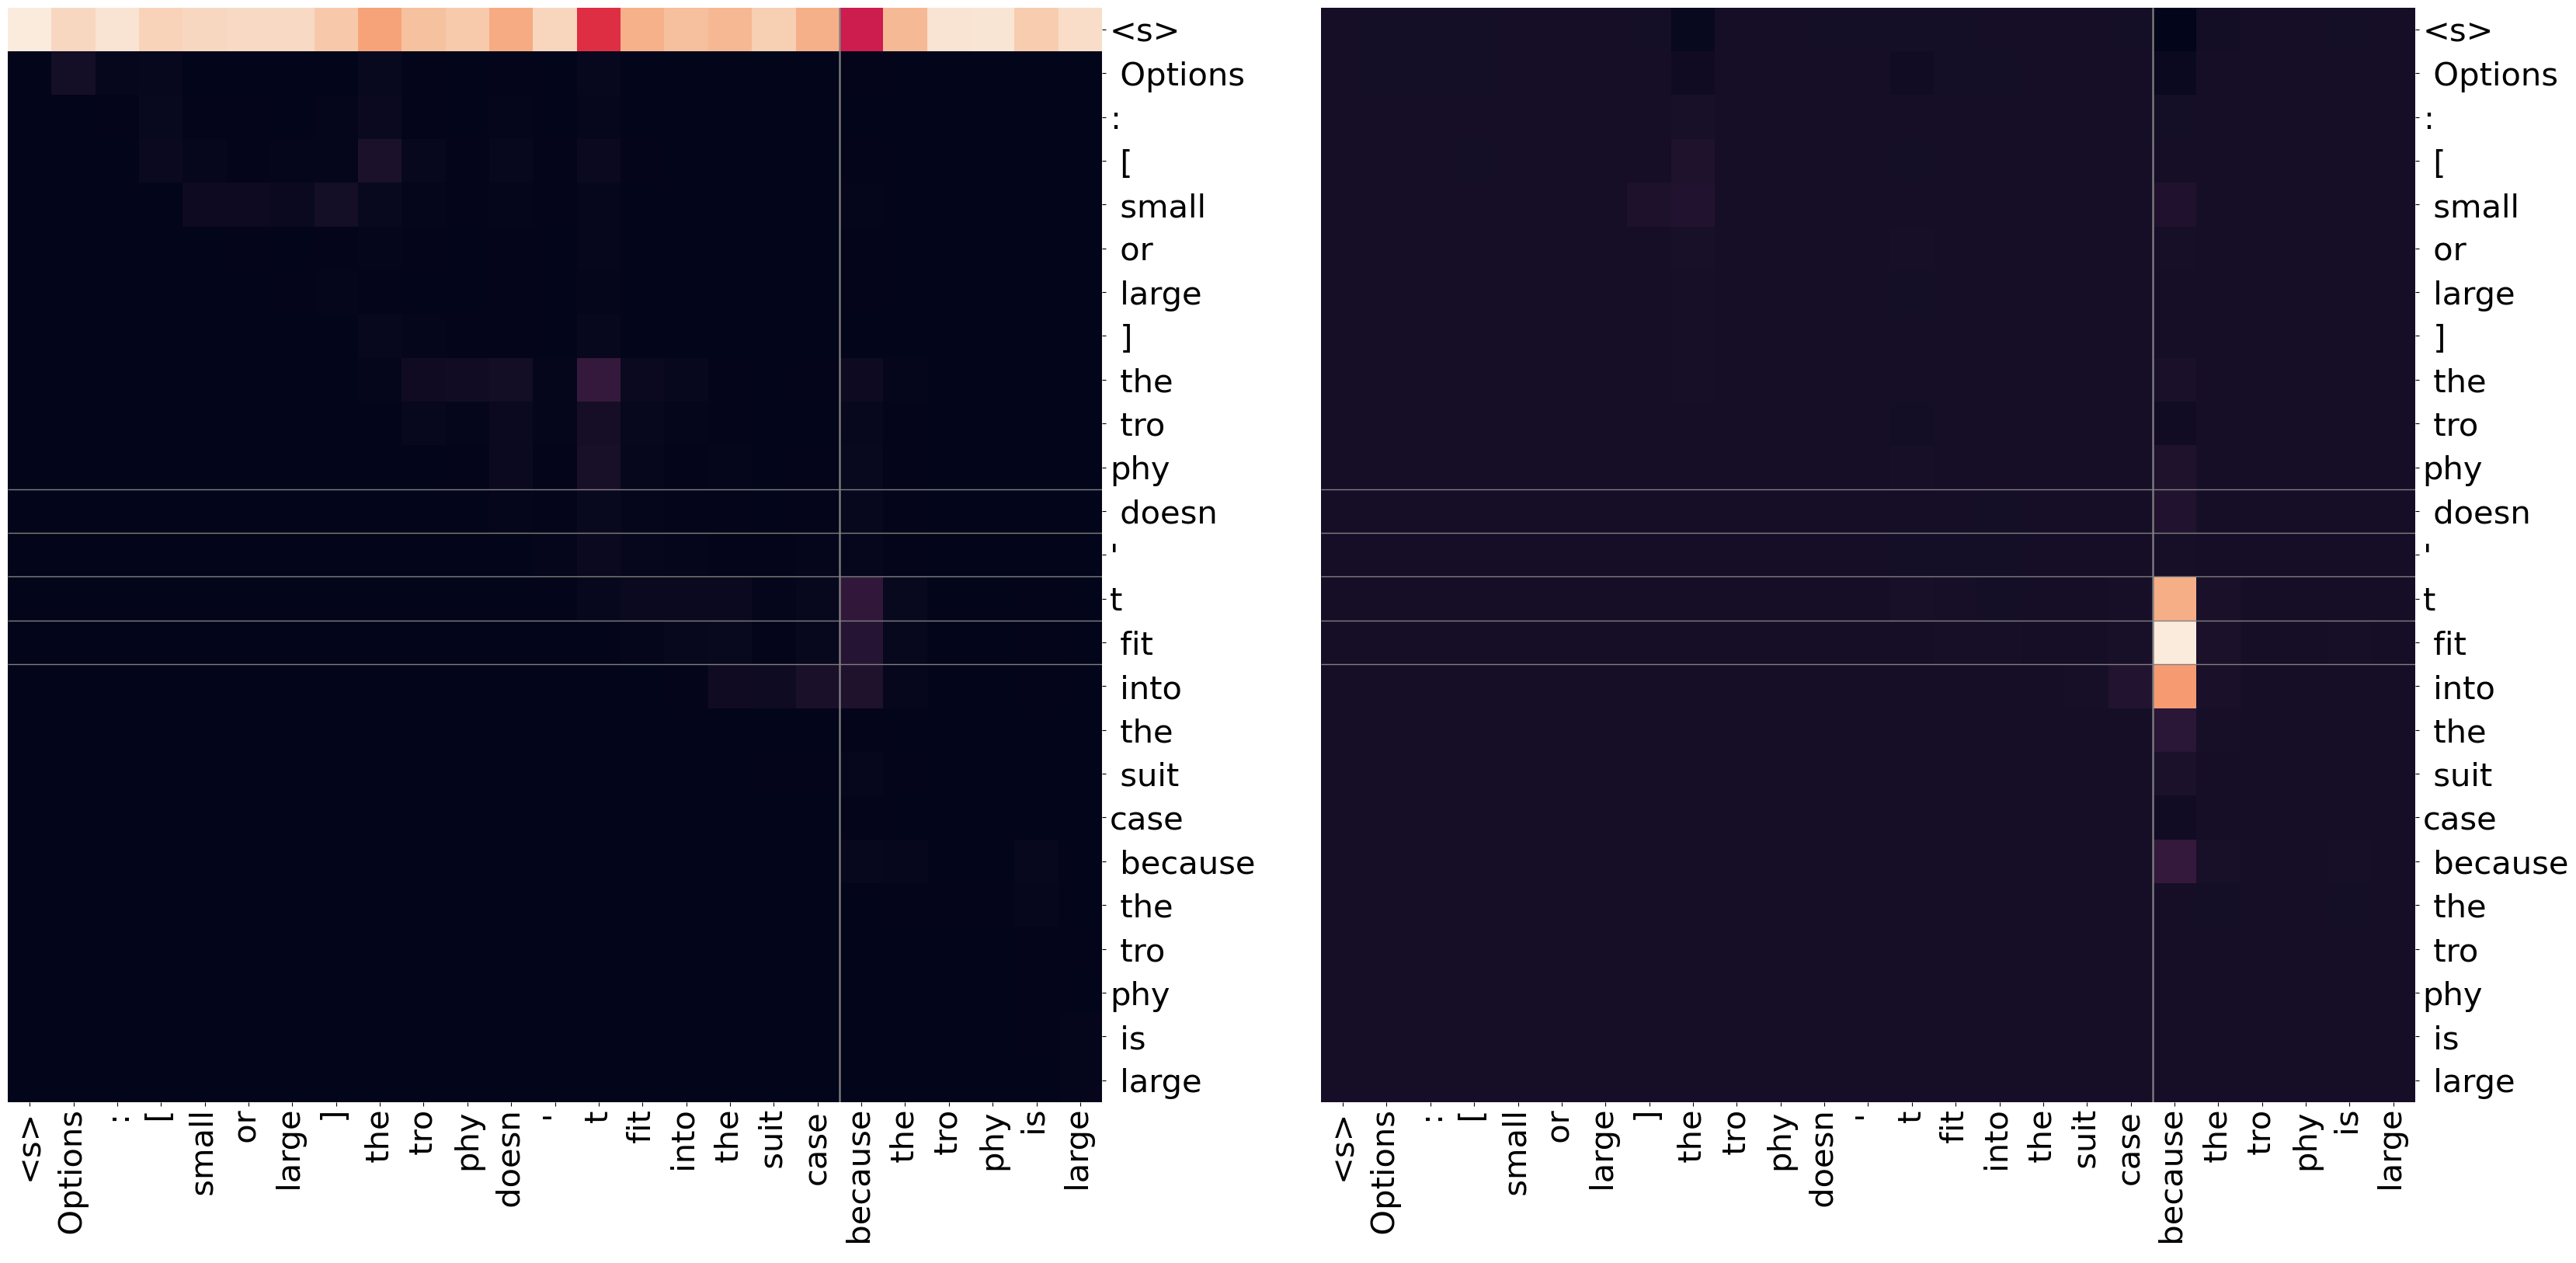

resulting ap_scores = tensor([0.3192], device='cuda:1') tensor(0.3192, device='cuda:1')
ap_scores = tensor([0.3988]) tensor(0.3988)


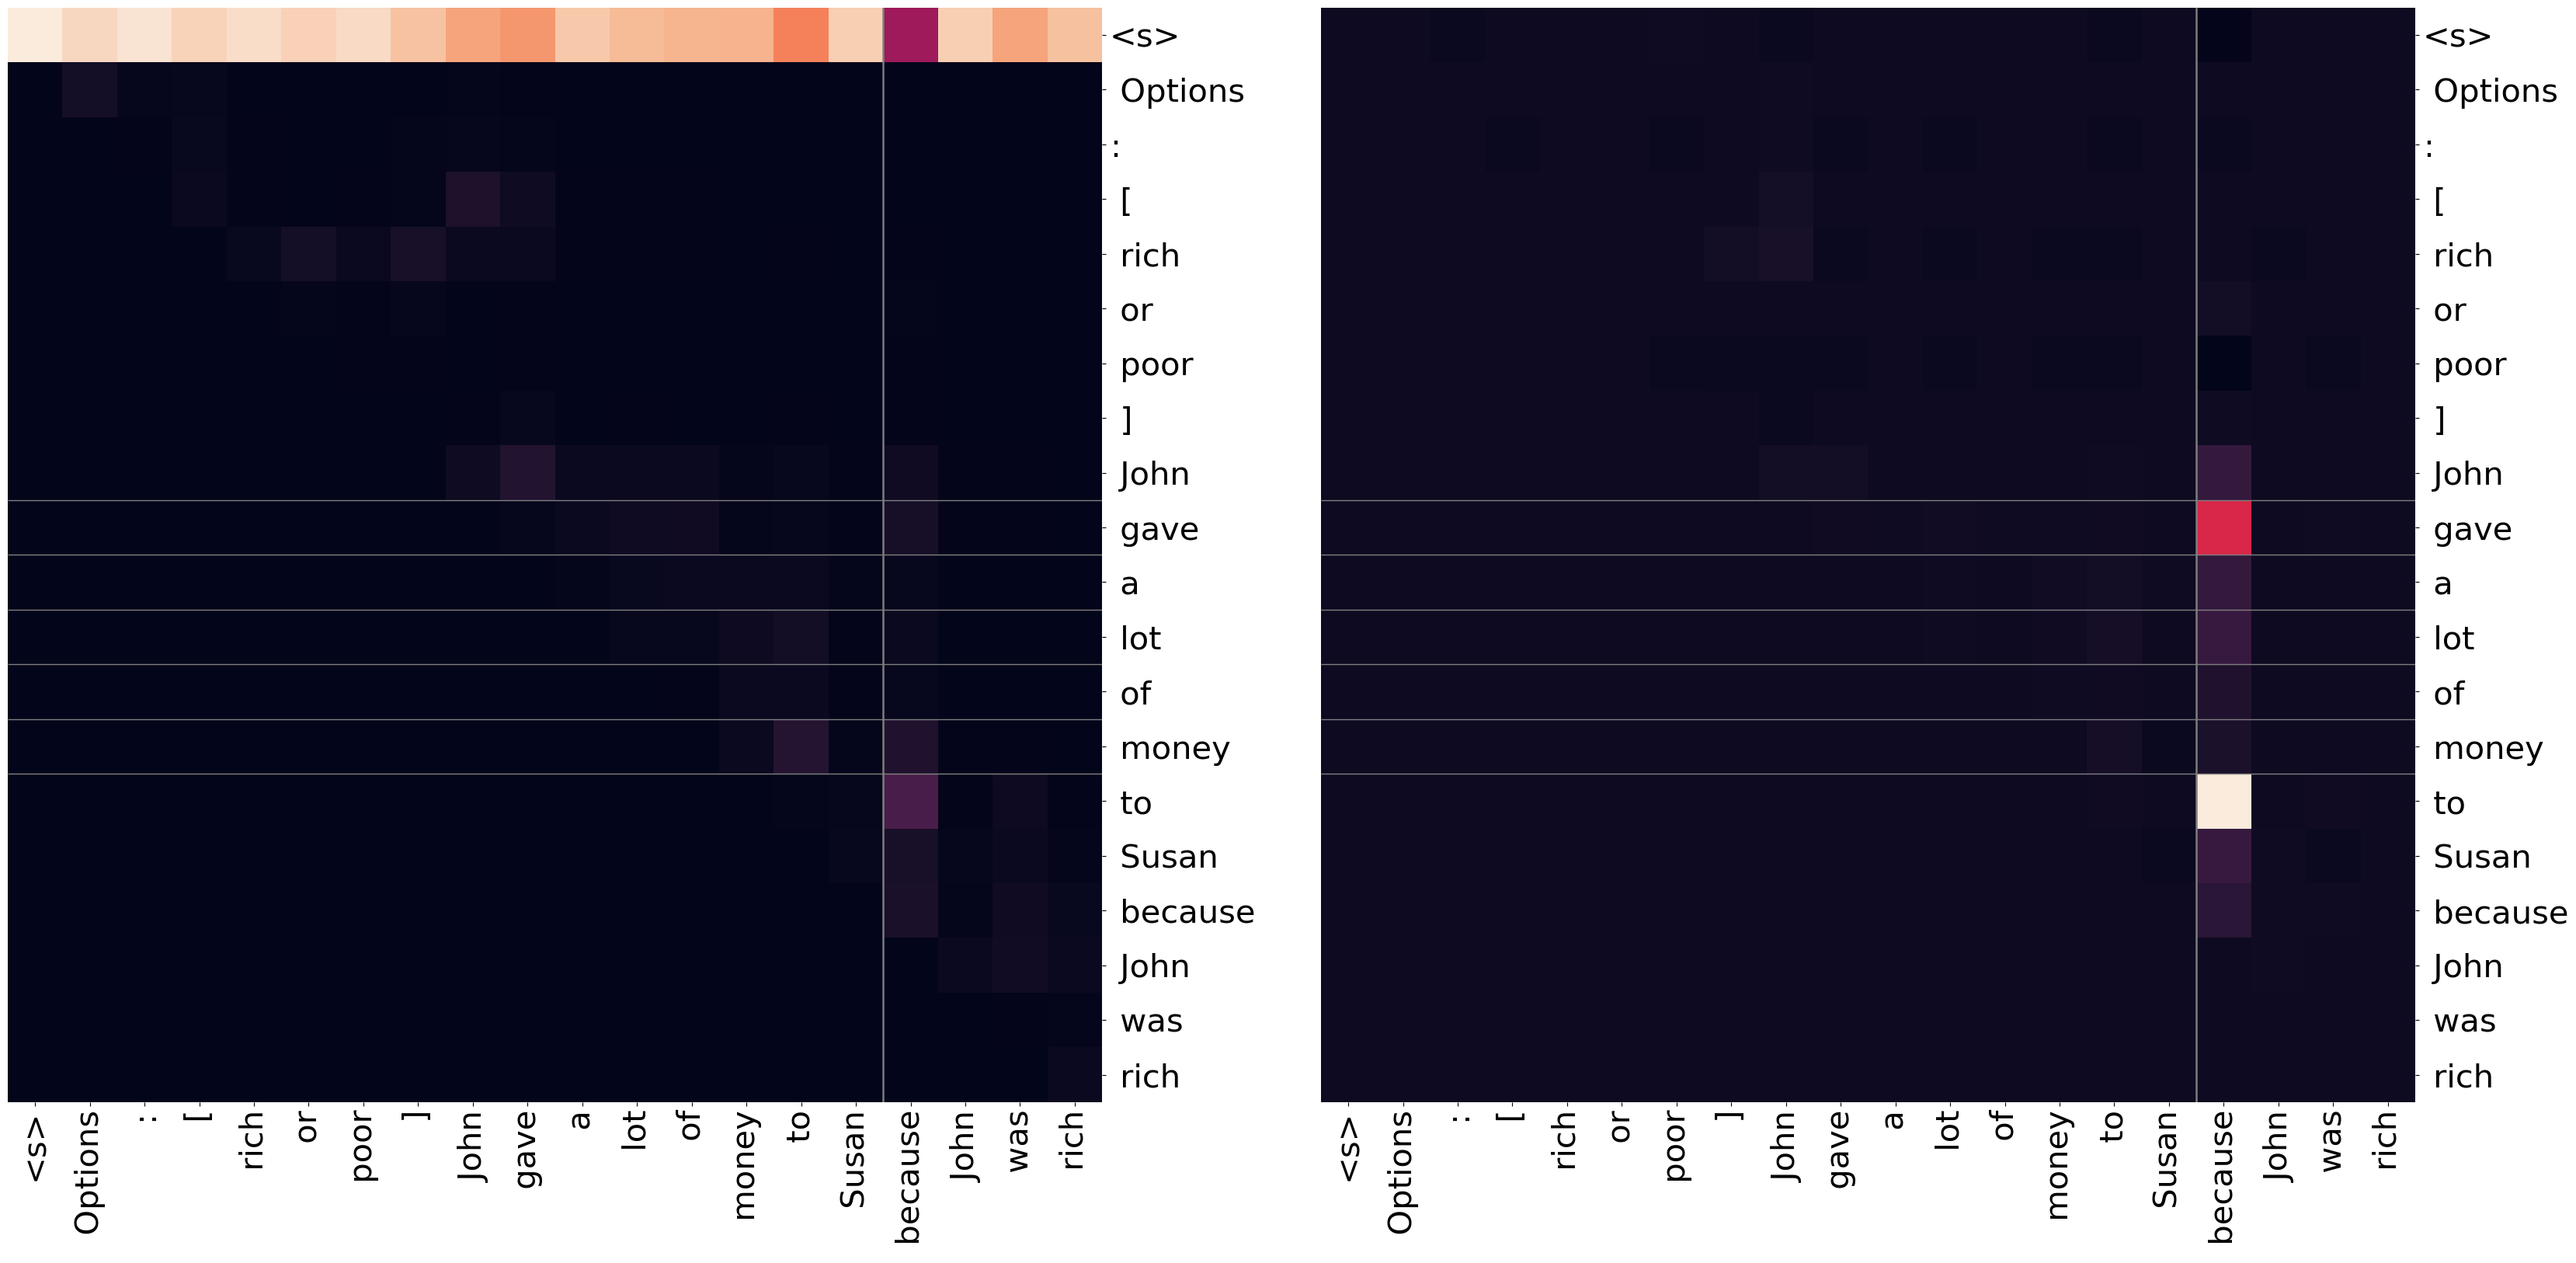

resulting ap_scores = tensor([0.1371], device='cuda:1') tensor(0.1371, device='cuda:1')
ap_scores = tensor([0.3623]) tensor(0.3623)


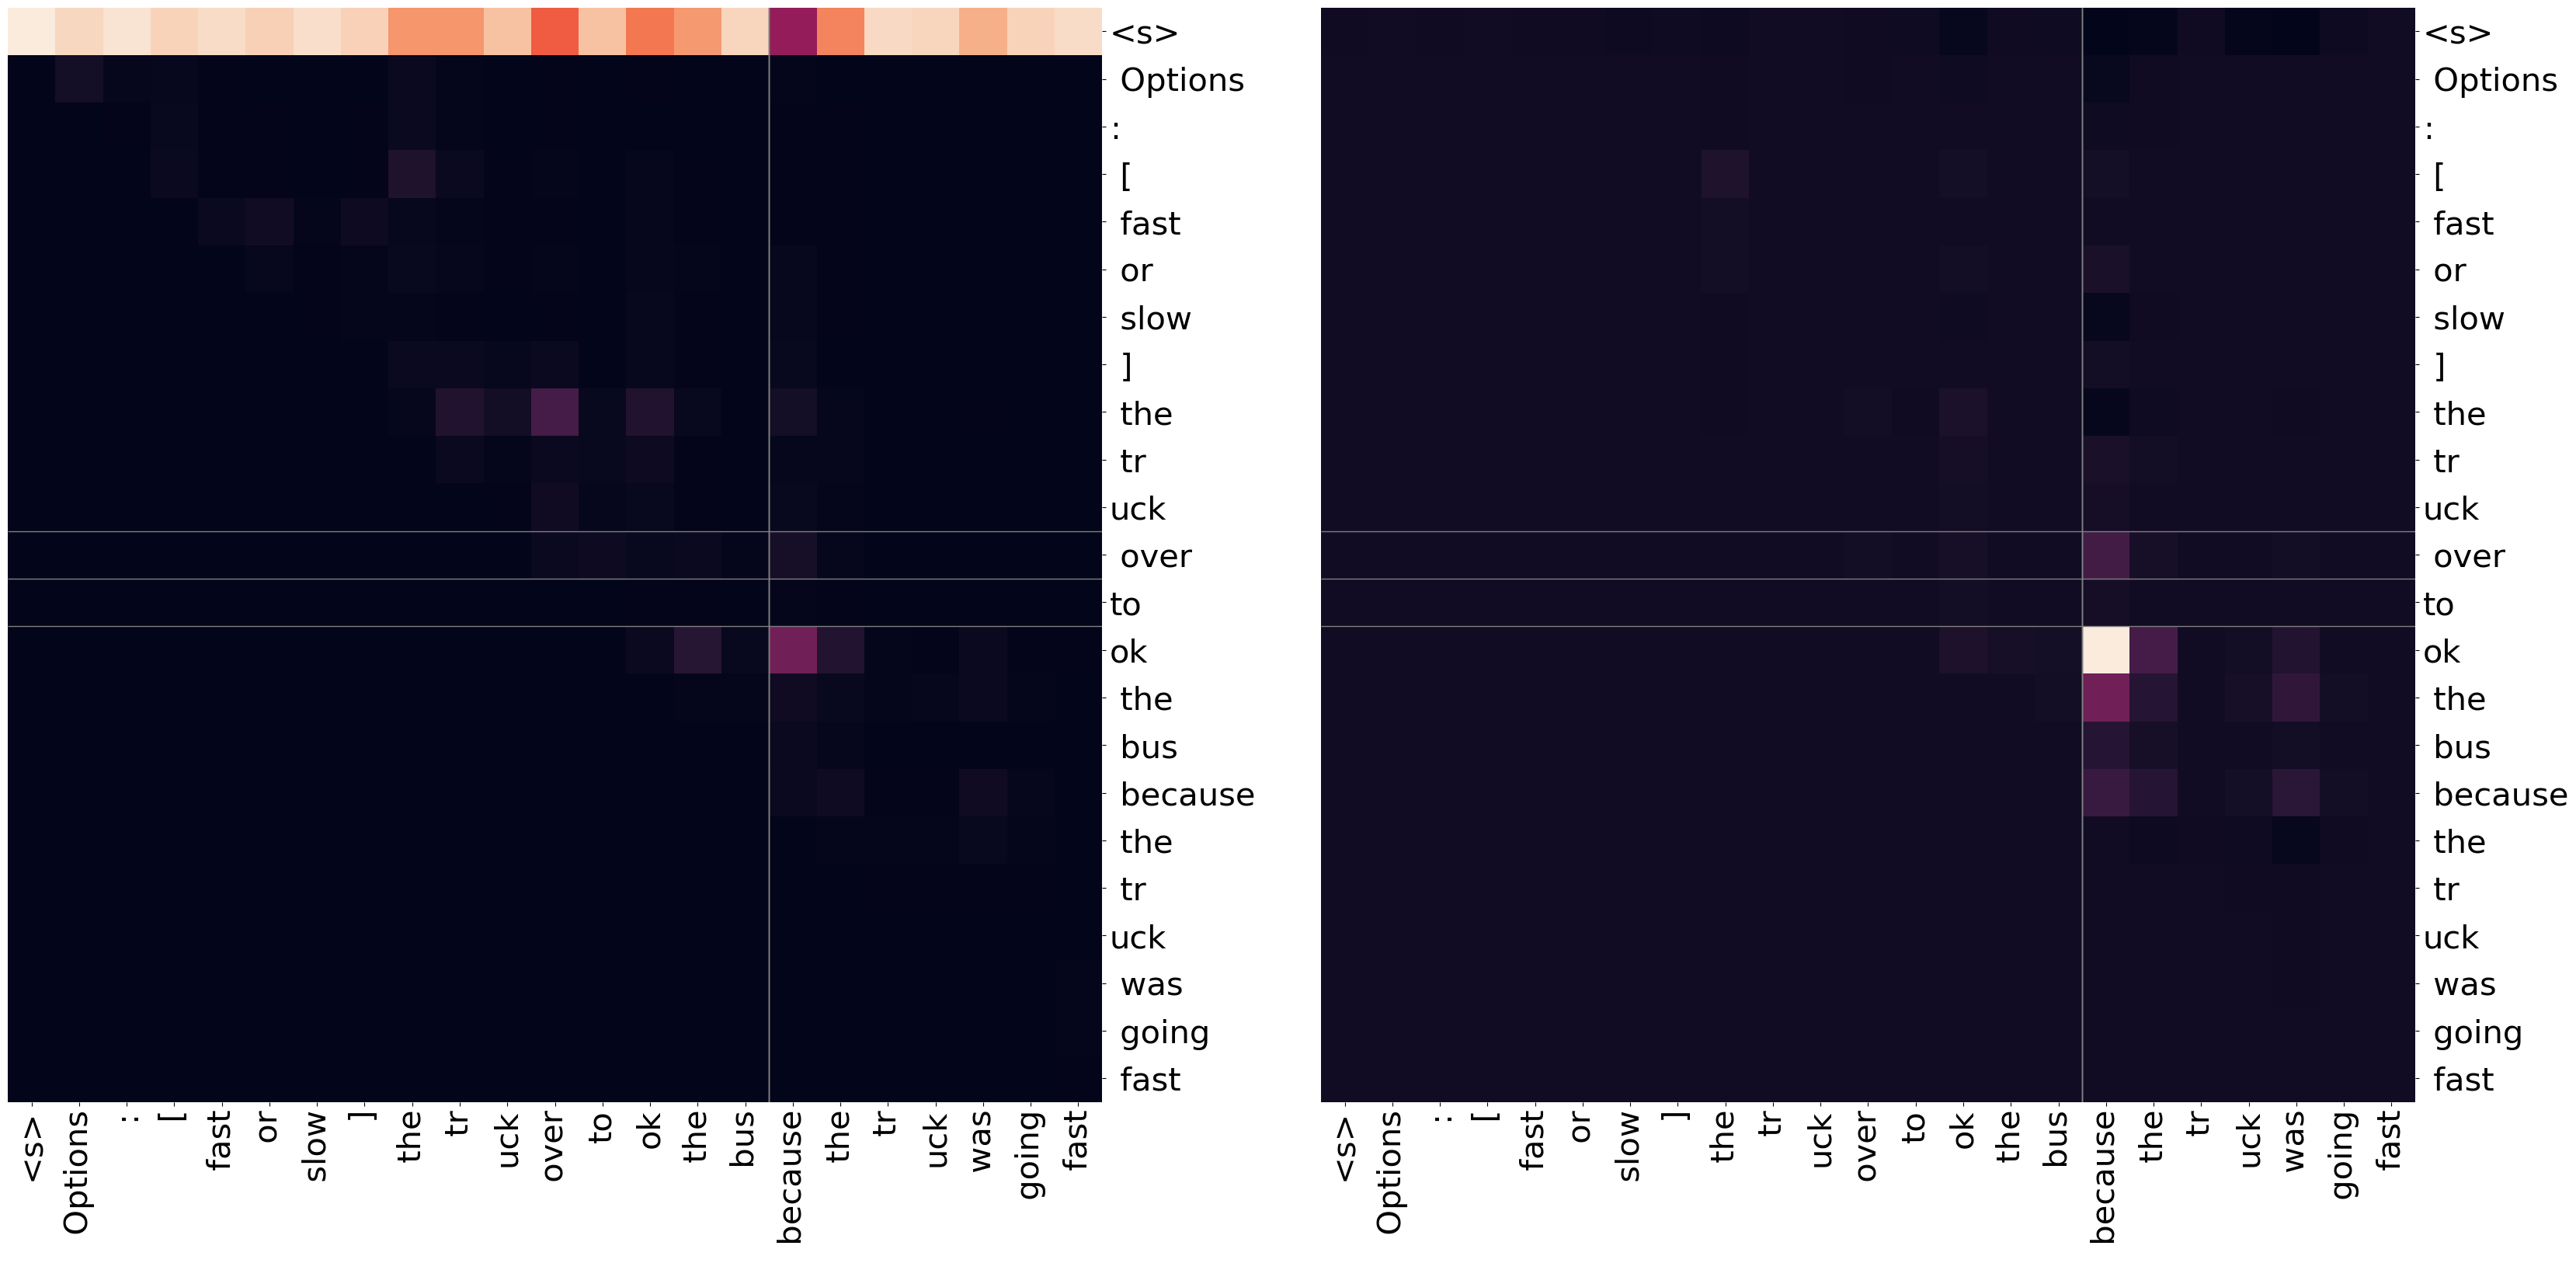

resulting ap_scores = tensor([0.2052], device='cuda:1') tensor(0.2052, device='cuda:1')
ap_scores = tensor([0.4837]) tensor(0.4837)


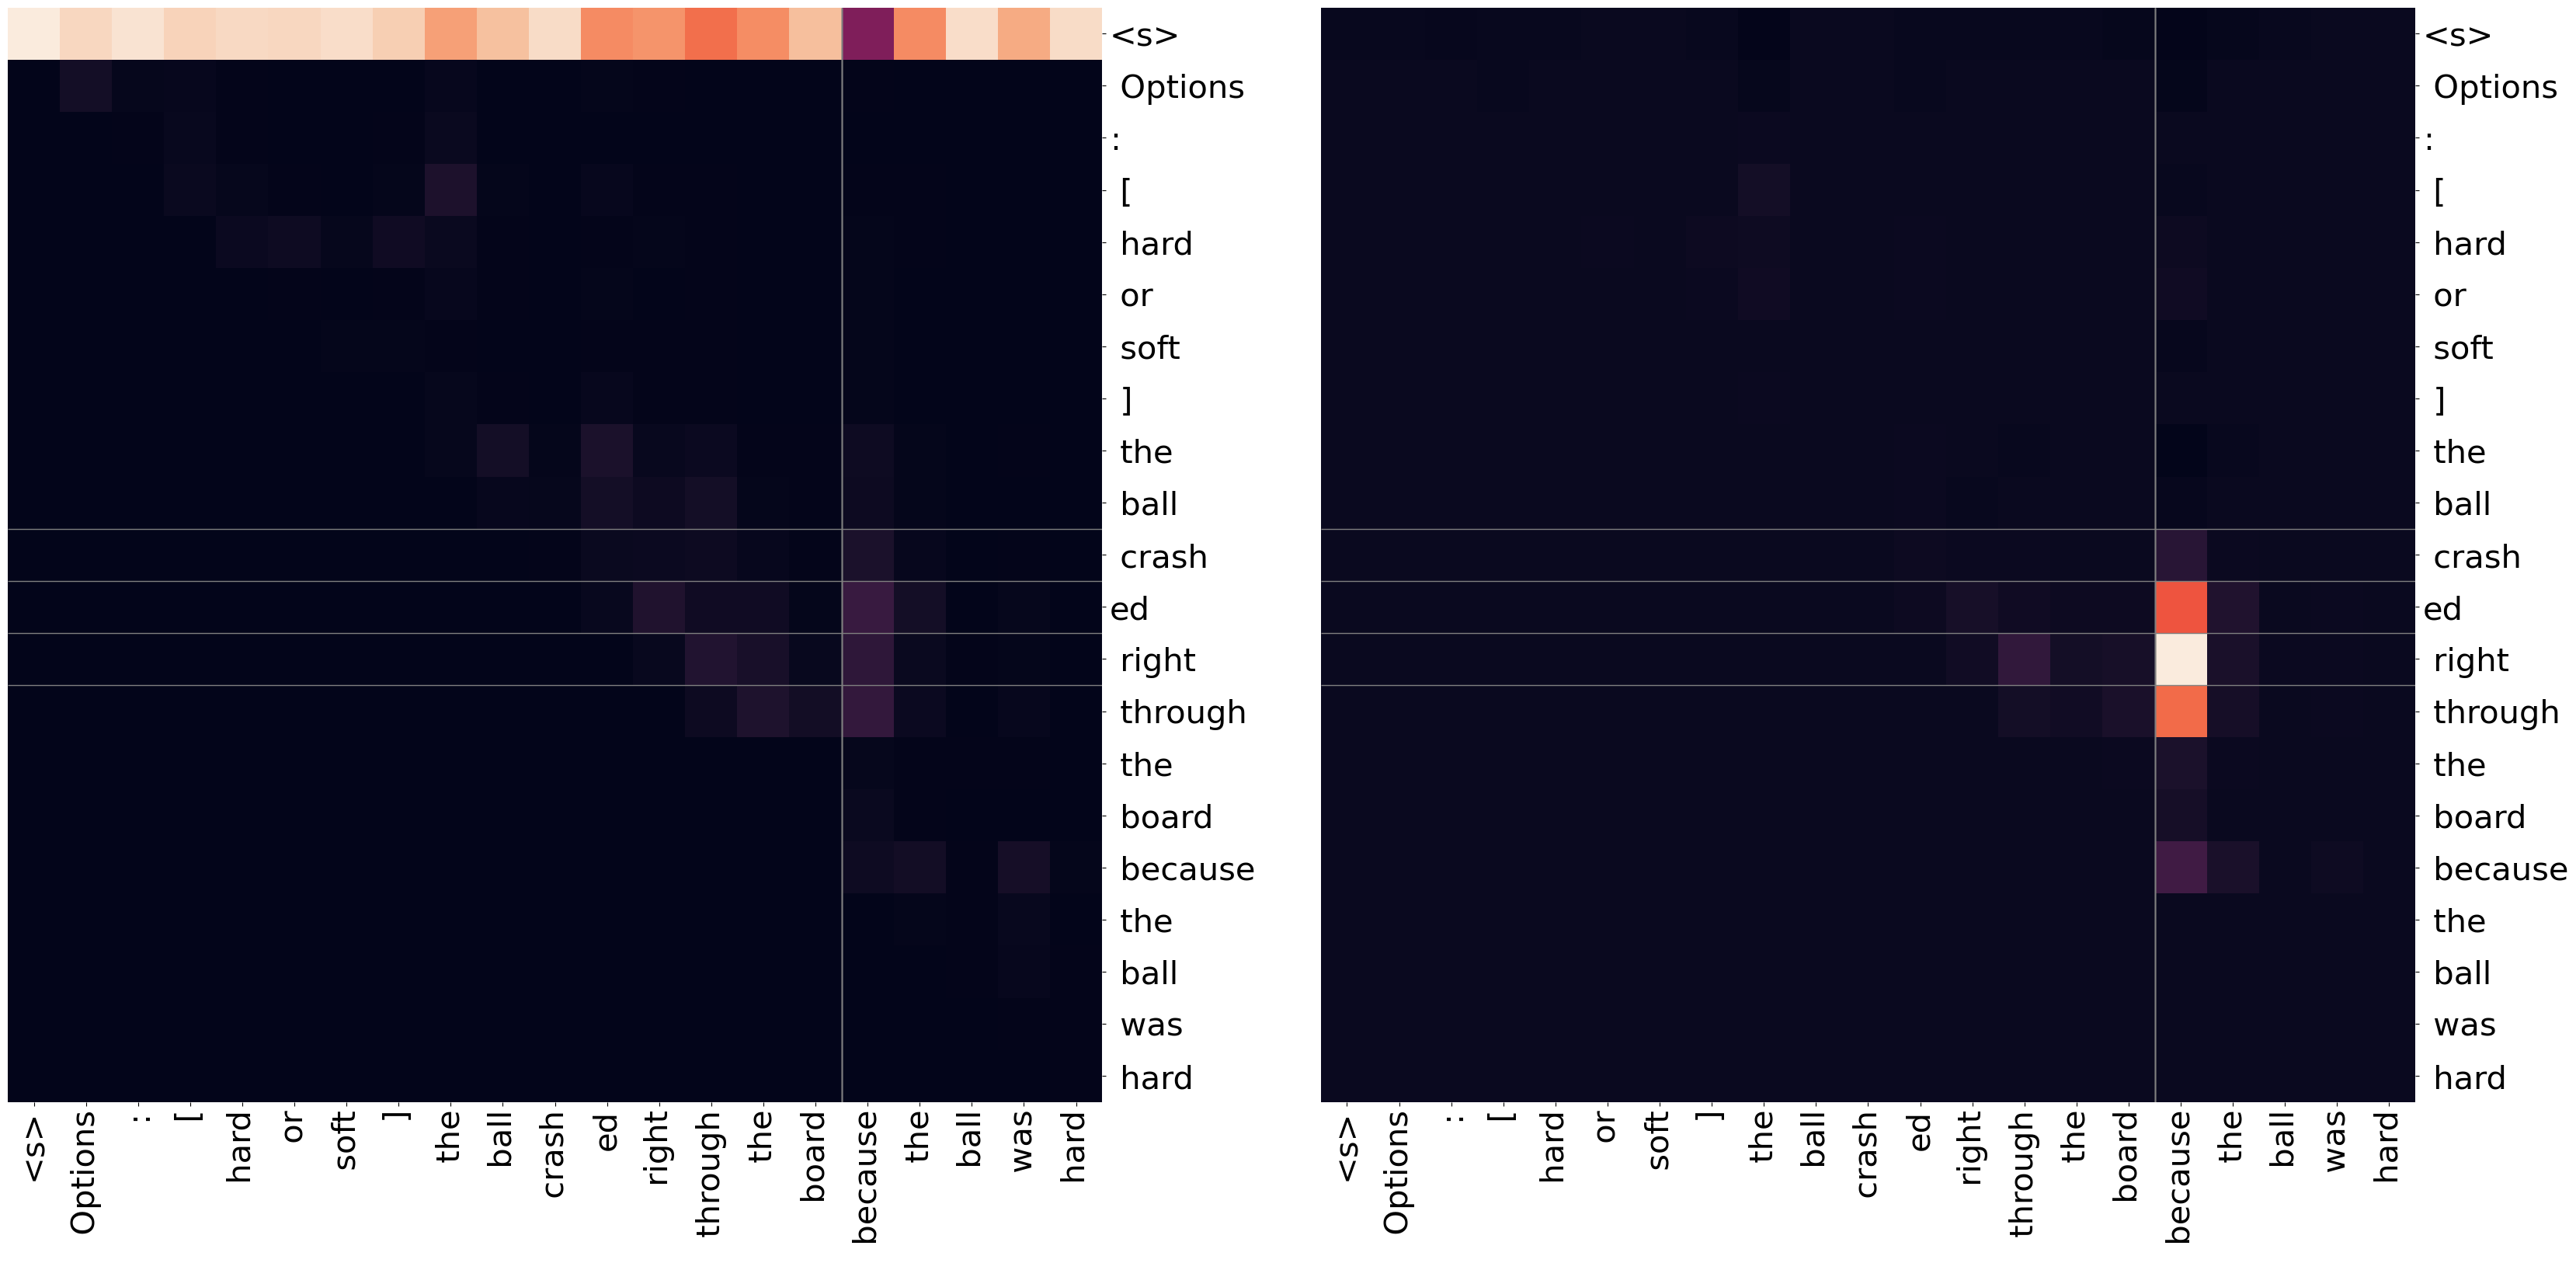

resulting ap_scores = tensor([0.3515], device='cuda:1') tensor(0.3515, device='cuda:1')
ap_scores = tensor([0.3447]) tensor(0.3447)


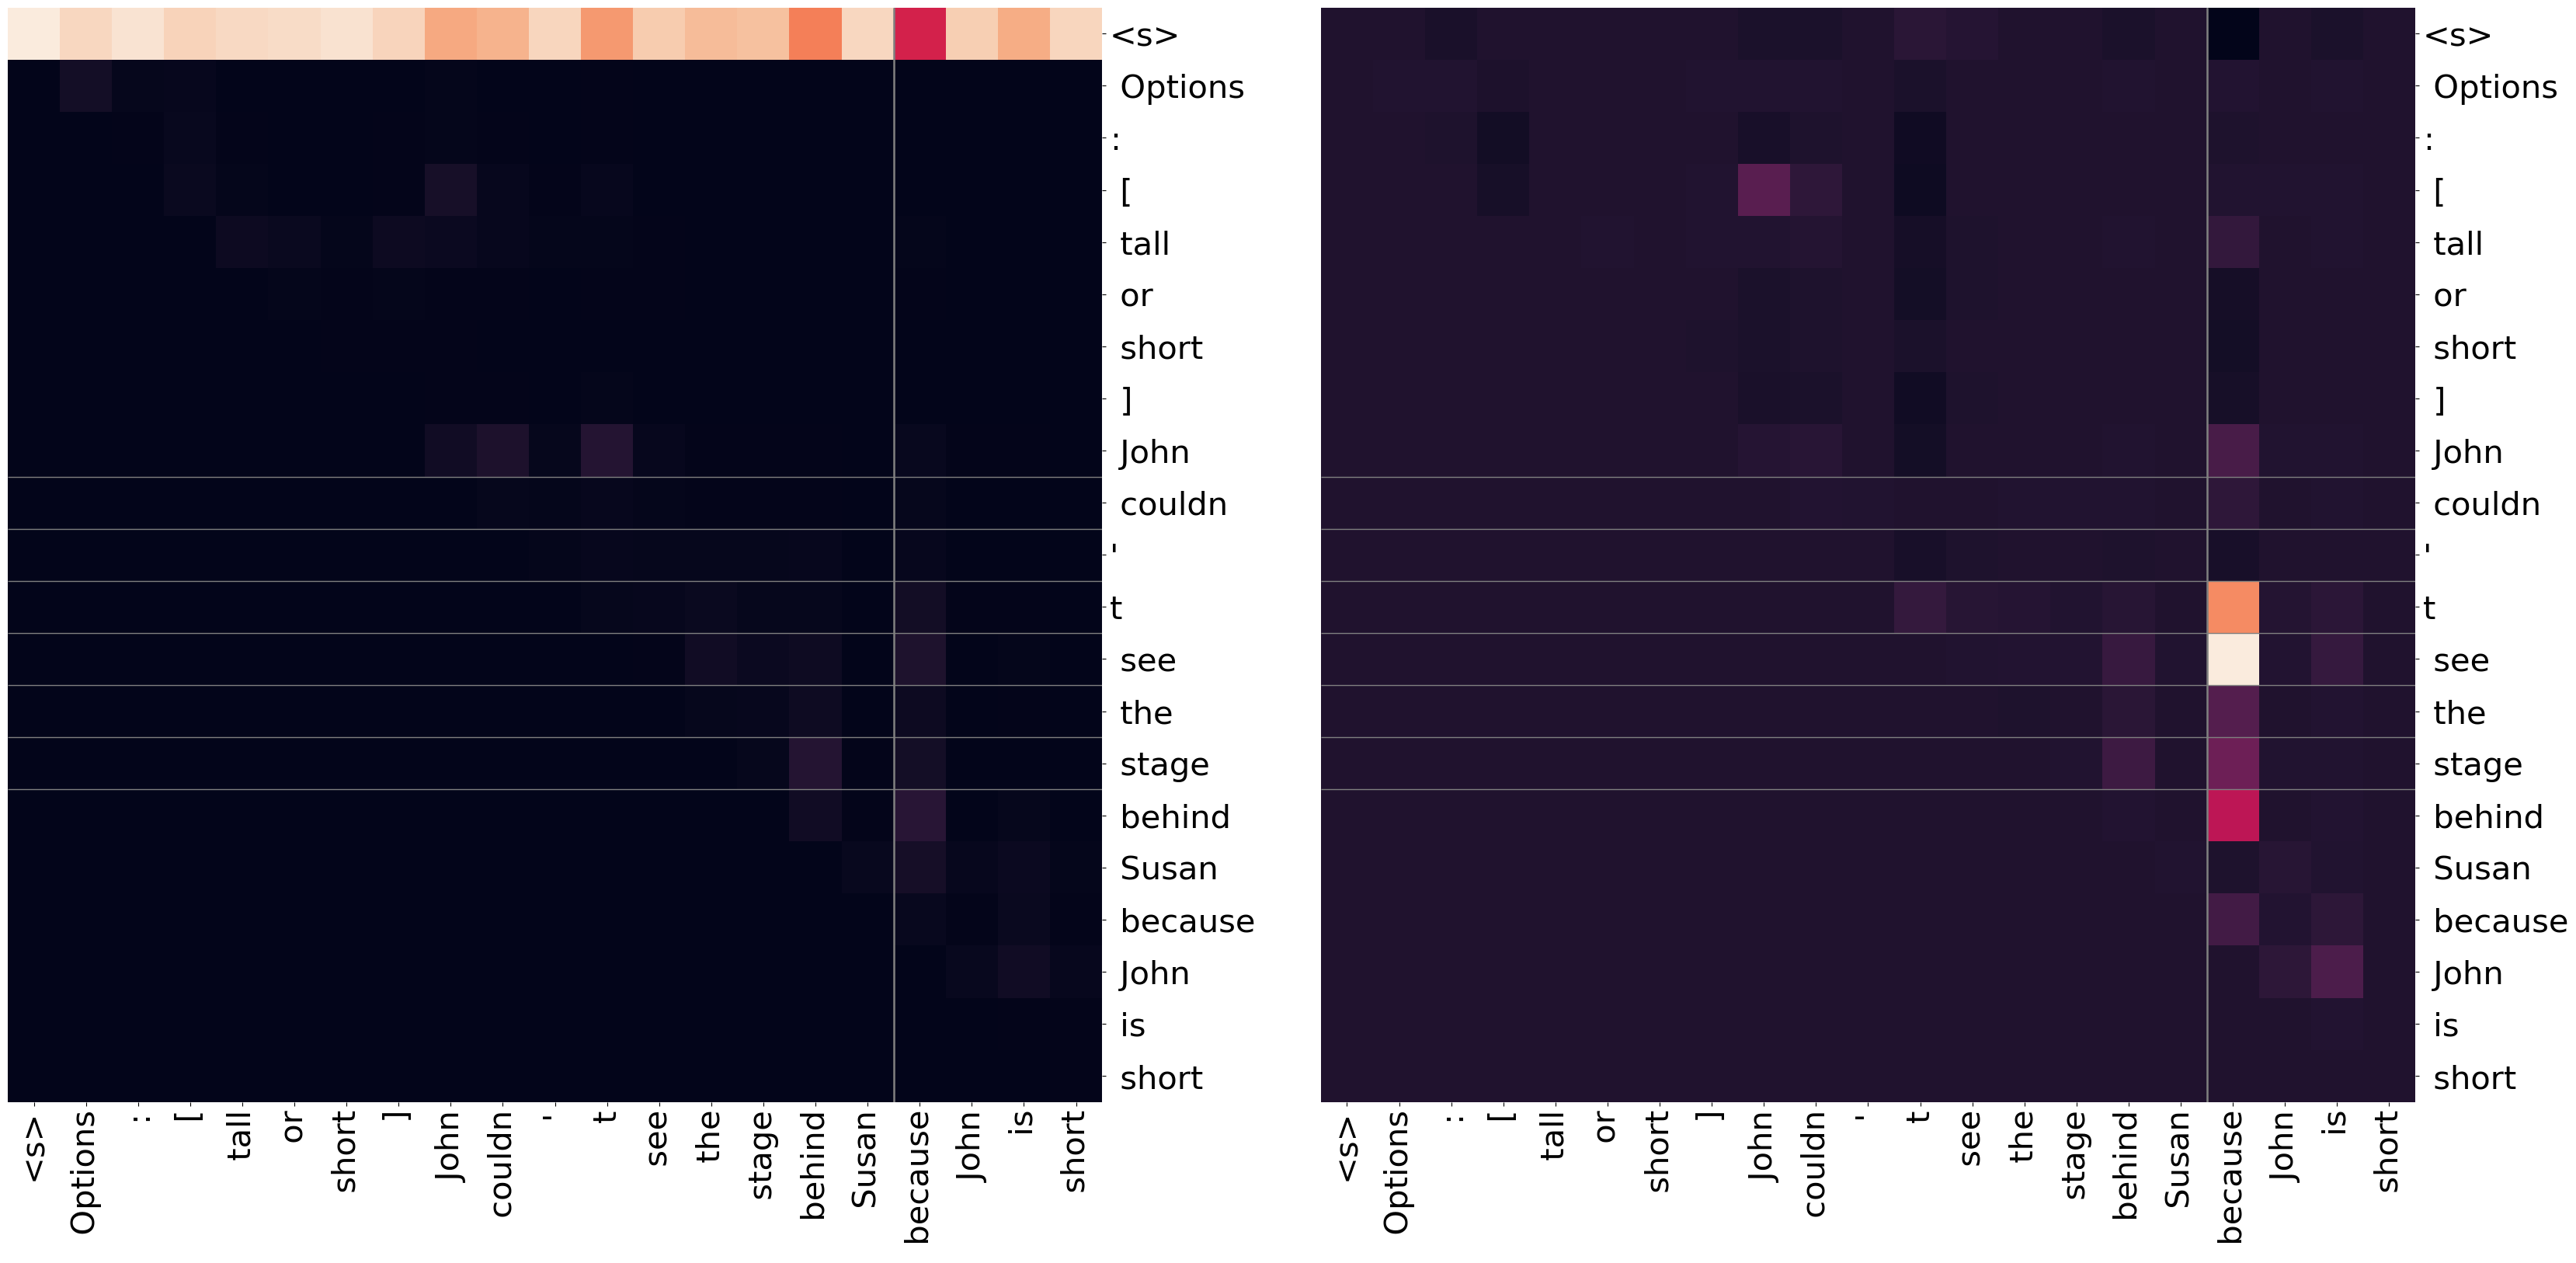

resulting ap_scores = tensor([0.1251], device='cuda:1') tensor(0.1251, device='cuda:1')
ap_scores = tensor([0.3220]) tensor(0.3220)


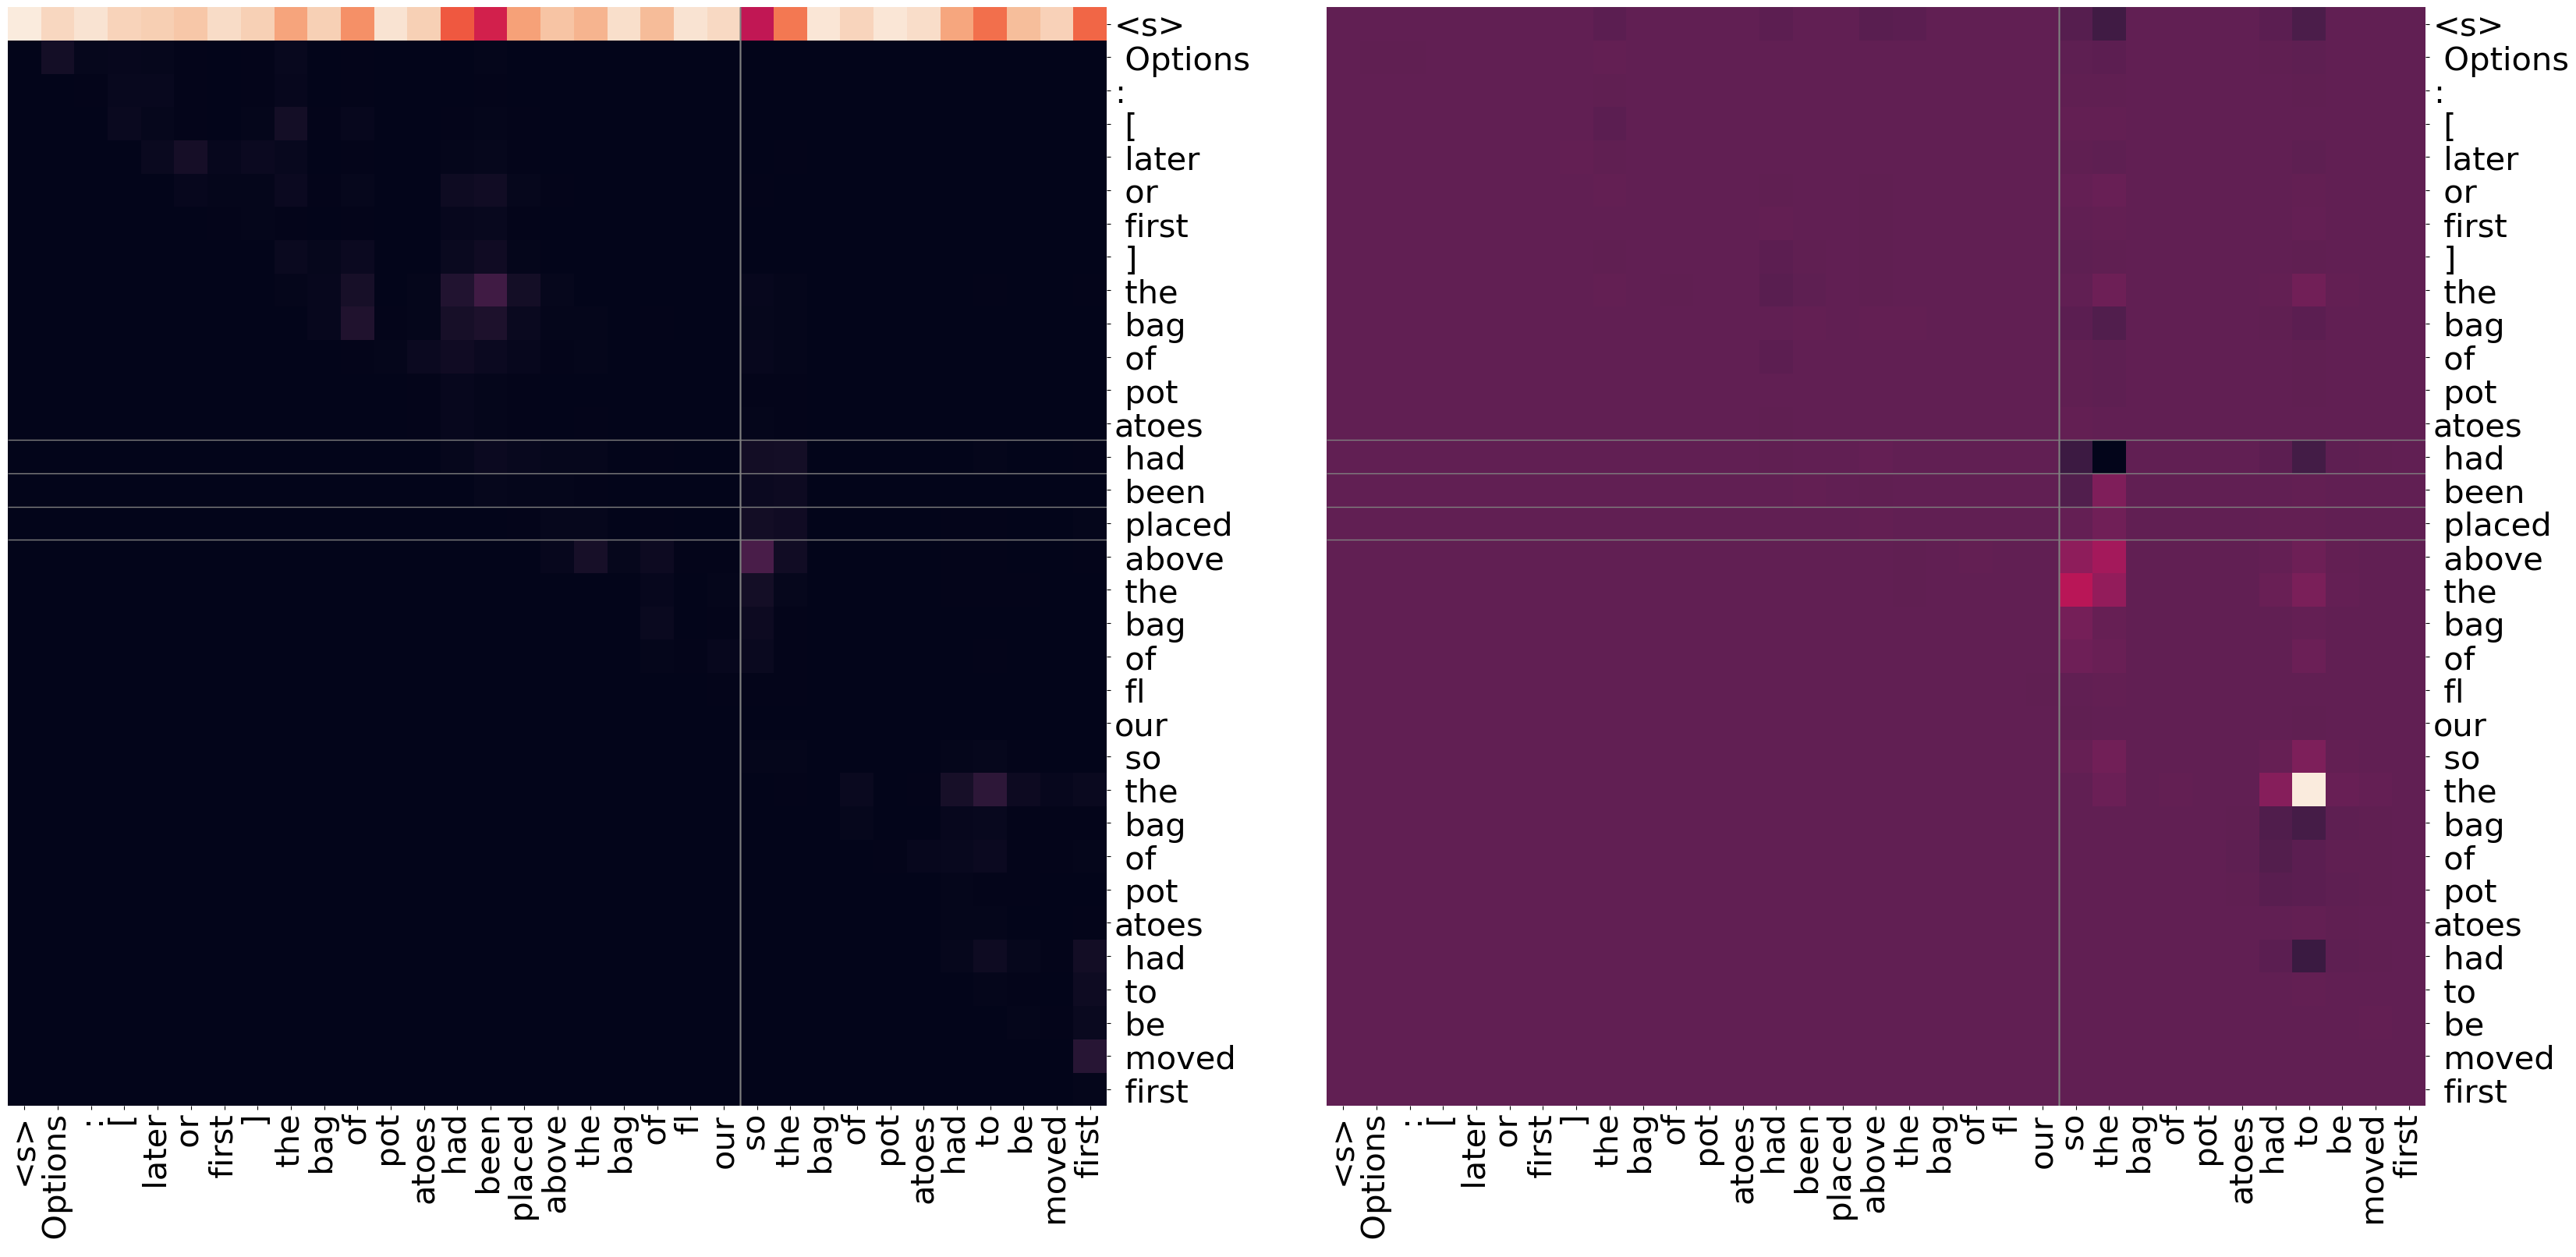

resulting ap_scores = tensor([0.2210], device='cuda:1') tensor(0.2210, device='cuda:1')
ap_scores = tensor([0.3326]) tensor(0.3326)


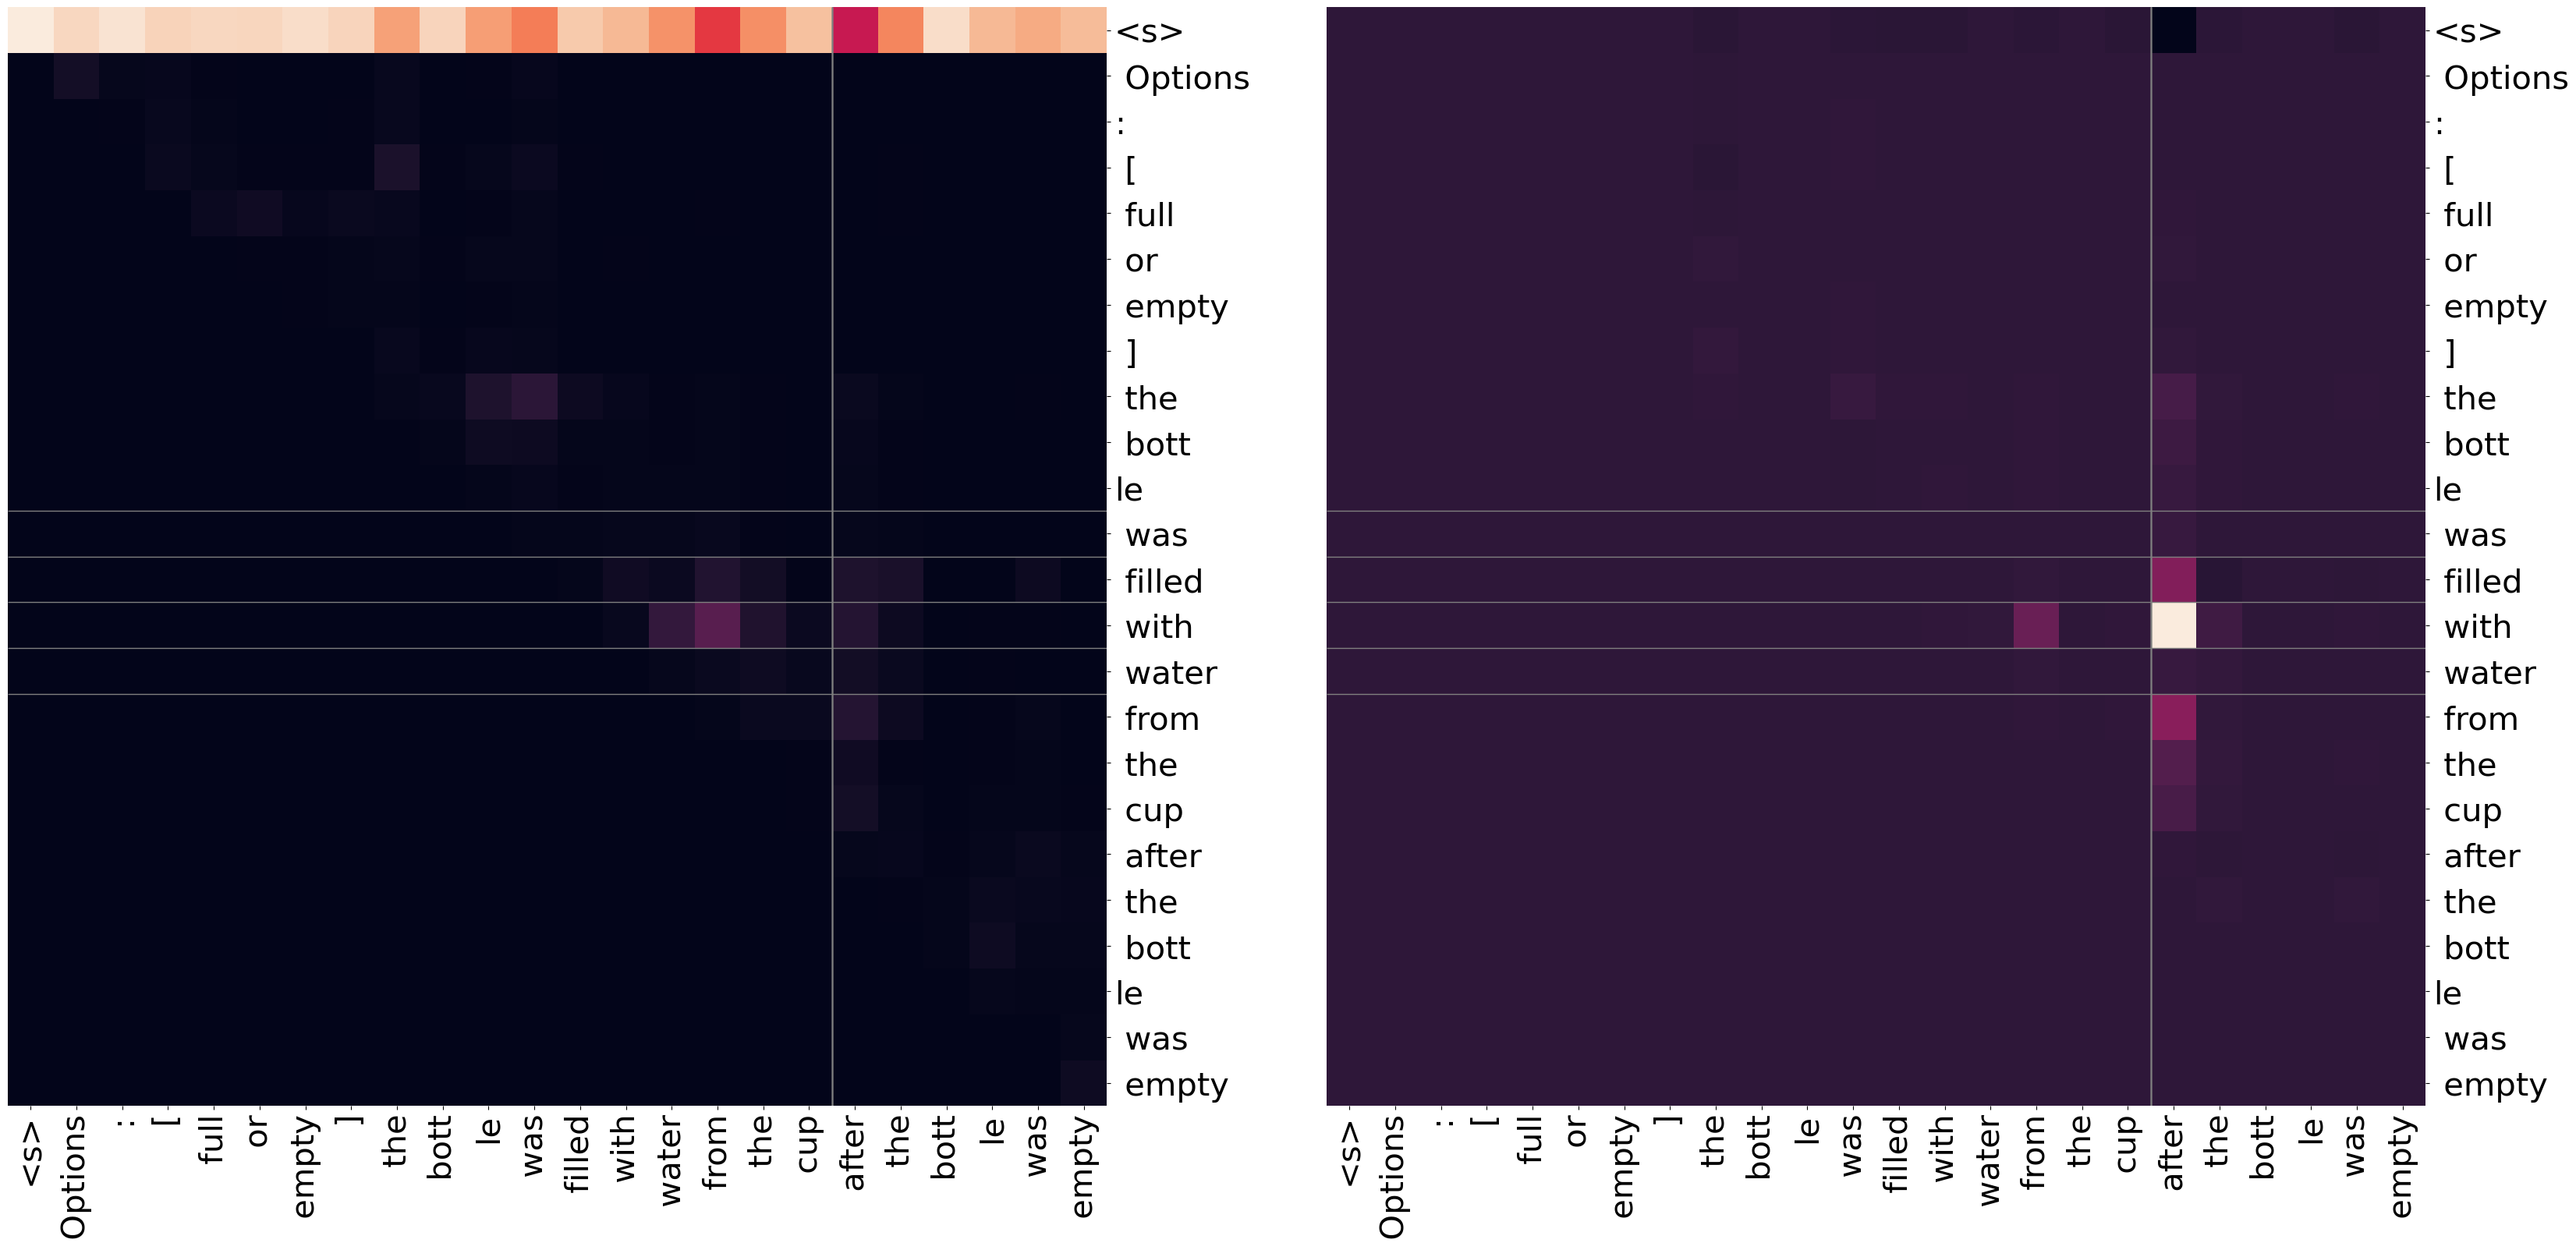

resulting ap_scores = tensor([0.2382], device='cuda:1') tensor(0.2382, device='cuda:1')
ap_scores = tensor([0.3084]) tensor(0.3084)


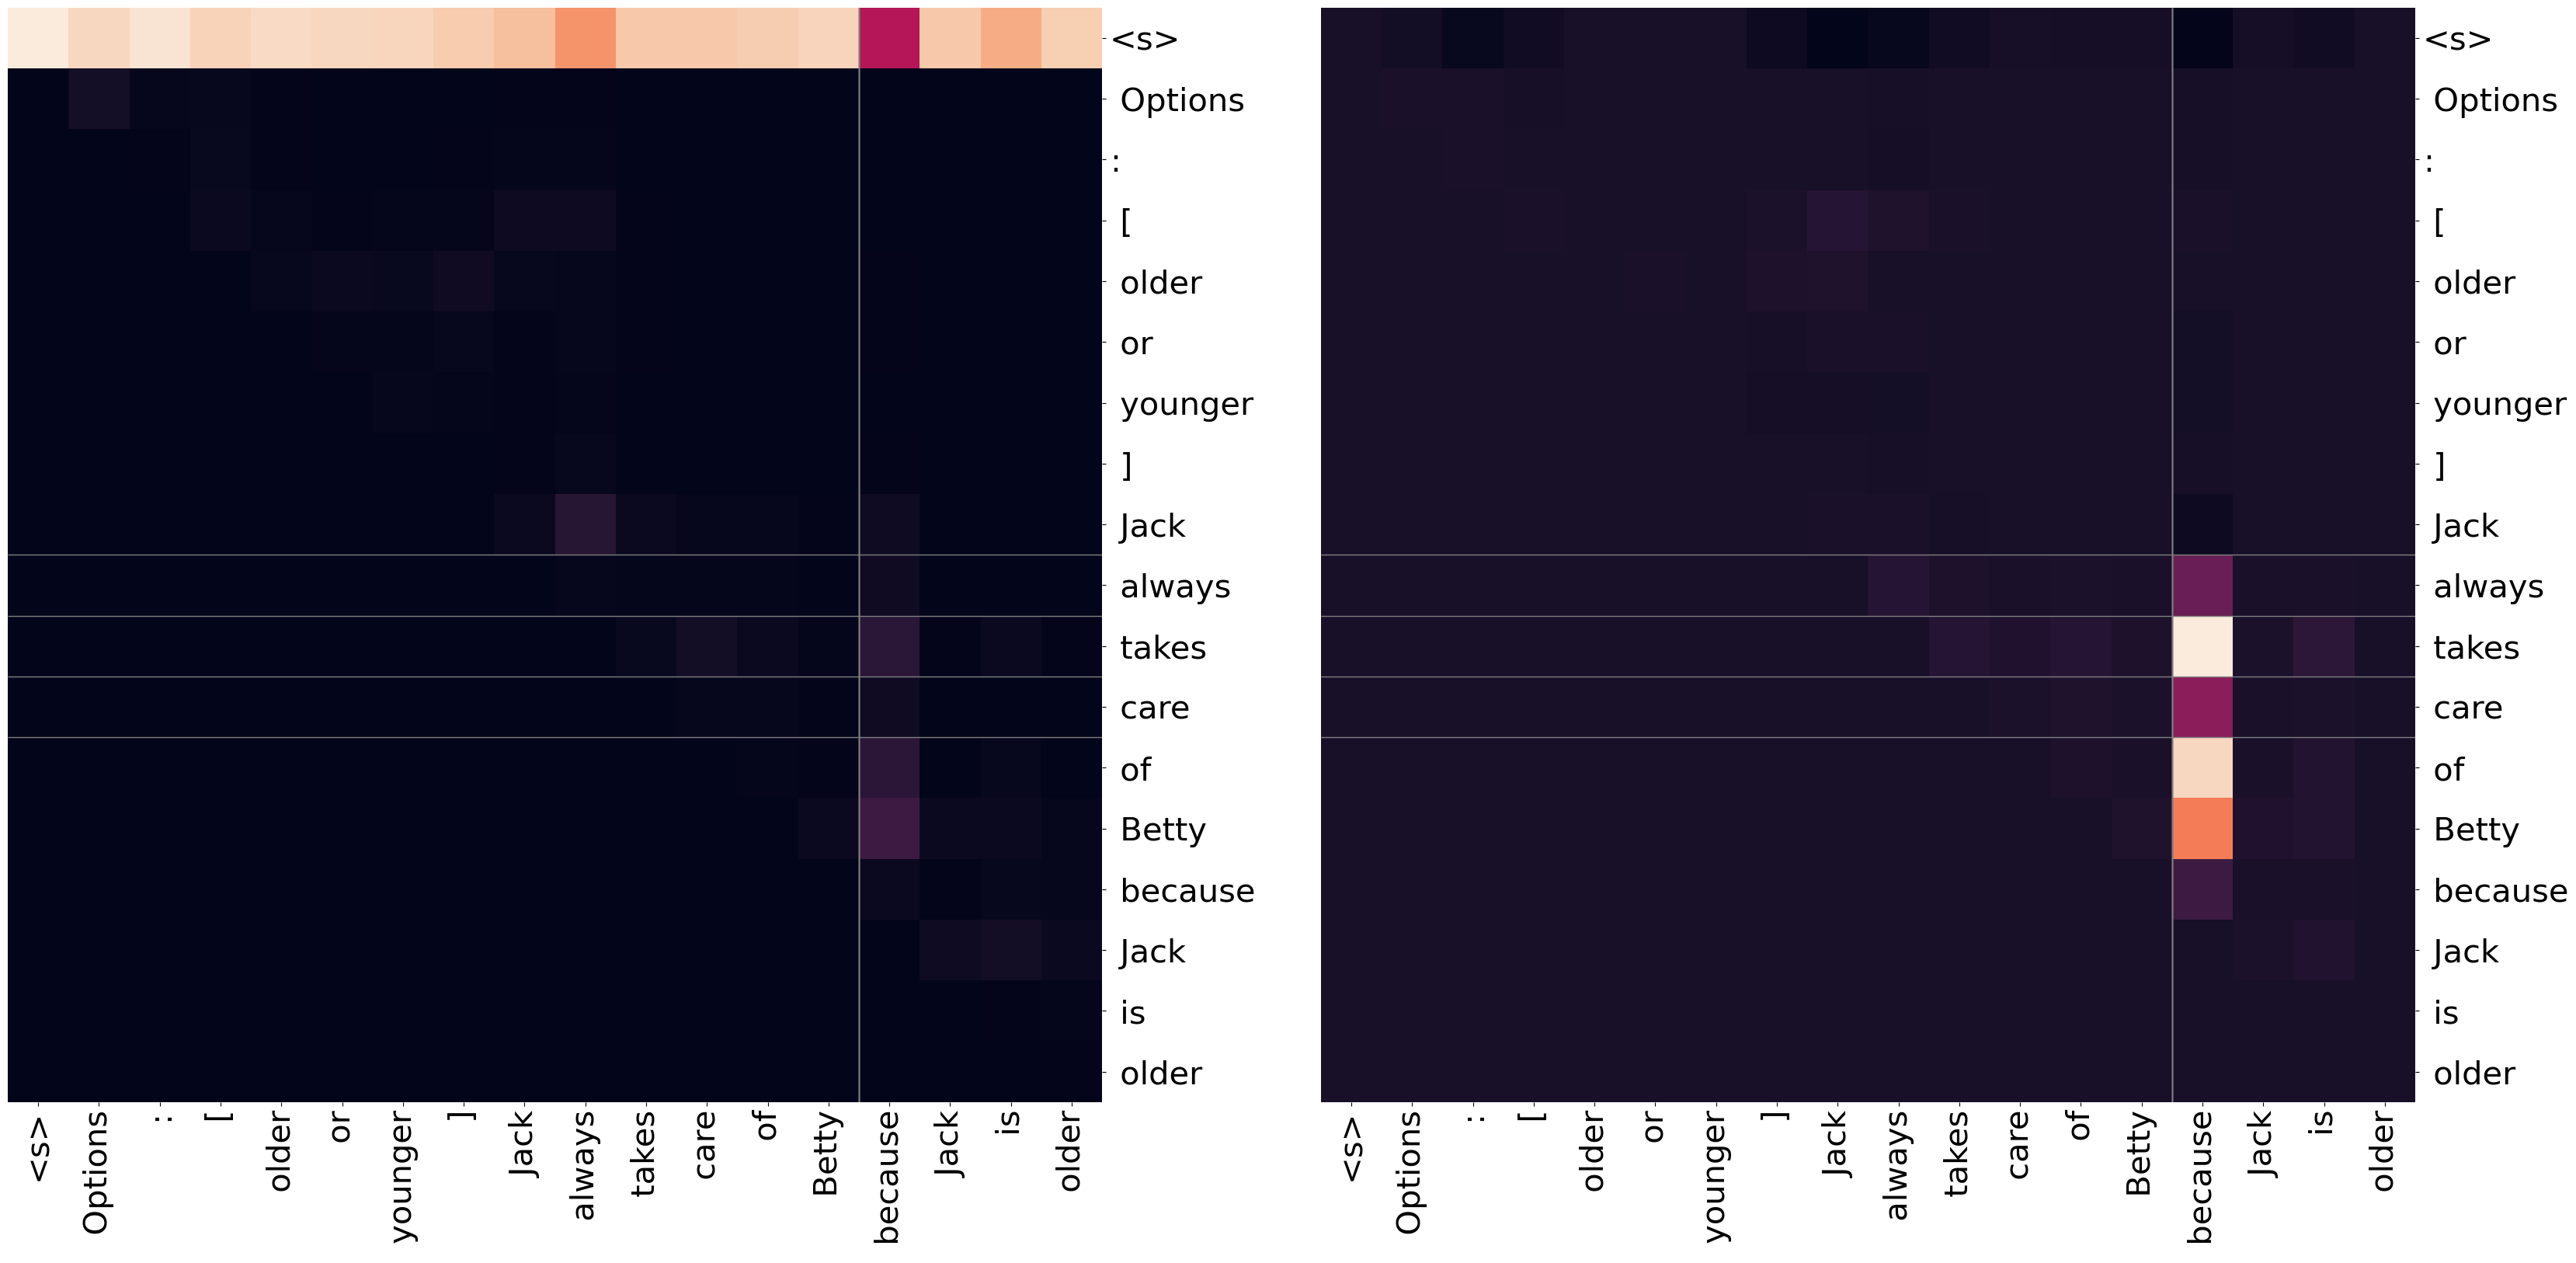

resulting ap_scores = tensor([0.1856], device='cuda:1') tensor(0.1856, device='cuda:1')
ap_scores = tensor([0.3785]) tensor(0.3785)


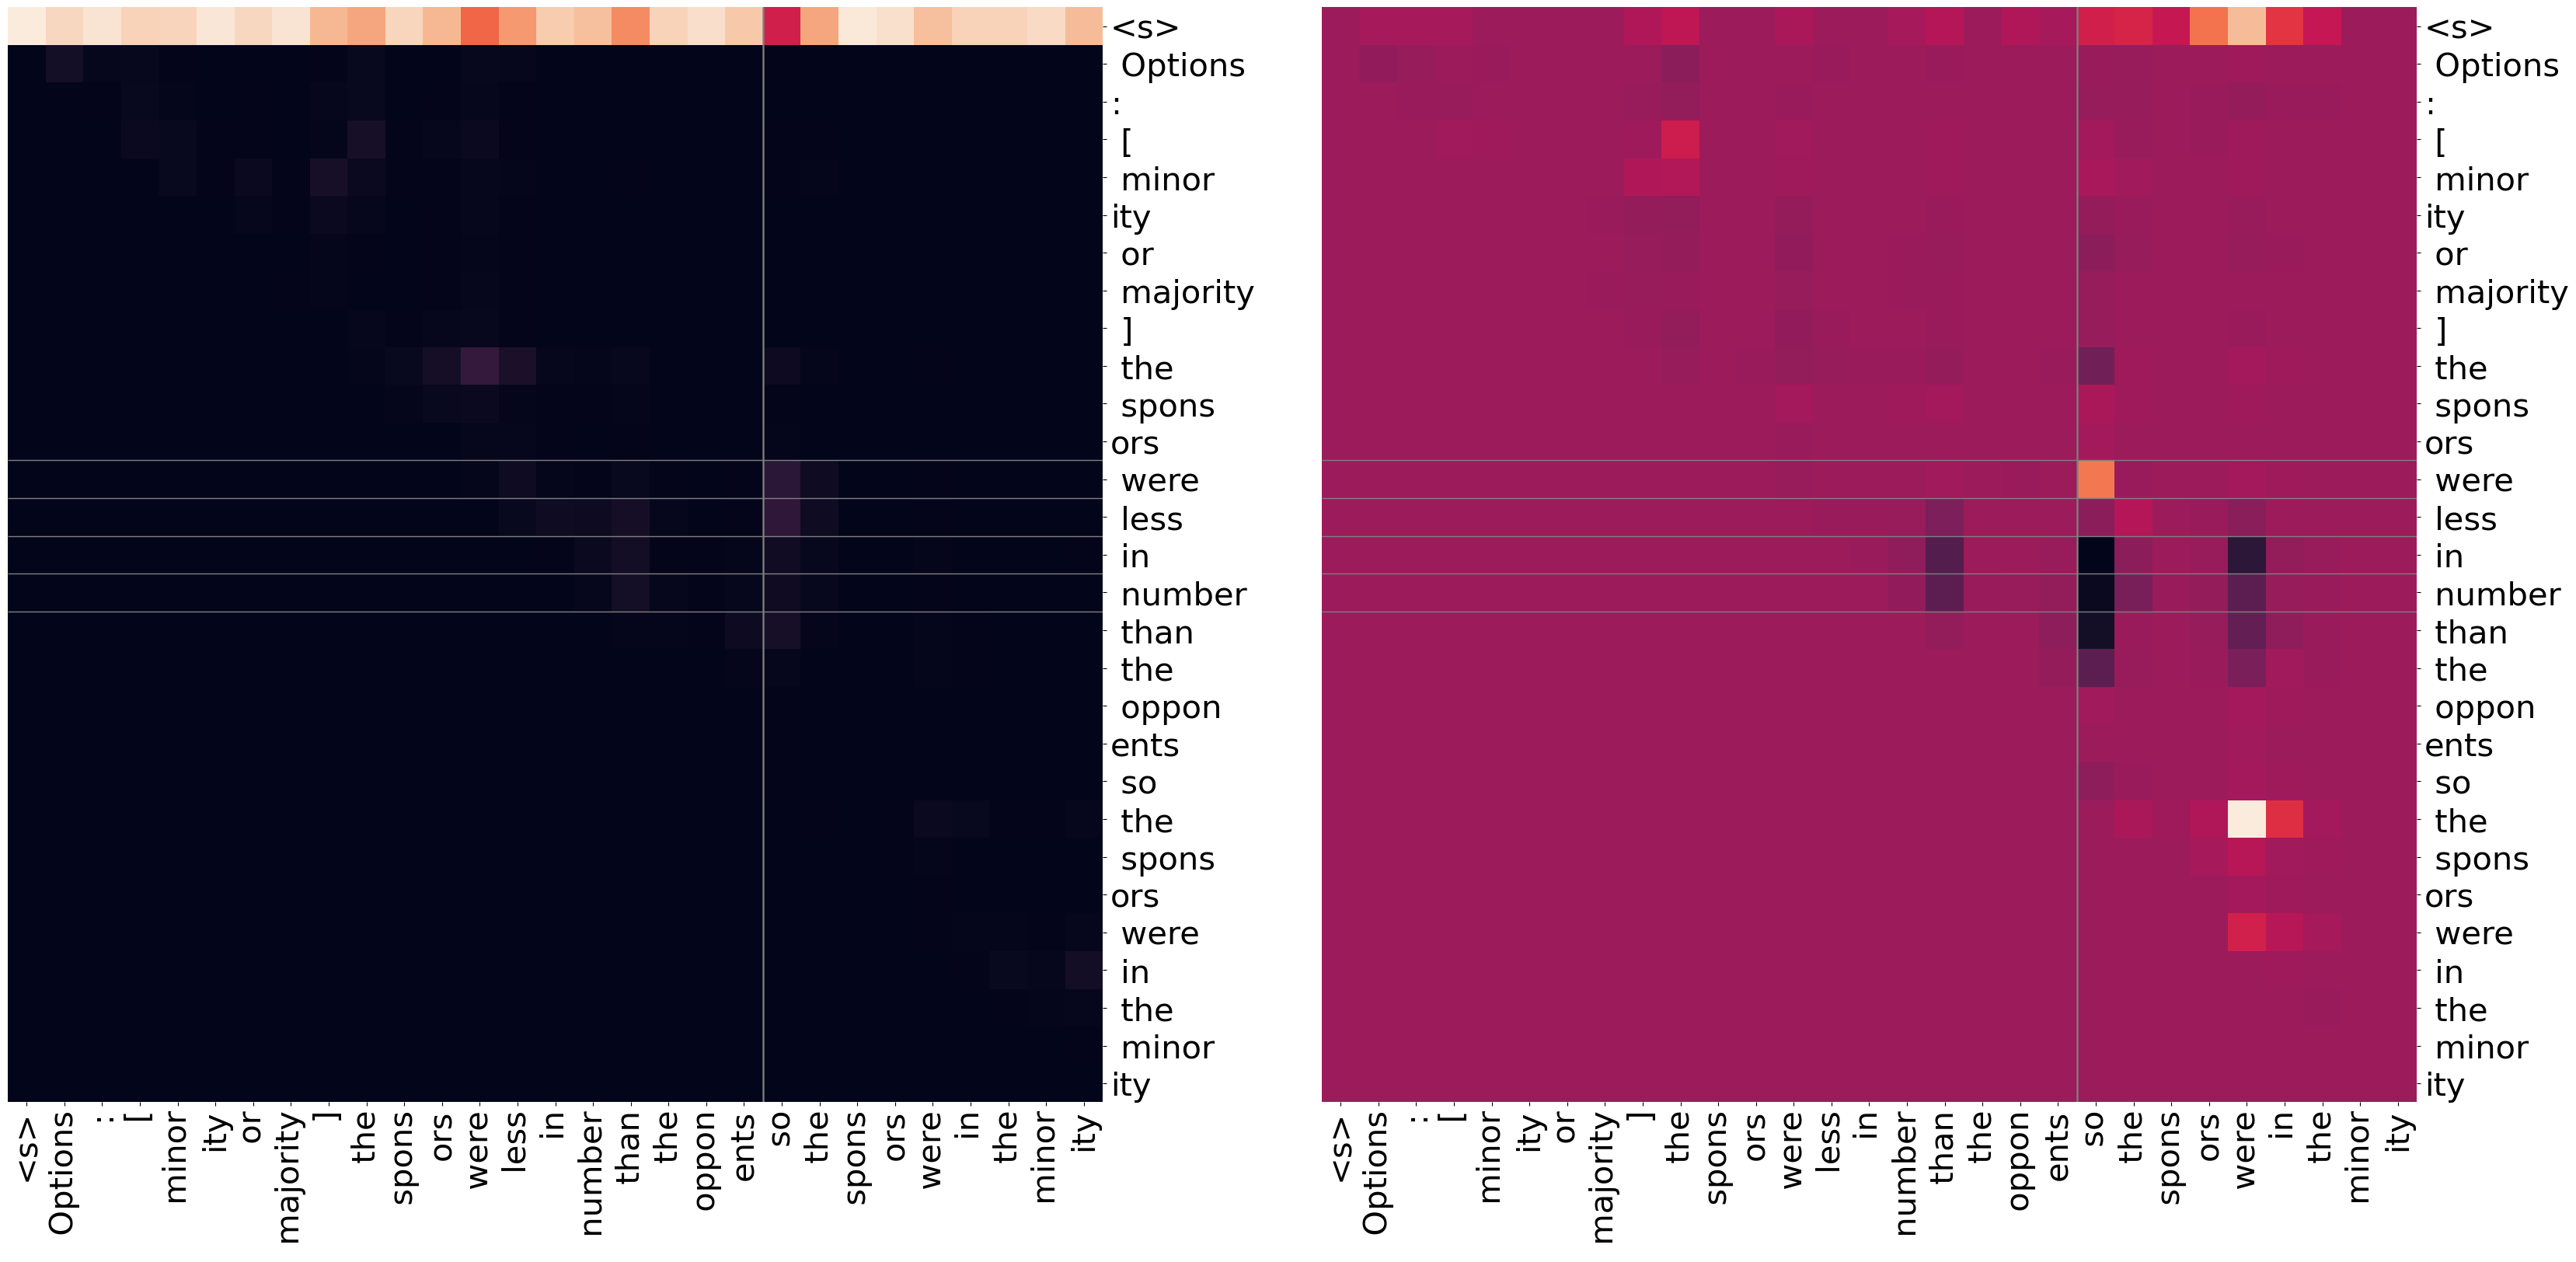

resulting ap_scores = tensor([0.1516], device='cuda:1') tensor(0.1516, device='cuda:1')
ap_scores = tensor([0.4002]) tensor(0.4002)


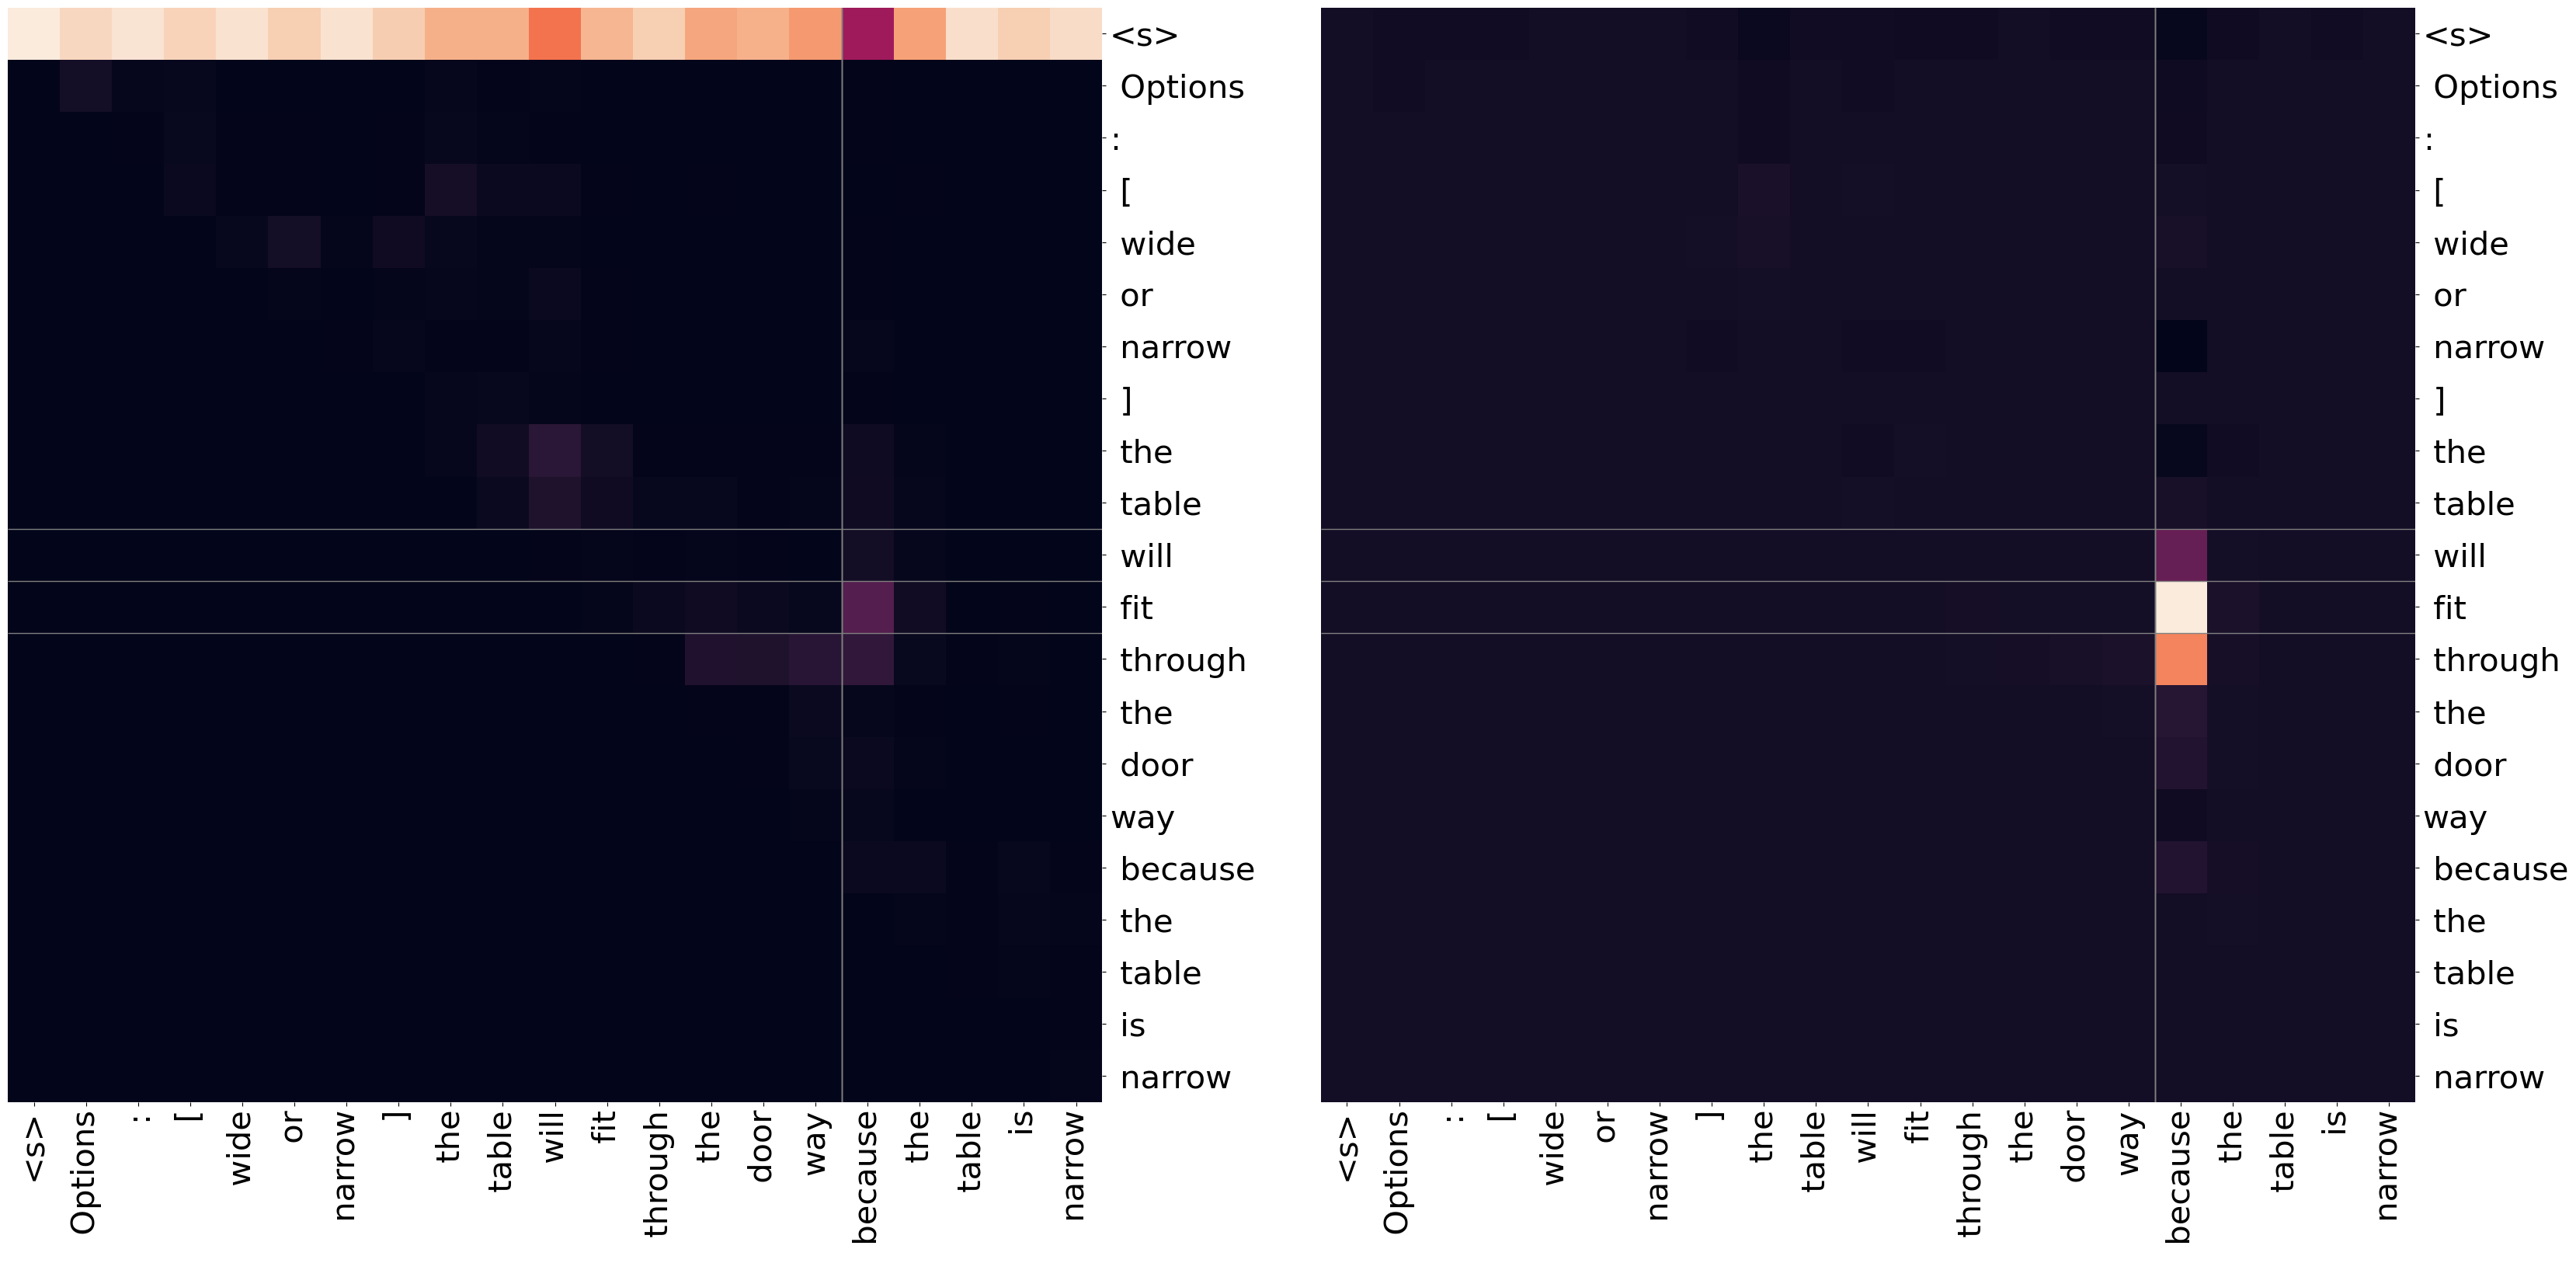

resulting ap_scores = tensor([0.3369], device='cuda:1') tensor(0.3369, device='cuda:1')
ap_scores = tensor([0.5202]) tensor(0.5202)


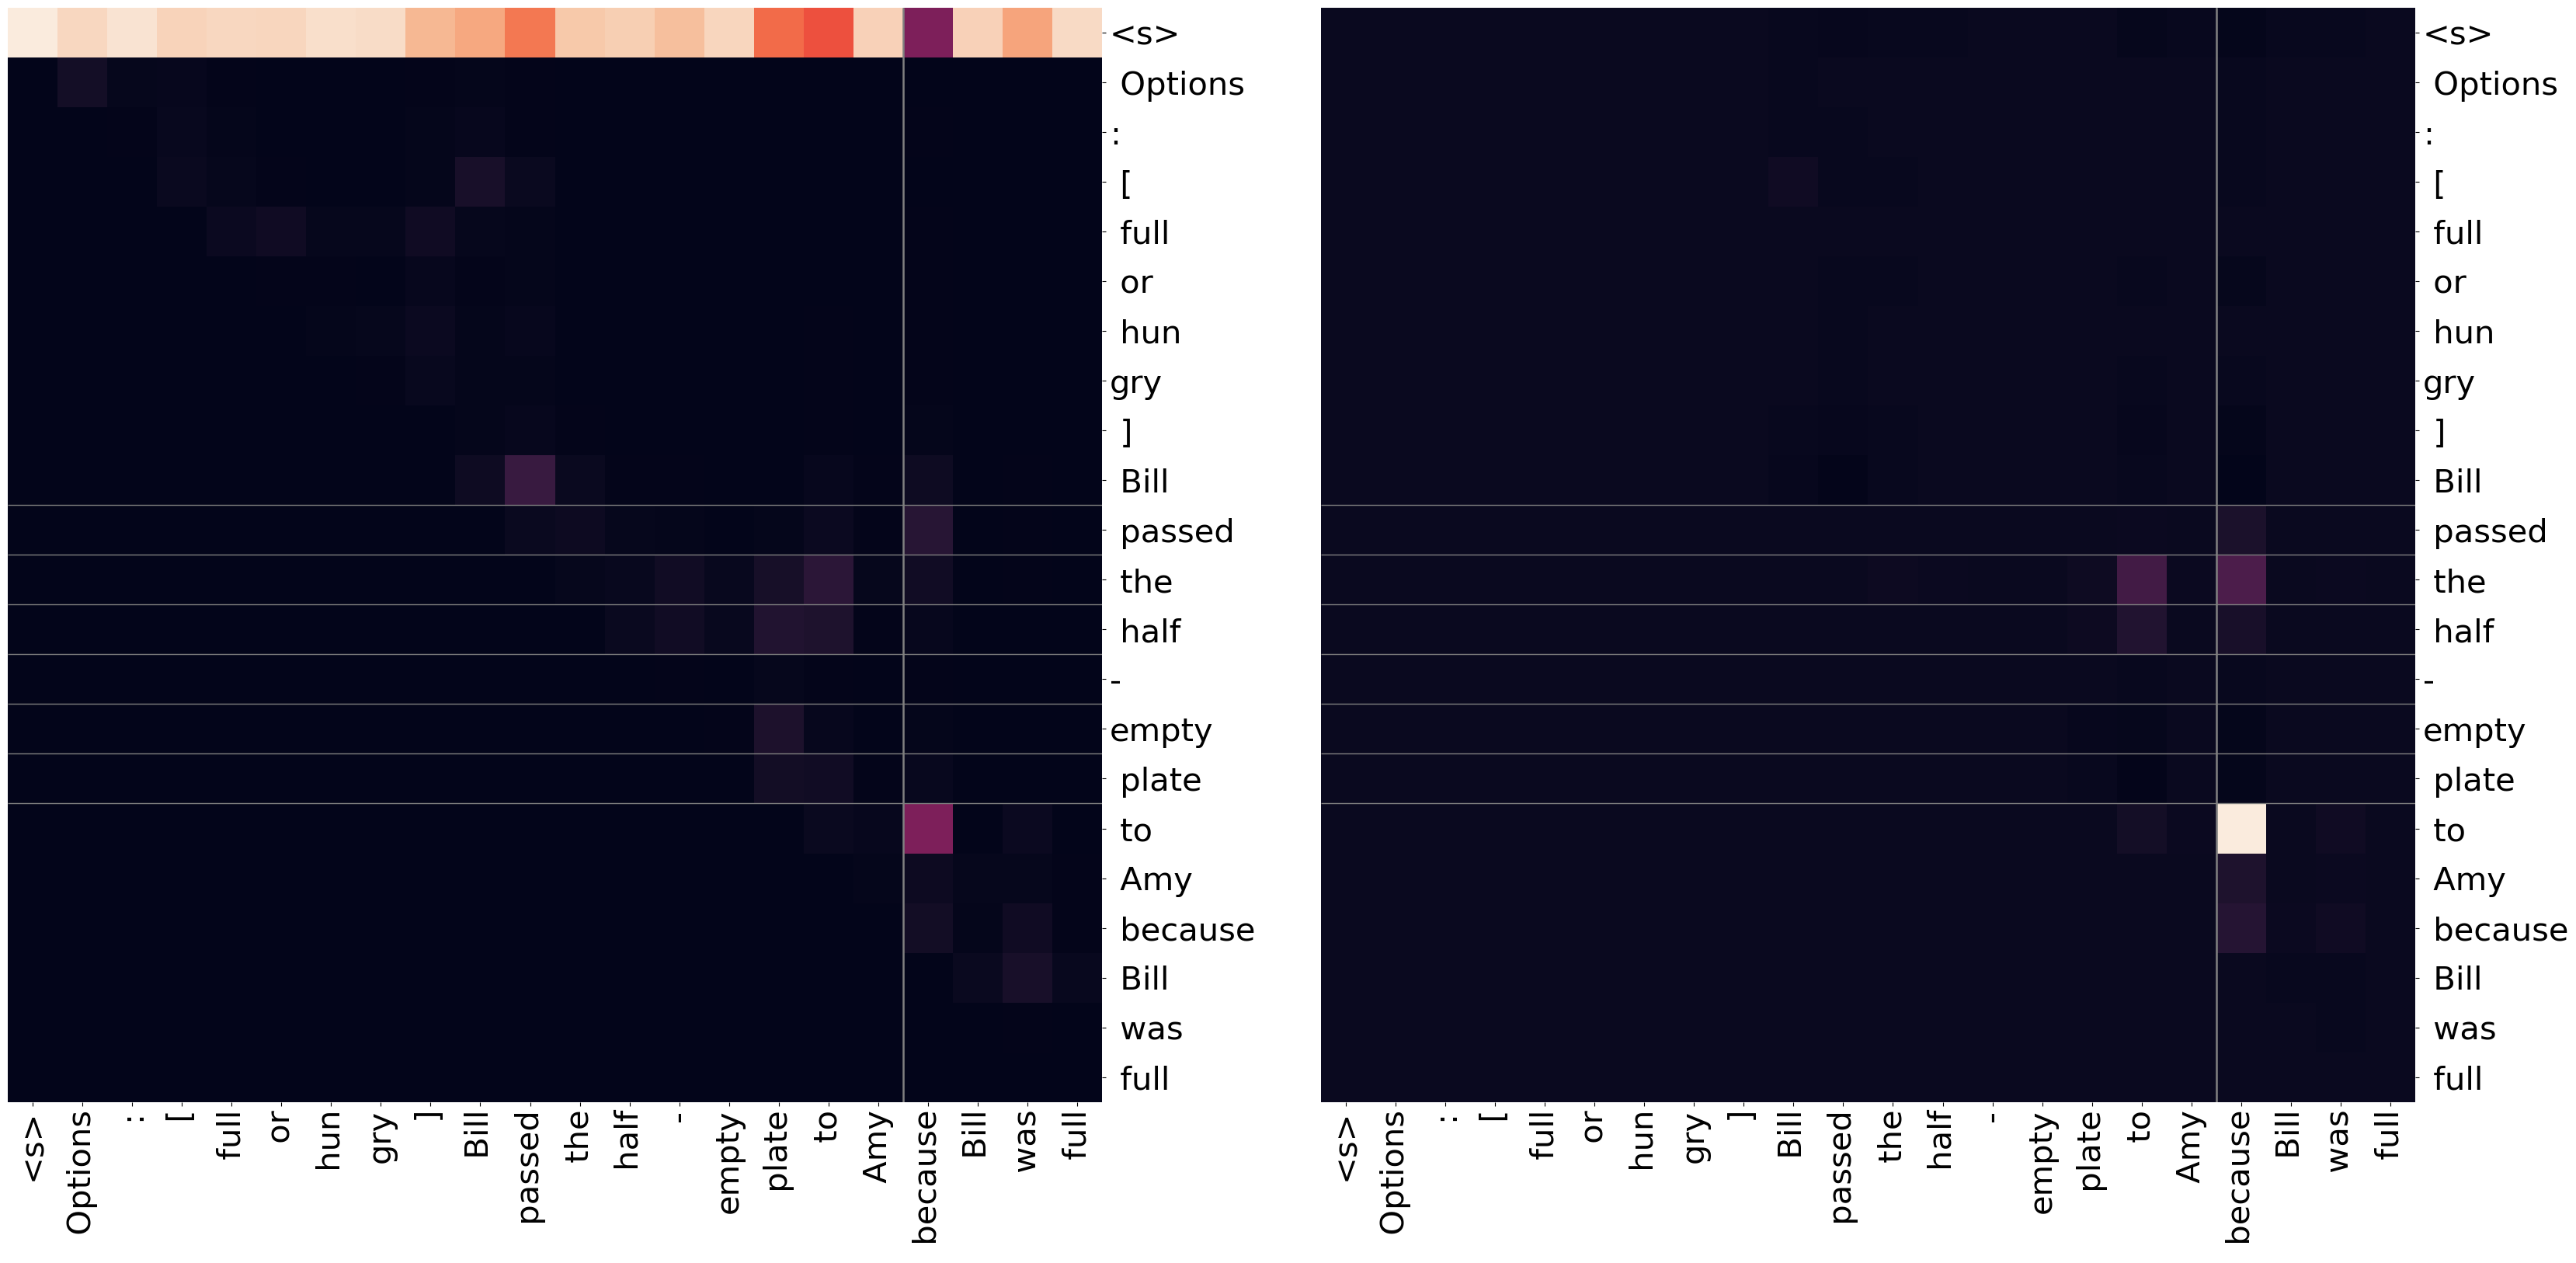

resulting ap_scores = tensor([0.3020], device='cuda:1') tensor(0.3020, device='cuda:1')
ap_scores = tensor([0.4062]) tensor(0.4062)


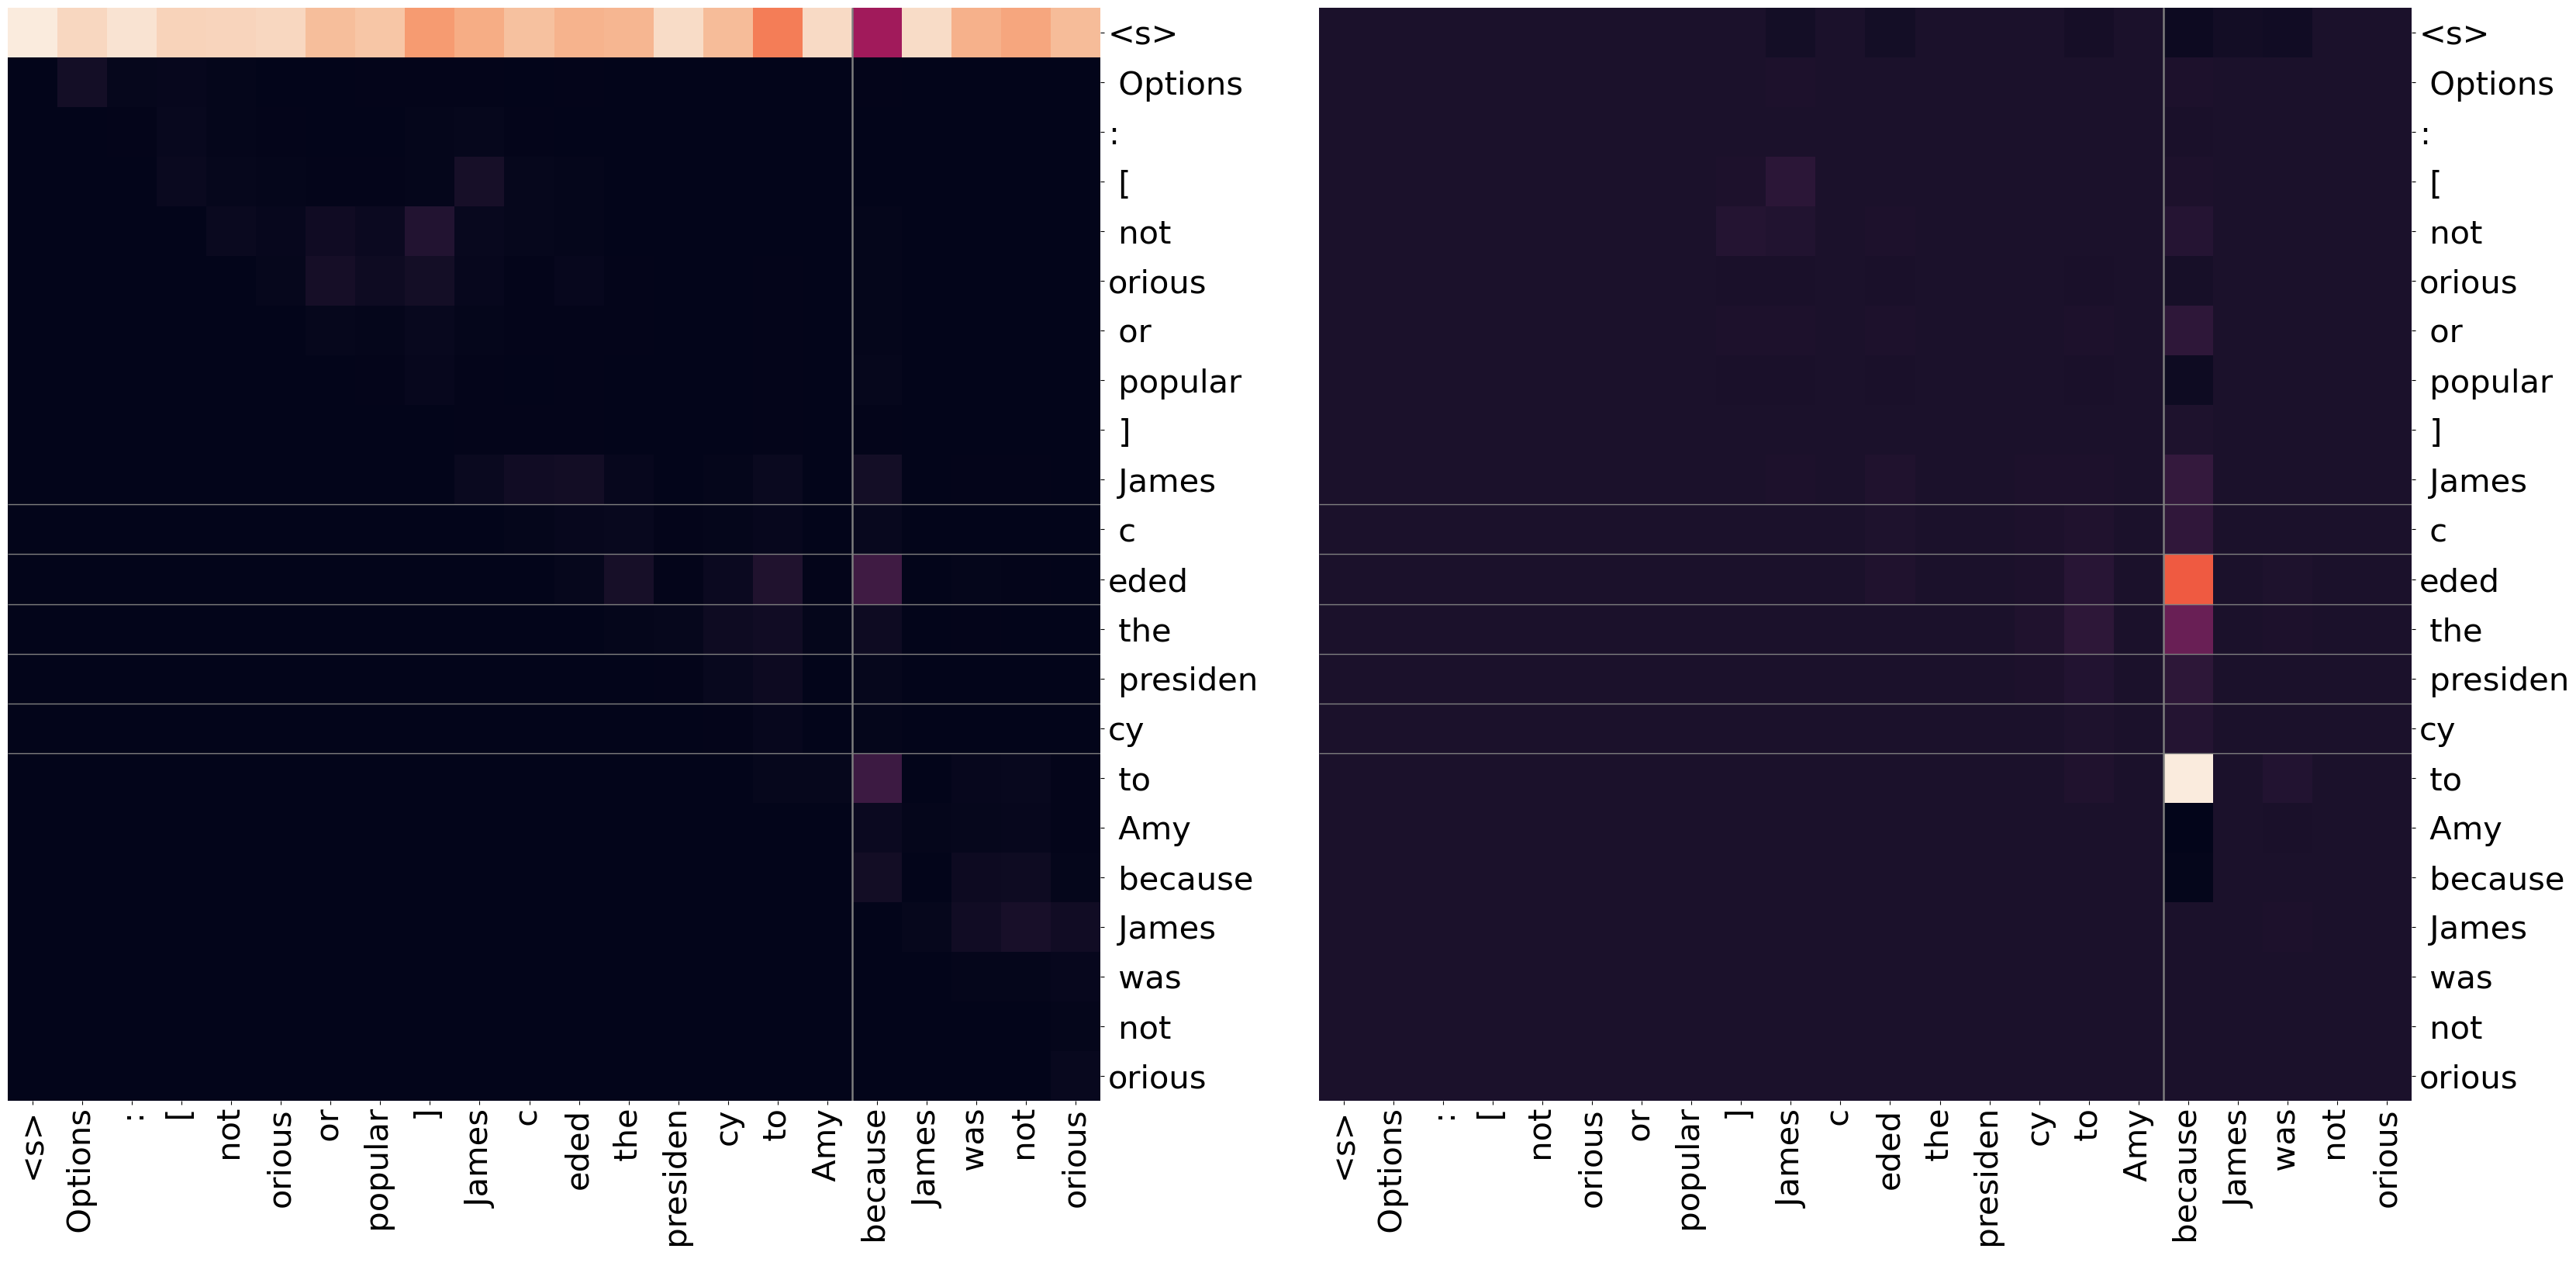

reduced_ap_scores = tensor([0.3836]) tensor(0.3836)


In [34]:
#30-52 7  #22-22 10      14-2 : 10-52 8  11-52 8 9-52 8 7-52 8
#26-52 9  #9-11 9       9-11,15-24,14-44: 8-52 10  11-52 8 3-52 8
#33-25 7  #14-2 11       18-1: 13-52 8 10-52 9  12-23 9-24 10 12-31 10 17-46 10
#28-7 5   #18-18 10
#34-52 6  #14-44 9
#32-47 6  # 15-24 9
#38-13 7  
#18-1 11   13-52 8
#23-22 10  1-52 9
#26-29     16-39 9
#27-25 9   12-23 9
#22-48 10   \9-24 10
#18-1 + 23-22 12  12-31 10
#             17-46 10
#              17-28 10
#            6-52 9
#            15-24
plot_attn_attrs(r1_before.data_tuples, model, tokenizer, node, topi=[9], attn_patterns=['inter->Ration'], k_shot=0, mix=False)

### after

In [79]:
def filter_fn_after(p, c):  #before
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1 and c.topi in [4,5,7,11] or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and c.topi in [6] or  #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and c.topi in [5] or
       p.step == 2 and p.attn_pattern =='s1->s1' and c.topi in [0,1,2,4,5,6,7,9,10] or
    p.step == 3 and c.topi in [2,3,7,8,9,11,12] or
            p.step == 4 and c.top_score>0.5 or
            p.step == 5 and c.top_score>0.7#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [83]:
if True or r1_after.root is None: r1_after.root = add_node(None, layer=L, label_type='labels')
r1_after.root = attribute_tree_on(r1_after.data_tuples, model, r1_after.root, 2, filter_fn_after, topk=15, k_shot=0, threshold_score=0, mix=True, device=None, verbose=True)

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:00.447541
(array([53, 26, 24, 28, 21, 53, 26, 30, 21, 10]),
 array([17, 51, 20, 47, 38, 14, 29, 19, 12, 13]),
 array([0.34602356, 0.31046805, 0.25294432, 0.21002133, 0.20903523,
       0.20329411, 0.20090564, 0.19978873, 0.19204967, 0.18000777],
      dtype=float32))
In _add_node: add @0 43-m 100
In _add_node: add @2 49-m 79
In _add_node: add @3 45-m 75
In _add_node: add @4 47-m 46
In _add_node: add @5 32-m 40
In _add_node: add @7 24-m 36
In _add_node: add @8 39-m 35
In _add_node: add @9 27-m 32
In _add_node: add @10 26-m 32
In _add_node: add @11 22-m 31
In _add_node: add @14 46-m 30
In _add_node: add @1 44-30 82 B->A0 20/10 attn
In _add_node: add @6 30-43 38 B->A0 14/4 attn
In _add_node: add @12 35-29 30 B->A0 53/10 attn
In _add_node: add @13 34-26 30 B->A0 21/6 attn
In _add_node: add @[0,2,3,4,5,7,8,9,10,11,14] 43-m,49-m,45-m,47-m,32-m,24-m,39-m,27-m,26-m,22-m,46-m 30 B->B 74
In _add_node: add @[1,6,12,13] 44-30,30-4

In [84]:
print_tree(r1_after.root)

 ┌@[0,2,3,4,5,7,8,9,10,11,14] 43-m,49-m,45-m,47-m,32-m,24-m,39-m,27-m,26-m,22-m,46-m 30 B->B 74
 ├@[1,6,12,13] 44-30,30-43,35-29,34-26 unk 0
 ├@0 43-m 100
 ├@2 49-m 79
 ├@3 45-m 75
 ├@4 47-m 46
 ├@5 32-m 40
 ├@7 24-m 36
 ├@8 39-m 35
 ├@9 27-m 32
 ├@10 26-m 32
 ├@11 22-m 31
 ├@14 46-m 30
 ├@1 44-30 82 B->A0 20/10 attn
 ├@6 30-43 38 B->A0 14/4 attn
 ├@12 35-29 30 B->A0 53/10 attn
 ├@13 34-26 30 B->A0 21/6 attn
 ┤
 │                        ┌@[0,2,5,6,7,11,12] 29-m,27-m,41-m,30-m,35-m,28-m,36-m B->B 49
 │                        ├@[3,9,10] 22-22,15-24,18-18 B->s1 13
 │                        ├@[1,8,14] 18-1,18-28,9-33 B->Ration 12
 │                        ├@[13] 21-0 B->inter 9
 │                        ├@[4] 21-22 B->s2 7
 │                        ├@0 29-m 100
 │                        ├@2 27-m 94
 │                        ├@5 41-m 84
 │                        ├@6 30-m 72
 │                        ├@7 35-m 60
 │                        ├@11 28-m 50
 │                        ├@12 36-m 47
 │

In [86]:
node = r1_after.root.children[-1].children[-1].children[-1]
node.name

'20-m B->B'

In [1]:
#43-52 7   31-52 8  22-52 7    20-52 9   16-1 9 19-38 8 4-52 8 16-17 7 
#44-30 7   33-11 5  27-29 
#49-52 6   28-52 8  21-38
#45-52 7   32-52 6  3-m
#47-52 8   32-1 6
#32-52 9   34-31 7
#24-52 9   36-52 4
#39-52 8   7-52 8
#27-52 8   29-52 7
#22-52 9   22-52 8
#          27-29 8 
#          11-52 9
plot_attn_attrs(r1_after.data_tuples, model, tokenizer, node, topi=[2,5,9] ,attn_patterns=['s1->Ration'], k_shot=0, mix=True)

NameError: name 'plot_attn_attrs' is not defined

In [111]:
#44-30 12     33-11 12   26-52 13  24-52 13  17-52 12  8-37 12
#43-52 12     28-52 12   27-52 17  16-52 13  8-52 12   8-52 12
#39-52 19     31-52 12   25-52 15  23-52 9   13-52 12  9-42 12
#36-52 13     32-1 13    29-52 13  12-52 12            12-4 13  
#27-52 14      29-52 13   13-52 14 18-52 13            14-6 12
#47-52 14     29-3 13     24-52 14 15-52 12            5-52 13
#37-52 15    27-29 13     17-52 12 14-52 12            9-29 13
#22-52 16    34-31 13     21-23 12 10-52 12            7-18 12
#24-52 17     20-52 11    19-52 12 21-38 12            5-31 12
#33-52 17     32-52 11    21-0 13  4-52 12             12-18 12
#30-43 11     35-29 12    2-52 12  9-52 11
#23-52 16     36-52 12    9-52 11  21-0 12
#45-52 13     32-9 16     15-24 14 24-33 12
#55-52 16                 20-13 12  20-14 12
#                          4-52 13 25-33 12
plot_attn_attrs(r1_before.data_tuples, model, tokenizer, node, topi=[1], attn_patterns=['s1->Ration'], k_shot=0, mix=True)     #47-32:12  55-52:15  39-52:19 56-24:15 51-52:13 42-30:9/24 28-34:17/24 43-20:16/24 27-29:13/24 39-25:15/24 step1:42-30 -> 43-20:12/24  28-34 -> 43-20 15/24   27-29 -> 43-20:11/24  25-33 -> 43-20: 20/24

28-52
*▁large 0.546 {'▁large': 0.546, '▁small': 0.454, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ small or large ] the trophy doesn't fit into the suitcase because the trophy is large ▁small:-0.229614 *▁large:-0.044006
 ▁rich 0.469 {'▁poor': 0.531, '▁rich': 0.469, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ rich or poor ] John gave a lot of money to Susan because John was rich ▁poor:0.248047 *▁rich:0.122803
 ▁fast 0.483 {'▁slow': 0.518, '▁fast': 0.483, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ fast or slow ] the truck overtook the bus because the truck was going fast ▁slow:0.387451 *▁fast:0.317871
*▁hard 0.605 {'▁hard': 0.606, '▁soft': 0.394, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ hard or soft ] the ball crashed right through the board because the ball was hard *▁hard:0.181519 ▁soft:-0.246826
*▁short 0.645 {'▁short': 0.645, '▁tall': 0.355, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ tall or short ] John couldn't see the stage behind Susan because John is short *▁short:-0.045776 ▁tall:-0.644043
*▁first 

## although 合并

In [524]:
def filter_fn_al(p, c):  #合并版
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1  and c.topi in [0,1,3,5,6] or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and c.topi in [0,1,2,3,5,6,8,11,4,9]  or #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1  or
       p.step == 2 and p.attn_pattern =='s1->s1' and c.topi in [0,1,2,4,5,6,7,9,10] or
    p.step == 3 and c.topi in [2,3,7,8,9,11,12] or
            p.step == 4 and c.top_score>0.5 or
            p.step == 5 and c.top_score>0.7#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [525]:
if True or r1_al.root is None: r1_al.root = add_node(None, layer=L, label_type='labels')
r1_al.root = attribute_tree_on(r1_al.data_tuples, model, r1_al.root, 2, filter_fn_al, topk=15, k_shot=0, threshold_score=0.1, mix=True, device=None, verbose=True)

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:00.892790
(array([26, 24, 53, 16, 21, 21, 27, 26, 29, 19]),
 array([51, 20, 17, 17, 38, 12, 40, 29,  0, 33]),
 array([0.3016998 , 0.2476244 , 0.21849568, 0.19304232, 0.18251164,
       0.17957194, 0.17915599, 0.1767273 , 0.16810036, 0.16684254],
      dtype=float32))
In _add_node: add @0 37-m 100
In _add_node: add @1 36-m 97
In _add_node: add @2 31-m 91
In _add_node: add @3 35-m 84
In _add_node: add @4 39-m 77
In _add_node: add @5 30-m 64
In _add_node: add @6 43-m 61
In _add_node: add @8 28-m 57
In _add_node: add @10 33-m 52
In _add_node: add @11 43-20 47 B->B 20/6
In _add_node: add @14 50-35 29 B->B 31/11
In _add_node: add @7 27-29 57 B->A0 29/12 attn
In _add_node: add @9 41-10 53 B->Ration 13/7 attn
In _add_node: add @12 45-30 36 B->A0 27/4 attn
In _add_node: add @13 44-30 32 B->A0 19/3 attn
In _add_node: add @[0,1,2,3,4,5,6,8,10,11,14] 37-m,36-m,31-m,35-m,39-m,30-m,43-m,28-m,33-m,43-20,50-35 29 B->B 65
In _add_node:

In attribute_tree: attribute_step @[0,1,2,3,4,6,12,13,14]  inter->inter ... done 0:00:00.748584
In _add_node: add @0 10-m 100
In _add_node: add @1 1-m 66
In _add_node: add @2 13-m 49
In _add_node: add @3 16-17 44 inter->inter 9/10
In _add_node: add @7 15-m 38
In _add_node: add @8 13-21 32 inter->inter 12/37
In _add_node: add @9 9-7 29 inter->inter 12/16
In _add_node: add @4 11-32 42 inter->Ration 10/15
In _add_node: add @5 10-35 42 inter->Ration 24/53
In _add_node: add @6 9-10 39 inter->Ration 12/30
In _add_node: add @10 10-20 29 inter->Ration 10/14
In _add_node: add @11 16-35 26 inter->Ration 6/13
In _add_node: add @12 15-2 24 inter->Ration 18/42
In _add_node: add @13 5-27 24 inter->Ration 28/49
In _add_node: add @14 15-17 24 inter->Ration 10/16
In _add_node: add @[0,1,2,3,7,8,9] 10-m,1-m,13-m,16-17,15-m,13-21,9-7 29 inter->inter 30
In _add_node: add @[4,5,6,10,11,12,13,14] 11-32,10-35,9-10,10-20 29,16-35 26,15-2 24,5-27 24,15-17 24 inter->Ration 9
In attribute_tree: attribute_step 22

In [526]:
print_tree(r1_al.root)

 ┌@[0,1,2,3,4,5,6,8,10,11,14] 37-m,36-m,31-m,35-m,39-m,30-m,43-m,28-m,33-m,43-20,50-35 29 B->B 65
 ├@[7,9,12,13] 27-29,41-10,45-30,44-30 unk 0
 ├@0 37-m 100
 ├@1 36-m 97
 ├@2 31-m 91
 ├@3 35-m 84
 ├@4 39-m 77
 ├@5 30-m 64
 ├@6 43-m 61
 ├@8 28-m 57
 ├@10 33-m 52
 ├@11 43-20 47 B->B 20/6
 ├@14 50-35 29 B->B 31/11
 ├@7 27-29 57 B->A0 29/12 attn
 ├@9 41-10 53 B->Ration 13/7 attn
 ├@12 45-30 36 B->A0 27/4 attn
 ├@13 44-30 32 B->A0 19/3 attn
 ┤
 │                  ┌@[0,1,2,3,5,6,7,8,11,13] 24-m,23-m,22-m,40-m,19-m,29-m,25-m 27,20-m 17,32-47 15,17-m 13 B->B 65
 │                  ├@[4,9,10,12,14] 25-42,24-35 17,26-49 17,33-34 13,28-49 12 unk 0
 │                  ├@0 24-m 100
 │                  ├@1 23-m 84
 │                  ├@2 22-m 61
 │                  ├@3 40-m 55
 │                  ├@5 19-m 44
 │                  ├@6 29-m 41
 │                  ├@7 25-m 27
 │                  ├@8 20-m 17
 │                  ├@11 32-47 15 B->B 31/14
 │                  ├@13 17-m 13
 │                  

In [527]:
node = r1_al.root.children[-1].children[-1].children[-1]
node.name

'@[0,1,2,3,4,5,6,8]  s1->s1'

In [537]:
# -5 6,10,14,1,9,11,13
plot_attn_attrs(r1_al.data_tuples, model, tokenizer, node, topi=[0,3,2] ,attn_patterns=['B->A0'], k_shot=0, mix=True)

9-33 + 15-24 + 10-34 -> @[0,1,2,3,4,5,6,8]  s1->s1 -> 25-42 B->s1 -> @[0,1,3,5,6]  B->B
*▁small 0.5 {'▁small': 0.5, '▁large': 0.499, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ small or large ] the trophy doesn't fit into the suitcase although the trophy is small *▁small:0.000383 ▁large:-0.002424
 ▁large 0.5 {'▁small': 0.5, '▁large': 0.5, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ large or small ] the trophy doesn't fit into the suitcase although the suitcase is large ▁small:-0.004417 *▁large:-0.005272
*▁poor 0.501 {'▁poor': 0.501, '▁rich': 0.499, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ rich or poor ] John gave a lot of money to Susan although John was poor *▁poor:0.002680 ▁rich:-0.001424
*▁rich 0.5 {'▁rich': 0.5, '▁poor': 0.5, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ rich or poor ] John gave a lot of money to Susan although Susan was rich ▁poor:0.001537 *▁rich:0.003933
*▁slow 0.502 {'▁slow': 0.502, '▁fast': 0.498, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ fast or slow ] the truck overtook the bus al

## winograd_al_before

In [370]:
r1_al_before.data_tuples[0]

["Options: [ small or large ] the trophy doesn't fit into the suitcase although the trophy is small",
 tensor([[    1, 25186, 29901,   518,  2319,   470,  2919,  4514,   278,  3147,
          11461,  1838, 29915, 29873,  6216,   964,   278, 14726,  4878,  5998,
            278,  3147, 11461,   338,  2319]]),
 tensor([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 2319,
          -100]]),
 [WINORanges(bos=(23, 24), op=(1, 2), ans=None, preans=(4, 5), postans=(6, 7), ans0=(4, 5), nans0=(6, 7), ansright=(7, 8), s1=(20, 23), s2=(8, 11), ans0s=None, example=(1, 25), inter=(19, 20), rel=None, candidates=None, io=(16, 19), relation=(11, 16))],
 ["Options: [ small or large ] the trophy doesn't fit into the suitcase although the trophy is small"],
 [23],
 [25],
 [array([2319])],
 [[2919, 2319]],
 [0],
 Outputs(inputs_embeds=tensor([[[-0.0195, -0.0037, -0.0011,  ...,  0.0023, -0.0019, -0.0162],


In [371]:
a= [    1, 25186, 29901,   518,  2319,   470,  2919,  4514,   278,  3147,
          11461,  1838, 29915, 29873,  6216,   964,   278, 14726,  4878,  5998,
            278,  3147, 11461,   338,  2319]

In [374]:
a[20:23]

[278, 3147, 11461]

In [376]:
tokenizer.convert_ids_to_tokens([278, 3147, 11461])

['▁the', '▁tro', 'phy']

In [444]:
def filter_fn_al_before(p, c):  #合并版
#     if c.layer == 0 or c.head == c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1  and c.topi in [0,3,9] or# or ap.startswith('B->s1') and c.label_type.startswith('labels')) or#and ap.startswith('B->A0
       p.step == 0 and c.topi in [11,12,6,10,13]  or #and c.label_type != None and c.label_type.startswith('attn_labels')#and (ap.startswith('B->Q') or ap.startswith('B->A')) or # c.ap_score > 0.2 and c.top_score > 0.5 and c.icl_score > 0.4 or 
       p.step == 1 and (c.topi in [1,7,9])  or
       p.step == 2 and p.attn_pattern =='s1->s1' and c.topi in [0,1,2,4,5,6,7,9,10] or
    p.step == 3 and c.topi in [2,3,7,8,9,11,12] or
            p.step == 4 and c.top_score>0.5 or
            p.step == 5 and c.top_score>0.7#and (ap in ['inter->Aright','B->s2'] or (ap in ['B->nA0','B->nA0+'] and c.label_type in [None,'attn_labels'])) or                                   
           )
      # p.step ==4 or 
   # p.step == 5# and ap.startswith('B->A]') 
   # )#

In [445]:
if True or r1_al_before.root is None: r1_al_before.root = add_node(None, layer=L, label_type='labels')
r1_al_before.root = attribute_tree_on(r1_al_before.data_tuples, model, r1_al_before.root, 1, filter_fn_al_before, topk=15, k_shot=0, threshold_score=0.1, mix=True, device=None, verbose=True)

attribute_tree ... In attribute_tree: attribute_step  ... done 0:00:00.496080
(array([26, 24, 29, 19, 53, 16, 21, 25, 26, 28]),
 array([51, 20,  0, 33, 17, 17, 38, 49, 29, 47]),
 array([0.35950693, 0.2984117 , 0.23233032, 0.2318093 , 0.23134358,
       0.22286345, 0.22044308, 0.19920063, 0.19403839, 0.18349075],
      dtype=float32))
In _add_node: add @0 43-m 100
In _add_node: add @1 31-m 61
In _add_node: add @3 39-m 51
In _add_node: add @5 45-m 39
In _add_node: add @6 35-m 38
In _add_node: add @9 30-m 30
In _add_node: add @10 33-m 28
In _add_node: add @2 44-30 56 B->A0 18/4 attn
In _add_node: add @4 45-30 42 B->A0 36/6 attn
In _add_node: add @7 42-30 32 B->A0 63/10 attn
In _add_node: add @11 40-32 25 B->A0 18/6 attn
In _add_node: add @12 40-8 24 B->A0 29/8 attn
In _add_node: add @13 28-49 24 B->A0 45/12 attn
In _add_node: add @14 40-2 24 B->nA0 22/8 attn
In _add_node: add @8 30-43 32 B->s1 17/16 attn
In _add_node: add @[0,1,3,5,6,9,10] 43-m,31-m,39-m,45-m,35-m,30-m 30,33-m 28 B->B 50


In [446]:
print_tree(r1_al_before.root)

 ┌@[0,1,3,5,6,9,10] 43-m,31-m,39-m,45-m,35-m,30-m 30,33-m 28 B->B 50
 ├@[2,4,7,11,12,13] 44-30,45-30,42-30,40-32 25,40-8 24,28-49 24 B->A0 16
 ├@[14] 40-2 24 B->nA0 5
 ├@[8] 30-43 unk 0
 ├@0 43-m 100
 ├@1 31-m 61
 ├@3 39-m 51
 ├@5 45-m 39
 ├@6 35-m 38
 ├@9 30-m 30
 ├@10 33-m 28
 ├@2 44-30 56 B->A0 18/4 attn
 ├@4 45-30 42 B->A0 36/6 attn
 ├@7 42-30 32 B->A0 63/10 attn
 ├@11 40-32 25 B->A0 18/6 attn
 ├@12 40-8 24 B->A0 29/8 attn
 ├@13 28-49 24 B->A0 45/12 attn
 ├@14 40-2 24 B->nA0 22/8 attn
 ├@8 30-43 32 B->s1 17/16 attn
 ┤
 │                   ┌@[0,1,2,3,4,5,7,8,9,11,12] 22-m,25-m,23-m,31-m,24-m,19-m,37-m,10-m,35-m,9-m,13-m 29 B->B 75
 │                   ├@[6,10,13,14] 24-35,22-22,25-49 28,35-10 28 unk 0
 │                   ├@0 22-m 100
 │                   ├@1 25-m 90
 │                   ├@2 23-m 88
 │                   ├@3 31-m 87
 │                   ├@4 24-m 72
 │                   ├@5 19-m 46
 │                   ├@7 37-m 36
 │                   ├@8 10-m 33
 │                   

In [414]:
node = r1_al_before.root.children[-1]
node.name

'43-m,39-m,30-m B->B'

In [443]:
plot_attn_attrs(r1_al_before.data_tuples, model, tokenizer, node, topi=[14] ,attn_patterns=['B->A0'], k_shot=0, mix=True)

35-10 -> 43-m,39-m,30-m B->B
*▁small 0.5 {'▁large': 0.5, '▁small': 0.5, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ small or large ] the trophy doesn't fit into the suitcase although the trophy is small *▁small:0.000073 ▁large:0.000255
*▁poor 0.638 {'▁poor': 0.638, '▁rich': 0.362, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ rich or poor ] John gave a lot of money to Susan although John was poor *▁poor:0.106262 ▁rich:-0.462158
 ▁slow 0.499 {'▁fast': 0.5, '▁slow': 0.499, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ fast or slow ] the truck overtook the bus although the truck was going slow *▁slow:-0.002586 ▁fast:0.000277
*▁soft 0.5 {'▁soft': 0.5, '▁hard': 0.499, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ hard or soft ] the ball crashed right through the board although the ball was soft ▁hard:-0.002268 *▁soft:0.000424
 ▁tall 0.5 {'▁short': 0.5, '▁tall': 0.5, '<unk>': 0.0, '<s>': 0.0} 	 Options: [ tall or short ] John couldn't see the stage behind Susan although John is tall ▁short:0.000536 *▁tall:-0.000427
 

In [10]:
results = {}; key = None

In [50]:
def filter_fn(p, c):
    if c.layer == 0 or c.head == c.H: return False
#     if p.label_type and 'attn_labels' in p.label_type and '->~<s>' in p.label_type: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (p.step == -1 and (c.top_score > 0.5 or c.ap_score > 0.49 and ap == 'B->A0') and ap in ['B->A0', 'B->B'] or
        p.step == 0 and (c.layer, c.head) == (20, 45) or # and c.icl_score > 0.4 or   
        p.step == 1 and (c.layer, c.head) in [(18, 13)] or
#         p.step == 2 and (c.layer, c.head) in [(16, 5), (16, 10), (15, 4)] or  # for B->~<s>
        p.step == 2 and (c.layer, c.head) in [(14, 30), (12, 39), (15, 0)] or
        p.step == 3 and (c.layer, c.head) in [(6, 19)]
    )

In [12]:
model_gpu = None

In [8]:
# cachier.cache_dir = '~/.cachier/.openai_utils.query_openai'
tasks0 = [
#     (lambda: [TreeSet(types_of_things).use(['equal']), TreeSet(types_of_things).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is",
#     ), 
#     (lambda: [TreeSet(country2capital).use(['equal']), TreeSet(country2capital).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is",
#     ), 
#     (lambda: [TreeSet(do2did).use(['equal']), TreeSet(do2did).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is",
#     ), 
# #     (lambda: [TreeSet(pasttenses_of_verbs).use(['equal']), TreeSet(pasttenses_of_verbs).use(['child'])], MlM_gen,
# #      lambda *args, **kwargs: '', lambda q, _: f"Today I {q}. Yesterday I",
# #     ), 
#     (lambda: [TreeSet(word2capitalized).use(['equal']), TreeSet(word2capitalized).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is",
#     ), 
#     (lambda: [TreeSet(letter2uppercase).use(['equal']), TreeSet(letter2uppercase).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is",
#     ), 
    
    
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(genders_of_persons).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
#     ), 
    (lambda: [TreeSet(types_of_things).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
    ), 
    (lambda: [TreeSet(countries_of_cities).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
    ),
    (lambda: fork_vocab(TreeSet(capabilities_of_things), [['equal', 'child', 'sibling']] * 2), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(SymSet(person_adjs), [['equal'], ['opposite']]), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(PoSet(temporal_poset), [['equal'], ['prev']]), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(PoSet(temporal_poset), [['equal'], ['next']]), MlM_gen, None, None,
    ), 
#     (lambda: [TreeSet(types_of_things).use(['equal']), TreeSet(types_of_things).use(['equal', 'child'])], partial(MlM_gen, cxt_sample_fn=enumerate_sample, query=1),
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {i[1]}", f"{the_(i[1])} is {i[0]}'s"]), lambda q, _: f"{q}", " likes"
#     ),
]
tasks = [
    (lambda: [EqSet(uppercase_letters).use(['equal']), TreeSet(genders_of_persons).use(['child'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]}'s name is {i[1]}.", f"{i[1]} is {i[0]}'s name."]), lambda q, _: f"{q} is a",
    ), 
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['child', 'equal', 'sibling'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f"{the_(q)} has",
    ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['child', 'equal', 'sibling'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} likes {i[1]}.", f"{i[1]} attracts {the_(i[0], uppercase=False)}."]), lambda q, _: f'{the_(q)} wants to go to',
    ), # t: 19-12 >> 16-10 = 12-7
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(capabilities_of_things).use(['child'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f"{the_(q)} has"
    ),
#     (lambda: [TreeSet(genders_of_persons).use('equal'), SymSet(person_adjs).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}", f"{i[1].capitalize()} is {i[0]}"]), lambda q, _: f"Yes, {q} looks", " like"
#     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), SymSet(person_adjs).use(['opposite'])], MlM_gen,
     partial(_cxt2str,item2str=lambda i, _: [f"{i[0]} is {i[1]}.", f"{capitalize(i[1])} {i[0]}."]), lambda q, _: f"{the_(q)} is",
    ), # t: 16-14, somewhat 14-7 # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
#     (lambda: [TreeSet(genders_of_persons).use('equal'), PoSet(temporal_posets).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {wrap_noun2(i[1])}', f'{wrap_noun2(i[1]).capitalize()} arrived {i[0]}']), lambda q, _: f"So {q}'s arrival time", ' is'
#     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_poset).use(['prev'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}.', f'{capitalize(prep_(i[1]))} arrived {i[0]}.']), lambda q, _: f'{the_(q)} arrived'
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_poset).use(['next'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}.', f'{capitalize(prep_(i[1]))} arrived {i[0]}.']), lambda q, _: f'{the_(q)} arrived'
    ),
]

In [10]:
results = {}; key = None

In [78]:
# logger = TeeLogger('predict2.out', 'a')
nrows, k_shot = 8, 2; cxt_len = 3; save_results = False # key is not None
batch_size = 8; verbose = True #not save_results or batch_size <= 8
rel1_kwargs = {'x_f': None}  # {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}
for task,        rel0_i, rel1_i, do_swap_qa, do_negate, do_rm_query, rev_item2str, do_g2c in product(
#     tasks0[0:1], [0,1],[0,1],[False,],  [True, ],[False, True],[False,],[False]):  # for tasks0 (remove_local_hop)
#     tasks[:1],[0,1],[1,0],[False,True],[False,],[False],[False,True],[False]):  # for tasks (with_local_hop)
    tasks[:1],[0,],[0],[False,],[False,],[False],[False,],[True]):
    seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(rel0_i=rel0_i, rel1_i=rel1_i, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_query=do_rm_query, do_g2c=do_g2c)
    task = transform_and_validate_task(task, **trans_args, **args)
#     if task[0]()[1].relations[0].name == 'equal': continue
    if task is None: continue
    res_key = f'{task2str(task)}[{args2str(args)}]'  # {composed_heads2str(model)}
    if key and res_key != key: continue
    print(f'\n== {res_key} == {args2str(trans_args)}')
    r = results[res_key] if save_results and res_key in results else None
#     if r is not None: print('duplicate task!'); continue 
    r = generate_and_predict_batch(model if save_results else model_gpu, tokenizer, task, nrows, k_shot, batch_size,
            logits_bias=None, custom_forward=True or save_results, result=r, verbose=verbose, **args)
# logger.__del__()


== g2c[MlM_gen][uppercase_letters.EqSet.equal,genders_of_persons.TreeSet.child][cxt_len=3] == do_g2c
all_bos)tokens (('?', '?', '?', '?', '?', '?', '?', '?'), ('?', '?', '?', '?', '?', '?', '?', '?'), ('?', '?', '?', '?', '?', '?', '?', '?'), ('?', '?', '?', '?', '?', '?', '?', '?'), ('?', '?', '?', '?', '?', '?', '?', '?'), ('?', '?', '?', '?', '?', '?', '?', '?'), ('?', '?', '?', '?', '?', '?', '?', '?'), ('?', '?', '?', '?', '?', '?', '?', '?'))
< A's name is Sharon. Y's name is Sandra. U's name is Ronald. >. U is a boy? True
 < H's name is Ruth. G's name is James. S's name is Kenneth. >. H is a girl? True
 < D's name is Jason. Y's name is Susan. C's name is Kenneth. >. Y is a boy? False
whole_string < a's name is sharon. y's name is sandra. u's name is ronald. >. u is a boy? true
ans boy
ans0 Ronald
whole_string  < h's name is ruth. g's name is james. s's name is kenneth. >. h is a girl? true
ans girl
ans0 Ruth
whole_string  < d's name is jason. y's name is susan. c's name is kenn

Traceback (most recent call last):
  File "/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1383118/2778467982.py", line 21, in <module>
    r = generate_and_predict_batch(model if save_results else model_gpu, tokenizer, task, nrows, k_shot, batch_size,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xd/projects/transformers/notebooks/model_utils_wab.py", line 1424, in generate_and_predict_batch
    result.data_tuples, result.eval_results = map(list, zip(*[predict(model, tokenizer, text, examples,
                                                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/xd/projects/transformers/notebooks/model_utils_wab.py", line 1424, in <listcomp>
    result.data_tuples, result.eval_results = map(list, zip(*[predict(

In [22]:
r

In [213]:
print_tree(node)

 ┌@[0,1,2,3,4,6,7,8] 46-36,40-32,45-36,30-19,47-32,34-16,41-39,54-46 B->A0 65
 ├@[5] 59-4 B->B 20
 ├@0 46-36 100 B->A0 80/16/32 attn
 ├@1 40-32 78 B->A0 72/16/60 attn
 ├@2 45-36 53 B->A0 87/26/26 attn
 ├@3 30-19 53 B->A0 97/57/91 attn
 ├@4 47-32 47 B->A0 78/13/36 attn
 ├@6 34-16 37 B->A0 79/24/-7 attn
 ├@7 41-39 31 B->A0 69/26/-3 attn
 ├@8 54-46 30 B->A0 93/31/25 attn
 ├@5 59-4 39 B->B 83/59/26
 ┤
 │                                  ┌@[0,1,4,5,9] 20-45,23-3,18-13,20-25,26-8 B->A0 35
 │                                  ├@[6,7,8] 28-m,24-m,26-m B->B 28
 │                                  ├@[2,3] 24-51,19-28 B->Q 10
 │                                  ├@0 20-45 100 B->A0 90/71/43 attn
 │                                  ├@1 23-3 76 B->A0 82/65/23 attn
 │                                  ├@4 18-13 52 B->A0 54/42/53 attn
 │                                  ├@5 20-25 49 B->A0 72/37/62 attn
 │                                  ├@9 26-8 37 B->A0 75/27/70 attn
 │                                 

In [145]:
print_tree(r.root)

 ┌@[0,1,2,3,4,6,7,8] 46-36,40-32,45-36,30-19,47-32,34-16,41-39,54-46 B->A0 65
 ├@[5] 59-4 B->B 20
 ├@0 46-36 100 B->A0 80/16/32 attn
 ├@1 40-32 78 B->A0 72/16/60 attn
 ├@1 40-32 78 B->A0 72/16/60 attn:B->~<s>
 ├@2 45-36 53 B->A0 87/26/26 attn
 ├@3 30-19 53 B->A0 97/57/91 attn
 ├@3 30-19 53 B->A0 97/57/91 attn:B->~<s>
 ├@4 47-32 47 B->A0 78/13/36 attn
 ├@6 34-16 37 B->A0 79/24/-7 attn
 ├@7 41-39 31 B->A0 69/26/-3 attn
 ├@8 54-46 30 B->A0 93/31/25 attn
 ├@5 59-4 39 B->B 83/59/26
 ┤
 │                                  ┌@[0,1,4,5,9] 20-45,23-3,18-13,20-25,26-8 B->A0 35
 │                                  ├@[6,7,8] 28-m,24-m,26-m B->B 28
 │                                  ├@[2,3] 24-51,19-28 B->Q 10
 │                                  ├@0 20-45 100 B->A0 90/71/43 attn
 │                                  ├@0 20-45 100 B->A0 90/71/43 attn:B->~<s>
 │                                  ├@1 23-3 76 B->A0 82/65/23 attn
 │                                  ├@4 18-13 52 B->A0 54/42/53 attn
 │        

In [186]:
node = r.root.children[-2]; node.name

NameError: name 'r' is not defined

6-19 -> 14-30 B->Q attn:B->~<s>
scaled_logprobs = tensor([29.5508, 34.0547, 39.7188, 46.7031], device='cuda:0')
resulting ap_scores = tensor([0.0386, 0.0508, 0.0147, 0.0122, 0.0064, 0.0074, 0.0080, 0.0060],
       device='cuda:0') tensor(0.0180, device='cuda:0')
ap_scores = tensor([0.1160, 0.2598, 0.2556, 0.2146, 0.1830, 0.1997, 0.1962, 0.1942]) tensor(0.2024)


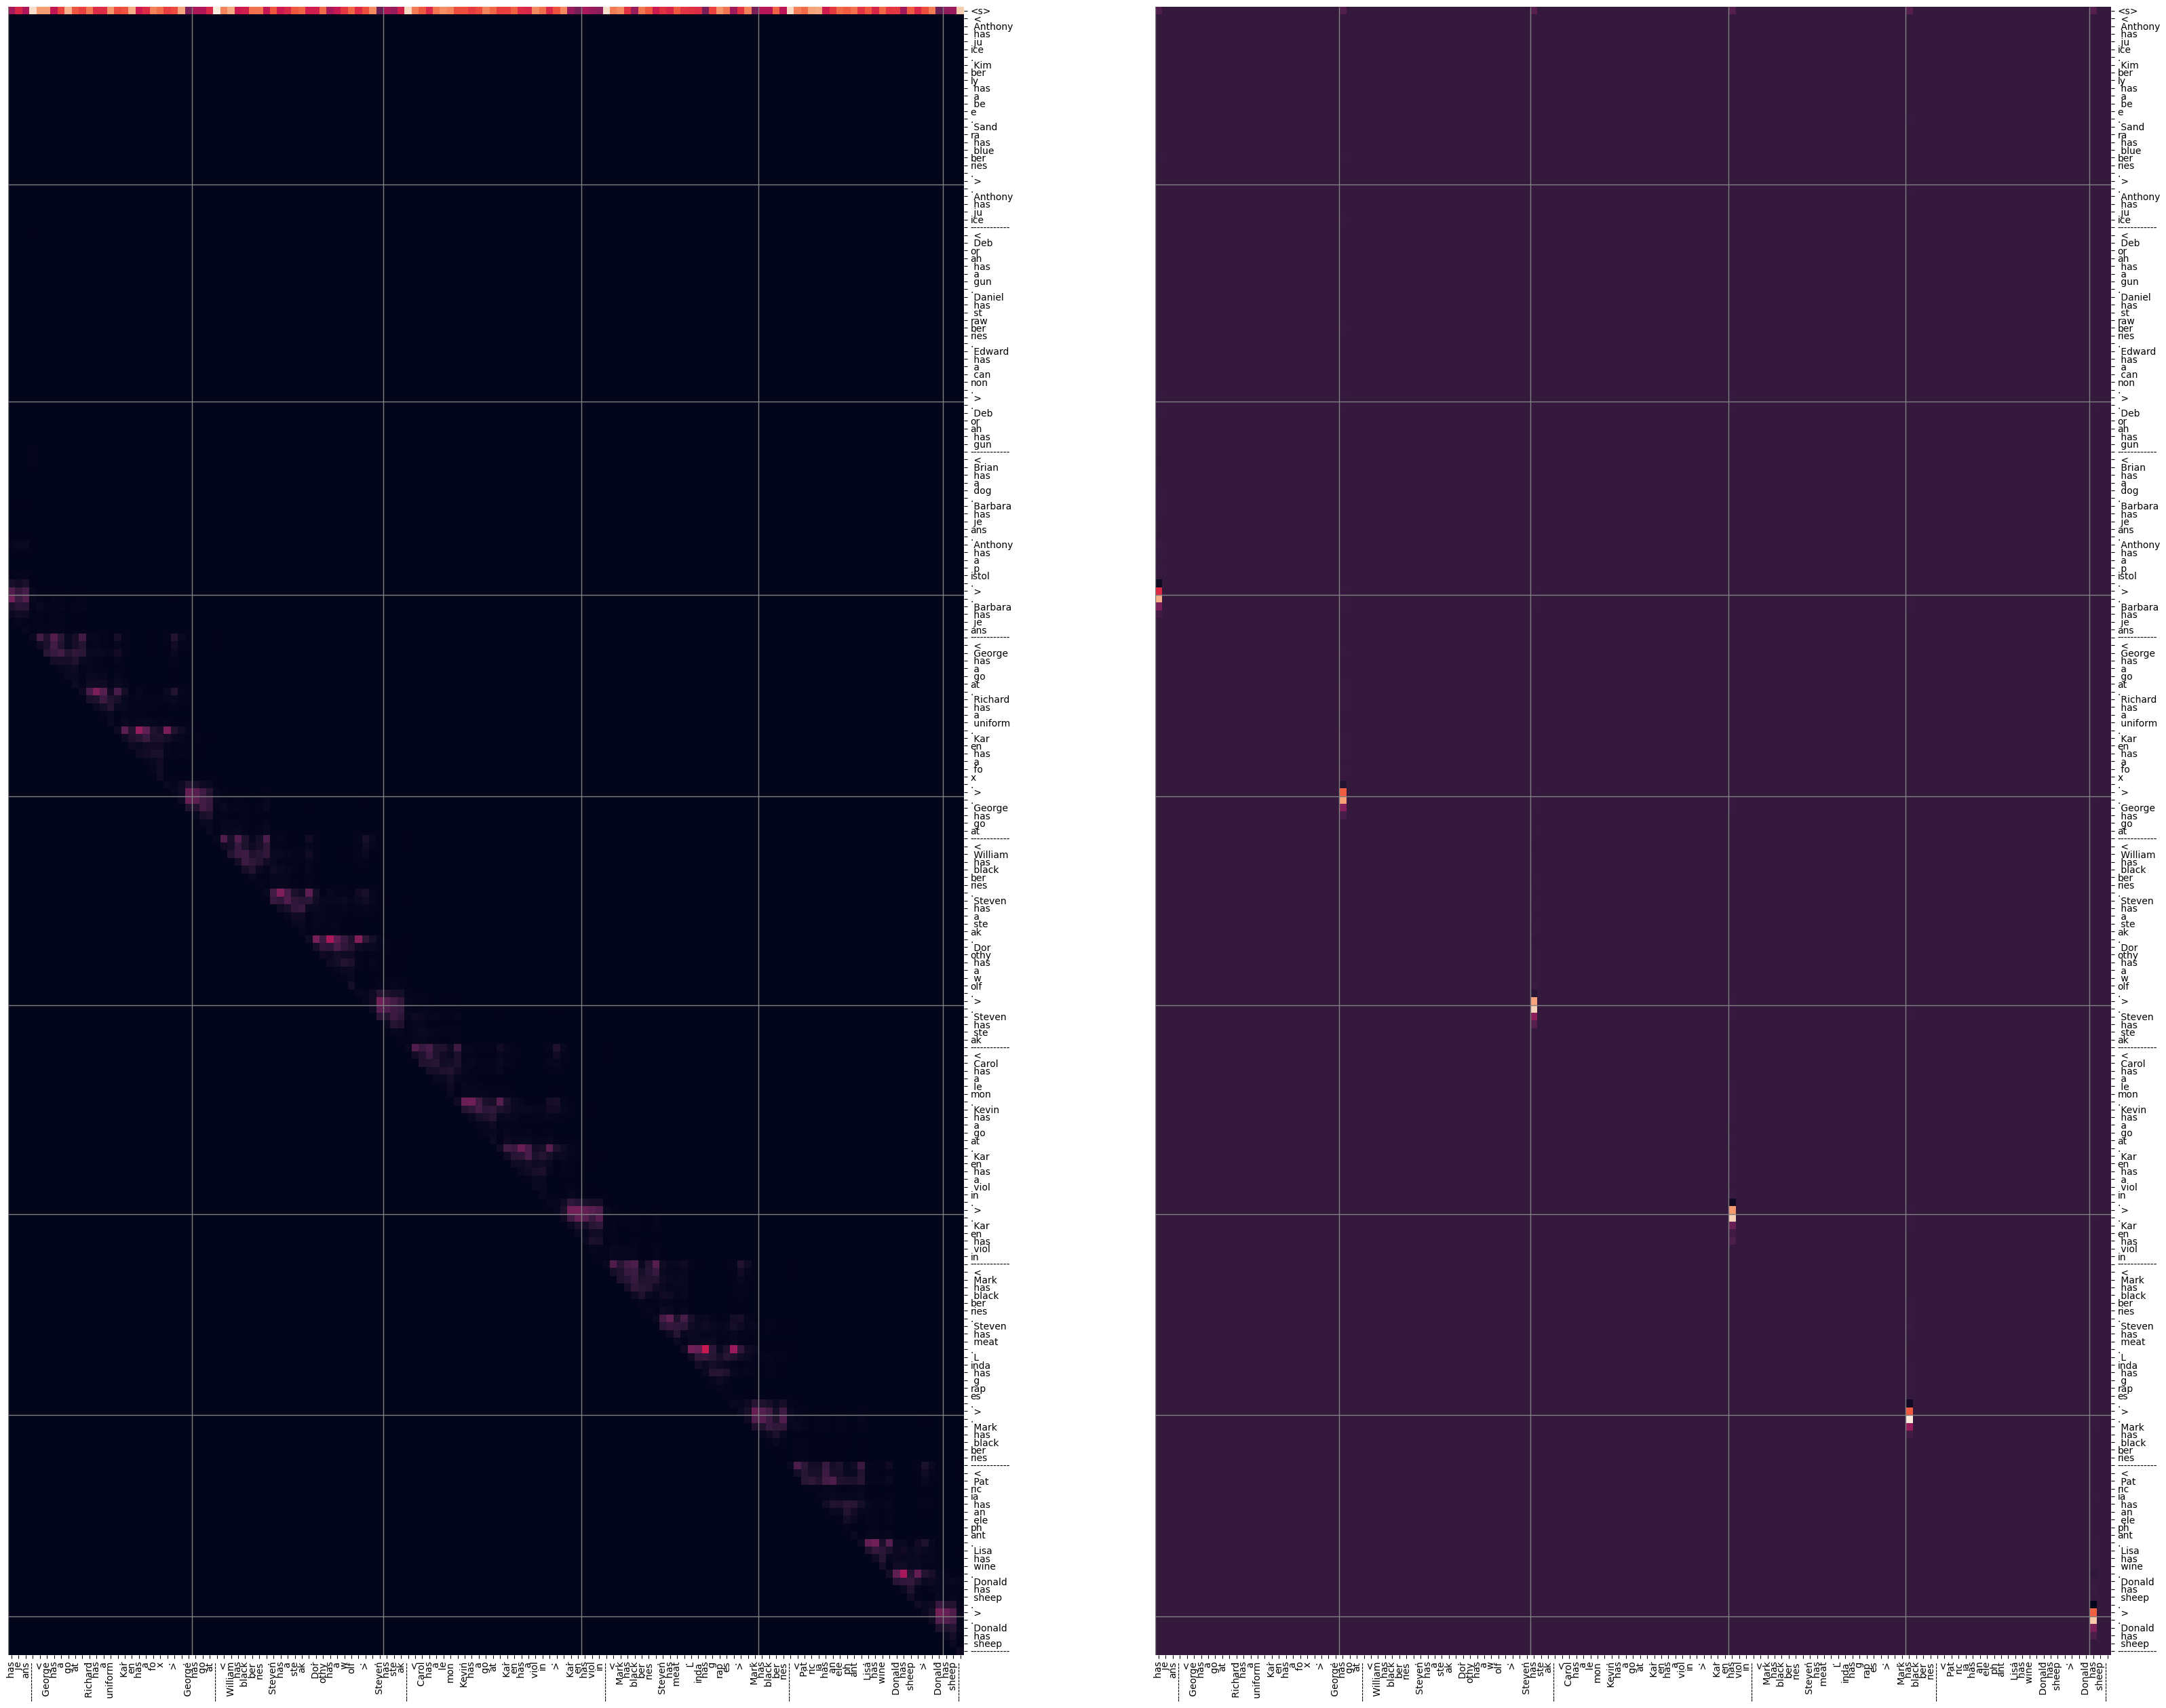

scaled_logprobs = tensor([29.4648, 34.4414, 40.5547, 47.8984], device='cuda:0')
resulting ap_scores = tensor([0.0131, 0.0144, 0.0059, 0.0060, 0.0099, 0.0109, 0.0064, 0.0093],
       device='cuda:0') tensor(0.0095, device='cuda:0')
ap_scores = tensor([0.0866, 0.1394, 0.1436, 0.1473, 0.1663, 0.1793, 0.1403, 0.1732]) tensor(0.1470)


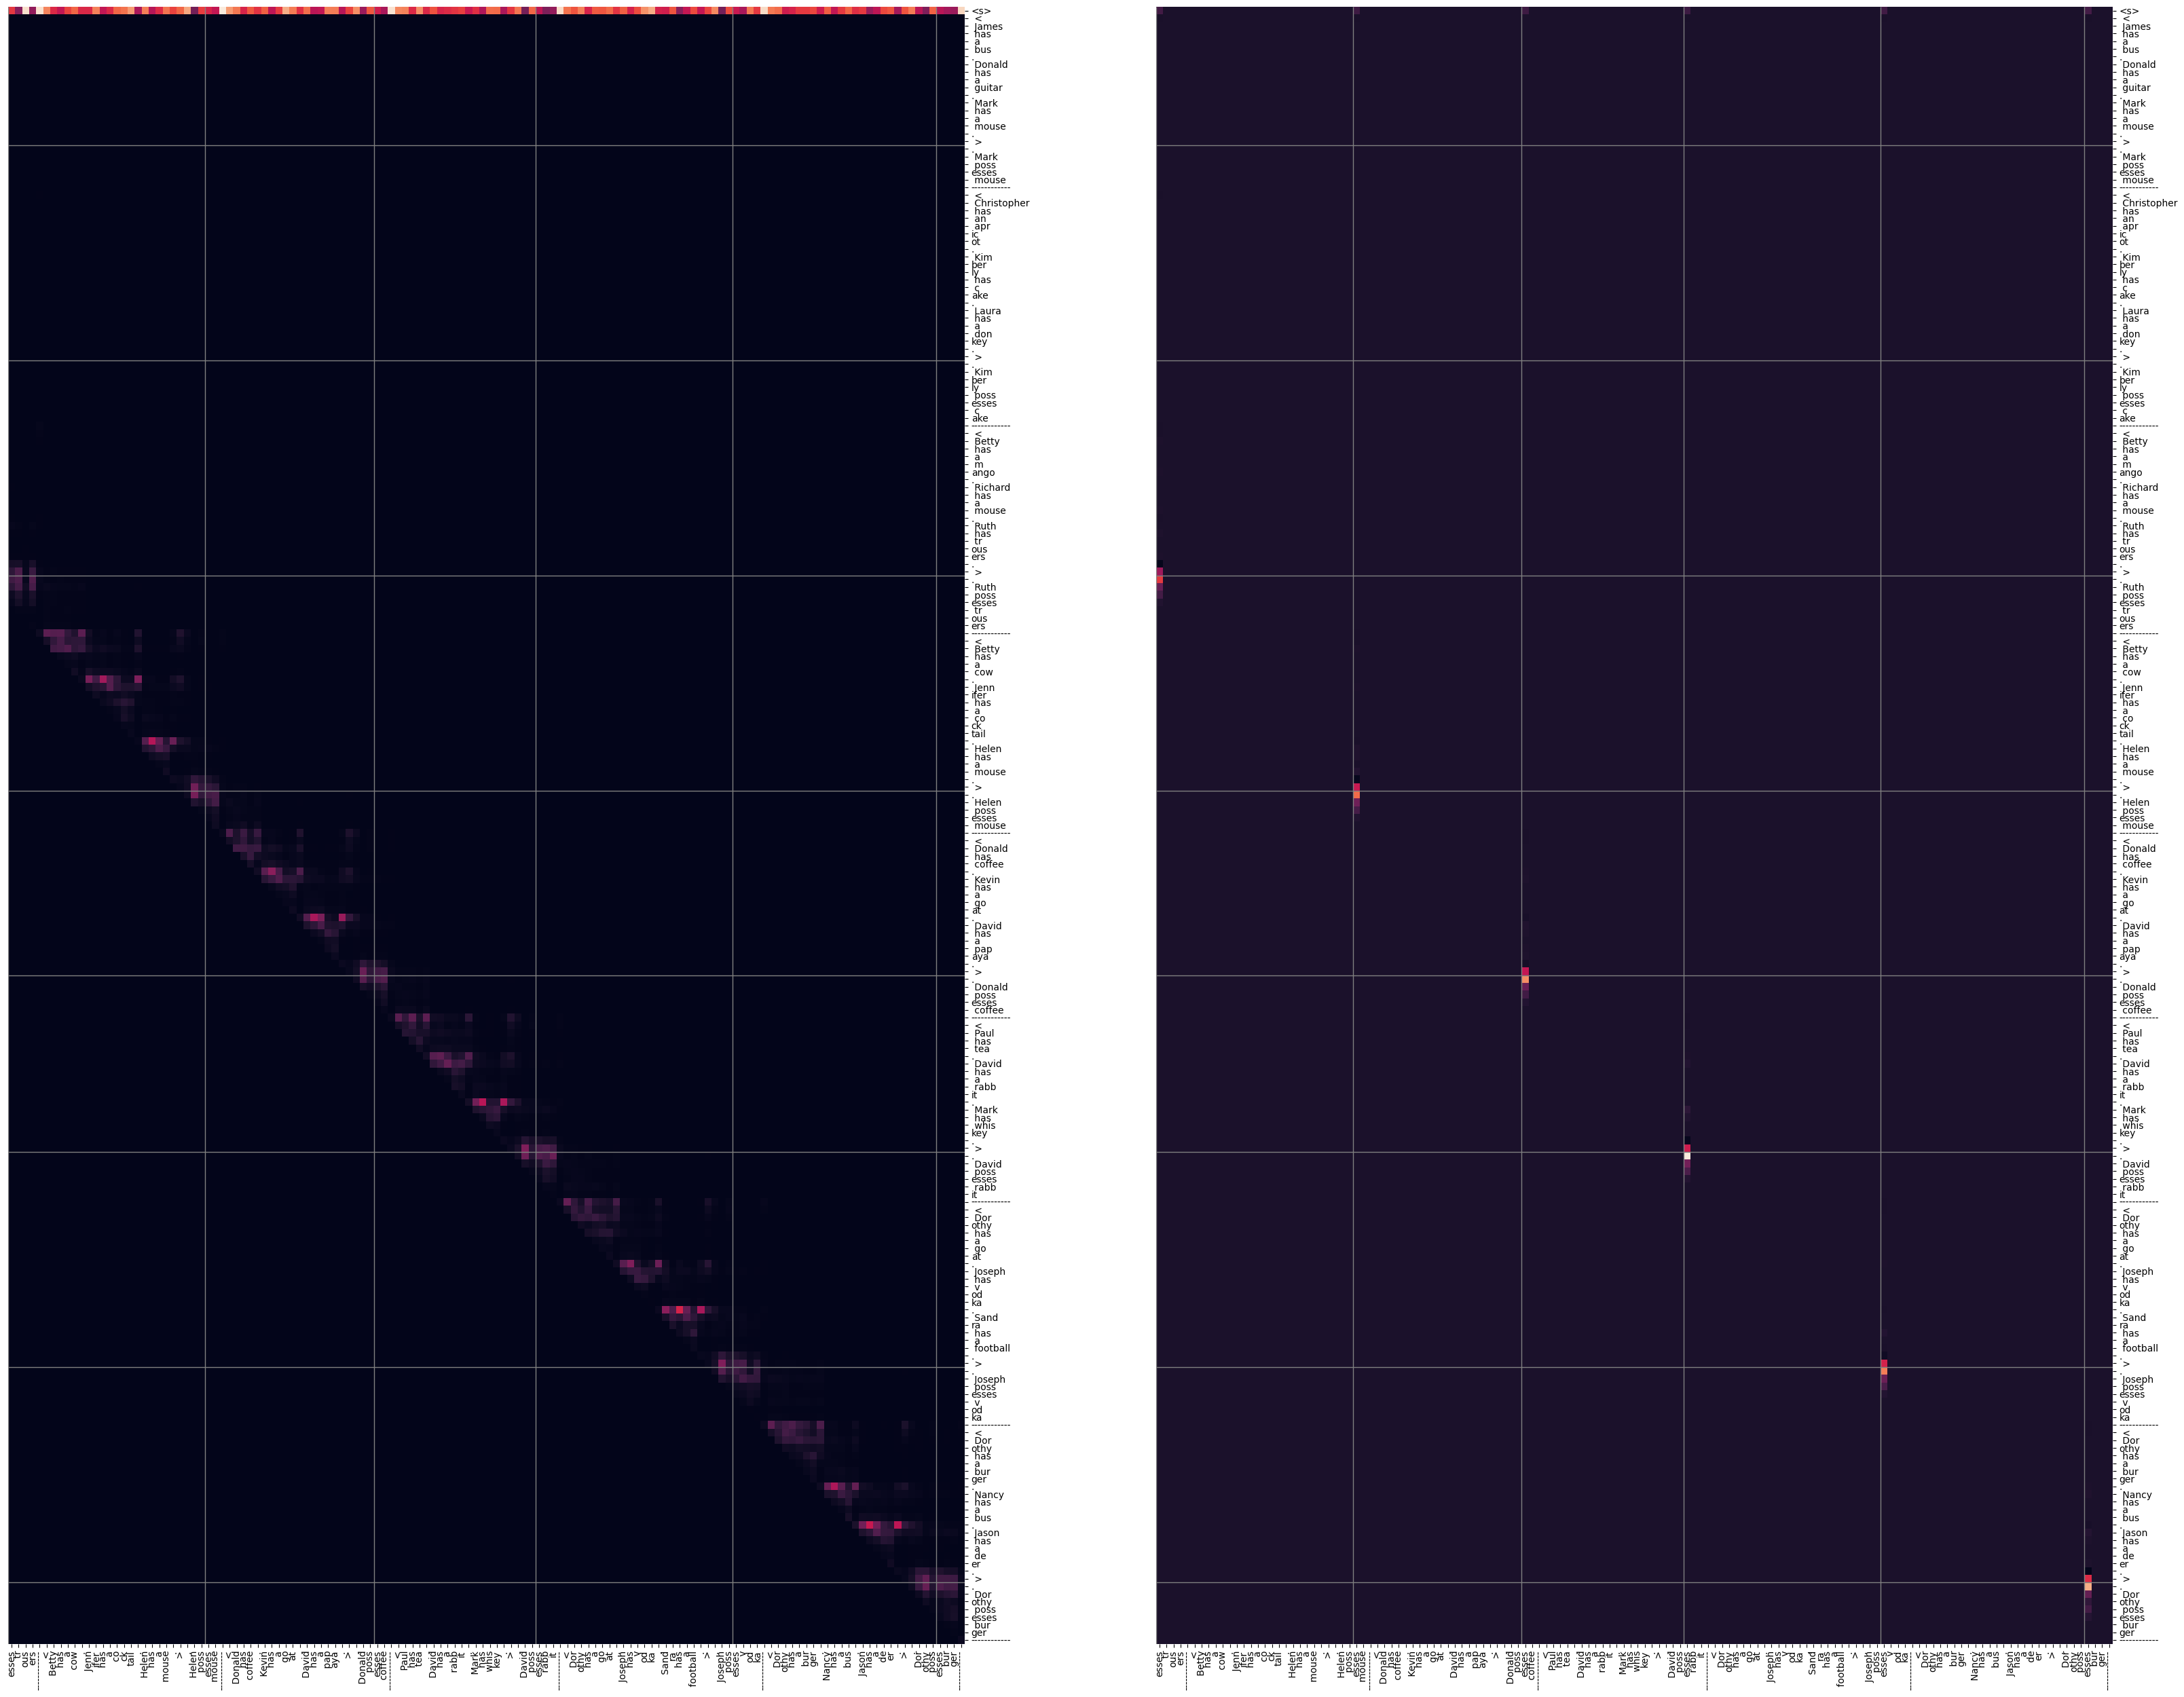

scaled_logprobs = tensor([29.9297, 34.9883, 41.4023, 49.3438], device='cuda:0')
resulting ap_scores = tensor([0.0371, 0.0214, 0.0123, 0.0037, 0.0106, 0.0069, 0.0061, 0.0068],
       device='cuda:0') tensor(0.0131, device='cuda:0')
ap_scores = tensor([0.1704, 0.1851, 0.2008, 0.2427, 0.2357, 0.2462, 0.2375, 0.2368]) tensor(0.2194)


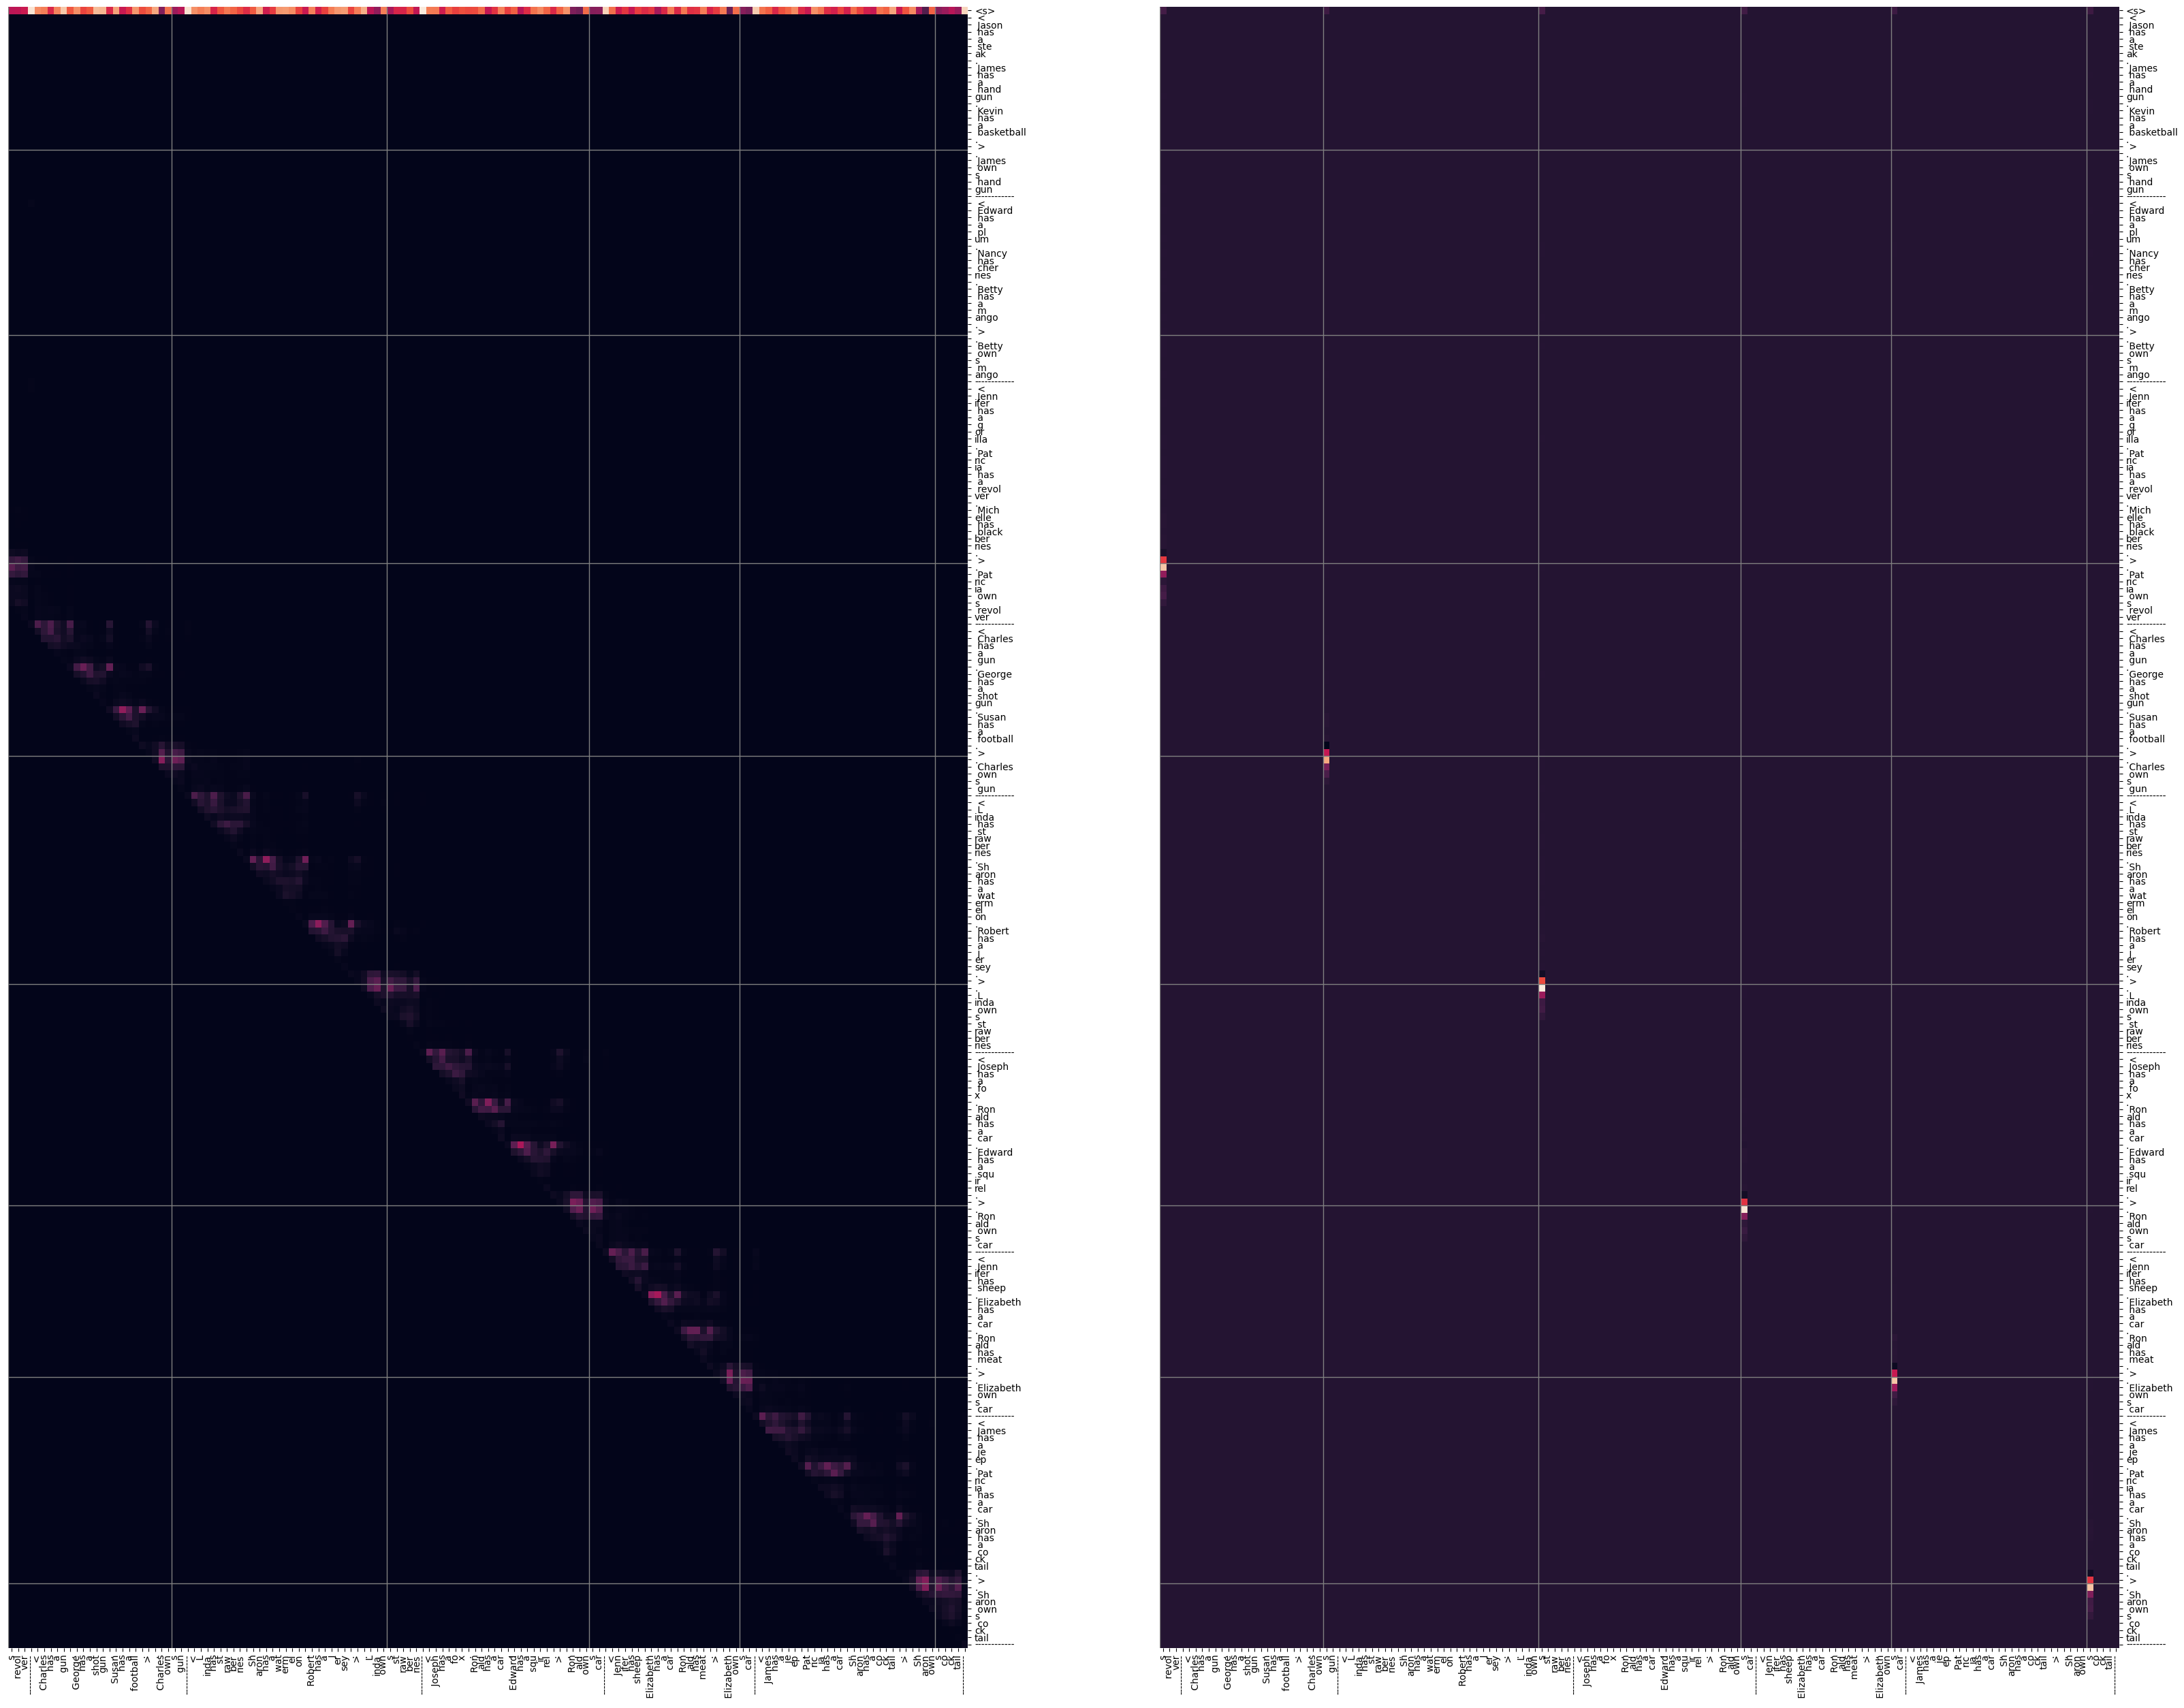

scaled_logprobs = tensor([29.6172, 34.7969, 41.2109, 49.0508], device='cuda:0')
resulting ap_scores = tensor([0.0560, 0.0331, 0.0055, 0.0055, 0.0042, 0.0061, 0.0169, 0.0053],
       device='cuda:0') tensor(0.0166, device='cuda:0')
ap_scores = tensor([0.1205, 0.1824, 0.1912, 0.2201, 0.1958, 0.2386, 0.2192, 0.2157]) tensor(0.1979)


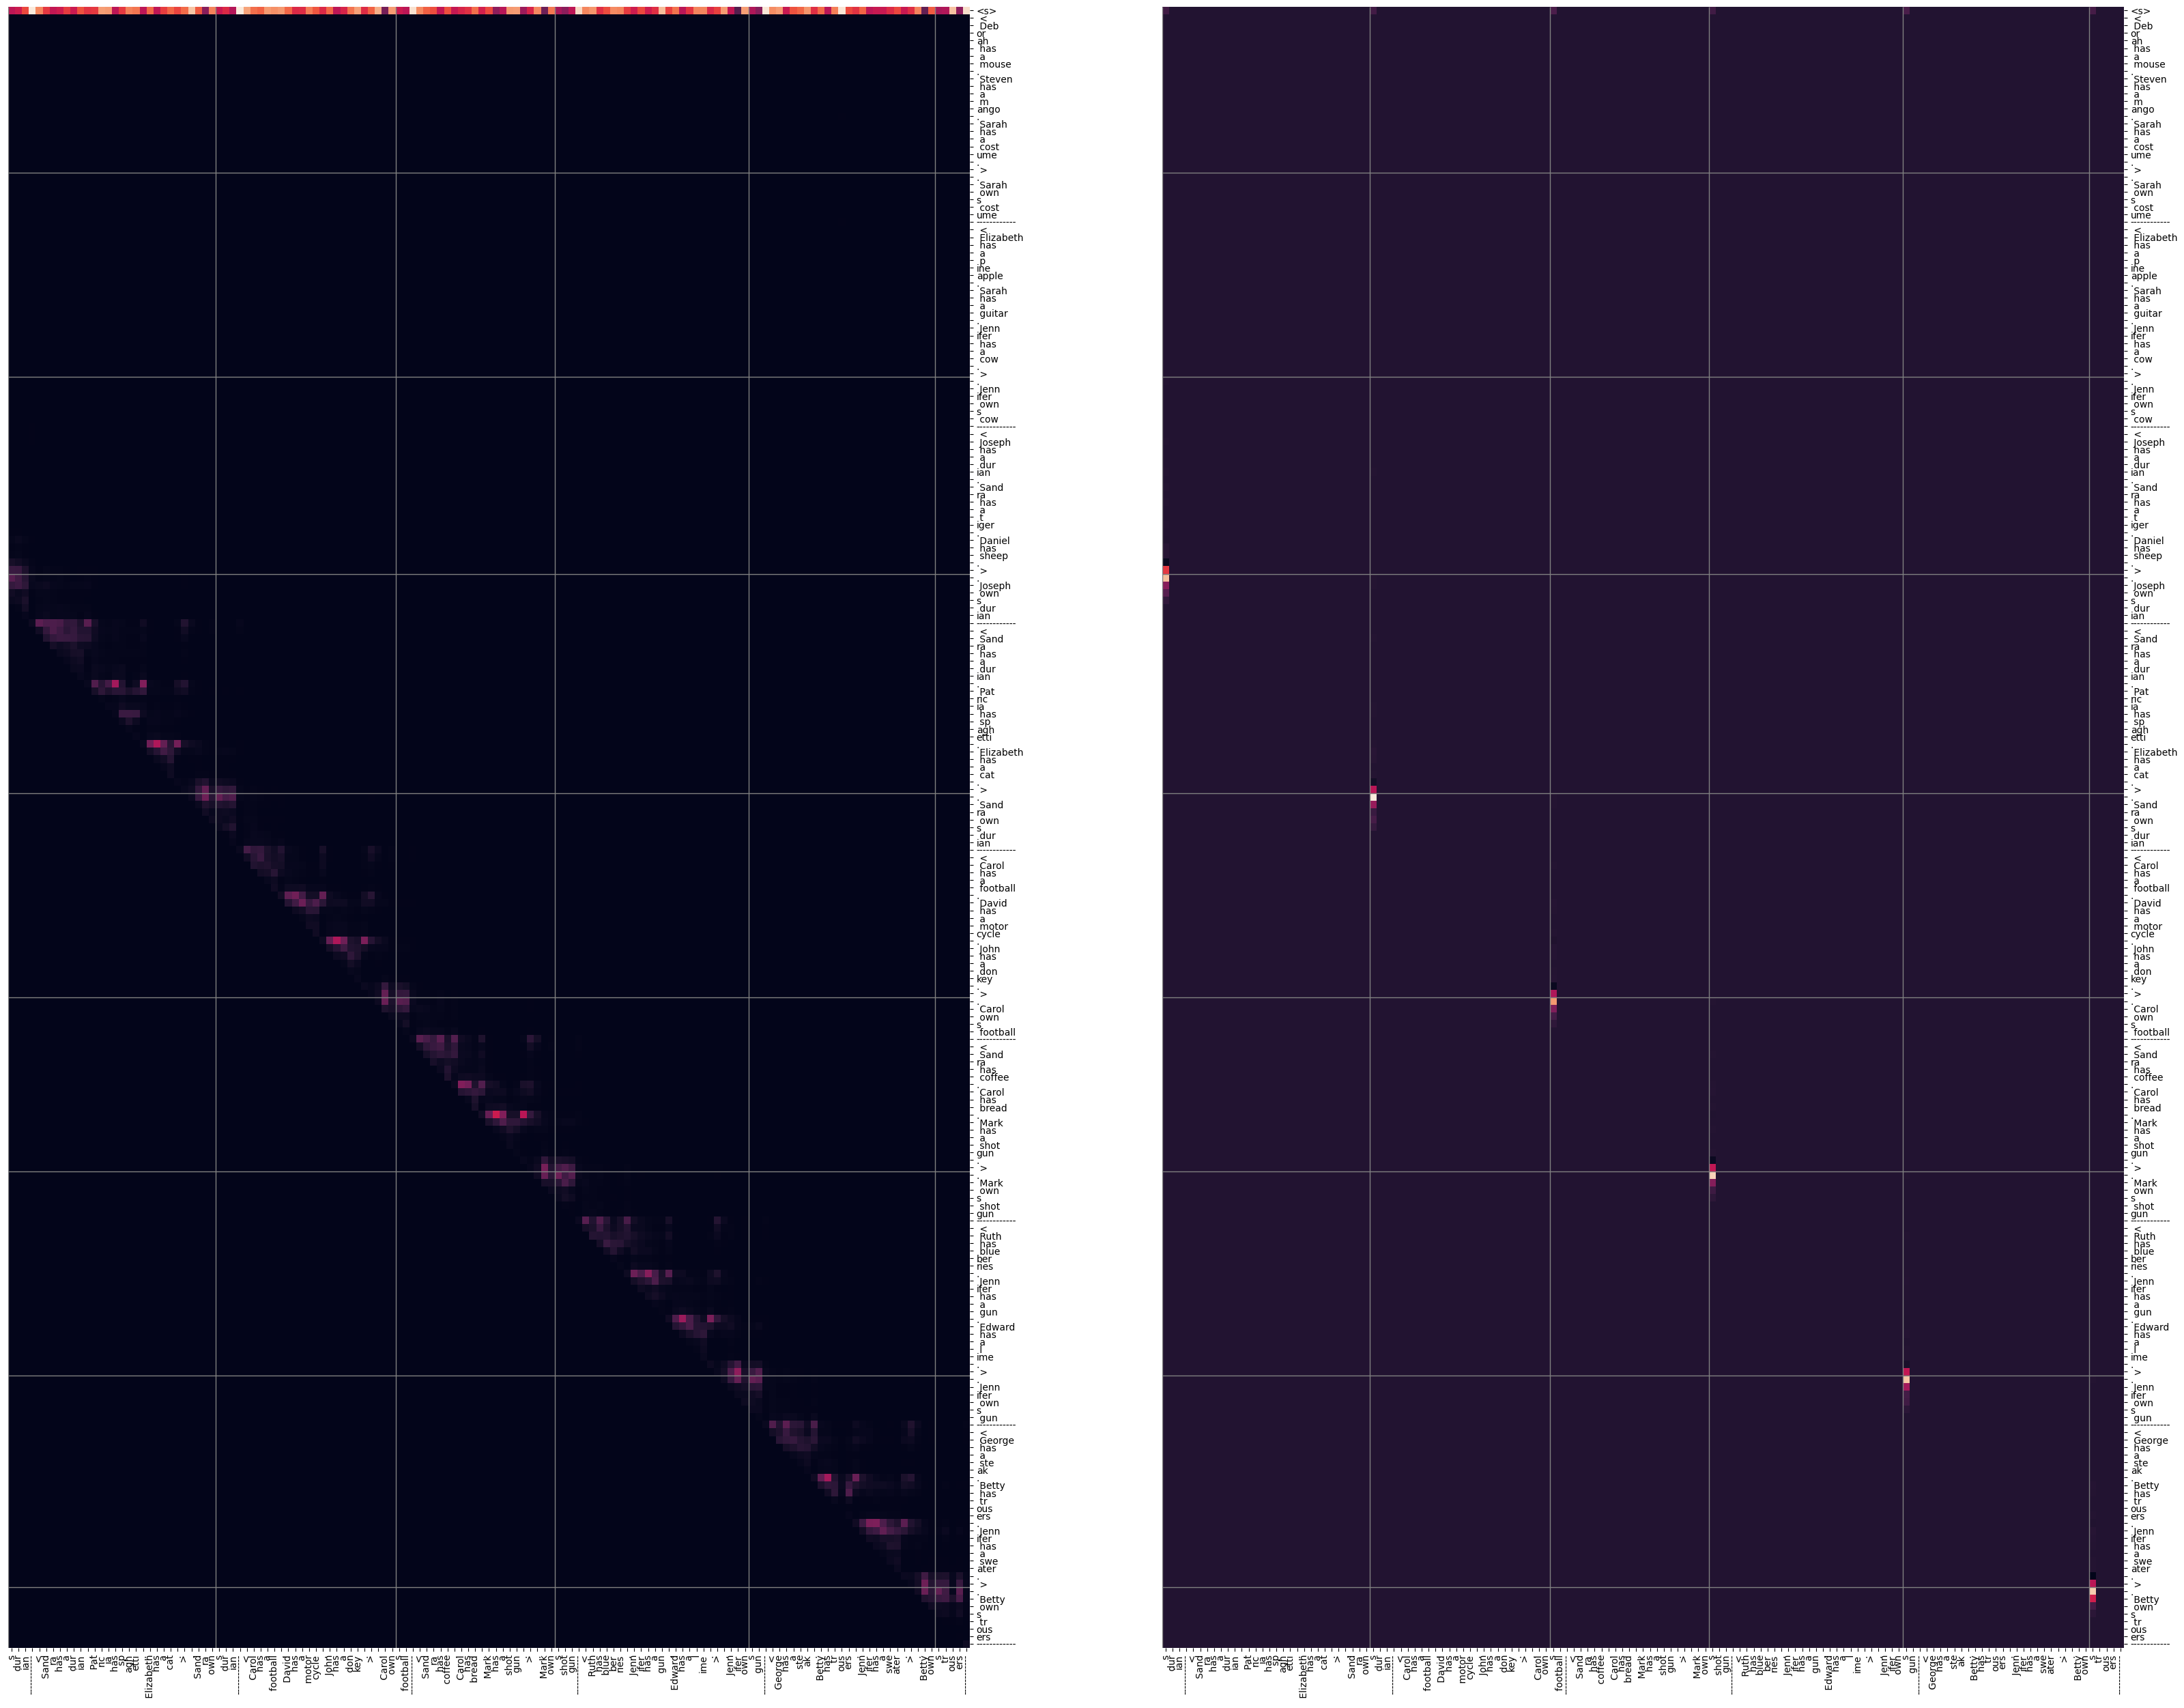

reduced_ap_scores = tensor([0.1234, 0.1917, 0.1978, 0.2062, 0.1952, 0.2160, 0.1983, 0.2050]) tensor(0.1917)


In [166]:
plot_attn_attrs(r.data_tuples[:4], model, tokenizer, node, topi=[0], attn_patterns=['B->Q-'], k_shot=k_shot, mix=False)

In [ ]:
(3+9)*12 bad order, rm color device, rm things, seed 42 1.5064196586608887 0.6203703703703703 0.37714814814814823
(3+9)*12 bad order, rm color device,            seed 42 1.159108007947604 0.6574074074074074 0.42780555555555555
(3+9)*12 bad order,                             seed 42 1.3327981928984325 0.6481481481481481 0.42299074074074067
(3+9)*12            rm color device,            seed 42 1.114751656850179 0.7037037037037037 0.44380555555555556
(3+9)*12                                        seed 42 1.3617003957430522 0.6666666666666666 0.4164907407407408

(3+9)*12 logits_bias, bad order, rm color device, rm things,seed 42 1.5064196586608887 0.6574074074074074 0.4634444444444445
(3+9)*12 logits_bias, bad order, rm color device,          seed 42 1.159108007947604 0.6759259259259259 0.5086944444444444
(3+9)*12 logits_bias, bad order                            seed 42 1.3327981928984325 0.6759259259259259 0.5191388888888889
(3+9)*12 logits_bias,            rm color device,          seed 42 1.114751656850179 0.7129629629629629 0.526574074074074
(3+9)*12 logits_bias                                       seed 42 1.3617003957430522 0.7037037037037037 0.5125555555555555

(3+9)*64 logits_bias, bad order, rm color device 1.3556777220219374 0.6597222222222222 0.4862256944444445
(3+9)*64 logits_bias,            rm color device 1.3825375027954578 0.6493055555555556 0.48517361111111107
(3+9)*64 logits_bias, bad order, rm color device, seed 42 1.3336960999295115 0.6805555555555556 0.49423958333333334
(3+9)*64 logits_bias, bad order,                  seed 42 1.4599321372807026 0.6579861111111112 0.47406597222222224
(3+9)*64 logits_bias, bad order, rm color device, rm things, seed 42 1.4292480954900384 0.65625 0.48714583333333333
# (3+9)*64 types_of_things2,logits_bias, bad_order, rm color device 2.0301878917962313 0.5138888888888888 0.3369496527777777
# (3+9)*64 types_of_things2,logits_bias, bad_order, rm color device seed 42 1.9500237852334976 0.5503472222222222 0.3563472222222222

In [38]:
print(res_key); print_tree(r.root)  # vicuna-33b

MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.child][cxt_len=3]
 ┌@[0,2,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19] 59-4,37-m,57-m,29-3,53-m,30-m,36-m,50-m,39-m,56-m,34-m,33-m,55-m,35-m,29-m 28,27-m 28,32-m 28 B->B 83
 ├@[1,3,6] 28-8,34-16,35-8 B->A0 10
 ├@0 59-4 100 B->B 81/65/27/-5.0
 ├@2 37-m 44
 ├@4 57-m 42
 ├@5 29-3 37 B->B 33/13/21/-4.4
 ├@7 53-m 34
 ├@8 30-m 34
 ├@9 36-m 34
 ├@10 50-m 34
 ├@11 39-m 34
 ├@12 56-m 33
 ├@13 34-m 32
 ├@14 33-m 31
 ├@15 55-m 30
 ├@16 35-m 30
 ├@1 28-8 72 B->A0 84/57/31/-4.7 attn/ans0s
 ├@3 34-16 44 B->A0 31/13/-67/-3.8 attn/ans0s
 ├@6 35-8 37 B->A0 67/19/-16/-4.1 attn/ans0s
 ┤
 │                     ┌@[0,1,3,4,5,6] 15-0,18-1,21-11,19-28,24-27,17-32 B->Q 39
 │                     ├@[2,7,8] 18-13,19-33,15-47 B->A0 25
 │                     ├@0 15-0 100 B->Q 60/29/9/-3.3
 │                     ├@1 18-1 91 B->Q 65/26/66/-3.7
 │                     ├@1 18-1 91 B->Q 65/26/66/-3.7 attn:B->~<s>
 │                     ├@1 18-1 91 B->Q 65/26/66

In [ ]:
1.3561700880527496 0.6666666666666666 0.40170370370370373
1.172130400935809 0.7222222222222222 0.4628611111111111
1.1529395828644435 0.7314814814814815 0.47151851851851856 # + 19-14
0.8755234579245249 0.7870370370370371 0.5257685185185186  # golden B->Q
0.34410187726219493 0.8703703703703703 0.7918055555555557  # equal

In [294]:
print(res_key); print_tree(r.root)

MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.child][cxt_len=3]_B->Q]:11-12_13-7:15-8,19-14,20-5,21-5
 ┌@[0,3,4,5,7] 21-5,20-5,15-8,19-14,13-7 28 B->A0 49
 ├@[1,2,6,8,9] 19-m,21-m,20-m,18-9 26,18-m 22 B->B 45
 ├@0 21-5 100 B->A0 97/75/72/-5.8 attn/ans0s
 ├@0 21-5 100 B->A0 97/75/72/-5.8 attn:B->~<s>
 ├@3 20-5 49 B->A0 96/75/72/-5.4 attn/ans0s
 ├@3 20-5 49 B->A0 96/75/72/-5.4 attn:B->~<s>
 ┤
 ├@4 15-8 44 B->A0 96/75/72/-4.5 attn/ans0s
 ├@4 15-8 44 B->A0 96/75/72/-4.5 attn:B->~<s>
 ├@5 19-14 42 B->A0 94/75/72/-5.5 attn/ans0s
 ├@5 19-14 42 B->A0 94/75/72/-5.5 attn:B->~<s>
 ├@1 19-m 70
 ├@2 21-m 55
 └@6 20-m 35


In [281]:
print_tree(r.root)

 ┌@[0,3,4,5,8] 21-5,20-5,15-8,19-14,13-7 28 B->A0 48
 ├@[1,2,6,7,9] 19-m,21-m,20-m,18-9 29,18-m 24 B->B 45
 ├@0 21-5 100 B->A0 95/64/78/-5.4 attn/ans0s
 ├@0 21-5 100 B->A0 95/64/78/-5.4 attn:B->~<s>
 ├@3 20-5 46 B->A0 95/64/78/-4.9 attn/ans0s
 ├@3 20-5 46 B->A0 95/64/78/-4.9 attn:B->~<s>
 ┤
 ├@4 15-8 43 B->A0 94/64/78/-4.2 attn/ans0s
 ├@4 15-8 43 B->A0 94/64/78/-4.2 attn:B->~<s>
 ├@5 19-14 41 B->A0 92/64/78/-5.0 attn/ans0s
 ├@5 19-14 41 B->A0 92/64/78/-5.0 attn:B->~<s>
 ├@1 19-m 73
 ├@2 21-m 58
 └@6 20-m 39


In [287]:
print_tree(r.root)  # child

 ┌@[0,1,2,4,9] 19-m,21-m,20-m,18-9,18-m B->B 47
 ├@[3,5,6,7,8] 21-5,19-14,13-7,20-5,15-8 B->A0 41
 ├@0 19-m 100
 ├@1 21-m 77
 ├@2 20-m 56
 ├@4 18-9 42 B->B 47/18/82/-4.0
 ├@4 18-9 42 B->B 47/18/82/-4.0 attn:B->~<s>
 ├@9 18-m 34
 ├@3 21-5 54 B->A0 60/19/83/-3.8 attn/ans0s
 ├@3 21-5 54 B->A0 60/19/83/-3.8 attn:B->~<s>
 ├@5 19-14 41 B->A0 82/20/46/-4.4 attn/ans0s
 ├@5 19-14 41 B->A0 82/20/46/-4.4 attn:B->~<s>
 │                                         ┌@:3 11-12,9-5,12-14 B->Q 39
 │                                         ├@[3,4] 10-3,11-9 B->A0 32
 │                                         ├@0 11-12 100 B->Q 55/24/30/-3.7
 │                                         ├@1 9-5 70 B->Q 80/39/28/-4.0
 ├@6 13-7 41 B->A0 94/64/78/-4.0 attn/ans0s┤
 │                                         ├@2 12-14 63 B->Q 50/17/29/-4.8
 │                                         ├@3 10-3 37 B->A0 73/19/92/-3.5 attn/ans0s
 │                                         ├@3 10-3 37 B->A0 73/19/92/-3.5 attn:B->~<s>
 │   

In [233]:
print_tree(r.root)  # equal

 ┌@[0,2,3,4,5,6,8,9] 16-7,16-0,21-14,18-5,20-8,13-7,19-14,21-13 B->A0 75
 ├@[1,7] 24-10,18-9 B->B 17
 ├@0 16-7 100 B->A0 96/44/61/-3.3 attn/ans0s
 ├@0 16-7 100 B->A0 96/44/61/-3.3 attn:B->~<s>
 ├@2 16-0 74 B->A0 96/36/85/-3.4 attn/ans0s
 ├@2 16-0 74 B->A0 96/36/85/-3.4 attn:B->~<s>
 ├@3 21-14 57 B->A0 92/31/20/-3.7 attn/ans0s
 ├@4 18-5 52 B->A0 94/39/83/-3.5 attn/ans0s
 ├@4 18-5 52 B->A0 94/39/83/-3.5 attn:B->~<s>
 ├@5 20-8 49 B->A0 90/23/51/-3.8 attn/ans0s
 ├@5 20-8 49 B->A0 90/23/51/-3.8 attn:B->~<s>
 ├@6 13-7 45 B->A0 92/49/61/-3.2 attn/ans0s
 ├@6 13-7 45 B->A0 92/49/61/-3.2 attn:B->~<s>
 ├@8 19-14 38 B->A0 89/15/52/-4.2 attn/ans0s
 ├@8 19-14 38 B->A0 89/15/52/-4.2 attn:B->~<s>
 ├@9 21-13 33 B->A0 93/28/45/-3.9 attn/ans0s
 ├@9 21-13 33 B->A0 93/28/45/-3.9 attn:B->~<s>
 ├@1 24-10 94 B->B 89/86/79/-4.9
 ├@1 24-10 94 B->B 89/86/79/-4.9 attn:B->~<s>
 ├@7 18-9 40 B->B 80/39/64/-3.6
 ├@7 18-9 40 B->B 80/39/64/-3.6 attn:B->~<s>
 ┤
 │                               ┌@[0,1,5] 11-12,9-5,14-9 B

In [194]:
node = r.root.children[-2]; node.name

'19-12,16-0 B->Q attn:B->~<s>'

In [ ]:
plot_attn_attrs(r.data_tuples[:4], model, tokenizer, node, topi=[1], attn_patterns=['B->R'], k_shot=k_shot, mix=False)

In [ ]:
== MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.child][cxt_len=2,rev_item2str] == 
< The fox is David's. The meat is Barbara's. >. Barbara likes a kind of food
< The cocktail is Christopher's. The peach is Karen's. >. Karen likes a kind of fruit
< The phone is Elizabeth's. The duck is Kevin's. >. Elizabeth likes a kind of electronics
< The pig is Anthony's. The black is Thomas's. >. Thomas likes a kind of color

In [197]:
r.data_tuples[0][3]

[Ranges(bos=(5, 6), ans=(6, 7), ans0=None, query=(1, 2), tgt=None, rel=(4, 5), sep=None, ans0s=None, example=(1, 7)),
 Ranges(bos=(13, 14), ans=(14, 15), ans0=None, query=(8, 10), tgt=None, rel=(12, 13), sep=None, ans0s=None, example=(8, 15))]

In [ ]:
0.3859229083172977 0.875 | # equal
0.4348010057583451 0.8402777777777778  # equal <>
1.247647002339363 0.6944444444444444  # 7+9

2.3866494596004486 0.4513888888888889  # gpt-j
1.6911428906023502 0.5972222222222222  # gpt-j <>
1.4658961072564125 0.625  # gpt-j <.>
1.9864061176776886 0.4444444444444444  # vicuna-7b
1.1515736505389214 0.6805555555555556  # vicuna-7b <>
1.504320003092289 0.5902777777777778  # vicuna-7b <.>
1.1335462369024754 0.6527777777777778  # vicuna-13b
0.8600838650017977 0.7013888888888888  # vicuna-136 <>

In [145]:
print(res_key); print_tree(r.root)

MlM_gen[genders_of_persons.TreeSet.equal,types_of_things.TreeSet.child][cxt_len=1,abstract]
 ┌@[1,4,7] 19-m,21-m,20-m B->B 47
 ├@[0,2,3,5,8] 21-5,15-8,20-5,19-14,14-7 B->A0 47
 ├@[6,9] 18-9,17-13 B->A0+ 17
 ├@1 19-m 91
 ├@4 21-m 52
 ├@7 20-m 37
 ├@0 21-5 100 B->A0 83/62/54/-2.0 attn/ans0s
 ├@0 21-5 100 B->A0 83/62/54/-2.0 attn:B->~<s>
 ├@0 21-5 100 B->A0 83/62/54/-2.0 attn attr_k
 ├@2 15-8 65 B->A0 86/78/44/-1.4 attn/ans0s
 ├@2 15-8 65 B->A0 86/78/44/-1.4 attn attr_k
 ├@3 20-5 56 B->A0 90/54/30/-2.3 attn/ans0s
 ├@3 20-5 56 B->A0 90/54/30/-2.3 attn attr_k
 ├@5 19-14 50 B->A0 93/53/12/-2.1 attn/ans0s
 ├@5 19-14 50 B->A0 93/53/12/-2.1 attn attr_k
 ├@8 14-7 36 B->A0 74/50/31/-1.5 attn/ans0s
 ├@8 14-7 36 B->A0 74/50/31/-1.5 attn attr_k
 ├@159 2-11 0 B->A0/98/3 attn/ans0s
 ├@159 2-11 0 B->A0/98/3 attn:B->~<s>
 ├@159 9-5 0 B->A0/74/4 attn/ans0s
 ├@159 9-5 0 B->A0/74/4 attn:B->~<s>
 ├@159 1-10 0 B->A0/72/-18 attn/ans0s
 ├@159 1-10 0 B->A0/72/-18 attn:B->~<s>
 ├@159 10-3 0 B->A0/72/11 attn/ans0

In [87]:
print_tree(r.root)

 ┌@[0,1,3,4,5,6,7,8] 16-7,16-0,20-8,13-7,21-13 26,18-13 26,19-14 24,23-14 23 B->A0 75
 ├@[2,9] 24-10,18-9 21 B->B 14
 ├@0 16-7 100 B->A0 97/60/69/-3.3 attn/ans0s
 ├@0 16-7 100 B->A0 97/60/69/-3.3 attn:B->~<s>
 ├@0 16-7 100 B->A0 97/60/69/-3.3 attn attr_k
 ├@1 16-0 65 B->A0 97/45/70/-3.3 attn/ans0s
 ├@1 16-0 65 B->A0 97/45/70/-3.3 attn:B->~<s>
 ├@1 16-0 65 B->A0 97/45/70/-3.3 attn attr_k
 ├@3 20-8 34 B->A0 92/25/78/-4.2 attn/ans0s
 ├@3 20-8 34 B->A0 92/25/78/-4.2 attn:B->~<s>
 ├@3 20-8 34 B->A0 92/25/78/-4.2 attn attr_k
 ├@4 13-7 31 B->A0 90/45/1/-3.1 attn/ans0s
 ├@4 13-7 31 B->A0 90/45/1/-3.1 attn attr_k
 ├@13 14-6 15 B->A0/70/74 attn/ans0s
 ├@13 14-6 15 B->A0/70/74 attn:B->~<s>
 ├@475 20-0 -51 B->A0/61/72 attn/ans0s
 ├@475 20-0 -51 B->A0/61/72 attn:B->~<s>
 ├@2 24-10 58 B->B 84/86/94/-4.9
 ├@2 24-10 58 B->B 84/86/94/-4.9 attn:B->~<s>
 │                           ┌@[0,1,2,3,5] 10-11,12-12,14-9,10-4,11-12 A0->T+ 39
 │                           ├@[4] 0-m A0->A0 18
 │                     

 Ġanimal 0.0 {'Ġto': 0.2, 'Ġthe': 0.047, 'Ġspaghetti': 0.032} 	 Kenneth has a taxi. Linda has a gorilla. Elizabeth has spaghetti. Linda likes animal Ġvehicle:2.389 *Ġanimal:6.922 Ġfood:9.609
 Ġvehicle 0.0 {'Ġa': 0.054, 'Ġto': 0.043, 'Ġanimal': 0.029} 	 Kenneth has jeans. Maria has pink. George has a car. George likes vehicle Ġclothing:7.414 Ġcolor:8.742 *Ġvehicle:7.629
 Ġclothing 0.002 {'Ġvehicle': 0.367, 'Ġanimal': 0.18, 'Ċ': 0.038} 	 Susan has a steak. John has shoes. Kenneth has spaghetti. John likes clothing Ġfood:12.891 *Ġclothing:10.219 Ġfood:12.891
 Ġsport 0.09 {'Ċ': 0.159, 'Ġsport': 0.09, 'Ġa': 0.082} 	 Deborah has a mouse. Steven has a mango. Sarah has a football. Sarah likes sport Ġanimal:11.578 Ġfruit:10.188 *Ġsport:13.695
 Ġanimal 0.093 {'Ġfood': 0.179, 'Ċ': 0.108, 'Ġanimal': 0.093} 	 Sarah has Jeep. Jennifer has sheep. Elizabeth has spaghetti. Jennifer likes animal Ġvehicle:13.648 *Ġanimal:14.266 Ġfood:14.922
 Ġdrink 0.017 {'Ġanimal': 0.13, 'Ġclothing': 0.127, 'Ġfruit': 0.

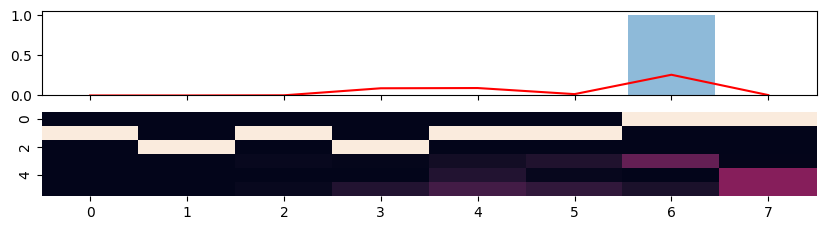

 Ġclothing 0.0 {'Ġto': 0.158, 'Ġhis': 0.043, 'Ġthe': 0.043} 	 Joseph has an apricot. John has T-shirt. Daniel has a hamburger. John likes clothing Ġfruit:9.930 *Ġclothing:5.422 Ġfood:10.484
 Ġcolor 0.023 {'Ġred': 0.113, 'Ġclothing': 0.057, 'Ġa': 0.043} 	 Laura has a mango. Donna has a rabbit. Ronald has red. Ronald likes color Ġfruit:11.859 Ġanimal:8.766 *Ġcolor:12.305
 Ġsport 0.003 {'Ċ': 0.209, 'Ġa': 0.051, 'Ġto': 0.039} 	 Carol has a basketball. Deborah has a handgun. Betty has an iPad. Carol likes sport *Ġsport:10.219 Ġweapon:6.715 Ġelectronics:11.438
 Ġweapon 0.002 {'Ġwhiskey': 0.094, 'Ġsport': 0.079, 'Ġdrink': 0.074} 	 Anthony has a gun. Maria has purple. Ronald has whiskey. Anthony likes weapon *Ġweapon:9.820 Ġcolor:12.969 Ġdrink:13.664
 Ġelectronics 0.008 {'Ġcolor': 0.203, 'Ġtechnology': 0.047, 'Ġgadget': 0.017} 	 Jeff has a handgun. Christopher has a smartphone. Jason has gray. Christopher likes electronics Ġweapon:9.789 *Ġelectronics:11.336 Ġcolor:14.547
*Ġfruit 0.432 {'Ġfruit

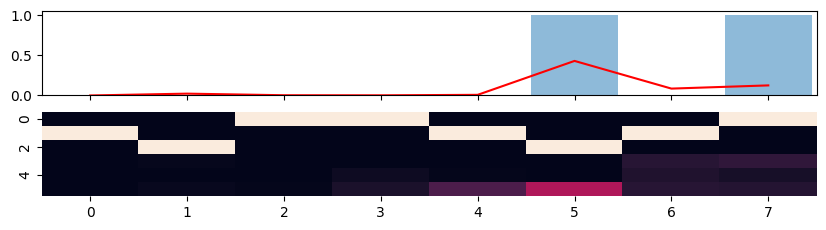

(3.216680884361267, 0.5)

In [159]:
show_predictions_by_data_tuples(model, tokenizer, r.data_tuples, k_shot)

In [88]:
node = r.root.children[-4].children[-1]; node.name

'11-12,9-5 B->Q attn:B->~<s>'

In [ ]:
plot_attn_attrs(r.data_tuples[:1], model, tokenizer, node, topi=[1], attn_patterns=['B->B'], k_shot=k_shot+4, mix=False)

In [ ]:
for data_tuple in data_tuples[:3]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 13, 7, attn_patterns=['bos->ans0]'], k_shot=0, plot_attr=False)

In [ ]:
node = node.parent

In [ ]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2,3,4])#layer=11, head=12, attn_pattern='bos->query]', label_type='argmax_attn_labels')

In [ ]:
key = 'MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.child) (cxt_len=3)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:3]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 13, 7, attn_patterns=['bos->ans0]'], k_shot=0, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1,2], k_shot=k_shot, mix=False)

In [ ]:
node = result.root

In [ ]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2])#, attn_pattern='bos->query]', label_type='argmax_attn_labels')

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3,4,5])#attn_pattern='bos->ans0]', label_type='argmax_attn_labels')

In [ ]:
key = 'MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.equal) (cxt_len=3)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 11, 12, attn_patterns=['bos->query]'], k_shot=0, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1], k_shot=k_shot)

In [ ]:
node = result.root

In [ ]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2,3,4,5])#, label_type='argmax_attn_labels')

In [ ]:
print(key); node = result.node = add_node(node, topi=[0])#, attn_pattern='bos->query]', label_type='argmax_attn_labels')

In [ ]:
for head_chain in product([(8, 7), (6, 2)], [(13, 13), (9, 14), (12, 10)], [(16, 7)]):
    print(head_chain, plot_eigv(weightprod(model, list(head_chain), 'e vo vo qk e', weBTA=model.weBTAs[0]), plot=False))

### person_adjs.opposite

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6/6-10->4-8_1-7/6-2/8-7->7-9'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1,2], k_shot=k_shot, mix=False)

In [ ]:
node = result.root

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1])#, label_type='argmax_attn_labels')

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8_6-2qk->7-9'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
node = node.parent

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3]) #label_type='argmax_attn_labels', attn_pattern='bos->query]') # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
node = node.parent

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)  # 

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1], head_attr_fn=get_head_mlp_attr)#label_type='argmax_attn_labels', attn_pattern='bos->query]') # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,4,5], k_shot=k_shot)  # 

In [ ]:
forked_node_k.k_node = q_node; forked_node_k.model = model
del forked_node_k.k_node; del forked_node_k.model

In [ ]:
forked_node.k_node = k_node; forked_node.model = model
del forked_node.k_node; del forked_node.model

In [ ]:
node = node.parent.parent

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3]) #label_type='attn_labels', attn_pattern='bos->query]', step=0, attribute_k=True) # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)  # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr, 

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,2], head_attr_fn=get_head_mlp_attr, k_shot=k_shot, mix=True)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot, mix=True)  # 

In [ ]:
for data_tuple in data_tuples[:4]: plot_attn_attr(data_tuple, model, tokenizer, node, 7, 9, attn_patterns=['bos->ans0]'], k_shot=k_shot, plot_attr=False)

In [ ]:
node = node.children[1]

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2], head_attr_fn=get_head_mlp_attr)# label_type='attn_labels')  # 

### thing->type

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [ ]:
node.name

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,2,4], head_attr_fn=get_head_mlp_attr)#, label_type='argmax_attn_labels')  # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:4]: plot_attn_attr(data_tuple, model, tokenizer, node, 16, 7, attn_patterns=['bos->ans0]'], k_shot=k_shot, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [ ]:
node = node.parent.parent

In [ ]:
print(key); node = result.node = add_node(node, layer=16, head=7, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')  # 

In [ ]:
print(key); node = result.node = add_node(node, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')

### fr->en

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3,4,5])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples, model, tokenizer, node, topi=[0,1,2], k_shot=k_shot)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2], label_type='argmax_attn_labels')  # head_attr_fn=get_head_mlp_attr

In [ ]:
analyze_head_chains(model, get_head2scores(result.root.children[1].children[0].children[0]))

### did->does

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0,1], head_attr_fn=get_head_mlp_attr, mix=True)

In [ ]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    show_predictions(tokenizer, *args, logits=o.logits, labels=labels, k_shot=k_shot, topk=3)[0]

In [ ]:
result.node = result.node.parent.parent.parent
result.node = result.root

In [ ]:
print(key); node = add_node_to_result(result, topi=[1,0,2,7], head_attr_fn=get_head_mlp_attr, label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr

In [ ]:
for data_tuple in data_tuples:
    plot_attn_attr(data_tuple, model, tokenizer, node, 17, 16, attn_patterns=None, k_shot=0, plot_attr=False)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node.parent, topi=[0,1,6,7,10])

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=10)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 7], head_attr_fn=get_head_mlp_attr)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3], label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr, 

### thing->capability

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1])

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[2,1,3,0])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
        tokenizer, *args, logits=o.logits, labels=labels, loss_reduction='mean',
        candidates=None, k_shot=k_shot, topk=3, verbose=True)
    print(loss)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0], k_shot=k_shot)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2, 3], k_shot=k_shot, plot_attr=False)

In [ ]:
print(key); node = add_node_to_result(result, topi=[1,2,0], label_type='argmax_attn_labels')

### capital->country

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

In [ ]:
print(key); node = add_node_to_result(result, topi=[0])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='argmax_attn_labels')

### person_adjs.opposite

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3,4])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,])#, label_type='attn_labels')

### thing->type

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")  # old full

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[1, 2])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0, 1, 2, 3, 4])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='attn_labels')

In [ ]:
# seed(1234); torch.cuda.empty_cache()
model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', #'EleutherAI/gpt-neox-20b/cpu', 
               'text-curie-001', 'text-davinci-001', 'text-davinci-002'][:1]
metrics = dict(losses=defaultdict(list), accuracies=defaultdict(list))

def batch_predict(model, tokenizer):
    return [predict(model, tokenizer, text, examples, k_shot=k_shot, custom_forward=False, # avoid computing head_inputs
                    bos_token=bos_token, eos_token=eos_token, verbose=len(model_names) == 1)[1]
            for text, examples in zip(texts, all_examples)]
    
with Timer('pmapped batch_predict'):
    parallel = len(model_names) > 1
    pool = Pool(len(model_names)) if parallel else itertools  # with Pool(len(model_names)) as pool:
    results = pool.starmap(batch_predict, [models[model_name] for model_name in model_names])
    if parallel: pool.close(); pool.join()
            
# query2acc, query2loss = defaultdict(list), defaultdict(list)
for model_name, r in zip(model_names, results):
    _, tokenizer = models[model_name]
    for i, (loss, top1_corrects, answer_indices, answer_probs, candidate_probs) in enumerate(r):#.get()
        acc = top1_corrects[k_shot:] # np.array(top1_corrects[k_shot:]).mean()
        metrics['losses'][model_name].append(loss); metrics['accuracies'][model_name].append(acc)
        if batch_size == 1: print(model_name, loss, acc)
#         queries = [e[1] for e in _examples_list[i]][k_shot:]
#         for q, a, l in zip(queries, acc, loss): query2acc[q].append(float(a)); query2loss[q].append(l)
# print(sorted([(q, np.array(v).mean()) for q, v in query2acc.items()], key=lambda x: x[1]))

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

In [ ]:
def cmp(a, b):
    print(a.dtype, a.size(), b.dtype, b.size())
    print('allclose:', torch.allclose(a, b), 'equal:', torch.equal(a, b))
    print((a == b).float().mean())
    print((a - b).float().abs().mean(), a.float().abs().mean(), b.float().abs().mean())
#     print((a - b).max(), (a - b).min())
#     print(a[a - b == (a - b).max()])
#     print(a[a - b == (a - b).min()])

In [ ]:
# text, _examples = texts[0], _examples_list[0]
torch.cuda.empty_cache()
if True: #def predict2(model, tokenizer, text, _examples):
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text, tokenizer, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in cands[0]] for _, _, cands, _ in _examples]
    with torch.no_grad():
        with Timer(): o0 = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
        with Timer(): o1 = forward0(model, input_ids.to(model.device), labels=labels.to(model.device),
                by_head=['head_input0', 'head_output0'], attn_weights=None, output_hidden_states=True)
        for o in [o0, o1]:
            logits = o.logits
            if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()# softmax on cpu needs float32
            loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
                examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, loss_reduction='none',
                candidates=candidates, k_shot=k_shot, topk=3, verbose=True)
            print('\n')
#     return loss, top1_corrects, answer_probs, candidate_probs

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name])[:,:27].mean())

In [ ]:
for metric in ['accuracies', 'losses']:
    _ = plt.figure(figsize=(10, 3));
    for model_name in model_names[:2]:
        plt.plot(np.array(metrics[metric][model_name])[:].mean(0), label=f'{model_name}');
    _ = plt.legend();  _ = plt.title(metric); _ = plt.show();

In [ ]:
time2prep = {tuple(clock_of_day): 'at', tuple(days_of_week): 'on', tuple(months): 'in'}
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def lookup_query2str(query, vocab=None, rel_name=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'

In [ ]:
text = '''Aaren is a boy. Harlow is a girl.
Harlow called Aaren.
Harlow: "Are you a girl?"
Aaren: "'''
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
input_ids = tokenizer.encode(text, return_tensors='pt')
logits = model(input_ids.to(getattr(model, 'device', 'cpu'))).logits

In [ ]:
show_topk(*logits[0][-1].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [ ]:
get_prob_dist(logits.top_logprobs[-1], 5)

In [ ]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [ ]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

In [ ]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [ ]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

In [ ]:
sum(s.count('Yes') for s in input_strs)

In [ ]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [ ]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [ ]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [ ]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [ ]:
trainer.place_model_on_device

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [ ]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])